In [9]:
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize_scalar

In [10]:
from scipy.optimize import Bounds

bounds = Bounds([0, -0.5], [1.0, 2.0])

In [11]:
from scipy.optimize import LinearConstraint

linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])


In [12]:
## DEFINE FUNCTIONS FOR FITNESS, CONDITION AND INVESTMENT CAPABILITY


def sigmoid(x):
    return 1 / (0.8 + math.exp(-x))

def male_fitness(x):
    km=1
    am=80
    bm=10


    """The Rosenbrock function"""

    return km/(1+am*math.exp(-bm*x))

def female_fitness(x):
    bf=4.5324681549033698521644401984791
    kf=4/5
    af =3

    """The Rosenbrock function"""

    return kf/(1+af*math.exp(-bf*x))

def offs_condition(c_m,i):

    """The Rosenbrock function"""

    return 0.5*c_m + 0.5*i**0.5

def investment(c_m):
    d1=1
    d2=1
    d3=20

    return d1/(1+d2 *math.exp(-d3*(c_m - 0.5)))



def all_males(i,c_m,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)) + male_fitness(offs_condition(c_m,investment(c_m)-i)))

def mixed(i,c_m,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)) + female_fitness(offs_condition(c_m,investment(c_m)-i)))

def all_females(i,c_m,sign=-1):
    return sign*(female_fitness(offs_condition(c_m,i)) + female_fitness(offs_condition(c_m,investment(c_m)-i)))

                                                        


def find_sexratio(x, i_star_ma, i_star_fe, i_star_mi,c_m,sign=-1):
    return (x*x * all_males(i_star_ma,c_m) + (1-x)*(1-x) * all_females(i_star_fe,c_m) + (2* x *(1-x) )*mixed(i_star_mi,c_m)  )                                          
     

In [13]:
c_m=0.5

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

investment(c_m)
#bounds_sr = Bounds([0, 1])

i_star_ma = minimize_scalar(all_males, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
i_star_fe = minimize_scalar(all_females, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
i_star_mi = minimize_scalar(mixed, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
 
alpha_star = minimize_scalar(find_sexratio, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma.x, i_star_fe.x, i_star_mi.x,c_m))

alpha_star.fun

-1.3048937611712754

In [14]:
## OPTIMIZATION FUNCTIONS 
# CONVEX FITNESS
def male_fitness(x):

    return x**2

def female_fitness(x):
    kx=0.2
    lx=0.266
    return kx+lx*x

def optimal_Basic(c_m,x_0_inv,x_0_sr):

    i_star_ma = minimize_scalar(all_males, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_fe = minimize_scalar(all_females, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    i_star_mi = minimize_scalar(mixed, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m))
    
    alpha_star = minimize_scalar(find_sexratio, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma.x, i_star_fe.x, i_star_mi.x,c_m))

    return i_star_ma.x, i_star_fe.x, i_star_mi.x, alpha_star.x


def mixed_Unc(i,c_m,phi,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)+phi) + female_fitness(offs_condition(c_m,investment(c_m)-i)+phi))

def all_males_Unc(i,c_m,phi,sign=-1):
    return sign*(male_fitness(offs_condition(c_m,i)+phi) + male_fitness(offs_condition(c_m,investment(c_m)-i)+phi))

def all_females_Unc(i,c_m,phi,sign=-1):
    return sign*(female_fitness(offs_condition(c_m,i)+phi) + female_fitness(offs_condition(c_m,investment(c_m)-i)+phi))




def find_sexratio_Unc(x, i_star_ma_b, i_star_fe_b, i_star_mi_b,i_star_ma_n, i_star_fe_n, i_star_mi_n,i_star_ma_w, i_star_fe_w, i_star_mi_w,c_m,P,phi,sign=-1):
    
    b=P[ct][0]*(x*x * all_males_Unc(i_star_ma_b,c_m,phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_b,c_m,phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_b,c_m,phi)  )                                          
    n=P[ct][1]*(x*x * all_males_Unc(i_star_ma_n,c_m,0) + (1-x)*(1-x) * all_females_Unc(i_star_fe_n,c_m,0) + (2* x *(1-x) )*mixed_Unc(i_star_mi_n,c_m,0)  )                                          
    w=P[ct][2]*(x*x * all_males_Unc(i_star_ma_w,c_m,-phi) + (1-x)*(1-x) * all_females_Unc(i_star_fe_w,c_m,-phi) + (2* x *(1-x) )*mixed_Unc(i_star_mi_w,c_m,-phi)  )                                            
    
    return b+n+w


def optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr):   
    
    i_star_mi_b = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_mi_n = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_mi_w = minimize_scalar(mixed_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
    
    
    i_star_ma_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_ma_n = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_ma_w = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
 
   
    i_star_fe_b = minimize_scalar(all_males_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,phi))
    
    i_star_fe_n = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,0))
    
    i_star_fe_w = minimize_scalar(all_females_Unc, x_0_inv,bounds=(0,investment(c_m)),method='bounded',args=(c_m,-phi))
   
   
    alpha_star = minimize_scalar(find_sexratio_Unc, x_0_sr,bounds=(0,1),method='bounded',args=(i_star_ma_b.x, i_star_fe_b.x, i_star_mi_b.x,i_star_ma_n.x, i_star_fe_n.x, i_star_mi_n.x,i_star_ma_w.x, i_star_fe_w.x, i_star_mi_w.x,c_m,P,phi))
    
    
    i_star_fe=P[ct][0]*i_star_fe_b.x + P[ct][1]*i_star_fe_n.x + P[ct][2]*i_star_fe_w.x 
    
    i_star_ma=P[ct][0]*i_star_ma_b.x + P[ct][1]*i_star_ma_n.x + P[ct][2]*i_star_ma_w.x 
    
    i_star_mi=P[ct][0]*i_star_mi_b.x + P[ct][1]*i_star_mi_n.x + P[ct][2]*i_star_mi_w.x 

    return i_star_ma, i_star_fe, i_star_mi, alpha_star.x, -alpha_star.fun





In [15]:
c_m=0.3

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

print(optimal_Basic(c_m,x_0_inv,x_0_sr))
P=[(0.4,0.3,0.1),(0.2,0.6,0.2),(0.1,0.3,0.4)]
ct=1

phi=0.2
print(optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[-1])

P[ct][1]


np.round(0.1)

(0.008993104981045778, 0.008993104981045778, 0.012707848986017341, 5.9608609865491405e-06)
0.5050229900315889


0.0

In [16]:

def fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon):
    
    return (x*x * all_males_Unc(i_star_ma,c_m,epsilon) + (1-x)*(1-x) * all_females_Unc(i_star_fe,c_m,epsilon) + (2* x *(1-x) )*mixed_Unc(i_star_mi,c_m,epsilon)  )                                          
     

def realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,cm,nt,phi,kappa):
    
    x=np.round(2*x)/2
    if nt==0:
        epsilon=np.random.normal(phi,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    if nt==1:
        epsilon=np.random.normal(0,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    if nt==2:
        epsilon=np.random.normal(-phi,kappa)
        FR=fr(x,i_star_ma, i_star_fe, i_star_mi,cm,epsilon)
    
    return -FR
        
def random_fitness(cm,nt,phi,kappa):
    
    x=np.round(2*np.random.random())/2
    i2=investment(cm)
    if nt==0:
        epsilon=np.random.normal(phi,kappa)
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    if nt==1:
        epsilon=np.random.normal(0,kappa)        
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    if nt==2:
        epsilon=np.random.normal(-phi,kappa)
        FR=fr(x,i2,i2,i2,cm,epsilon)
    
    return -FR        

In [17]:
np.round(2*np.random.random())/2

0.0

In [18]:
c_m=0.9

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

print(optimal_Basic(c_m,x_0_inv,x_0_sr))
P=[(0.4,0.3,0.1),(0.2,0.6,0.2),(0.1,0.3,0.4)]
ct=1

phi=0.2
nt=2
phi=0.2
kappa=0.10


i_star_ma=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[0]
i_star_fe=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[1]
i_star_mi=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[2]
x=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[3]
fval=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[-1]

FR=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)
F0=random_fitness(c_m,nt,phi,kappa)
print('Expected fitness',fval)
print('Realized fitness',FR)
print('Random fitness',F0)

(0.4998323249347667, 0.4998323249347645, 0.9802488698054594, 0.9999940391390134)
Expected fitness 1.3232046462839102
Realized fitness 1.2477833675747239
Random fitness 0.6382457806651106


In [19]:

class MarkovChain(object):
    def __init__(self, transition_matrix,states):

        self.transition_matrix=np.atleast_2d(transition_matrix)
        self.states=states
        self.index_dict={self.states[index]:index for index in range(len(self.states))}
        self.state_dict={index: self.states[index] for index in range(len(self.states))}
        
    def next_state(self, current_state):
        
        return np.random.choice(self.states,p=self.transition_matrix[self.index_dict[current_state],:])
    
    def generate_states(self, current_state, no=10):
        future_states=[]
        for i in range(no):
            next_state=self.next_state(current_state)
            future_states.append(next_state)
            current_state=next_state
        return future_states
    


In [20]:
## GET MARKOV THINGS READY

P=[(0.5,0.4,0.1),(0.1,0.8,0.1),(0.1,0.4,0.5)]
transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)


#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
Q=np.asarray(P)
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
print(stationary)

[0.16666667 0.66666667 0.16666667]


In [21]:
## FIGURE 1: SR VS INVESTMENT FOR DIFFERENT FITNESS FUNCTIONS

# LINEAR FITNESS

def male_fitness(x):
    return x

def female_fitness(x):
    kl=0.2
    ll=0.6
    return kl+ll*x

alphas_L=[]
malefits_L=[]
femalefits_L=[]
cms=np.linspace(0,1,500)
invs_L=[]
invs_in_male_L=[]
offs_cond_L=[]

for i in np.arange(len(cms)):
    
    alphas_L.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[3])
    malefits_L.append(male_fitness(cms[i]))
    femalefits_L.append(female_fitness(cms[i]))
    invs_L.append(investment(cms[i]))
    offs_cond_L.append(offs_condition(cms[i],investment(cms[i])))
    invs_in_male_L.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[2]/investment(cms[i]))

    
# CONVEX FITNESS
def male_fitness(x):

    return x**2

def female_fitness(x):
    kx=0.2
    lx=0.266
    return kx+lx*x



alphas_X=[]
malefits_X=[]
femalefits_X=[]
cms=np.linspace(0,1,500)
invs_X=[]
invs_in_male_X=[]
offs_cond_X=[]

for i in np.arange(len(cms)):
    
    alphas_X.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[3])
    malefits_X.append(male_fitness(cms[i]))
    femalefits_X.append(female_fitness(cms[i]))
    invs_X.append(investment(cms[i]))
    offs_cond_X.append(offs_condition(cms[i],investment(cms[i])))
    invs_in_male_X.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[2]/investment(cms[i]))



# LOGISTIC FITNESS


def male_fitness(x):
    km=1
    am=80
    bm=10


    """The Rosenbrock function"""

    return km/(1+am*math.exp(-bm*x))

def female_fitness(x):
    bf=4.5324681549033698521644401984791
    kf=4/5
    af =3

    """The Rosenbrock function"""

    return kf/(1+af*math.exp(-bf*x))

alphas_G=[]
malefits_G=[]
femalefits_G=[]
cms=np.linspace(0,1,500)
invs_G=[]
invs_in_male_G=[]
offs_cond_G=[]

for i in np.arange(len(cms)):
    
    alphas_G.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[3])
    malefits_G.append(male_fitness(cms[i]))
    femalefits_G.append(female_fitness(cms[i]))
    invs_G.append(investment(cms[i]))
    offs_cond_G.append(offs_condition(cms[i],investment(cms[i])))
    invs_in_male_G.append(optimal_Basic(cms[i],x_0_inv,x_0_sr)[2]/investment(cms[i]))



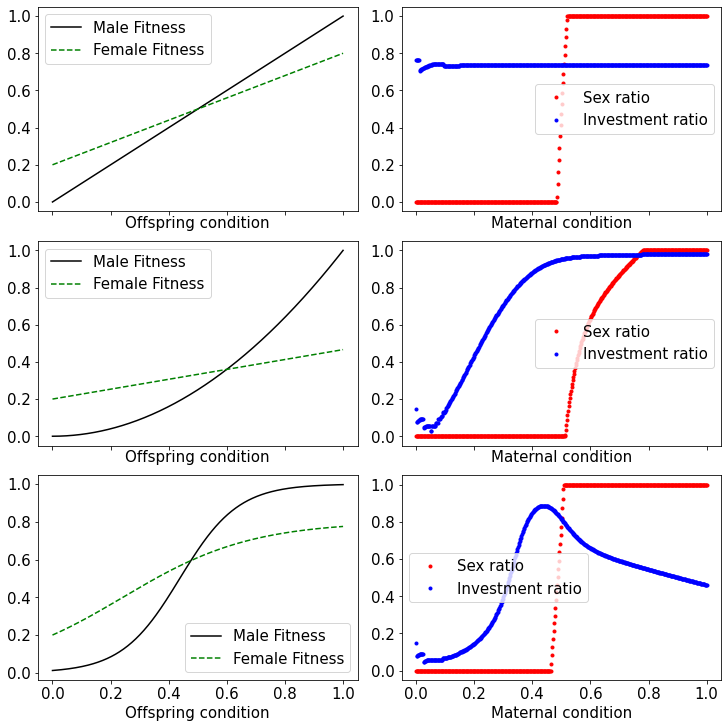

In [22]:
plt.rcParams.update({'font.size': 15})
fig1, axs = plt.subplots(3, 2, constrained_layout=True,sharex=True, figsize=(10,10))

axs[0, 0].plot(cms,malefits_L,'k-',label='Male Fitness')
axs[0, 0].plot(cms,femalefits_L,'g--',label='Female Fitness')
axs[0,0].legend()
#axs[0, 0].title.set_text('Linear Fitness')
axs[0, 0].set_xlabel('Offspring condition')
axs[0, 1].plot(cms,alphas_L,'r.',label='Sex ratio')
axs[0, 1].plot(cms,invs_in_male_L,'b.', label='Investment ratio')
#axs[0, 1].title.set_text('SR holds, INV does not')
axs[0,1].legend()
axs[0, 1].set_xlabel('Maternal condition')


axs[1, 0].plot(cms,malefits_X,'k-',label='Male Fitness')
axs[1, 0].plot(cms,femalefits_X,'g--',label='Female Fitness')
axs[1,0].legend()
#axs[1, 0].title.set_text('Convex Fitness')
axs[1, 0].set_xlabel('Offspring condition')
axs[1, 1].plot(cms,alphas_X,'r.',label='Sex ratio')
axs[1, 1].plot(cms,invs_in_male_X,'b.', label='Investment ratio')
#axs[1, 1].title.set_text('SR holds, INV does not')
axs[1,1].legend()
axs[1, 1].set_xlabel('Maternal condition')


axs[2, 0].plot(cms,malefits_G,'k-',label='Male Fitness')
axs[2, 0].plot(cms,femalefits_G,'g--',label='Female Fitness')
axs[2,0].legend()
#axs[2, 0].title.set_text('Linear Fitness')
axs[2, 0].set_xlabel('Offspring condition')
axs[2, 1].plot(cms,alphas_G,'r.',label='Sex ratio')
axs[2, 1].plot(cms,invs_in_male_G,'b.', label='Investment ratio')
#axs[2, 1].title.set_text('SR holds, INV does not')
axs[2,1].legend()
axs[2, 1].set_xlabel('Maternal condition')
plt.show()
fig1.savefig("High resoltion.png",dpi=300)

In [23]:
np.linspace(0.1234,0.9765,10)

array([0.1234    , 0.21818889, 0.31297778, 0.40776667, 0.50255556,
       0.59734444, 0.69213333, 0.78692222, 0.88171111, 0.9765    ])

In [24]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

N=1000 #number of conditions
mu=0.5
sigma=0.1
cms=np.random.normal(mu,sigma,N)

# different fitness figure
kappa=0.5
phi=0.2
p=0.1

P=[(0.6,0.3,0.1),(3*p/4,1-p,p/4),(0.1,0.4,0.5)]

transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)

pi=stationary

# if current is 0
ct=0
f_vals_cb=[]
FRs_cb=[]
F0_cb=[]
x_b=[]



for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    x=results[3]
    x_b.append(x)
    f_vals_cb.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cb.append(random_fitness(c_m,nt,phi,kappa))

ct=1
f_vals_cn=[]
FRs_cn=[]
F0_cn=[]
x_n=[]

for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    x=results[3]
    x_n.append(x)
    f_vals_cn.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cn.append(random_fitness(c_m,nt,phi,kappa))

    
ct=2
f_vals_cw=[]
FRs_cw=[]
F0_cw=[]
x_w=[]
for i in np.arange(len(cms)):
    c_m=cms[i] 
    results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
    i_star_ma=results[0]
    i_star_fe=results[1]
    i_star_mi=results[2]
    x=results[3]
    x_w.append(x)
    f_vals_cw.append(results[4])
    nt=states_chain.next_state(current_state=ct)
    
    FRs_cw.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))
    
    F0_cw.append(random_fitness(c_m,nt,phi,kappa))

    
Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))

KeyboardInterrupt: 

In [ ]:
plt.plot(cms,f_vals_cb,'b.',cms,f_vals_cn,'g.',cms,f_vals_cw,'r.')
plt.show()
plt.plot(cms,x_b,'b.',cms,x_n,'g.',cms,x_w,'r.')
plt.show()
plt.plot(cms,FRs_cb,'b.',cms,FRs_cn,'g.',cms,FRs_cw,'r.')
plt.show()

plt.plot(cms,F0_cb,'b.',cms,F0_cn,'g.',cms,F0_cw,'r.')
plt.show()

plt.plot(cms,Difference,'.')
plt.show()
#print(cms,np.mean(Differenc
plt.hist(Difference)
print(pi)

In [ ]:

#bounds_inv = Bounds([0, investment(c_m)])
x_0_inv=0.5
x_0_sr = 0

print(optimal_Basic(c_m,x_0_inv,x_0_sr))
P=[(0.4,0.3,0.1),(0.2,0.6,0.2),(0.1,0.3,0.4)]
ct=1

phi=0.2
nt=2
phi=0.2
kappa=0.10


i_star_ma=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[0]
i_star_fe=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[1]
i_star_mi=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[2]
x=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[3]
fval=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)[-1]

FR=realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa)

F0=random_fitness(c_m,nt,phi,kappa)
print('Expected fitness',fval)
print('Realized fitness',FR)
print('Random fitness',F0)



K=10
ps=np.linspace(0,1,K)
ks=np.linspace(0,0.5,K)
pihs=np.linspace*0,0.5,K)
## GET MARKOV THINGS READY




P=[(0.5,0.4,0.1),(0.1,0.8,0.1),(0.1,0.4,0.5)]
transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)


#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
Q=np.asarray(P)
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
print(stationary)


In [248]:
N=500 #number of conditions
mu=0.5
sigma=0.3
cms=np.linspace(0,1,N)



N=1000 #number of conditions
mu=0.5
sigma=0.1
cms=np.random.normal(mu,sigma,N)



# different fitness figure
kappa=0.5
phi=0.2
p=0.1




# different fitness figure
K=10
kappas=np.linspace(0,0.6,K)
phis=np.linspace(0,0.3,K)
ps=np.linspace(0.2,0.4,3)

p=ps[0]


P=[(0.6,0.3,0.1),(3*p/4,1-p,p/4),(0.1,0.4,0.5)]



Delta212=np.zeros((K,K))


transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)

pi=stationary

for k in np.arange(K):
    kappa=kappas[k]
    for j in np.arange(K):
        phi=phis[j]
        
        ct=0
        f_vals_cb=[]
        FRs_cb=[]
        F0_cb=[]
        x_b=[]



        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_b.append(x)
            f_vals_cb.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cb.append(random_fitness(c_m,nt,phi,kappa))

        ct=1
        f_vals_cn=[]
        FRs_cn=[]
        F0_cn=[]
        x_n=[]

        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_n.append(x)
            f_vals_cn.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cn.append(random_fitness(c_m,nt,phi,kappa))


        ct=2
        f_vals_cw=[]
        FRs_cw=[]
        F0_cw=[]
        x_w=[]
        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_w.append(x)
            f_vals_cw.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cw.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cw.append(random_fitness(c_m,nt,phi,kappa))


        Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))
        
        print(Difference)
        
        Delta212[k,j]=np.mean(Difference)
        # if current is 0

        
p=ps[1]



P=[(0.6,0.3,0.1),(3*p/4,1-p,p/4),(0.1,0.4,0.5)]

      
Delta222=np.zeros((K,K))


transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)

pi=stationary

for k in np.arange(K):
    kappa=kappas[k]
    for j in np.arange(K):
        phi=phis[j]
        
        ct=0
        f_vals_cb=[]
        FRs_cb=[]
        F0_cb=[]
        x_b=[]



        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_b.append(x)
            f_vals_cb.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cb.append(random_fitness(c_m,nt,phi,kappa))

        ct=1
        f_vals_cn=[]
        FRs_cn=[]
        F0_cn=[]
        x_n=[]

        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_n.append(x)
            f_vals_cn.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cn.append(random_fitness(c_m,nt,phi,kappa))


        ct=2
        f_vals_cw=[]
        FRs_cw=[]
        F0_cw=[]
        x_w=[]
        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_w.append(x)
            f_vals_cw.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cw.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cw.append(random_fitness(c_m,nt,phi,kappa))


        Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))
        
        print(Difference)
        
        Delta222[k,j]=np.mean(Difference)

        
        
p=ps[2]


P=[(0.6,0.3,0.1),(3*p/4,1-p,p/4),(0.1,0.4,0.5)]

        
Delta232=np.zeros((K,K))

transition_matrix=np.asarray(P)
transition_matrix
states_chain=MarkovChain(transition_matrix=transition_matrix, states=[0,1,2])
states_chain.next_state(current_state=1)
states_chain.generate_states(current_state=0,no=10)

pi=stationary

for k in np.arange(K):
    kappa=kappas[k]
    for j in np.arange(K):
        phi=phis[j]
        
        ct=0
        f_vals_cb=[]
        FRs_cb=[]
        F0_cb=[]
        x_b=[]



        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_b.append(x)
            f_vals_cb.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cb.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cb.append(random_fitness(c_m,nt,phi,kappa))

        ct=1
        f_vals_cn=[]
        FRs_cn=[]
        F0_cn=[]
        x_n=[]

        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_n.append(x)
            f_vals_cn.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cn.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cn.append(random_fitness(c_m,nt,phi,kappa))


        ct=2
        f_vals_cw=[]
        FRs_cw=[]
        F0_cw=[]
        x_w=[]
        for i in np.arange(len(cms)):
            c_m=cms[i] 
            results=optimal_Unc(c_m,P,ct,phi,x_0_inv,x_0_sr)
            i_star_ma=results[0]
            i_star_fe=results[1]
            i_star_mi=results[2]
            x=results[3]
            x_w.append(x)
            f_vals_cw.append(results[4])
            nt=states_chain.next_state(current_state=ct)

            FRs_cw.append(realized_fitness(x,i_star_ma, i_star_fe, i_star_mi,c_m,nt,phi,kappa))

            F0_cw.append(random_fitness(c_m,nt,phi,kappa))


        Difference=pi[0]*(np.asarray(FRs_cb)-np.asarray(F0_cb))+pi[1]*(np.asarray(FRs_cn)-np.asarray(F0_cn))+pi[2]*(np.asarray(FRs_cw)-np.asarray(F0_cw))
        
        print(Difference)
        
        Delta232[k,j]=np.mean(Difference)


[0.14811566 0.24179758 0.13527054 0.08175222 0.13887492 0.29542749
 0.21358455 0.08100005 0.16231694 0.11403789 0.20006039 0.28100124
 0.253529   0.28609534 0.06271885 0.16648713 0.03930202 0.21741612
 0.12271084 0.29674705 0.12589511 0.19870316 0.04152046 0.04743169
 0.21453586 0.24139384 0.17244103 0.13521775 0.21661368 0.19259526
 0.14564433 0.1470132  0.04640854 0.07262396 0.32027499 0.18208478
 0.08539437 0.0716853  0.20045073 0.05104203 0.13786697 0.06542643
 0.0624454  0.06743115 0.13550231 0.08398802 0.10129751 0.11457908
 0.04737253 0.11291699 0.17215906 0.06219133 0.04883545 0.14584328
 0.04166813 0.17446913 0.0454017  0.13810622 0.04879096 0.2272084
 0.31047843 0.06396303 0.06616922 0.07676862 0.09593119 0.06411453
 0.11210903 0.09303243 0.29809426 0.15378486 0.37724382 0.06494516
 0.10234502 0.15746019 0.20565851 0.31013828 0.07762611 0.29665747
 0.27312725 0.38620851 0.04813214 0.1160683  0.05033279 0.11411684
 0.04908252 0.11560175 0.15107357 0.31859119 0.05247223 0.14446

[0.15424724 0.20535383 0.27816928 0.06768966 0.26558132 0.04803455
 0.24900333 0.15060546 0.19423919 0.05055498 0.09909723 0.07543873
 0.09866529 0.08044454 0.06271806 0.06393587 0.13391358 0.03574524
 0.12127557 0.16249319 0.115044   0.16740593 0.07094845 0.19846715
 0.22301767 0.15154625 0.23502649 0.15831352 0.1131181  0.32556133
 0.15464573 0.07349489 0.11443401 0.06961342 0.11264269 0.38505746
 0.15639179 0.13762189 0.04892842 0.0479498  0.17754563 0.11259523
 0.04423816 0.15076721 0.09437039 0.15074416 0.16288204 0.08118262
 0.05947138 0.10314774 0.08408604 0.13301236 0.04379487 0.07597427
 0.04226315 0.20404545 0.12185646 0.05029375 0.17027303 0.07184919
 0.2346885  0.13610379 0.06741845 0.04839132 0.06453051 0.03962755
 0.12203077 0.09006542 0.33068604 0.266602   0.20317172 0.13240504
 0.20103655 0.17170426 0.17097265 0.32719227 0.12938052 0.19978006
 0.29348024 0.21078353 0.07135169 0.06575744 0.05480274 0.18713313
 0.11740542 0.13143276 0.09720978 0.37628196 0.05933187 0.1234

[0.0795179  0.15898101 0.30286272 0.07477918 0.13296252 0.19490402
 0.28718716 0.07679841 0.20196434 0.06382724 0.09280892 0.2037687
 0.09430036 0.21410774 0.07188392 0.16426926 0.06176317 0.12297853
 0.21529343 0.14626908 0.29446927 0.18452019 0.041412   0.32420547
 0.20982128 0.29957597 0.04959991 0.08706302 0.30782178 0.22615255
 0.12542906 0.04971074 0.06412788 0.08099156 0.32027499 0.39155415
 0.10055629 0.04540665 0.37501184 0.04880037 0.32848939 0.16317259
 0.07417429 0.0507073  0.06694208 0.05488029 0.0421022  0.110122
 0.06495629 0.04663039 0.06179779 0.07594338 0.04141246 0.12282074
 0.05676117 0.15666169 0.05771698 0.06551696 0.24661732 0.18042871
 0.13030176 0.05668339 0.04102152 0.05723214 0.06657465 0.05062547
 0.30754054 0.06438273 0.17159259 0.26430831 0.20360008 0.11859058
 0.09873287 0.04176948 0.33364052 0.22554834 0.14944048 0.22092175
 0.05490887 0.21304965 0.07274005 0.13334805 0.16843052 0.34700972
 0.17239874 0.05625506 0.13067275 0.10408769 0.16855655 0.1968454

[ 1.36388425e-01  2.24250087e-01  2.82970906e-01  1.17456936e-01
  4.87184497e-02  1.67570322e-01  1.79872635e-01  1.27316679e-01
  7.32884539e-02  1.08813763e-01  9.84510736e-02  3.89399412e-01
  1.28728906e-01  2.06638684e-01  5.66183960e-02  1.81710498e-01
  4.02932912e-02  3.46340703e-02  1.34265925e-01  9.86893682e-02
  1.64289811e-01  1.74283196e-01  1.46257939e-01  2.01580367e-01
  5.81355969e-02  1.77473379e-01  2.43173305e-01  2.42161294e-01
  1.47140978e-01  1.76178004e-01  1.59277304e-01  1.27798602e-01
  1.24485915e-01  4.28921464e-02  2.09714246e-01  2.48901480e-01
  1.45761691e-01  8.08685951e-02  2.09439953e-01  6.46240254e-02
  2.29915532e-01  1.27075813e-01  1.19901019e-01  7.99025477e-02
  5.06828719e-02  6.98400812e-02  1.43558054e-01  1.99974566e-01
  5.23314790e-02  1.07915589e-01  3.75831040e-02  9.64193202e-02
  5.31771485e-02  1.55508501e-01  6.19326832e-02  1.85350151e-01
  8.34245679e-02  3.89275711e-02  7.08862905e-02  1.86300404e-01
  2.65706744e-01  7.70235

[ 0.04904818  0.17856084  0.13527054  0.03056842  0.19558236  0.30136243
  0.35680066  0.19861704  0.15041736  0.02576147  0.10173842  0.0814832
  0.11624926  0.26001663  0.13780319  0.18657045  0.06572759  0.10647874
  0.2291657   0.291225    0.13616573  0.20713211  0.13620649  0.1835867
  0.08357216  0.04874793  0.26706558  0.10067112  0.13446319  0.3107937
  0.10596578  0.07296141  0.06265055  0.06743894  0.23640862  0.14760373
  0.15933752  0.13056985  0.34586393  0.12989742  0.28680644  0.16051416
  0.14168171 -0.00157976  0.06856149  0.129906    0.16173847  0.1246883
  0.03207749  0.07792773 -0.01447336  0.19087285  0.05538848  0.05809917
  0.12766376  0.22780906  0.08080662  0.0385063   0.13134693  0.03445513
  0.06488447  0.14441501  0.17347798  0.1315578   0.09909644  0.02734124
  0.20794924  0.1004338   0.27355765  0.2651967   0.21489816  0.04462599
  0.09641909  0.12822975  0.12385353  0.22163372  0.23878486  0.25890807
  0.1091524   0.31808242  0.09180877  0.03839456  0.117

[ 0.05960242  0.19791141  0.1607152   0.07662994  0.26319324  0.23250577
  0.28409776  0.03817431  0.06082138  0.01158087  0.10549429  0.21368166
  0.08934754  0.17897328  0.10967748  0.18390724  0.06088124  0.21775183
  0.22717809  0.09393154  0.02979742  0.33667078  0.19189051  0.01725921
  0.12381209  0.15955336  0.17244103  0.04885118  0.23595488  0.19503068
  0.1482418   0.07823561  0.0882067   0.12336157  0.37365141  0.04416059
  0.07974587  0.08839842  0.33650724  0.05960738  0.32007478  0.11919848
  0.11111661  0.05965269  0.08730138  0.22996875  0.05886293  0.12555223
  0.04653525  0.12210202  0.1534571   0.06373569  0.09915385  0.04726123
  0.07664485  0.22484668  0.06882119  0.04334895  0.15265107  0.09338596
  0.25580264  0.0513134   0.13569029  0.07623966  0.0688543   0.04975566
  0.08939995  0.07210408  0.22133269  0.29604475  0.08527554  0.10922132
  0.09219868  0.06073913  0.05574011  0.11898376  0.063083    0.04795442
  0.09495648  0.30447863  0.07360423  0.02309531  0

[ 1.28302163e-01  2.97048292e-01  3.23753120e-01  6.20467291e-02
  2.54905134e-01  3.37420129e-01  2.00251213e-01  4.69645554e-02
  3.21526964e-01  4.17545764e-01  4.72035289e-02  1.57972549e-01
 -2.47065580e-03  2.32092582e-01  1.11126973e-01  1.30426908e-01
  7.99659382e-02 -3.46186958e-02  1.46085385e-01  3.44570906e-01
  2.25047541e-01  1.98703158e-01  1.68679476e-01  2.07499554e-01
  6.40564733e-02  1.54903749e-01  2.92396399e-01  2.33827709e-01
  2.64085745e-01  3.06181113e-01  1.23372875e-01  1.18304829e-01
  7.87039764e-02  3.42636592e-02  1.98450889e-01  2.16565823e-01
  5.95499746e-02 -1.80018680e-02  1.87117392e-01  5.66482317e-02
  1.87155863e-01  1.59122735e-01  6.04839892e-02  1.98485283e-01
  9.51580865e-02  8.92396212e-02  8.18216388e-02  7.28518268e-02
  3.25466632e-02  1.43084470e-01  6.02259945e-02  4.15261759e-02
  9.08848585e-02 -3.26102637e-04  2.69010780e-02  4.86175898e-02
  8.30967126e-02  5.87116973e-02  3.29739375e-01  9.97793222e-02
  2.73504700e-02  5.13135

[ 2.12036392e-01  2.50895327e-01  1.75329526e-01  1.53014913e-01
  2.92432168e-01  1.53336857e-01  1.61781441e-01  2.07874969e-01
  7.38297733e-02  2.88279051e-01  1.18434010e-01  3.17914234e-01
  3.84477462e-03  6.22501913e-02  1.25083175e-01  5.93029396e-01
  3.26666015e-03  8.94350112e-02  1.26639207e-01  1.84543981e-01
  1.34843815e-01  3.34753843e-01  6.12692855e-02  3.03418448e-01
  1.21697068e-01  1.49883772e-01  1.60837432e-01  3.26875732e-02
  2.34728886e-01  9.96420081e-02  2.81846001e-01  2.97533855e-02
  2.12239751e-01  1.27656221e-01  1.97358294e-01  3.77847234e-01
  1.11197126e-01  1.56168712e-01  1.57861046e-01  3.92139292e-02
  1.49814576e-01  1.97446537e-01 -1.71844339e-02  1.46184477e-01
  8.81367985e-02 -7.89255822e-02  1.50714509e-01  5.59022266e-02
  6.09892206e-02  9.39088686e-02  8.71263749e-02  3.43694215e-02
  1.00434543e-01  6.70391452e-02  1.13965419e-01  5.95343482e-02
  1.44089329e-01  8.75437370e-02  3.79731385e-02  1.86271086e-01
  1.14270332e-01  7.39890

[ 2.26963033e-01  1.83466961e-01  3.45396864e-01  1.21225283e-01
  2.54905134e-01  8.02349346e-02  5.65797700e-02  8.05314272e-02
  8.12463357e-02  8.03613299e-02  1.61076489e-01  4.52723196e-02
  1.22872713e-01  7.77639586e-02  1.83610176e-01  1.40072287e-01
  1.40214202e-01  1.42732424e-01  4.15705496e-02 -6.03584447e-02
  2.45476496e-01  1.54655149e-01  1.59993135e-01  3.09887225e-01
 -3.45735213e-02  8.23878845e-02  2.05276902e-01  3.05455481e-01
  1.68739594e-01  1.63298179e-01  1.14099671e-01  7.40313906e-02
  1.02640141e-01  8.15773274e-02  2.13047579e-01  2.48255496e-01
  1.15271664e-01  5.51551288e-02  6.82091886e-02  1.18777449e-01
  1.16573346e-01  6.82644617e-02  8.13760982e-03  6.50666196e-02
  1.20134026e-01  1.06090945e-01  1.75073957e-01  1.26868064e-01
  1.87131154e-01  3.31787527e-02  6.18222508e-02  1.43844350e-01
  6.31428118e-02  1.19956268e-01  2.87604771e-02  1.39551152e-01
  2.18474114e-01  1.29418444e-01  3.13123362e-01  2.66234248e-01
  9.60377704e-02  3.39528

[ 2.89930986e-01  1.45312326e-01  2.66209064e-01  2.65092060e-02
  1.45149639e-01  1.91195810e-01  1.84315509e-02  1.11750783e-01
  1.27209547e-01  5.43367120e-02  7.42167312e-03  2.08963801e-01
 -3.51223342e-02  2.86095345e-01  1.51727693e-01  1.70178821e-02
  8.60565565e-02  1.17479867e-01  1.71649196e-01  1.41417938e-01
  1.51345674e-01  1.29899452e-01  1.80149762e-03  2.10828640e-01
  2.55260523e-01  3.05541849e-01  1.53747221e-02  5.95639831e-02
 -5.75935631e-02  1.92595259e-01  7.17969974e-02  1.01571600e-01
  1.34074184e-01  1.55841920e-01  3.23853208e-01  1.82516765e-01
  2.36404094e-01  7.94106811e-02  1.39151749e-01  4.14789880e-02
  1.75271548e-01  2.25077379e-01  1.12418159e-01  7.15711802e-02
  6.37306106e-02  1.03890890e-01  6.43141580e-02  6.51790890e-02
  6.41754645e-02  7.13678844e-02 -4.64305743e-02  6.41146186e-02
  1.33290967e-01  2.23877977e-01  1.46340811e-01  2.36825141e-01
  7.43591874e-02 -2.72112764e-03  3.35780932e-01  1.73659486e-01
  2.57345513e-01 -1.27667

[ 5.63862548e-02  2.07381176e-01  3.91217468e-01  5.17697199e-02
  1.55232385e-01  3.89889641e-01  3.98772408e-01  9.52915835e-02
  1.80878973e-01  3.30248199e-01  1.91032256e-01  4.53853239e-02
  2.08639756e-01  2.57592520e-01 -2.08701499e-02 -4.95825169e-02
  6.08234643e-02  5.01171254e-02  1.55728179e-01  2.45347898e-01
  1.29630568e-01  5.95665003e-02 -2.74488363e-04  4.97922176e-02
  1.12717556e-01  4.81061242e-01  1.18915360e-01  6.56477263e-02
  3.10116428e-01  3.76144923e-01  3.31322225e-01  1.11322491e-01
  3.78467331e-02  2.26112107e-01  2.93822448e-01  2.74772849e-01
  1.96835859e-01  1.05897773e-01  1.30503240e-01  8.82631871e-02
  1.77889952e-01  8.06205342e-02  2.11069457e-01 -3.51708560e-02
  6.68948501e-02  8.48145494e-02  7.13329830e-02  1.52125909e-01
  1.05448705e-01  5.15544443e-02  5.42462172e-02  9.52939216e-02
  1.85341341e-01  1.29285987e-01 -6.38121182e-02  1.01051285e-01
  2.69934991e-02 -6.51360281e-02  1.87233879e-01  8.00219932e-02
  2.14124607e-01  7.03455

[ 1.07755183e-01  2.40484105e-01 -4.16821039e-02  1.23964587e-01
  6.52520896e-02  2.66480238e-01  1.86631944e-01  8.88408989e-03
  1.39910537e-01  5.78687875e-02  1.35744669e-01  2.85371605e-01
  5.85379851e-02  2.03852206e-01  2.61934735e-01  5.44989587e-02
  5.50366192e-02  6.57036418e-02  1.40566068e-01  2.56006524e-01
  1.01514135e-01  1.70637767e-01  1.74688889e-01  2.94651444e-01
  6.29802737e-02  2.60493722e-01  2.92159711e-01  2.85656106e-02
  1.47658921e-01  4.06868547e-01  8.75437582e-02  1.51753835e-01
  3.13806687e-01  1.29465577e-01  3.11407552e-01  6.93764342e-02
  2.07668318e-01  1.51491731e-01  1.90095784e-01  7.83621699e-02
  2.93618639e-01  1.76539301e-01  1.97189892e-01  2.81679578e-02
 -1.14808083e-02  1.76507195e-01  4.16549707e-02 -3.83451279e-02
  3.40112605e-03  9.61195455e-02  1.30780836e-01 -8.81868456e-02
  6.02643028e-02  2.26964791e-01 -8.97650021e-03  1.39250971e-01
  1.54518309e-01  8.16800652e-02  1.16949650e-01  2.34129801e-01
  2.64925214e-01  5.17657

[ 2.32811943e-01  7.51692279e-02  6.59682497e-02  6.00428494e-02
  6.84029069e-02  3.26218060e-01  2.28503395e-01 -1.74555039e-01
  2.23321894e-01  3.75598272e-02  1.34515310e-01  1.03644322e-01
  1.24956372e-01  2.67418133e-01  2.07573750e-01  5.91434888e-02
 -5.76839775e-02  1.14403237e-01  1.64917723e-01  3.02919576e-01
  1.07129369e-01  1.52957561e-01 -5.54335407e-02  3.85436844e-02
  5.55272949e-02  3.02034492e-01  3.17441216e-01  7.55170603e-02
  3.56796671e-01  1.96972946e-01  3.72610816e-02  1.41609561e-01
  1.62416491e-01  5.18029629e-02  5.14617931e-02  3.79696092e-01
  2.81336819e-01  6.88482673e-03  1.33482545e-01  2.91038533e-02
  1.43717675e-01  1.15107543e-01  1.84470837e-01  3.67509656e-01
  2.05688141e-01  1.36272098e-01  2.23840521e-01  2.22323523e-01
 -1.30571684e-01 -3.01755517e-02 -5.04325280e-02  9.72192410e-02
 -2.67612839e-03  1.69106116e-01  5.98294982e-02  2.20251898e-01
  3.16434267e-02  2.82968661e-02  2.02543515e-01  2.48082296e-01
  1.96308108e-01  1.00784

[ 1.26188008e-01  1.48308132e-01 -1.33026683e-02  1.30416365e-03
  1.85551828e-01  2.41404014e-01  4.35525375e-01  6.06758093e-02
  1.38168516e-01  1.85488618e-01 -9.86706108e-04  9.08247362e-02
  1.01709945e-01  3.85245513e-01  1.15862472e-01  1.57758924e-01
  2.98768793e-01 -4.83511538e-02  2.34751805e-01  3.22210184e-01
  1.24275108e-01  7.40415504e-03  6.42106342e-02  3.47503391e-01
 -1.29039806e-02  2.35271187e-01  3.02798680e-01  1.07450111e-01
  2.69105851e-01  3.56650047e-01  4.66228472e-01  6.12834770e-02
  2.97833806e-02  6.50513258e-02  3.63777665e-01  2.86373943e-01
 -9.31855346e-02  3.15506466e-02  1.82763541e-01  1.08958542e-01
  2.29406106e-02  1.61508169e-01  8.67757604e-03  1.64568301e-02
  9.97901769e-02  6.42320377e-02  4.37332224e-02  7.04992241e-02
  3.57574021e-01 -4.60058282e-02  1.28100534e-01  1.51961034e-01
  1.50841135e-02  3.38332613e-01  3.01798758e-03  8.25134439e-02
 -4.53805190e-02  2.21944054e-01  2.55367450e-01  1.67051921e-01
  1.23949432e-01  9.64963

[ 1.17820028e-01  1.85949084e-01  3.36024573e-01  3.50296597e-02
  1.08788394e-02  4.60917288e-01  4.08982521e-01  1.31233542e-02
  1.04755318e-01  2.24814563e-02  5.87634341e-02  3.34747274e-01
  3.11415793e-01  2.25429608e-01  3.77300538e-02  1.32676760e-01
 -4.74539932e-02  3.42255642e-01 -2.33722877e-01  9.13398069e-02
  1.09392955e-01  5.63439017e-02 -1.96166095e-01  2.65305145e-01
  1.44146156e-02  1.46303199e-01  9.05708355e-02  1.24127793e-02
  1.63384342e-01  1.18792734e-01  4.20454472e-01  9.48312529e-02
 -2.24766801e-02 -1.00314811e-01  1.24881846e-01  4.34268163e-01
  2.65067303e-01  1.94498644e-02  1.30986379e-01  8.74798287e-02
  1.78484703e-01  3.94577914e-01  2.61781195e-01  3.00116844e-01
  1.03311603e-01  9.56612603e-02  5.56428806e-02  1.23904899e-01
  2.15584687e-01  2.87609326e-01  2.16230252e-01 -4.29162141e-02
 -1.34111034e-02  1.78393225e-01  1.32902591e-01  9.76906374e-02
  5.00726098e-02  1.55138018e-01  2.60136072e-02  1.23373179e-01
  1.80726585e-01  7.22724

[ 1.59255016e-01  1.23368793e-01 -3.32251882e-01  1.39287309e-01
  1.14114021e-01  2.63569936e-01  2.25794088e-01  1.50117284e-01
  3.82529266e-02  1.69247181e-01 -2.38291833e-01  2.69845551e-03
  1.11012903e-01  1.78840695e-01  5.25654443e-02  8.58284043e-02
 -3.52654236e-04  4.44033542e-02  4.02035219e-01  1.53748678e-01
  2.31783485e-01  2.31324141e-01 -4.01481991e-02  3.36157412e-01
  2.58581489e-01  1.42735010e-01  2.62371024e-01  2.88147584e-01
  1.24994077e-01  3.39058676e-01  1.57624170e-01  4.77705320e-02
  6.73235048e-02  7.04927645e-02  2.56062240e-01  1.07603793e-01
  1.81364733e-01  7.56094843e-02  1.53081038e-01  1.22559708e-01
  2.78005252e-01  3.60231791e-01  1.98189397e-01 -1.80393342e-01
  2.26197269e-01  1.29571329e-01 -1.92272270e-02  2.12453877e-01
  3.23013381e-02  1.20170243e-01  6.48611069e-02  1.35434436e-01
  2.45359534e-01  1.99780727e-01  2.05083672e-01  2.83079588e-01
  2.45137535e-01  8.39849715e-02  2.51980626e-01  1.09011990e-01
  1.13396586e-01  9.20336

[ 9.54768067e-02  3.17738467e-01  6.74353100e-03 -6.49761746e-02
  1.58298543e-01  4.22521845e-01  1.43396000e-01 -1.11176174e-01
  1.29233686e-01  1.45221714e-01  6.33129552e-04  1.03746917e-01
  1.01641536e-01  2.26288306e-01  3.77049166e-01  2.63197153e-01
  1.03713829e-01  1.65655487e-01  8.86603050e-02  1.07957484e-01
  1.60548041e-02  3.12872604e-01  8.75115898e-02  5.72133298e-02
  8.62731327e-02  2.08762799e-02  6.97622436e-02  1.78687277e-01
  9.33960448e-02  1.93564964e-01  2.08459902e-01  1.17850816e-01
  1.95339542e-01  5.98716805e-02  1.91175397e-01  7.04794181e-02
 -1.29682030e-03  1.35815602e-01  3.67882391e-01 -3.76917693e-02
  1.37941162e-01  3.76984583e-01  3.85633776e-03  2.83631826e-01
 -6.61117526e-03  4.99404230e-02 -9.12325992e-02  3.35850772e-02
  1.45844408e-01  1.79495888e-01 -1.37338234e-01 -6.64762003e-02
  2.35551917e-01  1.42333121e-02  9.03844866e-02  2.55746749e-01
  2.05087295e-01  1.59898010e-02  2.54238317e-01  1.03812517e-01
  1.17875822e-01 -4.30169

[ 8.68529166e-02  1.58386263e-01  2.44216687e-01 -4.38167072e-02
  1.91858433e-01  3.97008246e-01  2.53031203e-01  8.55457113e-02
  2.55584896e-01  6.10982307e-01  1.12966254e-01  1.26528910e-02
  3.02361001e-02  7.08665007e-02  1.31641026e-02  3.48198240e-01
 -4.73662260e-02  2.31091646e-01  4.67414950e-01  2.95720737e-01
  1.11378016e-02  2.45449640e-01  2.65558713e-01  1.51908972e-01
  3.96410811e-02  1.22526007e-01  7.87655911e-02  2.81905439e-01
  3.07018917e-01  1.24162296e-01  3.14966845e-01  6.03912707e-02
  2.42420705e-01  1.67037421e-01  2.49996977e-01  6.56678259e-02
 -8.55806755e-02  2.62961838e-02  8.44661223e-02  3.87403369e-01
  1.61333383e-01  2.40267432e-01  2.60251602e-01  1.27303055e-01
 -1.20799926e-01  5.57102693e-02  9.72436090e-02  4.22238581e-02
  1.24684661e-01  2.39837066e-01  7.81273025e-03  1.26177914e-01
  1.88409781e-02  1.84835389e-01  6.63090170e-02  2.93512061e-01
 -6.28152869e-02  8.38574498e-02  1.33386748e-01  1.87048457e-01
  4.83744866e-02 -1.52127

[ 7.28386459e-02  1.49456413e-01 -9.40532800e-02  5.23354076e-02
  1.35473267e-01  8.23352409e-02  2.22608112e-01  4.91858151e-01
  2.12198118e-01  4.49010448e-03  1.43737649e-01  4.13871974e-01
  1.18484912e-01  3.21002189e-02  2.28449460e-01  1.11085237e-01
  2.93500580e-01  2.98305683e-01  1.18196025e-01  2.22244380e-01
  2.90095352e-01  2.44175276e-01  3.30874711e-01  3.44856133e-01
  1.34940372e-01  1.34900568e-01  2.67691186e-01  2.98645717e-01
  1.79101105e-01  5.64434743e-02  5.27458604e-01  9.29800558e-03
  2.11505034e-01  6.33575026e-02  1.17707024e-01  3.06432743e-01
  3.17295704e-01  1.09900920e-01  3.01776158e-01 -5.31299624e-02
  7.90308885e-02  2.84463364e-02  6.76835497e-02  2.03630901e-01
  3.83167065e-02  1.24325585e-01  8.50257276e-02  3.45143048e-03
  3.86601395e-02  9.10140970e-02  1.02245686e-01  2.07787947e-01
  1.24826227e-02 -2.18154477e-02  5.49475491e-02 -8.86872907e-02
  7.15183352e-03  1.00806815e-01  1.30546723e-01  6.93789953e-02
 -5.09612566e-03  1.01280

[ 1.15684919e-01  3.96194363e-01  1.39188022e-01  9.34690107e-02
  2.55683430e-02  1.96370122e-01  3.43152141e-01 -1.68849129e-01
  1.38137756e-01  7.00427391e-02 -1.75795237e-01  4.21545216e-02
  7.38024124e-02  1.73132217e-01  1.01978511e-01  1.28011671e-01
  3.51608302e-02  2.05732614e-01  4.51961791e-02  1.90858614e-01
  1.62794452e-01  1.27797377e-01  2.93237875e-02  1.33122776e-01
  2.51547639e-01  1.23514472e-01 -1.07861925e-04  1.09269736e-01
  1.31919186e-01  8.37030689e-02  2.27071726e-01 -1.81887410e-01
  5.16924483e-02  4.46828900e-01  6.33420590e-02  1.42628465e-01
  3.24741044e-01  3.95783320e-01  2.12464877e-01 -1.38887517e-01
  3.97626626e-01  1.20356968e-01  7.84975367e-02  1.05477297e-01
  5.68316431e-01  5.42429233e-03 -6.64755012e-02  3.85693687e-02
 -6.37153268e-02  1.53047322e-01  1.22724516e-01  2.44490048e-01
 -5.41922204e-03  1.09473570e-01  3.02558866e-01  2.59841991e-01
 -1.00221644e-01  1.74543585e-01  1.99410980e-01  1.33411798e-01
 -2.97722271e-02 -4.46859

[ 2.92337820e-01  2.81689359e-01 -1.04213110e-01 -3.95990704e-02
  1.03371553e-01  1.89601900e-01  2.04250290e-01 -2.84838987e-01
  2.14076291e-01  1.40421956e-01  1.34819353e-01  3.29583026e-01
 -8.12551570e-02  9.59234153e-02 -1.53990545e-02  3.02309906e-02
 -2.79062483e-01  4.48596141e-02  2.07852961e-01  1.63441918e-01
  5.87793531e-02  1.53902141e-01  2.07131534e-01  3.45501231e-01
  1.15974370e-01  2.93393650e-01  2.37751868e-01  4.31253626e-02
  2.72963160e-01  3.31224500e-01  2.14104296e-01 -9.90001191e-02
  2.76552778e-01  1.12263041e-01  2.43002703e-01  2.12245109e-02
 -2.37823973e-02  1.80341208e-02  4.15362140e-01 -1.97677099e-02
  2.81468797e-01  1.39332701e-01 -2.01894703e-02  6.04192922e-02
  4.22492354e-02  5.32152814e-02  2.15398689e-01  2.18277651e-01
  5.05994662e-02 -4.30848556e-01  9.59115742e-02 -1.45290770e-01
 -4.57091813e-02  6.98805898e-02 -6.11807584e-02  7.14366965e-02
 -7.46955148e-02  1.20856361e-01  1.65061779e-01  9.57906875e-02
  1.67591758e-01 -4.13631

[ 1.31249401e-01 -2.18360988e-02  2.07323955e-01 -1.21297298e-01
  2.41827297e-01  2.43571774e-01  1.03453495e-01  4.66547096e-01
  1.79237583e-01  1.27786915e-02  2.01540909e-01  1.39938157e-01
 -1.31090802e-02  3.64009830e-01  1.39912406e-02  2.19258597e-01
  2.03701999e-01  3.69800791e-01  6.19272642e-02 -5.77651136e-02
  9.03384217e-04  2.28846366e-01  9.40408605e-02 -1.33698922e-01
  1.04642216e-01  1.24758902e-01  2.45473506e-01  3.48265029e-01
  8.31057969e-02 -5.44952679e-02  1.16028255e-01  1.05212201e-01
  3.19898419e-02 -1.29665128e-01  1.81863281e-01  5.05870563e-02
  2.43205660e-01 -1.15389726e-01  1.18654830e-01  1.77789460e-01
  4.86290059e-02  5.91944005e-02 -2.73483944e-01  1.29432368e-01
  1.80372164e-01 -7.44998816e-02  1.22338738e-01 -7.07439017e-02
 -5.50131977e-02  9.00818048e-02  3.85666326e-02  1.18004376e-01
 -1.30162753e-01  1.61506247e-01  2.19829664e-01  1.10626580e-01
  5.47858437e-01  8.88881919e-02  2.42378065e-01  2.45715632e-01
 -4.10183219e-06 -1.58470

[-2.85536424e-02  2.24919780e-01  5.65176133e-03  5.37662368e-01
 -6.35335620e-03  1.30145175e-01  2.86987966e-02  2.19294006e-01
  6.59113406e-02  2.41821331e-01  2.73635886e-02  2.32386850e-01
  2.63809009e-01  3.86191677e-01 -4.41980732e-03  1.07812583e-01
  3.94729714e-01 -6.94640460e-02  3.46054609e-01 -1.66268212e-01
  1.38009822e-01  3.20350887e-01  2.92765899e-01  1.85307060e-01
  2.34657356e-01  2.53864644e-01  1.83197853e-01  2.21040432e-01
  1.66242871e-01  4.64608083e-01  1.51726728e-01  4.55630435e-02
 -3.14899900e-02 -9.07476616e-03  2.10039150e-01  3.55648785e-01
  1.66849383e-01  5.93179786e-02  1.11563722e-01  1.34716096e-01
  1.23036825e-01 -1.09349477e-01 -8.81533714e-03  2.26719990e-01
  3.60658318e-01  1.04933609e-01 -3.77005255e-02 -3.93142128e-02
  1.34896931e-01  3.14745582e-01  6.37049397e-02  2.73198182e-01
  8.72406321e-02  2.39030571e-01  4.71996823e-02  1.34885462e-01
  3.97666380e-01  1.29252788e-02  4.44159830e-01 -1.87403893e-01
  8.74265614e-02 -1.34480

[ 8.28662287e-03  2.76416295e-01  1.24075881e-01  1.39571965e-01
  3.37558969e-01  2.53979101e-02  2.83480641e-01  6.66524915e-02
  1.13457710e-01 -4.98276727e-01 -1.62343135e-01  4.47152354e-01
  8.36400880e-02  4.01736048e-01  2.18386744e-01  5.62482514e-01
  5.28026177e-02  2.96209783e-01  1.01596536e-01  3.06223089e-02
 -2.80807511e-02  2.86703692e-01 -5.68985899e-02  2.42975183e-01
  5.11985576e-02  1.84331742e-01  1.61641094e-01  3.47207058e-01
  9.52854808e-02  2.66888394e-01  6.55491380e-01 -1.75434824e-01
 -4.01293678e-02  1.41528019e-01  3.63603775e-02  2.94392679e-01
  4.47581353e-01 -6.55970337e-02  1.67318487e-01  1.34699179e-01
  8.71095597e-02  3.35124578e-01  2.52000265e-01 -6.39680709e-02
 -1.98729303e-01 -1.19530917e-02  2.03177661e-01 -4.59369267e-03
  3.48742961e-01 -1.95338234e-01  2.76132052e-01  4.80960701e-02
 -3.47129667e-01 -1.95825066e-01  8.50135972e-02  2.26573443e-01
 -1.01695465e-01 -3.24525158e-01  1.50767777e-01  1.92247505e-01
  8.19618540e-02 -7.09697

[ 2.32399178e-01  3.12648309e-01  1.19358529e+00 -7.79970693e-02
  2.47749554e-01  2.78329072e-01  4.94296832e-01  8.73490921e-02
  1.91972204e-01 -1.41320345e-01  5.47843834e-02 -1.13196062e-02
  5.47577383e-02  3.51069502e-01  3.03206640e-01  1.79819358e-02
 -1.31019242e-01  1.15857695e-01  4.77217234e-01  1.89798050e-01
  2.95056226e-01  2.65305770e-01  6.48939369e-02  6.64057831e-02
 -5.73868962e-02  3.38962638e-02  3.82821978e-01  1.96593646e-01
  1.16562445e-01  1.70256302e-01 -7.52072501e-02  8.82485916e-02
  4.52047906e-01  1.21506945e-01  5.33384952e-02  1.96187627e-01
 -8.54505068e-02  1.13793251e-02  5.77240061e-02  8.65051450e-02
  5.66840854e-02 -3.43635708e-03 -1.13837974e-01  2.92900777e-01
  1.32722076e-02  3.50934730e-01  2.83598288e-01 -1.19211611e-01
  5.89273705e-02  1.32824404e-01  3.31637070e-01 -1.64205803e-02
  2.11693146e-01  1.35433506e-02  3.01153221e-01  2.29651306e-01
 -1.50591948e-02  1.28454125e-01  1.10954949e-01  2.35982348e-01
  3.90120241e-02 -1.92334

[ 1.57461620e-01  1.78186102e-01  1.27103558e-04 -2.01503251e-01
 -6.72117410e-02  3.18881795e-01  3.98515740e-01  2.64064330e-02
  5.75350113e-02  1.75381816e-03  5.71235228e-04  2.51994456e-01
  1.66972703e-01  9.43250646e-03  5.20187582e-01  2.03909087e-03
  5.06199891e-01 -7.20697747e-02 -1.53128063e-01  1.85726516e-01
  6.81260679e-02 -4.50777696e-02  7.97360003e-03  2.20075988e-01
  7.08316239e-03  1.99305989e-02  6.25994082e-02  3.70005169e-01
  2.01599110e-01  4.76925646e-03  2.44889313e-01  3.31216320e-02
 -2.16039525e-01  5.92522866e-01  1.90607487e-01  3.27151840e-01
 -3.94799614e-01 -3.37508740e-01  1.65993480e-01  1.14303042e-01
  8.92689125e-02  2.93161089e-01  2.85767925e-01  3.85917820e-01
  7.34395524e-02  1.04684028e-01  3.75776993e-02  4.76497997e-01
  1.09962613e-01 -1.87096231e-01 -3.00474886e-01 -3.03614862e-02
  1.82488465e-01 -5.47348839e-02 -1.57727040e-01  2.43282290e-01
 -7.46213719e-02  4.97720293e-01 -1.93625013e-02  3.25704449e-01
  1.45749322e-01 -2.57298

[ 4.25597158e-03  2.76784973e-01 -8.80093648e-02  2.00321558e-02
 -1.95172283e-01  2.09238316e-01  3.83953290e-01  3.50755195e-01
  3.08334244e-01  9.67704481e-02 -2.29339306e-01  2.01473942e-01
  8.88534826e-02  3.13892151e-01  5.04399944e-01  5.06921055e-01
  2.05306446e-01 -3.13852938e-02 -5.17865201e-02  4.49054825e-01
  9.57315909e-02  2.79571315e-01  3.23778789e-01  1.34053521e-01
  1.87969521e-01  4.40710055e-02  7.73651535e-02  2.00302354e-01
  8.72957160e-02  2.35270138e-01 -1.20427280e-01 -4.13234602e-02
 -1.00247293e-02  8.45333967e-02  3.11068311e-01  1.99746497e-01
 -1.27689911e-01 -9.63550390e-03  2.06684470e-01  4.18390627e-02
  2.89973115e-01 -1.27472649e-01 -4.28273313e-01  5.59225703e-02
 -7.79319559e-02 -4.00414511e-03  3.31071635e-02  8.34062273e-02
  3.19041026e-02  2.80848570e-02  3.72030537e-01  4.80128911e-01
  2.08331050e-01 -7.59684951e-02  6.38158766e-01  4.14135457e-02
  2.94336738e-01 -3.26362399e-01 -3.38607472e-02  3.99682968e-01
  1.89815224e-01  5.40518

[ 1.17387841e-01  8.74794243e-02 -4.75739073e-01 -6.47539202e-02
 -2.40015671e-01  1.64239019e-01  3.42392666e-01  3.07420065e-01
  1.26714707e-01 -2.87096288e-01  4.60641710e-01  7.17247287e-02
 -1.66228806e-01  2.76315280e-01 -2.98021902e-02  1.37400129e-01
 -4.27722375e-02 -1.72400422e-01 -3.32270157e-01  1.79744194e-01
  1.40231503e-01  1.30853918e-01 -2.50801615e-01  2.00095892e-01
  1.47005180e-01  2.50688563e-01  1.87502393e-01  2.09639108e-01
  2.84606973e-01 -1.36079617e-01  6.39781914e-02  3.19028334e-01
  1.60806164e-01 -4.68405744e-02  2.40341957e-01  4.14920806e-01
  1.59438592e-02  2.00120932e-01  7.72461836e-02  4.44209833e-01
  1.82759566e-01 -1.10480507e-01 -1.97348407e-01 -2.79909222e-01
  2.60791814e-01 -1.35380336e-01  4.67422749e-01  1.54977779e-01
  2.50793096e-01 -1.52197994e-02  3.67813097e-01  5.97607211e-02
  1.01111441e-01  3.37096720e-02 -3.64506175e-03 -1.79509187e-01
  3.02467313e-01  1.44543596e-02  2.97347336e-01 -9.97592628e-03
 -3.24462198e-02  4.20202

[ 1.43668264e-01  8.67710869e-02  6.69691646e-01  5.50607767e-01
  1.56142731e-01  2.65821301e-01  2.30975594e-01  8.09456688e-02
  4.61370255e-02  2.78180359e-01  3.46479890e-01  1.06849078e-01
  1.08235362e-01  2.55372051e-01  2.22769542e-01  4.36712342e-01
  3.05042013e-01  3.45624867e-01 -4.16602768e-01  2.61253787e-01
 -5.59289774e-02  2.71947566e-01  1.91489177e-01  3.99433846e-01
  3.99794221e-01 -2.18664539e-02  1.26247123e-01  2.15252652e-01
  2.23885597e-01 -2.66102883e-02  2.57873172e-01  2.27920009e-01
  3.30654637e-01  2.95892982e-01  2.70540530e-01  1.99212179e-02
 -8.29210390e-02 -1.40612917e-01  3.27564237e-02  2.63800973e-01
 -8.51416726e-04  7.70158567e-01 -9.14576538e-02 -4.87944264e-02
 -2.80622198e-02  8.75218915e-02  2.02291402e-01  5.37982566e-02
  4.26134210e-01  6.78741635e-01  4.48418120e-01 -1.35002548e-01
  1.08674396e-01  1.93123670e-01  5.84029459e-01  4.33496325e-01
 -1.52763706e-01 -4.65861028e-02  6.71989427e-02  6.45831380e-02
  1.05477728e-01 -3.44507

[ 1.98597969e-01  2.54090693e-01  1.03941089e+00  1.83031716e-01
  1.69816591e-02  2.71732915e-02  1.96962908e-01  6.79709622e-01
  3.75233775e-01  8.83114633e-01 -4.12397052e-01  1.52448033e-01
  1.44228058e-01  1.87208861e-01 -1.31784965e-01 -6.02044629e-02
  4.61781372e-01 -7.86003107e-02 -9.55394619e-02  1.95322076e-01
  3.72072497e-01  9.56689225e-02  2.27129153e-01  1.53846819e-01
  2.84199665e-01 -5.38864919e-02  2.11463508e-01  1.20543309e-01
  1.77656269e-02 -1.12148251e-01 -4.71334924e-02  8.05275472e-03
 -3.93507587e-01 -3.17869530e-02  4.49640658e-02  2.10043821e-01
  2.90082309e-01  4.08207033e-02  7.93204993e-02 -3.78457314e-02
  3.59379694e-01  1.01659349e+00  2.44679785e-02  1.97766207e-01
  1.99666571e-01  1.48276665e-01  2.03356700e-01  1.40287155e-01
  2.50780050e-02  1.46676883e-02  1.17442560e-01  7.81332980e-02
  3.61509183e-01  9.73665350e-02 -1.45674121e-01 -7.23309453e-02
  1.08148975e-01  4.71452156e-01  8.62566829e-02  2.64903539e-02
  8.94243811e-02  8.11860

[ 3.52113572e-01  1.39927249e-01 -7.92591648e-02  9.39744699e-02
  2.19408288e-01  1.85228345e-01  2.61770045e-01  8.77426576e-02
  3.48772385e-01  1.50840139e-01  6.00229911e-02  8.67803075e-02
 -8.11192730e-02  2.56613109e-01 -3.42109907e-01 -1.52947025e-01
 -2.39228294e-01  1.58543499e-01 -4.29367284e-02 -1.19455526e-01
  9.78088181e-02  2.82498265e-01  5.28408971e-01  8.64174929e-02
  3.03547941e-01  1.46094298e-01  2.45406113e-01  5.75750208e-02
  3.97797435e-02  2.55654483e-01 -3.71537238e-01 -9.15415073e-02
  5.55424868e-01  2.60861258e-01 -6.76291658e-02  4.69266706e-01
 -1.08130723e-01  2.87734776e-01  3.39457068e-01 -4.82370724e-01
 -3.36495889e-01 -2.94125172e-01  4.41140891e-01 -4.98251574e-02
  2.25418748e-01 -6.37367534e-02  2.91249137e-01  3.53234444e-01
  1.40520014e-01  3.15213160e-01 -3.07093232e-02  1.01525468e-01
  2.17689991e-01 -1.25977684e-01 -2.41232303e-01  7.25905588e-02
 -7.72530375e-01 -1.52524320e-01  1.61254789e-01 -1.33722799e-01
 -3.43580226e-02 -3.25954

[ 3.74124316e-01  1.45105466e-01 -1.63114465e-01  1.24239183e-01
  3.49306278e-01  1.74663219e-02  2.47681939e-01  3.69325156e-01
  3.55505580e-01 -5.32567705e-02 -9.93789840e-02  2.82582879e-01
  1.25311093e-01  7.07944642e-02  1.47386911e-01  1.03779501e-01
 -3.85297924e-01 -4.58528769e-03  4.12827462e-01  3.29062172e-01
  4.54438332e-01  1.05771767e-01  4.75430408e-02  3.38870813e-01
  3.71523597e-01  1.42671766e-01 -6.53363891e-02  1.74487948e-01
  5.16600854e-02 -2.80508423e-02  1.45349603e-01  2.80416881e-01
 -9.92814850e-02  7.20743124e-01  2.74842742e-02  8.03155832e-03
 -2.54787362e-01 -2.25345930e-01 -6.15246510e-02 -2.95516463e-02
  3.83495598e-01  1.12041675e-01  4.12140377e-02  3.65475253e-01
  1.02523362e-01 -1.81054980e-01  3.08837879e-01  2.36322044e-01
 -9.14362476e-02 -2.39281854e-02 -3.27256004e-02 -8.75157699e-02
  1.24601362e-01  2.63378439e-01 -2.12338793e-04  2.37445013e-01
  1.96763041e-01  7.64863922e-02 -4.77547371e-01 -3.05969540e-02
 -1.56750609e-01  5.40902

[ 5.24708759e-02  3.15474948e-01  8.15286300e-02  5.27791774e-02
  6.05433923e-02  2.68025328e-01  2.21275680e-01  9.66746737e-02
  1.98312177e-01  3.62692584e-01 -4.12466851e-01  2.45112666e-01
  5.86226245e-02  3.40471070e-01 -5.54743455e-01 -2.34739610e-01
  1.23509632e-01  1.00469336e-01  5.54100404e-01  3.27790149e-01
 -7.81955591e-02  2.33072733e-01  1.30669634e-02  1.93063150e-01
  1.16754769e-01  7.74905636e-02  5.58243107e-01  6.23916888e-02
 -7.58149924e-02  7.36437773e-02  1.93099813e-01  4.31263457e-01
 -6.73627674e-02  9.09042115e-02  1.81746592e-01  3.49242993e-01
 -9.37004571e-02 -2.60455354e-02 -1.17393563e-01  9.16234610e-02
  3.34643123e-01  3.79387667e-01  3.63136075e-01 -8.92995472e-02
  3.43180381e-01  1.86801750e-01  1.54332960e-01 -7.36006586e-02
  1.79260937e-01  3.27816883e-01 -3.32117532e-01 -2.29922208e-01
 -1.48594755e-01 -2.48671139e-01 -1.86153582e-01  3.24732665e-01
  2.50944148e-01  2.58318226e-01 -6.93829249e-02  5.56663013e-02
  4.28032110e-01 -2.57485

[-1.40284372e-01  3.58741109e-01 -7.27727745e-01  3.21778175e-01
 -3.33070444e-02  1.35800307e-01  1.42906194e-01 -2.93743125e-01
  1.79961645e-01  3.24548211e-01  3.10381320e-01  1.01165399e-01
 -1.43941166e-01  2.00486751e-01  2.22372196e-01 -6.17631355e-01
  1.36984045e-02  3.83638110e-01 -4.09260908e-01 -3.75445861e-02
 -2.39346761e-02 -3.53442802e-02  2.24498031e-01  1.54251209e-01
 -9.02557375e-02  2.64593972e-01  2.46512261e-01  2.35691056e-01
  7.46734383e-02  3.07306355e-02  1.12510860e+00  1.82543433e-01
  2.93433068e-01 -2.54399204e-01  6.51394557e-02  3.15604470e-02
 -3.90965176e-01  2.10273433e-01  1.01507031e-01  6.24577216e-02
  3.47473420e-02  1.04734946e-01  1.55377837e-01  4.61411632e-01
 -2.14342645e-01  9.04047343e-02  1.86390791e-01 -2.06651817e-01
  3.90219074e-01  5.09671024e-02  3.47089560e-02 -8.36288708e-02
 -1.32893313e-01  4.78767847e-02  5.88199833e-02 -5.09281055e-02
 -7.43729016e-02  4.17192363e-02  3.03491097e-01  3.69279081e-01
 -2.02229733e-02  3.88611

[ 2.23751605e-01  1.20434758e-02 -5.09099685e-01  1.42008176e-01
  4.95267033e-01  1.57623403e-01  1.52083420e-01  2.12356939e-01
  3.46152402e-01 -1.98771914e-02  1.45763267e-01  1.57716684e-01
 -6.03474000e-02  3.73020896e-01  2.90953597e-01 -2.80177831e-01
  3.42373609e-01  4.83153338e-02  1.05310253e-01  4.38045232e-02
  9.21585308e-02  9.25697588e-02 -2.17140032e-01  1.08088880e-01
  1.39804929e-01  2.58161365e-01  1.30234972e-01  1.59605569e-01
 -9.01871847e-02  2.94146696e-01  3.75448968e-01 -1.33475668e-01
 -3.95214536e-01  3.62913210e-01 -1.60972420e-02 -2.78669799e-02
  2.23790599e-01 -2.04768825e-01 -9.11428527e-02 -3.40660040e-01
  4.68749465e-01 -1.12325894e-01  6.16362039e-01  5.93760711e-01
  3.74348184e-02  3.11884142e-01 -7.39052444e-02  2.43648224e-01
 -4.74309436e-01 -2.70368495e-01  4.34167333e-01  3.77575048e-01
  2.55090581e-01  2.30667519e-01 -4.67838150e-02  5.08619056e-02
 -4.09163570e-02 -1.47210670e-01  3.84063873e-01  2.00221538e-01
  8.01261038e-02  4.06730

[ 2.40623106e-01  9.83985315e-02  1.18380423e+00  3.18516698e-01
  1.24883971e-01  2.57978961e-01  4.18136003e-01  7.04102707e-01
  1.72109534e-01 -2.64094650e-01 -5.53357954e-02  3.28571629e-02
  5.62529959e-01 -5.04182212e-02  4.38303850e-01  2.39624951e-01
  4.53652647e-02 -3.12326243e-02  6.90884688e-01  2.93090321e-01
 -4.06516023e-01  4.71718190e-02  4.84224958e-01  1.82834214e-01
  1.71810588e-02  2.81140924e-01  9.63737030e-02  2.47237831e-01
  1.35102284e-01  2.51584524e-01 -2.77212677e-01  3.53643592e-01
  1.70007217e-01 -1.60832118e-02  1.64265209e-01  6.49953565e-02
  3.24099148e-01 -3.93398380e-02  1.07147274e-01  2.25791389e-02
  2.16955102e-01  3.23517480e-01 -1.96687098e-01 -2.06190835e-01
 -1.08284181e-01 -1.25096252e-02  3.15652492e-01  4.32975149e-01
  2.90831693e-01  5.16267735e-01 -2.32856970e-01 -2.97703755e-01
  2.05329162e-01  4.20941862e-01  6.79604152e-01 -1.43926909e-01
  4.94797704e-01  2.11049134e-01  4.08467647e-01  1.82427510e-01
  1.79486908e-01  1.69955

[ 5.33169650e-03  1.43856151e-01 -9.81907320e-01 -4.06153345e-01
  8.34267793e-02  3.74855286e-01  3.42875594e-01 -7.48593580e-02
 -1.37109287e-01 -4.61439979e-02 -3.27955770e-01  1.73480470e-01
 -2.00450433e-01  2.18508179e-01 -5.41122885e-02 -4.02939294e-01
  3.57166094e-02  2.03165818e-01  1.41175985e+00  4.44601754e-01
  4.51790781e-01  1.98158583e-01 -1.92421965e-01  2.91655637e-02
  1.74924297e-01  3.53893849e-01 -1.28471623e-03  1.24055444e-01
  1.02788771e-01  4.59554089e-01  2.17674578e-01 -1.80632198e-01
  3.55016280e-01 -4.85911440e-01  2.92234215e-03  1.25590227e-01
  2.66255902e-01  1.58329167e-01 -2.04797584e-02  3.45922875e-01
 -1.16069381e-01 -1.22890722e-02  2.62952268e-01  4.80742945e-01
 -3.39973869e-02 -9.34794492e-02  2.37363057e-01  2.85734773e-03
  1.89561381e-01  4.49005696e-02  2.81439941e-01  6.38524302e-03
 -2.77510037e-01  8.80254318e-02  8.75822944e-02  2.07024540e-01
  3.70089438e-01 -1.42543489e-01 -5.82254024e-02  3.68322764e-01
  1.42744464e-01  4.73816

[ 4.18377402e-01  1.82846890e-01  1.05751382e+00  7.84512507e-01
  4.26482438e-01 -3.50064577e-02  1.71015479e-01  7.64713463e-01
  1.63820916e-02  2.65216564e-01 -1.67320870e-01  1.82952517e-02
 -1.84184109e-01  3.21372153e-02  1.63347014e-01  3.84008656e-02
  8.18894554e-01  4.42932668e-01 -2.30425101e-01 -3.32989225e-01
  3.58508588e-01  1.09929090e-02 -4.40528993e-01  1.95068800e-01
 -1.22568929e-01  9.23242557e-02  2.91639459e-01  4.41064007e-02
  3.40726266e-01  3.42190260e-01  2.21133388e-01  1.14309099e-01
  1.21579330e-01  1.89412712e-01  2.14374531e-01  4.60341687e-01
 -1.06012622e-01 -3.62063759e-01  3.02515953e-01  9.17351491e-02
  2.63751460e-01  3.61456125e-01  1.90581727e-01 -1.14471517e-01
 -2.70641180e-01  1.42648379e-01 -1.33940806e-01  2.44108497e-01
  3.89207154e-01  1.80873718e-01 -9.87663126e-02  3.64063212e-01
  1.93505355e-01 -1.24979882e-02 -1.03605895e-01 -2.62147853e-01
  2.99918502e-01 -1.16381631e-02  1.94106128e-01  1.45151102e-01
 -5.55404415e-02 -1.56025

[ 1.00001158e-01  3.13023730e-01 -1.35078618e-01  2.47465446e-01
  1.83435329e-01  7.78972472e-02  9.53531088e-02  1.39857999e+00
  3.62366657e-02  1.14836161e-01 -1.52505017e-01  2.25763688e-01
 -5.30717396e-01 -4.48589334e-02 -3.58224233e-01  5.12159056e-01
  3.13353819e-01  3.15224388e-02  1.31812927e+00  3.49858752e-01
  1.07947475e-01  8.49160499e-02  3.87166230e-01  1.91377553e-01
 -2.82192893e-01  1.93952961e-01  4.09417336e-01 -5.87225315e-01
  7.54275314e-02  3.02825923e-01  1.18938384e+00  5.02478302e-01
  1.47199212e+00 -8.66926721e-02  3.75441725e-01  1.20963829e-01
 -7.24087220e-01  7.73512021e-01  8.69729805e-02 -6.17612515e-02
  1.41155711e-01  1.94613084e-01 -3.75335566e-01  6.65923322e-01
 -2.27054535e-01  4.09428414e-01  6.21299240e-01 -5.24285255e-02
 -7.90669661e-02  8.05110435e-01  2.81653144e-01 -6.83241873e-01
 -1.58139820e-02  3.21424235e-01  3.30847945e-01 -3.45440395e-02
  4.14097585e-02  2.30888309e-01  3.18363907e-02  2.24891058e-01
  1.30388416e-01 -5.07969

[ 1.49342222e-01  2.36464966e-01  1.16101589e+00  3.84401480e-01
 -4.09131628e-02 -9.57218805e-02  8.84556147e-02 -1.35440115e-02
 -4.66741517e-02 -7.01875057e-01 -5.02691758e-02  4.67516149e-02
  4.24538961e-02  2.43132257e-01  6.39616843e-02  6.05939057e-01
 -3.34810243e-01  1.41255353e-01  6.36899522e-01  2.14220305e-01
 -1.10016297e-01  2.60181435e-01 -3.52790753e-01  2.11861501e-01
 -8.27009907e-02 -2.41687705e-02 -3.89570223e-01 -2.53904612e-02
  3.59173175e-01  1.78376704e-01 -9.96655113e-02  1.57302539e-01
  7.41382442e-01 -3.22103655e-02  1.43039728e-01  1.54194644e-01
 -4.29764955e-01  1.48489523e-01  6.81217325e-02 -1.15043066e-01
 -1.72324725e-02 -8.35383870e-02  4.94658903e-01 -4.95428615e-02
 -1.09638447e+00  1.42152589e-01  4.01902675e-01  7.27768678e-02
  1.06112773e-01  1.55340455e-01  1.58649086e-01 -6.07219159e-02
 -6.29946802e-02  2.08528783e-01 -2.43841724e-01  4.55734205e-01
  5.26932550e-03  3.82396479e-01  3.39841983e-01  3.42863437e-01
  3.18732810e-01 -4.75250

[ 2.91887701e-02  2.66153699e-01 -6.14306861e-01  5.10858583e-01
  1.99479476e-02  4.10714362e-01  2.55089531e-01 -2.04261898e-01
 -8.17768391e-02  1.25875831e-01  5.30469017e-01 -7.09245165e-02
  2.52457288e-01  3.85383957e-01  2.97099957e-01  7.69817109e-02
  1.71029413e-01  2.92051307e-01  4.82900524e-01 -3.57025834e-02
  1.12497015e-01  3.23787016e-01 -1.48541545e-01 -3.80953556e-02
  3.58442205e-01  2.44745098e-01 -8.62619822e-02  1.83580941e-01
 -4.25017622e-03  2.94595843e-01 -3.16039081e-01 -5.95722620e-02
 -2.02109910e-01  1.07618157e+00  1.70088700e-01  3.64264700e-01
  5.61706183e-02  4.00766929e-01  3.51692797e-01 -3.54472410e-02
 -1.01399830e-01 -1.76439286e-01  5.40834157e-01 -5.67608501e-01
 -1.10280845e-01  3.41167895e-01 -5.44645684e-01 -1.18563874e-01
 -2.07975613e-01 -1.25191882e+00 -1.82702660e-01  7.10024421e-01
 -9.12049157e-01  5.06952225e-01 -6.27443789e-02  1.19169512e-01
  1.48619551e-01  3.81191635e-01  1.46397862e-01  3.47596376e-01
  2.39351564e-01  3.29158

[ 2.25728327e-01  1.77618563e-01  5.64702441e-01 -9.97114269e-02
 -1.48046991e-01  1.69610179e-01  3.45305745e-01  3.66447661e-01
 -2.41066987e-03  1.07677197e+00  1.15046085e-02 -3.84214137e-01
  3.07345370e-01  2.78361493e-01  6.75293451e-01  6.89048235e-01
  2.42846493e-01  4.79849989e-01  3.29916297e-03  1.70860452e-01
  2.35507207e-01  2.09663591e-01 -3.10349093e-01  3.91866004e-01
  2.52051044e-01  1.62771396e-01  3.98018694e-01  2.99745449e-01
  3.05397231e-01  8.28626827e-02 -1.05570620e+00  1.34909209e-01
 -2.40351281e-01 -2.38698083e-02  4.06837699e-01  2.18386293e-01
  8.72230684e-02  2.89351738e-01 -9.47523565e-02  4.36693966e-01
 -1.04745639e-02 -4.06285717e-01 -4.17615930e-01 -5.16065418e-01
 -1.68535279e-01 -4.92275997e-02  1.84543233e-01  1.80064306e-01
  1.06024471e+00 -2.98416266e-01  2.96611364e-02  4.85702866e-01
 -5.66821134e-01 -3.52133024e-01 -1.30851769e-01 -9.93160305e-02
 -6.82659989e-01 -3.99355510e-02  1.96603838e-01 -2.19425567e-02
  1.11882346e-01  3.81321

[-3.42520211e-02  2.83961039e-01 -2.23694899e-01  3.07583193e-01
  3.76892657e-01  2.93873370e-01  4.09384469e-01  1.31851352e-01
  9.75589643e-02  1.21051828e-01  6.22904951e-01  5.11965185e-01
  1.05115139e-01  3.71670888e-01  1.48150957e-02  3.28375260e+00
 -3.64006967e-01  3.19175184e-01  6.04692897e-01 -8.34329321e-02
  2.75788761e-01  5.41606457e-02  1.69217719e-01  3.90258340e-01
 -6.61920057e-02  1.88097186e-01  2.06100106e-01  3.07582994e-01
 -1.23762606e-01 -2.36718474e-01 -6.61695453e-02  3.45589082e-01
  1.31001293e+00  3.53929931e-01  2.00503240e-01 -1.62641226e-03
  2.15856442e-01 -1.00692878e-01 -4.47765642e-01 -5.22800279e-01
 -1.68089038e-01  1.27637599e+00  7.64790130e-01  1.18935685e-01
  2.04163467e-01 -4.74961707e-02  1.47180798e-01 -9.26777482e-02
 -4.05365976e-01 -1.34468402e-01  2.60781405e-01 -4.20460987e-01
 -8.50308616e-02 -3.47605422e-02 -3.27840290e-01  2.10425866e-01
  2.71469709e-01 -3.10118132e-01  1.35676709e-01  3.83098346e-02
  4.39860328e-01 -1.90449

[-1.35632926e-01  6.24767298e-02  9.52461165e-01  1.26568091e-01
  3.24568356e-01 -1.45968187e-01  4.00469824e-02  2.75345356e-01
  6.92223076e-02 -5.76485089e-01  3.07340573e-01  1.63047207e-01
 -3.62078846e-01  1.69338544e-01 -1.92424346e-01  6.39394185e-02
  2.79978624e-01  7.94603093e-02  7.92993174e-03  1.29762995e-01
  2.34890750e-01  1.74312965e-01  3.21465547e-01  1.61992097e-01
 -8.80581715e-01 -7.96739428e-01  2.59502235e-01 -5.02079210e-01
  8.73698405e-02  3.42728078e-01 -1.37088432e-01  6.38309918e-02
  6.78906455e-01 -1.43453699e+00  6.45686861e-02  1.68932660e-01
  1.28441446e-02 -3.57515792e-01  3.28615817e-01 -9.31225628e-02
  3.13147674e-01  6.46548361e-01  3.06350356e-01  1.38984679e-01
 -1.40457081e-01  6.20840560e-02 -2.21271341e-01 -3.15296105e-01
  5.91621478e-01  1.06515304e+00  1.74053216e-01 -4.42298226e-04
 -5.24314697e-01  3.42716043e-01 -2.85283200e-01  1.41980532e-01
 -2.46888769e-01 -1.46695438e+00  1.89084685e-01  3.70543598e-02
 -2.16358144e-02 -5.32374

[-1.24491449e-01  2.17165001e-01 -4.07166564e-01 -6.03884586e-02
  1.25880647e-01  8.71417440e-02 -1.33923511e-01 -1.79313358e-01
  1.01190476e-01  6.08931112e-01  7.90345502e-02  5.62992641e-02
 -8.68278202e-02  4.66634269e-01 -3.08531953e-01 -1.07360962e+00
  2.81927446e-01  4.56328348e-02  9.79952439e-01  8.20475577e-02
  6.20623693e-02  1.76835172e-01 -9.08037943e-02  2.10455976e-01
  3.49114035e-01  1.83067463e-01  4.48998183e-02 -3.05546941e-01
  1.87353142e-01  8.02056423e-02 -1.68155869e+00  4.90464377e-02
  2.66441957e-01  6.29010541e-01 -3.52304070e-02 -6.11674494e-02
  5.58424876e-01 -3.20331858e-01 -1.44735824e-01 -1.63348374e-01
 -1.47947861e-01  1.41480472e-02 -1.02044612e+00  1.24051472e-01
  8.16729635e-01  2.75825083e-01 -3.42472823e-01 -8.72885098e-02
 -4.64220671e-01  1.77944208e-01  1.20999721e-01 -1.26515911e-01
  7.53794329e-01 -2.18821964e-01 -2.75544335e-01  2.59696161e-01
 -9.19658290e-02  2.50884490e-01 -2.08687523e-02 -2.18341798e-01
  2.86638455e-01  4.22192

[-2.18606865e-01  2.03817452e-01  7.92416798e-01  4.67956308e-01
  9.53244686e-02  3.29949158e-01  6.71409632e-02  4.80948815e-01
  2.56805980e-01 -2.00756941e-01  1.83147833e-01  3.34641570e-01
  2.74060995e-01  2.04104530e-01 -2.38853675e-01 -2.94670278e-01
  1.58561365e-01  1.05680057e-01 -5.57436203e-01 -1.42110486e-01
 -6.02019469e-01  2.79470299e-01  3.71376907e-01  4.11244196e-01
  3.25778515e-01  4.19097340e-01 -2.37134159e-01 -5.45494457e-01
  1.25049097e-01  2.10842993e-01  8.57643584e-01  1.02195521e+00
  1.23164134e-01  1.33352184e-01  3.70747178e-01  3.53933263e-01
  2.17536648e-01  4.20087933e-01 -1.31573934e-01 -7.49758702e-02
  1.54157746e-01 -9.60729854e-01  1.78850266e-01  6.59756731e-01
 -4.91199670e-01 -2.72765595e-01  3.95211075e-01  2.34413256e-01
 -2.99160941e-01 -3.64232400e-01  6.22045430e-01  3.12177127e-01
  6.11310148e-01  1.70374887e-01  6.18986169e-01  2.02583918e-01
  1.13188203e-01 -1.42860356e-02  4.59776915e-01 -3.40118923e-01
 -1.71133976e-01  6.38248

[-4.94624118e-01  9.86248355e-02  8.69278372e-01  8.60678076e-01
 -1.42532189e-01  9.91599608e-02  1.83212911e-01 -5.29349714e-01
  1.22014360e-01  6.51820595e-01  9.36068840e-02  1.55554307e-01
  4.55682239e-01 -2.09261961e-01  5.96047182e-01  4.29031177e-01
  9.13197209e-01 -7.07726076e-02 -5.03801527e-01  4.58931040e-01
 -7.84811430e-02 -2.71983247e-01 -1.34468170e-01 -3.43516492e-02
  6.94983918e-02  1.45983654e-01 -1.84716003e-01 -3.84011309e-02
  2.91244931e-01  3.10151896e-02 -3.95987505e-01 -5.84191998e-01
 -4.28381919e-01 -9.44297939e-02 -2.00246687e-01 -4.09520320e-02
  8.78998384e-02 -5.66122353e-02  4.87456496e-01  8.02620878e-02
  2.45041196e-01 -5.49382144e-01 -9.32714937e-01  2.98787932e-01
  6.73254665e-01  1.90692061e-01  2.82453964e-01 -1.76145678e-01
  8.32932752e-02  1.43522870e-01 -4.87636319e-01  1.29399278e+00
  1.27280544e+00  1.12610888e-01  8.33012555e-02  1.06564965e-01
 -1.01693395e-01 -1.97897896e-01  4.97557466e-01  2.81561386e-01
  2.57994627e-03  1.43769

[-8.41872898e-02  2.94992859e-01 -1.61438899e-01  3.56068374e-01
  5.16424331e-01  1.33668390e-01  2.43160272e-01 -1.02217850e-01
  4.00267775e-01 -1.95156462e-01  3.49913702e-01  2.99122601e-01
 -1.56933544e-01  9.50373219e-02 -8.30830901e-01 -7.46930031e-01
  2.04239140e-01 -9.33838950e-02  1.34244574e+00  2.28224795e-01
 -3.25027273e-01  1.13841736e-01 -9.69921981e-01  9.39678895e-02
 -1.22255286e-01  2.93287887e-02  4.20095588e-01  2.12328506e-01
  5.14935726e-02 -2.52636974e-01  8.41435530e-01 -4.24419929e-02
 -2.68905887e-01  1.04023136e+00  1.03884893e-01  7.14670352e-02
 -3.29762415e-02  3.51098202e-01  1.29688894e-01 -1.13940637e-01
 -2.44266366e-02 -4.90566905e-02  2.37209721e-01 -1.35010904e+00
  3.71173723e-01  1.28691447e-01  4.10351065e-01  2.51942218e-01
 -6.49951217e-01 -9.29369290e-02 -2.18379641e-01 -1.96353552e-01
  4.01189119e-01  5.45973182e-01  1.16708760e-01  2.91925272e-01
 -5.23170305e-01  6.08507836e-01  3.23817938e-01  4.79389788e-01
  1.25220986e-01 -2.99378

[ 1.29892347e-01  5.49049387e-01  8.85343619e-01 -1.03934867e-01
  4.45696724e-02  6.31370894e-02  2.05883733e-02  1.63090392e-01
  4.12775314e-02  1.25715364e+00 -2.52015216e-01  1.99247484e-01
  5.04638155e-02  3.57209368e-02 -1.69652436e-01  2.12949129e-01
 -1.68567018e-01 -3.99093034e-01  3.91222626e-01 -1.06165067e+00
 -7.27961191e-03  5.12726707e-01 -9.52238713e-03 -3.30002127e-01
 -1.59093003e-01  2.42020454e-01  1.28941208e-01  1.99476563e-01
 -5.06878576e-01  1.00662551e-03  8.68963328e-01  5.52914162e-01
  5.80853037e-01 -8.96190925e-02  2.54541152e-01  7.62005652e-02
 -1.52068258e-01 -2.66136374e-01  2.41148623e-01 -6.08070638e-01
  9.49956042e-02  1.48394312e+00 -2.94183854e-01  4.87501976e-02
  1.05320713e+00  3.42182846e-01  3.14192529e-01 -1.81001183e-01
  3.27209827e-01  1.80817334e-01  8.70280192e-03 -1.50440903e-01
  1.16703596e-01  1.13383485e-01 -1.57697109e-01 -4.28476207e-01
 -1.63558272e-01  5.01348080e-01 -1.00462389e-01  1.73297359e-01
 -1.42974782e-01  1.76771

[ 4.63300313e-01  9.46036059e-02 -2.65729945e-01  4.79550821e-01
  7.84516890e-02  1.27440530e-01  1.18247598e-01 -1.55097542e-01
 -1.03927091e-02 -5.88237900e-01  7.98265921e-02  2.52873913e-02
 -1.07039975e-01 -2.77925988e-01  2.36641521e-02 -1.58215949e-01
 -2.18630966e-01  1.22816935e-01 -3.94764889e-01  2.26993073e-01
 -1.85748912e-01 -2.19528335e-01  4.37229742e-01  9.01571554e-02
  3.79149451e-01 -9.89025302e-02  5.91114785e-02 -2.55206717e-01
  3.86950344e-01 -1.63666170e-02  1.70299735e+00  1.50853736e-01
 -1.08163350e+00 -1.14176497e-01 -3.74385449e-02  4.64321745e-01
 -9.67593173e-01  9.54758384e-01  2.10793784e-01 -2.93014737e-01
  1.69027554e-01  7.67910806e-02  1.39690656e-01  8.98300208e-01
 -1.89620594e-01 -1.50319310e-01  2.09539350e-01 -1.44048526e+00
 -1.20314233e-01  5.11091577e-01  2.75793545e-01 -2.38230294e-03
  7.15160744e-01 -1.11496419e+00  9.58714894e-01  2.30881903e-01
  6.58577453e-01  7.94136762e-01  6.70426969e-02  1.25990860e-01
  7.94730653e-02  8.04174

[-8.99886585e-02  3.65612474e-01 -2.54956155e-01 -1.58857338e-01
  5.29897797e-01  1.93053809e-01  4.01170370e-01 -1.03093037e-01
  4.25637859e-01 -1.21770612e+00 -2.23574203e-01  2.32427847e-01
  1.87727999e-01  1.04484784e-01  1.11908275e-01  2.01563184e+00
 -1.18727533e-01  1.04333295e-02 -5.26453095e-01  1.99499251e-01
 -2.06934140e-01  3.63625924e-01  1.74593381e-01  3.31856398e-01
 -9.51899704e-01 -2.20485535e-01 -3.28393440e-01  7.98558588e-02
  4.57264075e-01 -2.38836801e-01  2.28190140e+00 -2.53133296e-01
  3.04838821e-01 -3.11622150e-01  3.36631258e-01  2.13545866e-01
 -6.30250957e-01  2.41087923e-01  2.80767454e-01  5.75528325e-01
  3.65628320e-02  1.37101705e-01 -4.09312439e-01 -2.93276821e-03
  1.31128507e-01  2.47937537e-01 -3.94513384e-01 -5.19733193e-02
  8.35821212e-01  3.77301661e-01  2.36655124e-01 -7.07487501e-01
 -6.68416651e-02 -6.65069814e-02  4.34436028e-01 -1.12398618e-01
 -8.54844852e-01  4.57386139e-02  1.14561575e-01  2.28821677e-01
  4.02514995e-02 -6.20624

[ 4.43454129e-01  2.56227666e-01 -3.11120153e-01  1.34690487e-01
  2.48341059e-01 -5.87404716e-01 -3.47308764e-01  3.85419960e-01
  1.88019580e-01  5.86037251e-01 -2.39354432e-01  1.75821720e-01
 -3.80418113e-01  7.07629906e-02 -1.06902320e+00  1.76448293e+00
  1.11006017e-01 -1.91482500e-01  2.13870925e-01  2.02478945e-01
 -2.43878305e-01 -3.20605604e-01  2.36451997e-01  1.76055975e-01
  4.62528046e-02  1.20374992e-01  1.83231521e-01 -2.83315704e-01
  1.25584186e-01  3.94248864e-01  6.56292975e-01 -2.84459157e-01
 -2.99007494e-02 -6.01600104e-01 -3.31012212e-01  1.87955067e-01
  5.59457264e-01 -1.72090317e-01  4.00598946e-01 -2.92453069e-01
  8.09868959e-02  1.17291861e+00 -3.16131813e-01 -7.26541826e-01
 -2.76585715e-02  2.16251164e-01  1.30760866e-01  1.67157123e-01
 -2.98411330e-01  1.70438152e-01 -2.19597857e-01 -5.03368780e-01
  2.40941062e-01  2.50485665e-01  2.81983964e-01  3.39797399e-01
  3.33242883e-01 -8.97848423e-02 -7.18055581e-02  2.18856454e-01
  2.39533869e-01 -1.58439

[ 2.87530303e-01  3.28575319e-01 -5.94349909e-01  5.66549638e-01
 -1.32499626e-01 -1.63619098e-01  3.99999589e-01  4.21515758e-01
  5.97699899e-03  5.69909783e-01 -5.98937750e-02  4.78987262e-02
 -6.23270609e-01  2.87716337e-01  3.48422616e-01  2.23793765e+00
  1.16313260e+00  6.76903904e-03  7.09399081e-04 -2.46215072e-01
  2.05972772e-01  3.67056685e-01  8.53327068e-01  2.24928369e-01
  1.83613759e-01  4.52895475e-01  7.43332996e-02 -2.52729332e-01
  4.32637423e-01  3.51575352e-01 -4.81887215e-01 -6.32905628e-02
 -2.43559139e-01  1.52302440e-01  2.05837332e-01  4.99460508e-03
  8.72346235e-01  2.69315230e-01 -4.72863095e-02 -6.07972180e-01
 -1.25047847e-03  4.01612553e-01  9.41055271e-01 -6.93955352e-01
 -5.09559367e-01  1.15223803e-01 -5.36658253e-02 -1.48147003e-01
  9.76100520e-01  6.33983367e-01  2.19285929e-01  5.33120895e-01
 -3.75847276e-01  4.17770934e-01 -1.81580985e-01  4.87750317e-02
  1.23025877e+00 -4.50124359e-01 -3.99398004e-01 -9.09693023e-01
 -2.63145727e-02 -2.65283

[-5.60304929e-01  5.60291022e-02  5.98736497e-01 -2.45945027e-01
 -1.88164279e-01 -1.38360433e-01 -3.00256149e-01  1.42884809e+00
  3.84149700e-01  8.04926209e-01 -2.81278537e-02  5.77811033e-01
  4.29639845e-02  1.04339202e-01  2.40292078e-01 -5.13642066e-01
 -3.19873291e-01  3.48951159e-02 -1.07541148e+00 -5.54191549e-01
 -2.06986876e-01 -3.87139457e-01  3.58942492e-01  1.17174851e-01
 -5.85458981e-03  3.66642430e-01  4.06863729e-01  3.22622682e-01
  5.13095520e-01  1.14124557e-01  8.64251996e-01  7.66492690e-01
  1.56603806e-01  2.11498618e-01 -4.68755897e-01 -3.97833388e-02
 -2.70146417e-01  1.71151911e-01  9.25172785e-02  2.94798003e-01
 -7.88157505e-01  3.05043792e-01 -3.31813623e-01  3.78012928e-01
 -7.26819856e-02 -7.09921109e-02 -1.34680702e-01  7.45889090e-02
 -4.83612132e-02  1.81504286e-01 -3.08209507e-02  8.58536505e-02
  9.07906392e-02 -3.53266209e-03 -4.34057509e-01  4.42666214e-01
 -6.49416628e-01  3.10399688e-01  9.86132650e-02  4.01524374e-01
  3.50722328e-02  7.61832

[-6.66823118e-01 -1.35842878e-02  1.36958159e+00  2.35494327e-01
  1.74017184e-02 -7.34413151e-02  3.66286677e-01  5.51877459e-01
  6.56416800e-01  1.45119969e-01 -4.91708280e-01  1.73161164e-01
 -4.11517555e-01  3.51134701e-01  1.25610778e+00 -1.21215462e-01
 -9.19531878e-01 -2.38980508e-01  2.41282198e-01  4.44288161e-01
  4.98834626e-02  2.60900838e-01 -7.34503625e-02  4.15738257e-01
 -8.16720680e-01 -4.11146704e-01 -2.39636119e-02 -1.16185773e-01
 -5.98739726e-02  1.96051066e-01  9.67639963e-01  2.33321066e-01
 -2.59451929e-01 -5.81893895e-01 -5.20533260e-01 -1.33639121e-01
 -1.40030897e+00  1.04948360e+00 -1.16253089e-01 -3.84113165e-01
  5.09493388e-02  2.14499528e+00 -8.10389090e-01  9.24480994e-01
  4.27359296e-01 -1.06615382e-01 -2.09356435e-01 -7.54571480e-01
  2.56947781e-02  4.99335905e-01  5.37063738e-01 -8.30978983e-01
 -1.08933063e-01  3.62220449e-03  4.41210179e-01  4.41583451e-01
 -2.12118147e-01  6.30458050e-01  3.01600757e-01  2.14007689e-01
 -1.99083842e-01  5.39810

[ 8.35706896e-02 -3.58819246e-01  1.31916394e+00  3.57864550e-01
  1.92636258e-01 -3.24607230e-01  2.41472555e-02  9.98226550e-01
  1.29024879e-02 -1.18737720e-02 -3.26453149e-01  1.12377805e-01
  1.84872581e-01  1.40687617e-01  2.40050018e-01 -1.11973128e-01
 -2.82922644e-01  7.60127336e-02  9.18626292e-01 -7.64278256e-02
 -2.81070177e-02 -6.94242461e-03 -3.50475286e-01 -6.13474742e-02
  2.05769379e-01 -2.01559843e-01 -2.67586602e-01 -4.40140828e-02
 -3.10246431e-01 -1.83695436e-01 -7.86351242e-01 -4.35322702e-02
 -3.68887083e-01  5.53795753e-01  1.00324738e-01  1.44276332e-01
  5.63468070e-02  2.64385390e-02  2.96123996e-01  6.15268952e-02
 -7.77005867e-01 -7.63448662e-02  2.48379021e-01 -3.99929851e-02
  3.82283573e-01 -3.65717355e-01  1.62159965e-01 -1.87621936e-01
  4.85342894e-01 -6.66228504e-03  2.72452938e-01  6.77199791e-01
 -1.42146879e-01  6.17910085e-01  2.80335703e-01 -1.92802979e-01
 -6.47000705e-01  1.78564610e-01 -1.61306404e-01 -2.82076167e-01
  1.87114416e-01 -3.63022

[-2.72470298e-01 -4.91063203e-01  5.72438761e-01  6.09509380e-01
 -3.31660167e-01  1.99584605e-01 -1.80832243e-01 -4.94565068e-01
  2.85540367e-01 -3.50435904e-01  6.90987897e-01 -1.25760855e-02
 -3.19812675e-01 -9.44326118e-03 -4.16928317e-01  1.45173430e-01
 -8.93647090e-01  3.43460047e-01 -3.05850087e-01  1.96438346e-01
  4.13122509e-01 -1.37837161e-01  1.27209218e-01 -2.81043040e-01
 -5.78307579e-01 -2.50545075e-01 -1.74838852e-01  4.98400212e-02
  2.23819154e-01  5.74619578e-02  4.87123575e-01  6.83780445e-01
 -1.10713592e+00  4.27081336e-01  1.20088720e-01  3.43395574e-01
  1.30969608e-02 -3.90029270e-01  1.69127188e-02 -1.78299586e+00
  2.54711176e-01  3.71044797e-01  2.46137551e-01 -3.32925154e-01
 -1.91064126e-01 -4.06601943e-01  1.83637042e-01  7.92086670e-01
 -6.91451416e-01  2.65690446e-02  6.23675779e-02 -8.30683420e-01
  9.77082996e-01 -3.13788695e-01  3.44873436e-01 -1.22640920e-01
  5.33165038e-01  2.50848865e-01  3.24096083e-01  4.25589572e-01
 -6.44583321e-02 -1.02097

[-8.41841252e-01  1.11440948e-01 -1.67939194e-01  3.32188934e-01
  2.17602157e-02  8.61795617e-02 -1.37290791e+00  6.80055952e-01
 -1.59422781e-02 -6.04666963e-02  3.45729714e-01  1.99261572e-02
 -9.27982019e-01  2.97102668e-01  1.97147678e-01  9.63436982e-01
 -1.22978315e-01 -2.20617162e-02  1.85327632e-01  2.96819080e-01
 -7.74201619e-04 -8.25778569e-02 -3.79995739e-01 -6.10042240e-01
 -4.49802056e-01  3.47675700e-01  2.63283620e-02  1.00480213e-01
 -6.08406502e-02 -7.01612832e-02  6.44880652e-01  7.38668575e-01
 -4.48638056e-02 -2.68053036e-01  7.62495636e-02  1.75542963e-02
  6.62520667e-01  9.98419741e-01 -1.88390670e-01 -3.15461340e-01
  2.11811055e-02  1.20617660e+00  4.42879089e-01 -4.83154411e-01
 -1.80727318e-01  2.61357153e-01 -2.76007850e-01  5.47559881e-01
  1.05624045e-01  1.04733122e+00  3.96971875e-01  7.47310232e-02
  1.13530109e-01 -1.28609017e+00  5.60166014e-01 -1.00213823e-02
  2.66633100e-01  7.94757990e-01  3.24735400e-01 -2.24712462e-01
  3.44507257e-01 -1.21946

[ 5.34651989e-02 -3.96139690e-02  1.51095327e-01  5.58303304e-01
  3.11193591e-01  4.61922935e-02  2.10088817e-01 -5.41008522e-01
  3.59643851e-01  8.49935496e-01  2.61353584e-01 -2.37446898e-01
  1.58989660e-01 -1.59478328e-01  3.22894160e-01 -1.69695166e-01
  4.67764675e-01 -1.04179168e-01 -1.12860805e+00  2.91357048e-01
  2.58258614e-01  3.08021037e-01  1.21936910e+00  5.35008857e-02
 -1.44262826e-01  2.35048321e-02 -8.80504964e-01  3.11603889e-01
  1.68310940e-01 -6.09802075e-01 -1.37980879e+00 -8.53571872e-02
  5.82025693e-01 -2.53990464e-01  2.39029574e-01  3.32834332e-01
  1.48686700e-01  3.54263655e-01  2.79229359e-01  1.68567126e-01
  2.73034419e-01  1.02639608e+00  4.27913097e-01  2.12402630e-01
 -7.78869922e-01 -9.62224636e-01 -3.78628778e-01  2.81906671e-01
 -3.88531728e-01  3.21329725e-01 -2.28071787e-01 -5.34208154e-01
  7.68288281e-02  2.06469297e-01  2.22735286e-01  3.02850141e-01
 -4.78308911e-01  5.71102749e-01  2.89590605e-01  5.07736785e-02
  1.17319517e-01 -8.71311

[-7.25171576e-02  2.19191010e-02 -3.19007259e-01  3.68310077e-02
 -1.16225705e-01  2.65920395e-01  4.98850627e-01 -9.82061754e-01
 -2.32592452e-01 -4.28288984e-01  6.31631197e-01  1.81989022e-01
 -3.78179720e-01  1.31970437e-01  5.94713997e-01 -2.27453550e-01
  1.11860115e+00  1.84561041e-01 -1.49989252e-01  3.60575010e-01
  1.10378815e-02  2.05747561e-01  1.79616182e-02 -3.82423534e-01
  9.23136680e-02 -2.26107344e-01 -2.75060373e-01 -8.15232975e-01
  7.86667142e-02  2.82835099e-01  3.60604154e-01  1.59538874e+00
  2.83326675e-01  6.69141733e-01 -1.09661743e-01 -1.72876539e-01
 -5.30833510e-02  2.50925138e-01  2.20122029e-01  8.57614521e-01
 -1.61251626e-01  1.56712900e+00 -9.26580535e-02 -7.48042218e-01
  1.58641960e+00  5.45307361e-01  5.30048559e-01  1.06327891e-01
  7.31777872e-01  1.24150354e+00 -1.59648267e-02  9.68204619e-01
 -7.75188061e-02 -5.94852321e-01  3.74532878e-01  2.71372166e-01
  3.68185290e-01 -1.79428452e-01 -7.91726261e-02 -5.20745894e-01
  1.04575792e-01  4.80816

[-2.54442990e-01  6.34827809e-02  1.55745075e+00  2.38683452e-01
 -1.42310630e-01  3.29423958e-01 -5.73250982e-01 -3.24914207e-01
  1.48050974e-01 -1.99305874e-01 -1.00184054e+00  7.75759138e-02
 -3.63387303e-01 -6.07675015e-01  4.63531216e-02  5.64092807e-01
 -2.32860971e-02  1.09308350e-01 -5.27555526e-01  4.46546064e-01
 -3.81382026e-02  1.26032774e-01 -1.09266885e+00  7.53009354e-02
  1.91972005e-01 -2.03560255e-01 -2.99373807e-01  3.40516773e-02
  4.04939935e-01  1.48154435e-01 -5.18222099e-01 -1.02181671e-03
  7.41187886e-01 -5.49213856e-01  6.70642320e-02 -3.40157560e-01
 -1.13191461e-01  2.34687361e-01  3.29294468e-02 -2.41118029e-02
  6.02683848e-02  5.59329776e-01 -2.60765766e-01 -8.45429064e-01
  2.84625267e-01 -5.72109739e-01 -2.43086100e-01  2.82126782e-01
  1.11507664e-01 -2.48579661e-01 -1.59792434e-01  7.37554137e-02
 -2.49752736e-02  4.06388858e-01 -9.08373448e-02 -1.47914156e-01
 -2.67537190e-01 -6.50112293e-02 -1.50157322e-01 -1.19100211e-01
 -6.21337653e-01 -3.66508

[ 2.71391622e-01 -5.49926186e-02 -3.97770817e-01  7.82785761e-01
  6.78440706e-01  9.97329282e-02  1.29927612e-01 -9.80076830e-01
  7.68074791e-01  1.58299019e-01  9.20241742e-02  6.88379894e-04
 -8.85880231e-02  3.06363769e-02 -1.39864677e-01  2.27838003e-01
 -6.07965472e-01  2.76140434e-01  1.18872861e+00 -5.62174098e-02
 -5.65897346e-02  3.05558803e-01  7.56694106e-01 -2.54125839e-01
 -3.93660852e-02 -1.49701904e-01  3.96825889e-01  1.76926970e-01
 -6.36700131e-02  2.97131965e-02  1.45877755e+00  8.00372187e-02
  3.53191877e-01 -2.08342585e-01  2.78418405e-01 -3.83420034e-01
  1.30882189e+00 -3.00651126e-01 -4.93048006e-02  3.59162564e-01
 -5.36644864e-02  3.54942598e-01 -5.00015978e-01 -2.09765355e-02
 -6.90859502e-01 -3.09019384e-02 -2.16239524e-01 -1.60375682e-01
  8.38194710e-01  9.31772419e-03  2.40736300e-01  2.25685817e-02
 -1.30812110e+00 -1.26259136e-02  4.96632104e-01  1.01471447e-01
  7.97173463e-01  2.45442951e-01  1.14934363e-02  5.58691780e-01
  2.60384838e-01  4.45626

[ 2.58348613e-01 -8.27041430e-02  2.19570622e+00  5.46439329e-01
  3.71580752e-01  1.00290011e-01 -2.11153095e-01  2.22571939e+00
 -3.66508327e-01  2.06842699e-01  3.20673867e-02  3.00757920e-01
  1.28909768e-02 -3.32028296e-02 -3.06889682e-01  4.34762015e-01
  2.14990802e-01 -1.51326262e-01 -2.02824229e-01 -2.55697817e-01
 -7.57430159e-01  2.69262516e-01  6.01068958e-01 -2.34660140e-01
 -8.03653352e-01  2.39635734e-01  2.69990458e-01  3.36761585e-01
 -2.39816575e-01 -1.05223612e-01 -9.68488610e-01  5.83254163e-01
 -5.20615985e-01  2.40302496e-01  3.70861963e-01 -2.41893931e+00
  8.67215956e-01  8.80515380e-02  3.51643688e-01  3.74440476e-01
 -3.16877449e+00 -2.63523144e-01  1.11603263e-01  4.13749713e-01
  2.14540932e-01 -3.61254298e-01 -9.82119809e-02  7.04913565e-02
  6.54324836e-01  3.35282004e-01  1.69867292e-01 -3.49845096e-01
 -1.69635144e-02  4.57295404e-01  1.04227668e+00 -4.52592298e-01
  1.84005742e-01  4.63533853e-02  3.06191944e-01  5.46314668e-01
 -7.61294272e-02  4.22454

[ 2.18274376e-01  5.18326248e-02 -1.04257153e+00  3.06364346e-01
 -1.03804741e-01  2.60155141e-01 -4.76075825e-01  6.79643853e-01
 -8.65171103e-01  2.70064425e-01 -1.79416711e-01  9.10129527e-02
  4.36025717e-01  3.81450755e-01  1.18194161e-01  1.14488815e+00
 -2.83133256e-01 -2.96044216e-01  5.89008471e-02  1.76665618e-01
  1.35737741e-01 -2.40279654e-01  1.04728236e+00  3.10131039e-01
 -2.74866435e-01 -1.30152752e+00  2.29741837e-01 -1.16244487e-01
 -1.37695499e-01  9.48966188e-02 -3.07383966e-01  1.02716267e+00
 -9.66002059e-01 -3.12606787e-01 -3.86367662e-02  2.88954925e-01
  2.88804057e-01 -1.42880251e+00 -4.93613201e-03 -3.03416688e-01
 -8.08093550e-03  9.49634758e-01 -1.21263191e+00  7.73952953e-02
  5.87038710e-02 -7.45445656e-01 -2.96945014e-01  1.63047672e-01
 -9.70193639e-01  7.68992000e-01 -9.61949487e-02  2.33054686e-01
  7.92171484e-03  1.42517958e-02 -4.89174616e-01  1.85860248e-01
 -1.54644078e-01 -2.54907947e-01 -9.56388966e-02 -9.58512308e-02
 -1.55730603e-01 -2.56966

[ 7.43167187e-02  2.11735381e-01  6.03328670e-01 -3.67604745e-01
  2.16122433e-01 -4.17019498e-01 -9.28917610e-03 -2.42450971e-01
 -2.91395180e-02 -1.40618843e+00 -6.45109945e-01  5.72645260e-02
  4.96694927e-01  4.94020648e-01 -9.53713584e-01 -3.87806454e-01
 -4.72742579e-01 -3.68064789e-03  1.21512170e+00  5.51716591e-01
  1.45624390e-01  1.60708976e-01  1.71628520e+00  2.27753499e-01
 -5.32403771e-01  3.35437707e-01 -8.57173008e-02  4.28724233e-02
  5.83904684e-02  7.03155068e-02 -1.82150849e-01 -6.40335966e-01
  6.84933604e-01 -1.03576851e+00  8.04624056e-02 -6.47748968e-01
 -2.85125776e-01  9.96325902e-01  4.25910142e-01  8.17768348e-01
  2.47211019e-01  1.58684899e+00  4.07788683e-01  5.19400001e-01
  9.58662720e-01  8.91778147e-02  4.86837138e-01  1.38194670e-01
 -3.74363674e-01  1.59984227e-01  2.19419773e-01 -6.63502504e-01
  9.21865065e-01 -5.05245015e-01  1.59453903e-01  3.86562912e-01
  7.84427580e-01 -7.22981188e-02  4.20741553e-02  1.39171496e-01
  2.68683326e-01 -1.90127

[ 2.31173153e-01  9.06209973e-02  5.91672579e-01  4.39918995e-01
  1.56219008e-01 -2.13660583e-01  2.13027905e-02  1.17267239e+00
  5.71422191e-01  3.54707165e-01 -6.99625510e-01  2.08789232e-02
  1.12978552e-01 -4.94858948e-02  2.51713513e+00 -1.04755333e+00
  1.31127864e+00 -7.18752424e-01  2.49536141e+00  9.74805868e-02
  4.38818662e-02  1.60070560e-01 -5.62287562e-01  9.41118313e-03
  6.80855965e-01 -2.07899379e-01  1.23014584e-01  3.86845844e-01
 -3.01736584e-01 -1.38984227e-02  1.39338270e-01  2.75008717e-02
  7.81214729e-01 -1.59735100e-01  2.47982879e-01  1.26684335e-01
 -1.92288401e-01 -5.81709966e-03  1.86037474e-01  4.75867968e-01
  3.55241526e-01 -1.58379890e-01 -1.20831851e-01 -6.51875843e-01
 -1.95115268e-01 -2.68174272e-01 -4.35366068e-01 -7.91919169e-02
 -5.14482616e-01 -2.17729668e-01 -8.31348433e-02 -2.01609350e-01
  1.29297199e-01  2.15188751e-01 -2.54559348e-01  5.34337204e-02
  1.33825634e+00  1.13084866e+00  9.64486975e-02  4.55787326e-03
 -4.75280783e-02 -1.70219

[-3.80954476e-01  3.38037081e-01  1.48168538e+00 -8.05265997e-03
  6.06413236e-01 -4.35631833e-01 -1.09931164e-01 -7.50024677e-03
  4.43795543e-01  7.54391531e-01  7.19896705e-01  2.88556877e-01
  4.88393645e-01 -1.06239263e+00  6.65389237e-02  3.06397767e-01
  1.60360282e+00 -7.25776471e-01 -2.45457512e-01  4.55346808e-02
  3.20705108e-01 -2.31952069e-01 -6.15172605e-02  1.80843987e-01
 -3.10803194e-01  5.26628449e-02  3.55500783e-01 -5.45284655e-01
  1.22480957e-01  4.64743183e-02  1.53126932e+00  1.57115501e+00
 -2.57838674e-01  1.09179811e+00  1.80339907e-01  8.65748519e-02
  5.16840548e-01  7.74303860e-01  3.90794709e-01  1.64797761e+00
 -1.48621753e-02 -3.51094753e-02  1.65102156e+00 -1.74329214e-01
  3.39045788e-02  2.18662086e-01  4.94721243e-01  2.40196612e-01
 -3.96901952e-01  4.28657658e-01  3.79804184e-01 -7.13878132e-02
 -1.24960708e-01 -1.49697859e+00  4.21308472e-01 -8.30008546e-02
 -6.01163201e-02  1.28752457e-01  3.05080380e-01 -2.52079453e-01
 -1.30462718e-01 -5.57286

[-2.81873169e-01 -1.63831824e-01  5.37439445e-01  9.81642998e-02
 -6.74436810e-01 -4.59188884e-01 -4.29238744e-01  4.05646804e-01
  5.37610676e-02 -6.53540583e-01 -4.22924665e-02  1.72728491e-01
 -7.24170095e-01  2.74499060e-01 -1.96320056e-02  4.25922769e+00
 -3.77557181e-02  2.15319250e-01  2.22754841e-01 -3.27825223e-02
  2.13668261e-01  5.05974680e-01  7.25293466e-01  3.37892425e-01
  2.08279743e-01 -6.81589147e-02 -9.18722699e-02 -4.56276753e-01
  1.59767106e-01 -2.36761383e-01  8.80023644e-01  6.74093237e-01
 -2.53466126e-01  9.20768343e-01  1.89191726e-01  6.63998509e-02
  2.12239678e-01  9.80590756e-01 -2.00557558e-01  6.43779466e-01
 -6.63682064e-02 -2.76971099e-01  1.38757273e+00  8.91082185e-01
 -4.49680774e-01 -7.94801800e-01 -9.53066573e-01  9.40819504e-02
 -1.11972436e-01 -4.58537917e-01 -1.01539331e-01  7.06934806e-01
  6.35055529e-01 -1.50780886e+00  1.29516678e-01 -2.17011953e-01
 -1.08420269e+00 -9.88221618e-02  2.17741590e-02  1.80498458e-01
 -2.41871017e-01  3.52769

[-1.31532745e-01  3.33201454e-01 -3.64238509e-01 -1.41048920e+00
 -2.80916966e-01  7.29317339e-02  6.00143642e-02 -5.31901507e-02
  2.90090089e-01 -8.90205259e-03  3.19628007e-01 -2.91348341e-01
  4.37446536e-01  9.55299045e-04  5.25384384e-01 -1.40045625e+00
  3.34502256e-01 -4.61184984e-01  1.27040998e+00  4.63764567e-01
 -5.23314330e-01  4.89150033e-01 -2.67611179e-01  1.27394950e-01
 -2.59709487e-01  3.58556410e-01 -3.43117726e-01 -7.16582867e-02
 -3.64952569e-01  2.00015181e-01  3.60119316e+00 -3.95569700e-01
 -1.11944520e-02 -4.46809833e-01  3.08038702e-02  3.04074811e-01
  1.06766014e-01 -3.72773421e-01 -6.12786853e-02 -7.00023715e-01
 -1.55177845e-02  6.86054429e-01  1.33417954e+00  2.70984821e+00
  4.10147048e-02  6.77653564e-01 -1.46792667e+00  1.56386299e-01
  3.15172295e-01 -3.14635276e-02 -4.00925218e-01  2.63953795e-01
  1.53470621e-01 -1.14924134e+00 -4.70970593e-01  3.06653971e-01
  9.40438780e-01  1.06839004e-01  1.75347835e-01  6.21707065e-01
 -1.18704333e-01  4.62084

[ 4.97010782e-01  2.38589675e-01  9.35664018e-01  1.84332377e-01
  2.65427604e-01  3.28113313e-01  1.79964963e-01  1.53973321e+00
  3.02860461e-01  3.32414846e-01 -1.03158990e-01  9.99316929e-02
  7.23668443e-02  7.73736912e-01 -3.34522840e-01  7.76309485e-01
  2.45361829e-01 -4.60539163e-01  9.17334436e-01 -3.17421612e-01
 -6.67205133e-01  1.64821825e-01  6.53403618e-01  1.24812794e-01
  5.27929754e-02  3.13141376e-01  2.74221090e-01  4.05782189e-01
  2.02467839e-01 -3.08311783e-01 -1.25931893e-01  7.21953181e-01
  5.83646310e-01 -5.64109677e-01  3.42892934e-01  1.71681549e-01
 -1.82525600e-01 -6.13878550e-01 -2.91711926e-01  9.25601959e-02
  6.12347636e-01  1.75500005e-01 -2.62568269e-01 -1.49611629e-01
 -3.47763462e-02 -4.29714798e-01  7.90585488e-02 -2.45778592e-01
  2.74711155e-01  7.83631736e-01 -5.15846562e-02  2.77169203e-01
 -3.42062826e-02 -1.36592348e-02 -2.48492443e-01 -2.46283338e-01
 -1.89875980e-01  1.03886500e+00  5.33645359e-01 -2.94674134e-01
 -1.33818094e-02 -3.14399

[ 7.74422487e-02  2.14537868e-01 -1.77075705e+00 -2.03220406e+00
  5.52424875e-02 -2.82048079e-01  1.96944200e-01 -3.96997915e-01
 -8.68036426e-01 -5.88978107e-01  1.31868480e-01  4.18250525e-01
  4.23955707e-01  6.04012365e-01  6.38513108e-01 -5.20521486e-01
  2.53359698e-01  5.44505025e-01 -4.55223551e-01  1.76918537e-01
 -3.28321121e-01 -2.73790547e-01 -3.61175062e-01  2.44901569e-01
  4.24130149e-01  9.23430553e-02  3.09700743e-02  3.19511179e-01
  2.48223035e-01 -4.15427969e-01  2.45203277e+00  6.00996070e-01
 -6.77989719e-02  3.88449307e-01  3.02992851e-01 -6.51366131e-01
  8.28966130e-01  1.62078184e-01  2.48324755e-01  3.83379048e-01
  7.53454495e-02  1.52657344e-01  2.19824737e-01  5.99106017e-01
 -1.32299090e+00 -7.15564012e-01  1.66324434e-01 -1.68653390e-02
 -9.20419046e-01  1.27146528e+00  3.33482144e-01  1.55305589e+00
  2.95917349e-01  5.89728931e-01  1.25360341e-01 -2.04768865e-02
 -2.37324412e-01 -1.61147884e+00 -1.26677617e+00 -3.27744457e-01
 -6.39970421e-01  3.67042

[-4.91912774e-01  2.75582727e-01  1.62265951e-02 -1.67204904e+00
  1.09385739e-01 -1.72845325e+00 -5.44711382e-01 -4.93570673e-01
  4.64437689e-01 -3.36828651e-01 -5.50984934e-01 -5.14790967e-01
 -1.74880075e+00 -1.22444000e-01  3.77010026e-01 -8.09673436e-01
 -4.16538842e-01  9.57469439e-02  2.21021624e-01 -2.42769078e-01
  2.46403129e-01 -4.85124648e-01  4.68706046e-01 -2.53803106e-02
  2.39872100e-01  3.41218570e-01  5.22433402e-02  1.78736296e-01
  4.80379002e-01  1.74399131e-01  1.94300255e+00  5.54596890e-02
  7.66803596e-01 -4.95104803e-02  3.27815156e-01 -1.43210141e-01
 -6.48924791e-01 -3.20121628e-01  3.24001138e-02  5.69902892e-01
  3.03278953e-02 -1.24286091e+00  1.11990276e-01  1.08815530e+00
  3.26670535e-01 -4.27005338e-01 -4.44839334e-01  2.31092918e-01
  8.08018540e-01 -1.33404429e-01  5.61121299e-01 -8.22563436e-01
  2.15440503e-01  9.35764149e-02 -1.22737778e-01 -3.03616213e-01
 -9.06459836e-01  5.73532549e-02  1.95352281e-01 -3.13947128e-01
  5.04588251e-01 -1.60451

[-1.30861326e-01  7.12737440e-02  5.31579049e-01  1.06579923e+00
 -2.18289652e-02 -3.84194166e-01  1.53485483e-01  6.21522416e-03
  1.13739362e-01 -6.60289236e-02  5.41388829e-01 -1.26156746e-01
 -8.41483508e-01 -3.83475687e-01 -7.37548730e-01 -5.63029209e-01
  1.86097248e+00  1.96186742e-01  7.73837208e-01 -1.07343702e+00
 -4.68374962e-02 -6.08983993e-01 -1.19896190e+00 -9.51724400e-01
 -5.30239244e-02  3.14141299e-01  5.61663940e-01 -1.84903756e-01
 -1.95251825e-02  3.25688141e-01 -1.41274942e+00  1.82851215e-01
  2.30475947e-01  3.50481817e-01  3.41580968e-01  7.83646818e-03
 -1.40229327e+00  1.93177998e-01 -1.71269633e-01 -6.72428973e-01
  3.19682117e-01  1.36206496e+00  1.38482801e+00 -1.49528731e+00
 -2.65598991e-01  1.53343922e-01 -3.13431500e-01 -5.02252889e-02
  2.07772149e-02  8.93794163e-01 -1.74234293e-01  7.24618883e-02
  1.43039129e-03  3.11951356e-01 -1.00444410e-01 -3.33813364e-01
  7.71575699e-01  1.34858038e-01 -2.88491365e-01  1.07792563e-01
  8.47737010e-02 -4.34734

[-2.70734163e-02  8.15968758e-03  6.22732394e-01 -2.52312466e-01
 -4.32022014e-01 -1.72800729e+00 -1.19036476e-01 -9.35377874e-02
 -1.21921335e+00  5.88932640e-01  6.10497303e-01 -1.42748155e+00
 -2.68305448e-01  1.50788423e-01  7.66363694e-01  4.41730048e-01
  1.67921135e-01 -7.95289238e-02  3.06057635e+00  1.23828144e-01
 -6.60038994e-01 -2.43804037e+00 -1.35329283e+00  1.55930147e-01
  4.09877950e-01 -3.13160689e-01 -3.22515979e-01  9.36719443e-02
  1.41198729e-01  5.24028946e-01 -6.36312690e-01  8.58874094e-01
  7.99645708e-02  3.84465735e-01 -6.51769845e-01 -2.99798316e-01
  1.55817981e+00  5.67372611e-01  2.02559725e-01  2.66650280e-01
  2.52837553e-01 -4.95638463e-01 -1.75361236e+00  1.02717043e+00
  1.08231603e+00  1.22064529e-01 -7.56768786e-02 -5.35005779e-02
 -9.63658811e-02  1.92677089e+00  3.08900513e-01  5.46891023e-01
  2.39755394e-01  1.33632893e-01  5.23373237e-01  2.78389866e-01
 -3.23970220e-01  3.85683442e-01 -4.09375035e-05  6.82099943e-01
 -9.53851665e-02 -4.97656

[-2.30549374e+00  1.01245551e-01  5.19292041e-01  6.85948890e-01
  1.45724903e-01 -1.62923397e-01  1.05970542e-01 -3.40040920e-02
  5.13697825e-02 -7.53249203e-01 -1.72248641e-01 -3.71962323e-01
 -5.08098382e-01  3.67471792e-01 -2.88454251e-01 -2.01039473e+00
  5.11805464e-02  1.07450301e-01  7.15718516e-01 -1.12135262e+00
 -4.76857754e-01 -1.65119187e+00  2.65586751e-02  3.62121201e-01
 -2.07718916e-01  1.17497083e-01  2.04909169e-01 -1.80892824e-01
 -1.14181996e-02 -1.60791184e-01 -1.46032841e+00  2.96117625e-01
  8.84381019e-01 -6.14387173e-01 -3.40819226e-01  1.46721710e-01
  1.60450119e+00  9.16751797e-01 -1.80931009e+00  4.28544594e-01
 -2.42562259e-01  1.46657857e+00 -6.34002418e-01  6.70908620e-01
  8.91148014e-01  2.35021896e-01 -3.99900917e-01  7.06035697e-02
  2.37515441e-01  1.14290082e-01 -2.49837324e-01 -5.05234286e-01
 -1.90111519e-01  7.75454150e-02  8.44933030e-01  1.15811088e-02
  2.00858004e-01  5.13633163e-01  1.81073999e-01 -2.89752796e-01
 -8.08689944e-01 -1.27016

[ 5.03059093e-01 -3.27513126e-01  1.66657056e+00  1.66509587e-01
  1.80367088e-01 -2.44999677e-01  4.20914525e-01  9.74252316e-01
  2.95273839e-01 -5.54776456e-01  1.54799900e-01  3.12231004e-01
  2.62140418e-02  3.74481641e-01 -5.12237504e-01  1.61705988e+00
 -3.33204067e-01 -7.85328315e-01 -1.35612420e+00 -7.03889183e-01
 -7.33135373e-01 -5.67265141e-02  1.49956978e+00  1.92354061e-01
  1.36123325e-01 -2.90611222e-01 -7.38352317e-01 -2.78948212e-01
  3.19802117e-01  2.24950480e-02 -2.22458260e-01 -2.77347396e-01
  7.05436269e-01 -3.41245519e-01 -2.08296250e-01  1.31801130e-01
 -1.76747268e-01  1.20702443e-02  5.55025460e-01  5.92495851e-01
 -7.93102129e-02  2.12493156e-01 -1.87593658e-01  4.70364566e-01
 -8.22454760e-01  5.22434245e-01 -1.00621364e+00 -1.12998530e+00
 -6.49242854e-01 -2.43562060e-01  2.44183744e-01 -5.66605393e-01
  9.58195227e-01  2.56414437e-01  9.65317225e-01 -1.01107250e+00
 -5.56972712e-01  2.81240123e-01 -5.50458393e-01  3.29285088e-01
  8.93851740e-02  5.45827

[-1.55439706e-01 -6.01158142e-01 -1.62573091e+00  5.51573048e-02
 -8.62261221e-01  1.37206182e-01  3.00690561e-01  2.22746343e-01
  3.52040939e-01  4.21404832e-01  1.25713385e-01 -8.22977441e-01
 -1.78317660e-03 -8.50695381e-01 -1.42020272e+00  3.05465851e+00
  2.72576346e-01  4.59777828e-03 -2.10536457e+00 -3.74077288e-01
 -2.61473339e-01  5.69904681e-01  1.99821018e+00  1.19768432e-01
 -2.06116524e+00  3.56875814e-01  3.36117658e-01  3.50239797e-01
  8.24853764e-01  5.04857846e-01 -1.39282846e+00 -1.96926489e-01
  3.28556362e-01  1.43432980e+00  4.71533967e-01  4.41717038e-01
 -3.57581580e-01  7.15267287e-01  8.60023536e-02 -2.86367028e-01
  1.07909755e-01  6.22292708e-02  1.28484556e+00  7.57307996e-01
  8.13810145e-01  1.29081555e-01 -1.07854239e+00  4.80592423e-01
  1.16406582e+00  4.95016171e-03 -1.06122766e-01  9.61199258e-01
  2.23466654e+00  2.22079797e-01 -2.99834819e-01  3.31718680e-02
 -1.33176298e+00  3.13465297e-02  2.92094866e-02 -7.50916774e-02
  4.60175550e-01 -5.33370

[ 2.26794705e-01 -4.84517544e-01  6.44593564e-01 -4.49151959e-01
 -7.57090257e-02  4.81324470e-01  1.98964089e-01  1.17309486e+00
  1.17346403e-01  2.70357888e+00 -7.00216037e-01  9.49514972e-02
  2.44551150e-03 -9.84583036e-01 -2.66744228e-01 -3.62912167e-02
  2.29390013e-01 -1.66284202e-01 -7.71957706e-02 -9.85988075e-01
  2.40102887e-01 -6.69530387e-01 -6.43279510e-01 -1.02604088e-01
 -4.51294786e-01  1.50736888e-01 -4.21104212e-02  4.86587544e-01
  3.72167684e-01  3.12336546e-01 -2.11592413e+00 -1.07557455e+00
  5.42208035e-01 -1.54833774e-01  1.02856073e-01 -8.56448874e-02
 -1.68113849e+00  2.95159840e-01  1.80495418e-01 -1.20553378e-01
  2.38293834e-02 -5.36148940e-01 -4.51610639e-01 -3.98818004e-01
 -5.25267197e-01  1.45021530e-01 -1.29981525e+00  2.42010126e-01
  2.66139229e-02 -1.91907760e-03 -2.13411644e-01 -6.32945802e-01
  4.19460420e-01 -5.71777918e-02  4.76512075e-01 -2.82453504e-01
  7.54595329e-01 -6.17900408e-01 -1.37201553e-01  2.18277398e-02
  6.02563725e-01 -7.49538

[-6.74653454e-01  1.66505908e-01  7.47102155e-01  4.25994696e-01
 -1.63049294e-01 -1.20220623e-01 -1.22008768e-01 -6.75303944e-01
  2.05979706e-02 -1.23863239e-01 -5.90825362e-01  1.47089308e-01
 -3.18252507e-01  4.81333452e-01  4.09587759e-01  1.01567667e+00
  1.32726769e+00  2.29108715e-01 -4.10660619e-01 -4.94885462e-01
  3.91239799e-01 -5.03358292e-01  1.45089043e+00  5.56380217e-02
  2.31755107e-01  1.66917149e-01 -8.54993616e-02  3.27111132e-01
 -7.77566127e-01  3.77432004e-01 -3.59946240e+00 -1.60067297e-01
  8.74771818e-01  1.72583361e-01 -9.77301563e-02 -6.68176702e-01
 -6.80618361e-01  2.44880995e-02 -7.27638713e-01 -2.13308079e+00
  6.55933786e-01 -1.25151753e+00  1.39294949e+00  8.07714398e-01
  5.01121347e-01  3.92422577e-01  6.81626342e-01 -5.65693415e-01
 -1.34045600e+00 -2.45516285e-01 -5.12137292e-01 -5.34171256e-01
 -2.67268841e-01 -5.49863621e-01 -7.16554062e-01 -1.85648591e-01
  4.59317155e-01  8.45617046e-01 -1.15518559e-01 -1.93755430e-01
  3.74440715e-01 -7.76837

[-6.02698618e-01  3.47480076e-01 -7.05144489e-01 -1.31105286e-01
 -2.48209267e-01  1.58822757e-01  1.08583702e-01 -1.99181772e+00
  4.54816572e-02  1.35395900e+00  1.85505824e+00 -3.58331241e-01
 -3.14252359e-01 -1.51744321e-01 -1.10356925e+00 -2.78374376e-01
  8.28895490e-01  3.84870204e-02 -1.14552330e-01 -2.08509688e-01
  2.42233196e-01 -1.14024138e+00  9.15029307e-01  2.03821214e-01
  3.75446801e-01  3.71211899e-01 -1.75418418e-01  4.35757091e-01
 -2.02040794e+00 -1.20950083e-01  2.55588732e+00  6.21835811e-01
 -4.98595528e-02  8.21661332e-01  1.12571786e-01  4.00386543e-01
  9.91109861e-02 -1.31483313e+00  1.30785206e-01 -6.58048219e-01
  1.84251054e-01  1.42207260e+00 -3.79673003e-01  4.35914638e+00
  1.90622928e+00  5.39530692e-01 -8.02466286e-01  3.69700226e-01
  6.91919445e-01 -8.23640848e-01  6.82883986e-01  6.14427704e-01
  2.51262040e-01 -9.37382527e-02  1.21608395e+00  5.80111591e-01
  1.83484642e-01 -5.99010003e-01 -3.63979990e-01 -2.90092666e-01
  1.11172080e-01  1.36149

[ 3.47461756e-01 -3.63479393e-01  2.50778095e+00 -6.15164812e-01
 -2.29084660e+00 -4.07193522e-02  2.09611500e-01 -7.78948411e-01
  2.56687559e-01  8.18887967e-01 -8.44549463e-01  1.60912173e-01
 -1.71391833e-01  3.83466029e-01  1.12071724e+00  1.37532372e+00
 -1.42566558e-01  6.76831055e-02  2.98562342e-01  5.57145053e-02
  6.17964280e-01 -2.98731224e-01  1.36572280e+00  1.45653125e-01
 -8.68348232e-01 -6.26049213e-02  9.14266628e-02 -4.56390905e-01
 -2.78640424e+00  1.90452970e-01  6.50424831e-01 -1.56658376e-02
  1.45952842e-01 -9.65146122e-01 -1.28607064e-02 -1.67482082e-01
 -2.63628083e-01  2.10445368e-01  6.41840305e-01  7.22781251e-02
 -6.66616389e-01  7.71119774e-01  1.28415613e+00  2.28307670e+00
  5.68068508e-01  7.90280338e-04 -7.80471576e-01 -9.28657987e-02
  6.41869661e-01 -4.18633587e-01 -3.57544363e-01 -4.89697874e-02
  1.46323853e+00 -7.30693816e-02 -3.54832550e-01  7.13491183e-01
 -3.72907808e-01  5.11375816e-01  4.78456614e-01 -3.07585110e-01
 -3.99991838e+00  4.20479

[ 2.38864604e-01 -3.72578716e-01 -2.31559098e-01 -5.00348984e-01
 -4.19442676e-02 -3.04250421e-01 -3.08088742e-02  6.20426413e-01
 -2.06638207e+00  7.80571493e-01 -2.16412223e+00  1.40225203e-01
  7.07060680e-01 -8.13758042e-01 -3.23472149e-01  1.42775829e-02
 -6.17596358e-01  2.05021599e-01  1.66504094e+00  1.84802810e-01
  2.10040203e-01  2.33755183e-01  4.65267438e-01 -1.55957766e-01
 -6.70955207e-02  1.30500319e-01 -7.09054605e-01  7.34391904e-02
  1.15771328e-01 -7.34573925e-01  5.74410870e-02 -9.08475713e-01
  8.32543545e-01  1.53114213e-01  3.35492563e-01 -8.98355559e-02
 -9.72324494e-01  4.64798503e-01 -1.17020096e+00 -1.08464763e-01
  7.39787384e-02 -2.91500884e-01  3.76747412e-01 -8.23790360e-01
  2.33081590e-02  1.32908208e-01  3.47535798e-01 -3.41972486e-01
 -7.33584217e-01  1.38599370e+00  1.58153951e-01 -5.66341594e-01
 -1.42146319e+00  4.75513164e-01 -1.00621145e-02 -5.09134654e-02
  4.39836514e-01  7.88199875e-02  4.08654214e-01  8.12562794e-02
  1.90199453e-01  4.17172

[ 2.70722838e-01 -1.02790093e-01  8.74024395e-03 -6.19628650e-01
 -1.34781319e-01 -1.16402728e-01 -5.64323894e-01  1.20754636e+00
  7.23618614e-01 -6.79107198e-01 -1.78663032e-01  2.75704644e-01
  1.99981548e-01  2.42326264e-01  1.98986808e+00  3.57418354e-01
 -4.10762302e-01 -3.56672183e-02 -7.47729194e-01  3.07061926e-01
  3.80416862e-01 -7.14161674e-01  5.77274035e-01 -3.26406584e-01
  3.74411994e-01  5.89786552e-01  1.06419177e-01 -1.94524581e-01
  2.08909014e-01 -7.38814963e-02  6.82567061e-02  2.19397020e-01
  9.18877998e-01  7.45777570e-01  5.89317353e-01 -1.42537890e-01
 -3.00622374e-01 -5.94569545e-01  2.69001592e-01 -7.54672439e-01
 -2.33405429e-01  1.12986388e+00  5.72862861e-01  2.64447351e-01
  5.04363717e-01  2.05546046e-01 -1.33291236e-01  4.03711709e-02
 -1.07751478e+00  6.31048217e-01  9.17139354e-01  1.41514391e+00
 -8.23612748e-01  2.18998284e-01  2.23120939e-01  6.90371683e-01
  4.37977479e-01 -4.60306737e-01  4.38481855e-01  3.46078544e-01
 -5.19954461e-01 -2.31128

[ 8.36707097e-02 -1.26725266e-01 -2.18270059e-01  1.95354322e-01
 -4.77577021e-01 -1.35540047e-01  1.91380868e-01  2.30318573e-01
 -1.99540283e+00  2.66162330e-01  4.50557931e-01  3.53315240e-01
  1.13891838e-01 -5.87180261e-01  9.28383456e-01 -1.04069410e-01
 -3.86603374e-01  2.87168004e-01 -7.52749678e-01 -2.38467131e-01
 -3.54026439e-01  3.28732941e-02 -1.66166521e-01 -6.07014256e-02
 -2.70081550e-01  1.31020319e-01 -1.32357358e-01 -3.82876911e-01
 -4.82923219e-01 -4.88073747e-01  6.39198061e+00  1.99877354e-01
  1.38743776e-01  1.45079540e+00  1.36254241e-01 -5.15499672e-01
  1.41350765e+00  3.37565732e-01 -1.18079735e+00  4.79314677e-01
 -3.34292562e-01  9.28297663e-02  1.30300634e+00  4.94829687e-01
 -1.91483510e+00  2.70106195e-01 -8.39744833e-01 -2.38181211e-01
 -2.00691128e-01  4.41295858e-01 -4.58535318e-01  1.51911232e+00
  2.87753025e-01 -1.47486695e+00 -3.76004075e-01  4.46946942e-02
 -1.98736670e-01 -3.11415631e-01 -1.31785348e-01  1.03647692e-01
 -1.56347737e+00 -1.04923

[-2.49745306e-01 -3.72523034e-01  3.58818241e+00  3.00041582e-01
 -3.48196626e-01  1.23272246e-01  3.72941635e-01  1.40946258e+00
 -2.11466936e-01 -2.23650385e-01 -8.75820604e-01 -8.57826668e-02
  6.14166007e-01 -4.72909772e-01 -2.14379421e+00  3.75323625e-01
 -3.58030470e-01  2.43874326e-01  1.25310484e+00 -3.44882179e-01
  2.06725254e-02  3.53336729e-01 -1.23339015e-01 -4.76725070e-01
  8.72842047e-02  3.92587545e-01  4.85688895e-01 -9.08212271e-01
 -1.60860299e-02 -4.12936552e-02  1.96522219e+00  1.99715098e-01
  4.07623027e-01 -6.77095814e-01  1.44583147e-01 -1.23511201e-01
 -4.17163102e-01  4.41656304e-01  2.30344239e-01 -2.57118476e+00
  1.75137831e-01  1.53162488e-01  3.43135663e+00 -1.92676432e-01
  1.04048219e+00 -1.24604701e-01 -6.68847473e-01  1.50606150e-01
 -3.10976202e+00  6.31569236e-01  8.80586064e-02  6.00426350e-01
 -2.20438854e-01 -1.11018065e-01  2.37555147e-01 -2.34761061e+00
 -5.58883293e-01 -2.16547120e-01 -9.91148206e-01 -1.34165823e+00
  3.47272951e-02 -1.49183

[ 8.25014487e-02  1.33139876e-01  6.20790136e-01  7.68277914e-01
 -6.41379956e-01  2.05601218e-02  5.65641820e-02  2.40342139e+00
 -7.70700723e-01 -1.64868228e-01 -5.97438858e-01  1.19246549e-01
 -9.12141939e-03 -5.62497537e-01  5.03998809e-01 -1.17090373e+00
 -4.89545384e-01  7.88948996e-01  8.38378405e-03 -1.38975107e+00
 -4.73020855e-01 -3.42720232e-01 -2.66776723e-01  1.17539668e-01
  2.86115627e-01 -1.46333131e+00  8.00017583e-02 -1.14763333e+00
 -1.30291856e-01  3.21706584e-01  1.34040148e-01  3.56868199e-03
 -3.57401850e-01  1.66280179e-01 -1.07684076e+00 -3.06818878e-01
  1.16093994e-01  1.42693353e+00  4.96242807e-01 -7.03045519e-03
 -1.32299546e+00 -3.61998393e-01  1.66930803e-01  5.54282392e-01
  7.63864777e-01  1.70346132e-01  4.03123780e-01 -1.38241494e+00
 -3.33644240e-01  8.05688330e-01  4.23121477e-01  3.96505893e-01
 -2.60777523e-01  6.85383189e-01  4.49834255e-01 -1.01154857e+00
 -1.27968904e+00 -1.18551578e-01 -1.05852313e-01  2.14091792e-02
 -4.02487998e-01 -2.77678

[ 2.06330545e-01  3.66364951e-01  2.43514409e+00 -3.89226597e-01
 -1.43077996e+00  8.98962446e-02  2.28855090e-01  1.07927889e+00
  3.68110199e-01  1.25801820e+00  4.49251418e-01 -6.20681828e-02
 -3.41214194e-01 -6.41308729e-02  1.31827395e+00  6.69271381e-01
  2.41579773e-01 -5.77304143e-01  1.43255153e-01 -3.21041171e-01
  4.84468632e-01  1.18902450e-01  5.23615015e-01  2.55532477e-01
  3.98094706e-01 -1.13567151e-01 -8.88808675e-01  4.04945530e-01
  1.29562011e-01 -1.37089793e+00  4.56559351e+00  7.69319995e-01
 -4.83392682e-01  1.74242453e+00 -3.78156164e-01  1.02212470e-01
 -9.93372537e-01 -1.40589555e-01 -8.43763610e-01  2.05939820e-02
 -5.09284447e-01 -3.50741124e-03 -6.46134119e-01  7.38928185e-01
 -3.70907583e-01 -6.16955384e-01  2.39996478e+00 -1.44253179e-01
  9.05999564e-02  1.01839514e-01 -6.03785353e-01 -2.22943377e-01
 -8.27643593e-01 -1.52462553e+00 -3.67760062e-01 -1.19539763e-01
  1.93560743e-01 -1.41969058e-01 -4.97540016e-01 -3.70284469e-01
 -2.02096969e-02  6.20933

[-3.59113663e-01 -6.85178572e-01  4.07696608e+00 -2.55807779e-02
 -1.84720837e-01  4.96633643e-01  6.30977661e-01  1.17300259e+00
  2.44432514e-01 -5.34586596e-01  2.11933853e-01  4.41109455e-01
 -3.02947001e-01  7.84826936e-01  5.70678739e-01  4.25121375e-01
  5.46419308e-01  8.14378213e-02 -5.50219579e-01 -4.83840747e-02
  3.09352705e-01 -1.64513591e-01  6.60226179e-01  4.68225566e-01
 -3.85475252e-01 -1.66791618e+00 -4.25147279e-01 -1.19052933e-01
 -2.98726586e-01 -1.59203594e-01  4.28307852e-01  1.78333561e-02
  1.04697244e+00  1.54181346e-01 -6.88534990e-01 -5.23113386e-01
 -1.44976998e+00 -6.81839183e-01  1.13437801e-02  6.58425286e-01
  2.08217501e-01 -1.40952000e+00 -7.52311788e-01  3.45108361e-01
 -5.98280903e-02  2.40277313e-01  1.86951496e-01 -2.92798113e-01
 -5.10729539e-01  6.61872276e-01 -4.92505174e-02 -1.39909998e-01
 -2.45854607e+00 -4.59061863e-01  4.00963973e-01  5.11783050e-01
 -6.84866704e-01  6.99091989e-02 -1.16299260e+00  1.21176277e-01
  1.80381272e-02  3.58984

[ 1.95349731e-01 -3.21271316e-01  7.78752280e-01 -1.40724978e+00
  3.43060684e-01 -2.87057268e+00  2.61027342e-01 -3.31182246e-01
  1.61537011e-01  5.00078134e+00  3.08675944e-01  1.00364488e-01
  1.02997936e-01 -9.40014424e-02 -3.27947684e+00  4.34185823e-02
 -9.86615244e-01  8.39329423e-02 -1.61322088e-02 -2.81138486e-01
 -1.39790814e-02 -1.24791911e+00 -1.78529232e-01 -1.79095771e+00
 -4.22456015e-01  3.36123782e-01 -5.22461875e-01  1.39356045e-01
 -3.06488919e-01 -5.05708351e-01  7.70101171e-01  1.57621043e+00
  2.35167380e+00  2.28517615e-01 -5.85485459e-03 -5.58858486e-01
 -1.15545256e-01  5.78362746e-01  1.76586116e-01 -1.05152670e+00
  2.34954749e-01  1.71165879e+00  4.25628293e-01  1.63768537e-01
 -8.98490741e-02 -8.08037817e-02  7.38346717e-01 -2.69391516e-01
  1.09405775e+00  5.60007951e-01  5.14932422e-01 -3.53558076e-01
 -6.95325210e-01  8.67191485e-02  1.01661474e+00 -2.41523980e+00
 -4.60670575e-01  8.56172732e-01  1.69738144e-01 -4.35508499e-01
 -2.09165816e-02  6.45852

[ 2.10579310e-02  1.10039265e-01  1.43422857e+00 -2.72616447e-01
  5.02617119e-01 -3.98116453e-01 -8.18503338e-02  1.09916288e+00
  4.13641393e-01  2.26307680e+00  2.00977498e+00 -4.11383092e-02
 -3.09941656e+00 -6.05733172e-01  1.25809888e+00 -6.95697714e-01
  8.74829634e-01  4.91432505e-01  8.59786955e-01 -7.42278508e-01
  8.85860727e-01  1.57863112e-01  1.16723915e+00 -3.65678269e-01
 -9.84403087e-02 -3.71736003e-01  3.89728452e-01  8.48556358e-02
 -3.02947612e-01 -1.33046913e+00  9.67488712e-03  3.56700402e-01
 -9.12899173e-01  7.32751442e-02  5.99571864e-01  3.16338020e-02
 -2.64753559e-01  1.95612297e-01 -2.19664346e-01 -5.79810761e-01
  5.79963686e-01  5.13577082e-02 -1.94081011e+00 -3.22359861e-01
 -1.09933315e-01 -1.25230208e-01  4.84087723e-01 -1.00048243e-01
  5.19726619e-01  6.38020386e-01  6.70335874e-01  2.84853217e-01
  3.79263395e-01 -7.38449344e-01  4.77859558e-01 -3.09584755e-01
 -4.38458290e+00  1.89309923e-01 -2.50657522e-01 -1.09097853e+00
  3.11462087e-01  2.76203

[ 8.21105582e-01  7.72856582e-02 -1.30435244e-01 -1.78015360e-01
  2.32933400e-01 -6.61543044e-01  3.58520059e-01  2.53392053e-01
 -2.78180894e-01  1.27882682e+00 -9.36742750e-02 -1.95904145e-02
  3.33200441e-01  1.64886009e-01  4.80771571e-01 -4.46307696e-01
  7.34826139e-01  1.78968461e-01 -7.18624918e-01  1.74408372e-01
  2.30405684e-01 -3.44714146e-02  2.09569874e+00  4.08736530e-01
 -9.27681161e-02 -1.93526026e-01  3.38658007e-02 -7.38494222e-01
 -1.23256561e-01 -1.99226941e-01  1.14218702e+00  5.85094562e-02
  4.99597693e-01 -8.06521564e-01  2.78457109e-01 -5.83845417e-01
 -6.57044650e-01  7.96477865e-02 -1.80336029e+00 -3.15703573e-01
 -3.06084618e-01 -4.03230853e-01 -2.42339038e-01 -1.40921498e+00
 -1.92976245e+00 -1.00262514e+00  1.04869585e-01 -9.68688000e-01
 -8.00978112e-01  2.28488825e+00 -1.67591246e+00 -2.65717903e-01
 -4.81511773e-01 -6.78512432e-01 -8.54751259e-01  6.22965984e-01
  1.57400300e+00  4.58114750e-02 -5.94926195e-01 -7.51861423e-01
  2.37534493e-01 -6.09374

[ 2.90344290e-01  2.57396365e-01  4.17070369e-01  1.33825009e+00
 -9.29132289e-02  1.84329610e-01  4.05415701e-01 -1.37684650e-01
  1.71745661e-01  1.40803041e+00  3.59108434e-01 -2.59357718e-01
 -8.33333389e-01 -3.53841486e-01 -3.28691970e-01  1.21386361e+00
 -2.52744369e-01  6.23111796e-01 -2.99198142e-01  7.33327845e-01
  1.58057109e-01 -6.02937174e-01 -3.69781824e-01  3.52740354e-01
 -5.21169308e-01 -3.13525662e-01 -2.67595603e-01  1.48154949e-01
  3.77823382e-01 -7.65341765e-01 -1.31743842e-01  8.14254128e-01
  5.01912977e-01  5.83474281e-01  3.50030545e-01  3.96342814e-01
  1.53692676e+00 -5.05718191e-01  3.49974858e-01  6.78570680e-01
 -7.02721049e+00 -1.65230939e+00  2.94051772e+00 -1.69908518e+00
 -3.10450034e+00  3.07560017e-01  2.68268440e-01 -6.12469737e-01
  3.76554091e-01 -1.33195811e+00 -1.75645502e-01 -1.44629768e-01
  2.74549896e-01 -5.50119092e-01 -5.49862000e-01 -2.43535507e-01
 -3.53458285e-02 -1.34399734e-01  3.30307735e-02 -1.44411472e+00
 -4.48401976e-03 -6.98041

[ 3.22114719e-01  6.49419010e-02  2.54817274e-01  8.92801639e-02
  1.43856147e-01 -6.15940250e-01 -4.19321378e-01 -3.19457750e-01
 -3.67411957e-01 -2.41726988e+00 -2.17419427e-01 -6.34165033e-03
 -3.60503370e-01  5.19783526e-01 -3.96777620e-01  1.79439285e+00
  9.21323628e-02 -3.56640789e-02  3.52715089e+00  3.54890412e-01
  2.49331242e-03  5.31215665e-01 -2.53532564e-01 -6.33054157e-01
 -3.31782389e-01 -7.99673374e-02  3.19499056e-01 -1.30884206e-01
  3.47491683e-01 -1.26913255e+00  9.70726399e+00 -7.23210066e-01
  2.38711246e-01  2.21008123e-01  3.01406307e-02  2.48971294e-01
 -7.91450398e-01 -3.90813535e-01 -2.84983861e-01 -2.87742705e-01
 -5.72310922e-01 -2.72999078e+00  6.65336376e-01 -1.04068977e+00
  7.12168991e-02 -9.86040485e-01 -2.01281631e-01 -4.18027866e+00
 -2.82894394e-01  1.24932876e-03  3.51846749e-02  1.57400149e+00
 -2.89039331e+00  3.58422899e-01  2.30964777e-02  1.11119203e-01
 -2.16595846e+00 -8.84939758e-01 -5.47645287e-01  1.63321766e-01
  7.77116664e-01 -7.75825

[-1.00405547e+00 -9.66163826e-01  1.30093062e+01  2.41493754e-01
 -2.51875974e-01  9.05750339e-02 -1.44686687e-01  3.23406191e+00
 -9.24762768e-01 -1.59367727e+00 -2.13884382e-01 -4.83242672e-03
  3.29582444e-02 -2.38809483e-01  1.03677652e+00  1.07829793e+00
 -6.75453889e-02  1.18550762e-01  2.36306799e+00 -3.17767034e-02
 -3.45315698e-02 -2.78101261e+00 -1.46736317e+00 -4.82738605e-01
 -4.88427479e-01 -2.40111140e-02  2.26431876e-01 -4.44149615e-01
 -6.55217215e-01  1.92905571e-01 -1.13528191e+00  3.99399587e+00
  1.11253843e+00 -1.39083720e+00 -2.72198693e-02 -2.79041969e-01
  2.29927075e+00 -4.10453084e-01  6.96466940e-02 -4.00459670e-01
 -1.13059250e-01  2.76764398e-01 -3.64872891e-01  2.85887323e-01
  5.30764156e-02  9.80666130e-04  1.19860804e-01 -5.04352194e-01
  2.42037169e-01 -1.45021382e+00  4.53098064e-01  1.33036676e+00
  1.59086444e-01  2.90036384e-01 -8.42426587e-01 -4.10607909e-01
  1.02148363e+00  1.82319570e+00 -6.64175089e-01 -2.12806027e+00
 -5.38302371e-01 -8.43408

[ 2.17517512e-01  9.90149422e-02 -9.95991519e-01  1.00643344e+00
 -6.09924615e-01 -9.78546949e-01 -6.72407402e-02  3.63272118e-01
 -3.45596194e-01  8.95247847e-01 -2.66722764e-02 -1.87035480e-04
  2.75872455e-01  1.48878333e-01 -2.46910611e+00 -6.11987323e-01
 -1.09116441e-01  4.04720064e-01 -1.21158812e+00  3.38935874e-01
 -1.44937450e-01  5.49406329e-01  1.48386425e+00 -4.71328489e-02
 -1.72482875e+00  6.91377299e-02  4.24411888e-03 -1.00986569e-01
 -1.86450352e-02  4.64397550e-01  7.95564532e-01 -3.64771860e-01
 -1.36818543e-01  9.49114996e-01 -8.74865798e-01 -2.76419768e-01
 -7.99119388e-01 -1.29800512e+00  4.09821583e-01 -5.48637118e-01
 -4.07256872e-01  5.23053526e-01 -1.15292558e-01  1.10933135e-01
 -7.09551173e-01  2.32362379e-01 -8.00263263e-01 -1.04988569e-01
 -1.21952939e-01 -2.35180402e-01  2.32945848e-01 -2.62995225e-01
 -8.23411934e-02 -1.53591624e+00 -4.77449511e-01  1.84611613e-01
  6.05100447e-01 -1.34245898e-01 -1.24049979e-01  1.82622660e-01
 -3.32072386e-01 -3.66970

[ 2.78737202e-02 -1.15125049e+00  1.11179396e+00 -2.52367619e-03
 -1.48270473e-01 -2.12189226e-01 -6.74502500e-01  4.94330022e-02
 -4.43616549e-01 -1.70414153e+00  2.94256427e-01  1.15315272e-01
  2.75054745e-01 -2.52598253e-01  2.87948303e+00 -1.20685468e+00
  1.44943793e-01  2.73282919e-01 -1.88011212e+00 -4.22235821e-01
 -2.01457279e+00 -3.63063725e-02  2.09201983e+00  3.02196624e-01
  4.61869271e-01 -3.47012273e-01  1.43908536e-01 -2.56776376e-01
 -4.48488806e-01 -1.42004070e-01 -3.34573706e-01  5.54720529e-01
  9.54627230e-01  9.60568214e-01  3.66098304e-01  1.86968957e-02
 -9.82797494e-01 -4.83538886e-01  7.48303463e-01  1.30774218e+00
 -1.94551529e+00 -2.91097459e-01  6.18860333e-02  1.26479903e+00
  1.09772200e+00  1.96725839e-01  1.95057531e-01  8.83124357e-01
  1.70900401e+00  7.35684867e-01 -1.65044246e-01 -1.02797975e+00
  3.49304360e-01 -3.57045677e-01 -3.10980267e-01 -1.83433918e-01
  1.28385623e+00  6.42157243e-01  8.58615603e-01 -5.85875294e-02
 -6.29166893e-01  8.59473

[-3.90308053e-02 -1.91728468e-01  5.85432254e-01 -1.38826371e+00
 -1.88405245e-01  7.25442337e-01  4.33196641e-01  3.23018435e-01
  3.26546409e-01  6.13148857e-02  5.75078902e-02  1.73553614e-01
 -2.06191067e-01 -3.84364160e-01  1.87635839e-01  4.78381613e+00
  1.53484098e+00 -7.09247905e-01  7.48886816e-01 -1.83192083e+00
  4.12123924e-01 -5.47729917e-01  3.09117383e-01 -1.94282349e-01
  9.56492761e-02 -1.26757192e-01 -1.95590580e+00  5.73129101e-01
  6.06111480e-01  1.65381442e-01 -8.55580301e-02 -2.57105342e-01
  1.43165880e+00 -1.32683002e+00 -9.02671317e-01  2.87192860e-01
  2.44256530e+00  2.44421164e+00  2.60726954e-01 -3.50167991e-01
 -1.66338669e-01  9.14738964e-02  1.85376961e-02 -6.52998773e-01
  2.60461231e+00  5.56227537e-01  1.39725082e+00  6.85521909e-01
  1.13947997e+00  1.12202356e+00  8.08848913e-01 -7.47106161e-01
  8.00331218e-01 -4.25841836e-01 -4.46538448e-01  3.23978683e-01
 -8.34707489e-01  1.09145498e+00  9.11007902e-02  9.86035111e-02
 -6.66903387e-01  4.30965

[-2.92648265e-02 -1.45803329e+00  1.09895543e+00  1.33710197e+00
 -1.35044901e+00 -7.48062470e-01 -6.33681136e-02  8.63828322e-01
 -5.06040797e-02 -1.48790570e-01  5.69795709e-01  3.46861913e-01
  3.75388081e-01  3.69050963e-01 -1.14608532e+00 -4.59515656e-01
  1.38669681e-01 -1.12511607e-01 -1.28048385e+00 -4.99645947e-01
 -1.55747067e+00  3.40339283e-01 -3.73938628e-01  1.26162019e-01
 -3.62135939e-02 -8.92318634e-01  3.37379728e-01  1.82688349e-01
 -6.35062570e-01 -5.83529362e-01 -3.35939734e+00 -4.72642467e-01
  3.10089717e-01 -1.21385517e-01  3.41289516e-01  1.30252686e-01
  8.75302871e-01 -4.46739922e-01 -4.94422233e-01  5.57650774e-01
 -2.76192978e-01  2.79260064e+00  6.33122223e-01  5.96241816e+00
 -7.83462025e-01 -2.80736884e-01  1.55090610e+00  9.51371544e-01
 -6.37704912e-01  1.25252749e+00  1.27738898e+00  5.75236590e-01
 -5.23569032e-01 -4.59637555e-01 -1.05052684e-01  2.94177534e-01
  4.17981494e-02  1.11324195e+00 -2.08903703e-01 -8.93330562e-01
  1.42123095e-01  4.25626

[-3.21863858e-01 -1.03142507e+00  3.98194956e-01  3.00200375e-01
  3.99529838e-01  2.60423827e-01 -1.49774126e-01  5.97635837e-02
  3.08745061e-01 -3.28445824e+00  2.14704141e+00 -4.88727033e-01
  5.77546721e-01  3.00338567e-01 -8.82911753e-02  3.60288296e+00
  6.69632606e-01  6.33710006e-01 -1.20304433e+00 -7.86211073e-01
 -5.63275991e-01  6.24933700e-02 -1.17778260e+00  1.78493758e-01
 -1.43607654e+00  1.81084778e-01 -4.73303696e-01 -3.30118522e-01
  1.96500236e-01  1.47498977e-01  1.29691537e+00 -8.48570640e-01
  5.01401886e+00 -1.41112531e-01  5.60335765e-02  2.03835029e-01
  1.19835518e-01  1.20219746e-01 -6.54967378e-02  1.69526471e+00
 -2.67917871e-01 -5.22315064e-03 -3.52632266e-01  3.91365888e-01
 -3.80749258e-01  1.22416027e-02  7.29569289e-01 -4.22966740e-01
  2.12110159e-01 -9.18733280e-01  9.31053586e-02  1.06373385e-01
 -3.17459186e+00  2.46468249e-01  8.41703301e-01 -1.45817197e+00
 -6.43530701e-01  1.49611078e+00 -1.51652151e-01  2.93249443e-01
  3.77040706e-01 -4.29990

[ 1.34566979e-01 -1.74406105e-01  9.04395241e-01 -3.38501967e-01
  4.08384101e-01 -3.02337246e-01 -9.66372768e-01  7.13112643e-01
  4.48734448e-02  2.39801957e+00 -3.84490314e+00  1.41222313e-01
  4.89063706e-01 -3.46748544e-01  8.89126970e-01 -2.14035603e-01
 -1.45285346e-01 -1.15069311e-01  5.79304382e-02  2.11293523e-01
  3.42334360e-01  2.72368257e-01  9.68010329e-01  3.58713162e-01
  6.29407344e-01  5.84944332e-01 -7.15182809e-01 -4.16249941e-01
 -1.87852326e+00  3.77488230e-01  3.13822000e+00 -2.95416812e-01
 -8.44405173e-01 -2.62497335e-01 -9.99979128e-01 -4.78157474e-01
 -2.92704641e-01 -1.83438797e+00  4.24597151e-01  1.66745024e+00
  6.51875477e-01 -3.34827403e-01  7.45895251e-01  4.08500572e-01
  8.98364666e-01  3.25132403e-01  1.40287543e+00 -2.37953763e-03
 -1.11594712e-01 -1.04576028e+00 -1.73401476e-01 -1.14836309e+00
 -9.39297121e-01 -1.84236722e-01  3.73420640e-01  3.39506497e-01
  9.83961102e-01  1.93415736e+00 -3.19545638e-02  3.64159385e-01
  2.15652791e-01  6.86306

[0.26739159 0.07847679 0.13046892 0.06815257 0.21022854 0.13393131
 0.35615568 0.06592574 0.08124634 0.0800072  0.04243892 0.35099426
 0.14370521 0.21238908 0.08070875 0.07195257 0.06120142 0.2320825
 0.08401684 0.1280323  0.27386007 0.29259484 0.03958194 0.16812161
 0.22946766 0.17724583 0.04678798 0.12383155 0.13446319 0.1101983
 0.12558779 0.06900853 0.06001379 0.08006299 0.32027499 0.28990652
 0.06391812 0.13769995 0.30585776 0.0497791  0.04881761 0.20070816
 0.0624454  0.14433599 0.04476079 0.09315997 0.14738749 0.22948084
 0.04177976 0.06320426 0.05647739 0.11157615 0.12756189 0.11824153
 0.06593995 0.1257171  0.13288946 0.04450882 0.23987295 0.19609918
 0.1360003  0.08442551 0.12617499 0.14372077 0.13765397 0.04406687
 0.26955108 0.08841937 0.08053497 0.14307335 0.37724382 0.12637691
 0.15523159 0.09846759 0.3010708  0.37598817 0.11146641 0.35883323
 0.14449261 0.17803873 0.12509643 0.05944507 0.118032   0.25562048
 0.18544472 0.04821759 0.07911215 0.19220988 0.06241572 0.135441

[0.3235639  0.24542453 0.14716245 0.06696262 0.05112447 0.35796634
 0.14850938 0.08150681 0.0456374  0.11044176 0.07352311 0.21480166
 0.12349763 0.31796472 0.04520594 0.07557016 0.04540414 0.20511558
 0.09022663 0.17216464 0.14474428 0.20541538 0.05085432 0.27324597
 0.04381926 0.07687489 0.16263342 0.04517619 0.1373759  0.16366249
 0.19518542 0.1466093  0.04492777 0.0648433  0.24092814 0.34948176
 0.13044587 0.04806089 0.16141919 0.04880143 0.20944569 0.06542643
 0.06469432 0.0664366  0.14413741 0.21770492 0.04219851 0.05740575
 0.05273154 0.12114674 0.06724541 0.08252208 0.07438918 0.10785984
 0.0606432  0.15529343 0.06532766 0.0513202  0.33578093 0.10117364
 0.13275692 0.15589126 0.07341228 0.10991461 0.10643703 0.04549606
 0.23743332 0.05027597 0.1786814  0.12925034 0.33017282 0.14087874
 0.08089242 0.13077834 0.02385175 0.01524224 0.2726079  0.34672701
 0.09214984 0.07832285 0.08926348 0.13433945 0.10574774 0.2923273
 0.16643501 0.15707333 0.20053653 0.08117343 0.04729055 0.14609

[0.12830216 0.18715044 0.40318933 0.06651605 0.0745922  0.13661509
 0.17655557 0.13469772 0.16483674 0.05978221 0.06284197 0.24539814
 0.25542493 0.11386034 0.07080595 0.09249121 0.03900905 0.12421482
 0.17757601 0.19580946 0.26214991 0.10489358 0.08242145 0.26297954
 0.06698482 0.07121447 0.18238722 0.05509006 0.05453786 0.11552353
 0.30759453 0.142798   0.11338851 0.11091368 0.18369568 0.07575146
 0.08915308 0.04443968 0.07329138 0.09423595 0.18171464 0.29187889
 0.13897486 0.11581911 0.03950552 0.06449373 0.13346687 0.07950419
 0.06505853 0.04903319 0.06726387 0.07211133 0.1430205  0.06285253
 0.14781786 0.10213785 0.08754288 0.07447745 0.15050563 0.11561666
 0.1882799  0.03844445 0.08234421 0.05143504 0.06646818 0.08699661
 0.20637235 0.04131743 0.08053497 0.1636464  0.34281137 0.0653523
 0.06596859 0.09981387 0.19952461 0.38641224 0.17148967 0.15830265
 0.27871132 0.17443494 0.07386748 0.11380604 0.0572348  0.0796976
 0.18663588 0.11091191 0.12354569 0.08117343 0.10012268 0.154406

[ 0.11244277  0.30173485  0.1932792   0.04306132  0.17475384  0.16256356
  0.33758142  0.11926868  0.25931583  0.11031279  0.24165924  0.2129247
  0.14438781  0.20663868  0.06862299  0.11910125  0.06181881  0.12970517
  0.09880681  0.10828551  0.28000365  0.02530944  0.18525041  0.3077196
  0.03974251  0.17724583  0.17610337  0.16251348  0.16486589  0.13686574
  0.42011321  0.04718239  0.05808357  0.0676835   0.34149486  0.24725071
  0.05437403  0.05507236  0.11593121  0.02399256  0.18148621  0.15901171
  0.0437896   0.14194882  0.16016734  0.06984008 -0.01137253  0.03735611
  0.06507777  0.24470707  0.05217002  0.08694729  0.04462402  0.13284473
  0.14608362  0.28116998  0.10676171  0.05130796  0.04879096  0.16165662
  0.10014323  0.05070846  0.07083585  0.11052442  0.15441592  0.1648692
  0.13621962  0.06223207  0.18816639  0.19976012  0.2007282   0.06396816
  0.18859526  0.15549207  0.06409623  0.07128512  0.22290241  0.18895797
  0.10629929  0.34523635  0.0766186   0.13090862  0.11

[ 0.1123353   0.23658547  0.10437448  0.14584302  0.15221343  0.19119581
  0.10797554  0.09124514  0.05403039  0.14178071  0.03007778  0.06996712
  0.11032334  0.20646315  0.1065529   0.07754388  0.0416354   0.08494737
  0.23045027  0.14661733  0.10969857  0.12004043  0.13130589  0.18737404
  0.06292471  0.12584667  0.20799667  0.27948538  0.13975119  0.17745726
  0.15619192  0.05538772  0.0575102   0.0467783   0.03690684  0.2146476
  0.06885565  0.06401663  0.20599077  0.03817696  0.18276885  0.00814459
  0.25153638  0.10795838  0.04578751  0.07528851  0.05323324  0.03849074
  0.07956882  0.07115229  0.03956974  0.03006007  0.02421088  0.1194489
  0.05721038  0.15529343  0.1285448   0.08924248  0.18355314  0.15041813
  0.16907917  0.12298407  0.08106326  0.03049068  0.13053613  0.08306327
  0.25281722  0.05879006  0.10507158  0.24298837  0.25919218  0.14744764
  0.22125522  0.0788034   0.05667556  0.17680587  0.03651939  0.08766043
  0.12824906  0.36477409  0.02816449  0.094545    0.0

[ 0.24299845  0.03351543  0.12379011  0.15643796  0.21445419  0.11648627
  0.08363437 -0.09628938  0.08331492  0.10923724  0.11337837  0.16610102
  0.06052147  0.10924881  0.10967717  0.15561772  0.07154848  0.13823732
  0.17663005  0.056022    0.02003711  0.15333344  0.04728213  0.12302733
  0.06381693  0.30554185  0.14054978  0.08857372  0.0503088   0.33220534
  0.18181371  0.17238332  0.11192353  0.2311948   0.31082679  0.15654657
  0.04943287  0.15879151  0.35918967  0.03649625  0.07406685  0.08140371
  0.0545066   0.03429701  0.15151193 -0.00252153  0.0482354   0.03815358
  0.16320017  0.06774593  0.10978165  0.0343689   0.07503904  0.23273418
  0.07700514  0.10452452  0.0761782   0.16101124  0.15050563  0.26557517
  0.13780967  0.12904233  0.15966245  0.09328781  0.13362768  0.04582182
  0.10629963  0.17278024  0.29809426  0.10645863  0.13881718  0.04829061
  0.1169283   0.07523149  0.06459338  0.20459276  0.14393285  0.13692596
  0.13523335  0.16625148  0.40899087  0.00627353  0

[ 4.74032224e-02  5.22918250e-02  9.82184129e-02  4.48322503e-03
  1.91395480e-01  3.29798695e-01  1.50409900e-01  1.14647981e-01
  2.30594522e-01  1.88343392e-01  4.28973816e-02  2.84834210e-01
  2.13492857e-01  1.72756113e-01  1.62548465e-01  1.63757033e-01
  4.86341506e-02  9.36325690e-02  1.20886741e-01  2.47206673e-01
  2.34633883e-01  2.84039950e-01  2.76706610e-01  2.01976274e-01
  1.71261082e-01  2.20364448e-01  1.16512609e-01  2.16554395e-01
  2.67994683e-01  1.63243147e-01  6.45990015e-01  4.72743483e-02
  2.16315424e-01  3.94023049e-02  1.98450889e-01  3.11272610e-01
  4.89445202e-02  7.46718956e-02  1.74596525e-01  1.40288083e-02
  1.27145921e-01  1.87333313e-01  1.29480973e-01  4.08295242e-01
  3.66286703e-02  7.99485781e-02  5.87765909e-02  2.81362345e-01
  8.63688030e-02 -4.00632453e-02  1.38730934e-01  7.02740376e-02
  1.26921917e-01  2.00358747e-02  6.56061360e-02  1.58101692e-01
  7.31469943e-02  1.70248785e-01  6.03481360e-02  1.14075415e-01
  2.47294369e-02  1.92807

[ 0.14198492  0.10703996  0.2668983   0.0374837   0.02150596  0.02338914
  0.14121977  0.04799097  0.18152497  0.0414549   0.04910498  0.24600473
  0.15358503  0.17897328  0.14790872  0.08210732  0.12218513  0.14964379
  0.11408691  0.12416087  0.09137025  0.01998227  0.0967636   0.20314492
  0.12365411  0.19391304  0.19368003  0.20746189  0.13446319  0.20726605
  0.26702033  0.1688323   0.035121    0.12808825  0.27598765  0.35886862
  0.12738676  0.12043525  0.23721852  0.12450527  0.15691567 -0.03889883
  0.05005119  0.04849736  0.06058272  0.06295283  0.0465632   0.09615962
  0.10708234  0.05125784  0.06171602  0.0343694   0.05284875  0.06110209
  0.02915947  0.1126306   0.01802626  0.10604436  0.160965    0.16670959
  0.08314367  0.07283367  0.02565919  0.0758442   0.19945194  0.06098672
  0.06404289  0.06634659  0.18177451  0.22282184  0.24024258  0.26102511
  0.04680115  0.00968194  0.07385264  0.18281902  0.30843103  0.1922913
  0.1395629   0.06054508  0.26056999  0.19161191 -0.

[ 1.61666408e-01  7.65782834e-02  3.95037823e-01  5.64215734e-02
  3.21460733e-01  1.05821123e-01  1.78326064e-01  2.86445801e-01
  7.54461430e-02  1.26320956e-01  1.26839730e-01  1.87304514e-01
  1.02300859e-01  2.69882488e-01  6.92998196e-02  3.52427969e-01
  9.30402872e-02  1.97652638e-01  1.13580023e-01  1.43407832e-01
  1.46203995e-01 -6.05405339e-03  7.40029913e-02  6.69206186e-02
  6.69677540e-02  1.34838014e-02  2.06213126e-01 -2.31248458e-02
  2.77419078e-01  2.79038199e-01  8.70689404e-02  1.55066814e-01
  5.28889219e-01  8.45016311e-02  1.06708726e-01  3.24387572e-01
  8.04215136e-02  8.84024323e-02  3.74136211e-01 -7.51533948e-04
  3.16805637e-01  1.55911801e-01 -1.00343592e-01  5.13870861e-02
  8.14349043e-02  2.30634915e-01  5.20233616e-02 -2.11194892e-02
  2.21037058e-01  4.81717739e-02  2.59468254e-02  1.08154772e-01
  9.35061881e-02  1.95172962e-02  8.72364657e-02  2.74811522e-01
  4.94257328e-02  1.62125612e-01  1.87752658e-01  1.73340355e-01
  9.96829085e-02  1.22989

[ 0.0463312   0.34567834  0.09784392  0.13131621  0.13976636  0.3298793
  0.20318225  0.08885106  0.16742433  0.28281718  0.09046768  0.14484817
  0.28034012  0.19841881  0.08697203  0.06293211  0.22902034  0.01602878
  0.07438679  0.15612349  0.00345698  0.24596558 -0.00488993  0.19829409
 -0.09281534  0.0102348   0.20218429  0.1358385   0.15681169  0.1101983
  0.27944236  0.0720809   0.13397339 -0.10720636  0.0803579   0.09916965
  0.74441002  0.15235565  0.01038002  0.07784626  0.09207282  0.30456653
  0.13061441  0.06152551  0.02332292 -0.01660064  0.08704015  0.08851422
  0.09569325  0.11570335  0.12151288  0.30209687  0.04438213 -0.06820248
  0.11005467  0.08641209  0.30522804  0.10462729  0.27757367  0.17211326
  0.14396664  0.00220384  0.10279786  0.08377596  0.13913973  0.05391708
  0.05358964 -0.09025634 -0.03651142  0.27465353  0.06367843  0.13098573
 -0.03433218 -0.04588148  0.10153535  0.28991672  0.30383919  0.12871152
  0.27024525  0.31808242  0.24023759  0.09281357  0.2

[ 1.48927564e-01  1.10214704e-01 -9.15476775e-02  1.20781121e-01
  1.71769731e-02  1.39129902e-01  2.12559595e-01  1.56279686e-01
  1.02843405e-01  3.54302604e-01  2.42187067e-01  3.29505559e-01
  9.83729998e-02  2.45288359e-01  1.07253951e-01  1.02764328e-01
  1.76513191e-01  4.40186098e-02  2.32620929e-01  3.15222772e-01
  8.01405682e-02  1.12421739e-01  7.94566766e-02  1.63416914e-01
  9.86929316e-02  3.38931916e-01  2.51365837e-01  2.94241686e-01
  1.68231853e-01  7.97220532e-02  1.45661839e-01  3.62424664e-03
  1.90615680e-01  2.59321452e-01  1.26450120e-01  2.23852621e-01
  2.63759743e-02  5.86922167e-02  3.55540635e-01  1.12207835e-01
  3.19895768e-01  5.36967983e-02  4.86131600e-02  1.66402003e-01
 -1.61340949e-02  2.57324837e-01  7.25116694e-02  1.13279437e-01
  4.04910082e-02  3.85657097e-01 -4.71369375e-02  7.31890711e-03
  1.61494775e-01  2.80494579e-01  2.49847075e-01  1.94432402e-01
 -4.12145869e-03  8.13998728e-02  2.60966801e-01  1.53963156e-01
  6.10472736e-02  8.56472

[ 3.16037162e-01 -3.34598063e-02  2.63359140e-01  7.08849007e-02
  3.48385297e-01  2.58774202e-01  1.62560932e-02 -5.05131468e-02
  3.29526057e-01 -5.59338783e-03  6.95102714e-02  2.56494387e-01
  2.74726506e-01  1.91774514e-01 -3.86517305e-02 -8.75237873e-02
  2.47593757e-02  3.40476339e-01  1.21720694e-01  2.45957073e-01
  1.15243992e-01  1.28164142e-01  1.80426303e-02  3.22233680e-01
  6.07840246e-02  2.71933615e-01  2.15178766e-01  2.13038126e-02
  2.73233928e-01  9.57989493e-02  6.76222579e-02  1.20367941e-01
  5.21776804e-02  1.56630524e-01  4.20299312e-01  2.73934036e-01
  1.03629099e-01 -1.16289115e-02  2.31807594e-01  1.75432280e-02
  1.20725702e-01  5.09261213e-02  2.65859517e-01  2.14605410e-01
  1.03366136e-01  2.19890278e-01  1.76290197e-01  1.17551335e-01
  1.28359228e-01  1.42754870e-01  1.55426745e-02  1.50350782e-01
  8.63885538e-02  1.21321331e-01  6.07407181e-02  1.25612509e-01
 -7.25871041e-03  2.14863242e-02  1.59278399e-01  3.38774269e-02
  1.44526881e-01  4.30210

[ 2.41971138e-01  2.06932018e-01 -7.23928698e-02  6.12154344e-02
  1.90286161e-01  1.02892961e-01  1.96642625e-01  1.27026222e-01
  3.25869676e-01  6.40122245e-02 -4.81292991e-02  2.24743171e-01
  1.45086507e-01  2.89720785e-01  2.22195094e-01  2.91929155e-02
  3.06956601e-02  2.10411289e-01  8.12828085e-02  1.02436422e-01
  3.07296950e-01  1.18474900e-01  2.69016502e-01  1.85331724e-01
  1.61464537e-01  1.78112379e-01  1.23206553e-01  8.98814122e-02
  2.86801328e-01  1.71518655e-01  2.09077908e-01 -8.47975913e-02
  2.57701375e-01  8.74406996e-02  3.96550094e-01  1.97971891e-01
 -1.33967155e-02  1.58105351e-01  1.32306991e-01  5.59263663e-02
  3.03678669e-01  6.02171493e-02  2.74682797e-02  1.11532633e-01
  3.21412634e-02  2.78822693e-01  1.84582062e-01  1.70400680e-02
  8.20303808e-02  1.55329267e-01  1.09622949e-01  9.59805922e-02
 -1.84324190e-02  2.67002489e-01  1.46064605e-01  1.10789214e-01
  2.18798445e-02 -1.81021604e-02  2.08140278e-02  1.38628370e-02
  1.59480613e-02 -4.27521

[ 7.66545002e-02  3.49546332e-01  1.98734872e-01  6.37320195e-02
  1.46933911e-01  2.61230465e-01  2.77498537e-01  1.09872747e-01
  3.68368461e-01 -1.58906632e-01  4.91673989e-02  3.44133247e-01
  1.62645227e-01  8.92515706e-02  9.91957083e-02  2.48462983e-01
  2.74246417e-01  2.24024587e-01 -3.42245592e-02  2.43609943e-01
  1.19111141e-01  1.51633589e-01 -1.95906238e-02  3.47953032e-01
  1.68509374e-01  2.58689917e-01  1.65502252e-01  1.57994536e-01
  1.19946926e-01  1.84200481e-01  4.25647764e-01  8.27874904e-02
  1.11701669e-01  3.15205206e-02  3.40641945e-01  1.45929434e-01
  3.27879945e-01 -1.03342112e-03  6.36123624e-02 -3.35101329e-02
  2.02758134e-01  1.35244667e-01  1.60175077e-01  6.02398987e-03
  3.66750557e-03 -1.67862926e-02  4.52491724e-02  5.74159708e-02
 -3.29925603e-02  1.74715945e-01  4.12712889e-02  1.71290065e-01
 -1.58587116e-02 -4.85935032e-02  4.75910459e-02 -9.62987796e-03
 -2.90326714e-02  7.25656323e-02  2.02574240e-01  1.35344198e-01
  2.67653890e-01  2.06541

[ 8.64086049e-02  1.12404888e-01 -2.74270377e-01 -9.90705318e-02
  1.43143999e-01  3.55870824e-01  3.09220154e-01 -1.01393672e-01
  2.52859130e-01  4.73389865e-01 -5.46996282e-02  2.89342837e-01
  1.74694380e-01  1.60780920e-01  3.39969715e-01  3.88384778e-01
  1.18395058e-01  1.18950729e-01  9.19733245e-02  9.05553717e-02
  1.09943322e-01  4.73195133e-02 -3.59305587e-02  2.05828559e-01
  5.64478159e-02  6.13658563e-02  3.43730020e-01  1.84351320e-01
  3.41301854e-02  2.57896565e-01  1.03463391e-01  1.50204094e-01
  9.01137531e-02  7.97119747e-02 -2.90289511e-03 -4.82215751e-02
 -8.54179387e-02  8.53910334e-02  2.08700678e-01  1.78268217e-01
  1.26654250e-01  1.60790799e-01 -1.20609399e-01  1.70143101e-01
 -6.23179469e-02  1.65790706e-01  4.24297427e-02  6.93306519e-02
 -8.19538159e-02  8.29172412e-02  2.03736128e-01  1.40065752e-01
  2.73810907e-01  1.09540160e-01  1.33481986e-01  1.71132692e-01
  7.26457648e-03 -1.22741343e-01  2.73996577e-01  5.46797174e-02
  1.20809400e-01  1.76634

[ 2.64398732e-01  3.71099457e-01 -8.37462908e-02  9.61154252e-02
  1.91045950e-01  1.91756773e-01  4.44806361e-02  5.30707893e-01
  1.43383943e-01 -1.69864740e-01  2.34390244e-02  3.68889979e-01
  9.15539002e-02  3.79244066e-02  5.79657695e-02  1.41221513e-01
  1.16192013e-01  2.94040188e-02  2.74957474e-01  8.85631820e-02
  2.61555329e-03  1.54827452e-01  1.86766708e-03  1.09249883e-01
  1.72127225e-01  1.15510349e-01  2.31585144e-01  1.27761834e-01
  1.35494406e-01  2.18973594e-01  5.18263251e-01  2.05716682e-01
  2.16437467e-01  1.74128460e-01  6.80945911e-02  1.00719016e-01
  3.83696522e-01 -2.10392198e-02  3.54665081e-01  1.23180599e-01
  5.14719569e-02  4.67597779e-02  2.96844224e-02  1.56239694e-01
  2.15520031e-01  1.96599827e-01  1.13518927e-01  2.39648141e-01
  8.06797489e-02  5.73394949e-02  2.15854384e-02  3.41605976e-01
  1.91590500e-01  2.08774314e-01  4.15780913e-01  2.44757236e-01
 -1.06585532e-01 -2.08847654e-01  3.38197441e-01  2.85722335e-02
  2.05069710e-01  8.44139

[ 2.85046450e-01  7.74393311e-02  1.11839837e-01  6.87591861e-02
  3.00781689e-01  6.56269940e-02  1.36368919e-01  1.08488910e-01
  3.36570099e-01  1.93378174e-01 -5.75763675e-02  2.03743173e-01
  7.70128486e-02  2.65020196e-01 -1.74680528e-02  2.01240541e-01
  4.70841029e-02 -1.80957235e-01  1.20081633e-01  2.12097742e-01
  1.36021309e-01  2.23319796e-01  5.21560159e-02  2.69037790e-01
 -7.84459933e-02  2.54244318e-02  3.43614481e-01  2.66209842e-02
  1.92786579e-01  1.34431545e-01  3.72995398e-01  8.83200833e-02
 -8.27960046e-02  5.73142449e-02  1.98819134e-01  1.93647884e-01
  1.03106902e-01 -7.44421877e-02  1.11303113e-01 -2.07602055e-02
  8.30549863e-02  2.27993157e-01 -3.60947738e-02  2.84999484e-02
  9.55921957e-02  7.65832110e-02  1.24737784e-01  5.71143544e-02
 -1.55173621e-02  8.28180910e-02  6.21721202e-02  1.89806654e-01
 -5.15649175e-02  2.16680445e-01  7.38954429e-02  6.10300035e-02
 -1.08674072e-01  1.44211945e-01  5.10188168e-02  3.51417913e-01
  1.28768825e-01  1.24209

[ 4.54409259e-02  1.97988169e-01 -9.40051763e-02  2.15710802e-01
  3.51201321e-01  2.21747011e-01  1.24061739e-01 -2.47643949e-01
  3.64721163e-01 -4.88180846e-02  1.51414448e-01  1.61759381e-01
  5.97216132e-02  3.24243814e-01  7.50708755e-02  7.85287960e-01
 -1.08043776e-01  1.81371656e-01  4.27580041e-01  2.16839679e-01
  2.39442065e-01 -1.14704979e-01  9.48647819e-02  2.68838415e-01
  1.40885829e-01  3.09882722e-01  2.39924043e-01 -1.04291634e-01
  2.80215898e-02  2.04778227e-01  3.56535249e-01  1.59163396e-01
  2.34856139e-01  1.83646866e-01 -3.64821056e-04  2.08498362e-01
 -1.21387005e-02  1.27768007e-01  2.60190453e-01 -1.16468393e-01
  2.73276185e-01 -1.22259533e-01  7.62156211e-02  1.50780447e-01
 -3.38800800e-02  1.39761894e-01  1.12961223e-01  1.66182884e-01
  1.80064752e-01  3.27164227e-01 -1.33773032e-01  1.90325508e-01
  2.00858633e-01  1.03233985e-01  2.72731999e-01 -1.47972907e-02
  2.59912787e-02  6.05739451e-02  2.46697238e-01  1.18676378e-01
  9.30152244e-02  1.67874

[ 7.06405367e-02  1.36450455e-01  7.21566854e-02  1.28854109e-01
  1.84536896e-01  1.67888123e-01  4.83367563e-02  1.78954787e-01
 -2.03065398e-02  4.88592233e-02  1.94985072e-01  1.24569699e-01
  3.00327957e-01  2.23436416e-02  7.04453247e-02  9.38444608e-02
  2.00893015e-01  5.40983939e-02  3.30108873e-01  2.60949233e-01
  1.30110792e-01  3.75264318e-02 -3.22243531e-02  1.04012346e-01
  2.19618056e-01  1.70282042e-01  1.46551381e-01  1.85441656e-01
  4.94963503e-02  3.52406158e-01  2.59636543e-01  7.70916456e-02
  9.24282346e-04  2.59227423e-01  8.65835059e-02  6.35989280e-02
 -1.21902454e-01 -6.24931105e-02  1.97492985e-01  1.49573531e-01
 -8.26146470e-04  1.96396883e-01  5.00268639e-02  3.31622581e-01
  1.18949140e-01 -6.21170898e-02  2.73303956e-01  1.99798459e-01
  1.75357244e-01  1.06828730e-01  2.67377278e-01 -4.72661133e-03
  1.72951626e-01 -2.96847995e-01  3.98141721e-01 -1.36446802e-01
 -1.36929832e-01  1.94845576e-01  3.92443790e-01 -4.74797510e-03
  9.90944230e-02  7.39531

[ 6.47881839e-02  2.17548134e-01  2.73556758e-01  5.91077160e-02
  1.15078691e-01  1.63083858e-01  2.48155532e-01  2.90303172e-01
  7.31984302e-02 -2.54188313e-02  2.94614363e-02  2.34289248e-01
 -4.26813931e-03  1.22975331e-01  4.55143278e-01  2.42859791e-01
  5.75867569e-02  9.67676904e-03  8.53692518e-02  4.01010483e-01
  1.20000710e-01  1.99305002e-01 -2.51282525e-02  8.47633413e-02
  1.00665893e-01  2.20362096e-01  1.95770419e-01  2.02976281e-01
 -1.98673745e-02  6.82866028e-02  2.55457810e-01  4.32026532e-01
  3.62506381e-01  1.99998702e-01  1.86602713e-01  1.73526766e-01
  1.30418008e-01 -4.63619362e-01  1.27966117e-01  3.17408525e-01
  2.06995776e-01  2.92329910e-02  3.18679807e-01  3.16646764e-01
  3.10111303e-02  1.92700287e-01 -5.70242307e-03 -6.60102864e-02
 -6.43376446e-02  3.67985989e-02  7.85890575e-02  6.01449406e-02
  8.76657338e-02  1.68758649e-01  2.66717845e-01  1.43041930e-01
 -6.30910126e-02  1.29756501e-01  5.67638955e-02  1.20878417e-01
  2.81969744e-01  2.05748

[ 1.85112385e-01  2.25175071e-01  5.40952018e-01  3.31497144e-01
  2.07206694e-01  3.62739802e-01  3.41483354e-01  1.64781860e-02
  5.55235632e-02  1.49787582e-01  2.58146225e-01  1.05709750e-01
 -2.03411442e-01  2.47649362e-01 -1.23822671e-01  3.81167305e-01
  1.24491980e-01  6.59828526e-02  8.25745993e-01  1.02235020e-01
 -1.57488654e-01  1.07907113e-01  1.65485862e-01  2.06865571e-01
  3.96834899e-02  6.44758532e-02 -1.25838792e-02  3.66528318e-02
  7.05541705e-02  2.07644803e-01  1.04471265e-01 -8.23533173e-02
  8.23118947e-02  2.90466662e-01 -9.34074209e-02  5.78662351e-02
 -1.28651523e-01  2.85929343e-01  3.20501830e-02  3.02926789e-02
  2.60030878e-01  5.61854648e-01  2.06428793e-01 -1.45987389e-01
  1.56978456e-02 -1.64822649e-01 -3.89631441e-02  1.85723592e-01
  9.12508547e-02 -2.07543095e-01  3.25298000e-01  9.60464351e-02
  3.59198933e-01 -2.87495728e-04  7.62974607e-02  1.37080458e-01
  4.60354623e-01  2.97526466e-01  6.99666538e-02  2.87989991e-01
  2.96145207e-01  2.79946

[ 8.45074859e-02  6.70740739e-02  4.44685767e-01  3.68284207e-02
  3.70873233e-01  1.67687121e-01  2.01031370e-01  1.60812944e-01
  2.75483857e-01  3.11909559e-01  6.07873993e-02  1.99320136e-01
  2.31574139e-01  6.91152998e-03 -8.15501133e-02  1.08550855e-01
  2.67039037e-01  2.87656816e-01  8.52469964e-02  2.13148330e-01
  1.28639454e-01  4.39597045e-01 -9.01313823e-02  2.88597101e-01
  3.29090624e-02  2.56586869e-01  3.36415654e-01  1.08731482e-01
  2.67667790e-01  2.20940730e-01 -9.85944132e-03 -5.59126429e-02
  1.55341127e-01  1.40994249e-01  3.78712648e-01  1.36235781e-01
 -1.00858683e-01  1.18908744e-01  9.42402749e-02  5.52128393e-02
  7.68549132e-02  1.62747258e-01  3.23397237e-01  4.35092969e-01
  3.11048255e-01  2.76512046e-02 -6.84662079e-02  5.29396586e-02
 -6.58722160e-02  1.93825175e-01 -7.38822390e-03 -1.38128265e-01
  2.79167055e-01  9.26406719e-02  5.13005179e-02  1.02519219e-01
  7.60704429e-02  1.18593952e-01  9.02111078e-02  1.95563113e-01
  1.12179808e-01 -3.67940

[ 3.68467291e-01  6.47063533e-02  4.35477295e-01  1.01147756e-01
  1.48768370e-01 -2.20999438e-03  1.94120432e-01  5.15145518e-01
 -8.16338206e-02  3.23472085e-02 -3.30862124e-02  2.00710219e-01
  1.38345507e-01  1.47109086e-01 -2.30172808e-01  2.63761981e-02
  2.91850466e-01  1.08084619e-01 -1.51817288e-01 -3.13909296e-02
  5.80926468e-02  4.78316766e-01  9.73598666e-02  3.55080949e-01
  1.52437776e-02  1.53215821e-01  5.33840037e-01 -1.58258847e-02
  4.96188290e-01 -9.65837243e-03  5.07462693e-01  8.02665596e-02
 -2.61563066e-02  8.00954382e-02 -1.00211248e-01  7.63283750e-02
 -1.44709462e-01  1.47825782e-01  2.29176736e-01  1.29690266e-01
  4.00005414e-01  3.35138597e-01  2.25861095e-01  3.10964253e-01
 -6.65776062e-02  1.69634992e-01 -2.62173895e-01  9.74986076e-02
  9.43657018e-02  4.38608367e-01 -2.35989770e-01  2.17771077e-01
  7.48436083e-02  1.52123719e-01 -1.61919125e-01  1.51736542e-01
  4.40606534e-02  5.41663967e-02  1.29894617e-01  1.65846562e-01
  3.16344704e-01  2.86999

[ 4.83524963e-02  1.44569535e-01 -3.27156265e-01  2.44477877e-01
  9.26810891e-03  1.39992754e-01  2.28645201e-01 -3.46206290e-03
  1.75829010e-01  3.58006053e-01  3.61626268e-01  4.40831415e-01
  4.04050071e-01  3.62442713e-01  1.38087517e-02  2.00527164e-01
  7.40180255e-02  1.03424922e-01  1.96270832e-01  2.15671723e-01
  3.51919502e-02  1.22005121e-01  1.92211440e-01  2.13360331e-01
  2.49859592e-01  3.04040610e-02  4.26780279e-01  1.07142463e-01
  1.08104038e-01  1.86541974e-01  2.03563915e-01  2.74651253e-01
  4.25539851e-02  4.68003608e-01  6.35490526e-02  1.70701753e-01
 -1.78161435e-01  2.48677205e-01  1.41788583e-01 -6.86067309e-03
 -1.29402059e-03  3.45737856e-01  4.72036508e-01  4.32959375e-02
 -3.82905070e-02  1.52536122e-01  6.98682950e-02  4.21049342e-02
 -8.31606566e-02 -3.19917708e-02 -4.15653230e-02 -1.65050993e-01
 -5.50574132e-02  3.36656519e-01 -3.09323773e-02 -3.58517633e-02
 -2.72498608e-01  2.50854939e-02  2.62192369e-01  2.45457411e-01
  5.04826399e-01  2.47351

[ 8.67710121e-02  3.41755939e-01 -1.33417802e-02  2.65384711e-01
  1.53850059e-01  4.09386201e-01  3.09782931e-01 -2.11274724e-03
  2.86826743e-01 -1.22843314e-01  7.06897938e-02  8.80828754e-02
  5.28287502e-02  1.10463551e-01  2.74239003e-01  2.52011908e-01
  1.71442737e-01  1.84575057e-02  3.89686081e-01  4.03109137e-02
 -9.91605733e-02  1.55270015e-01  6.03511929e-02  1.57559204e-02
  4.36934294e-02  8.60881703e-02 -1.11205660e-01  7.80348756e-02
  1.46166067e-01  1.20427042e-01  1.00862260e-01  7.30215121e-02
  1.71553526e-01 -1.69501691e-01  2.35403581e-01  3.83383803e-01
  1.39118660e-01 -3.83020171e-01  2.46905616e-01  7.46511463e-02
  1.77583531e-01  4.33348535e-01 -1.77389321e-02  8.76183793e-01
  1.82207268e-01  1.47934797e-01 -7.66992553e-02  9.36790352e-02
  5.31757408e-02 -2.36810366e-01  2.15356336e-01 -4.07547069e-01
  1.36192401e-01 -3.09017928e-02  6.79081559e-02  5.72874963e-02
  1.10815293e-01 -2.60289915e-01  3.59807635e-01  7.40011950e-02
  1.31605234e-01 -1.31278

[ 2.67691726e-01  2.65737512e-01  5.23279460e-01  1.76261812e-01
  3.96954437e-02 -1.18183884e-01  3.30000556e-01 -5.47546196e-02
  2.09226076e-01 -4.39851441e-01  4.40673006e-02  3.81538578e-01
  2.30888796e-02  1.63877681e-01  3.79873887e-01 -1.19243437e-01
  2.06201757e-01  2.50836122e-01  7.81986073e-01  5.78882945e-02
  1.26313162e-01  2.61228374e-01  1.69044986e-01 -2.35388787e-02
  9.37381484e-02  1.75932985e-01  3.08108425e-01  4.01743226e-01
  2.80559946e-01  7.40125767e-02  2.58586372e-02  4.41928807e-01
  1.06963834e-01 -2.40261237e-01  1.77325922e-01  1.69190969e-01
  5.89150270e-02  4.09299052e-01  6.57227031e-02  2.80033173e-01
  5.61141319e-02  1.35718994e-01  3.80602686e-02  2.15458608e-01
  1.12760657e-02  3.25053541e-01  4.58435197e-02  1.57113360e-01
  5.06734572e-01  3.14463348e-01 -7.12900420e-02  5.67845440e-02
 -1.43467290e-02  2.37776906e-02 -3.74997520e-02  1.60843300e-01
 -2.26373235e-01  3.63831227e-01  1.62155075e-01  9.91612797e-02
  1.57549157e-01  8.47889

[ 2.74337172e-01  2.86025698e-02  6.31700929e-01 -3.80839089e-01
  1.74131974e-01  2.70794945e-01  3.50344874e-01 -4.50214270e-01
  7.61788232e-02  1.17635357e-01 -4.87433997e-02  6.72302240e-02
  9.44267292e-02  1.56894098e-01 -5.45713962e-02  6.97876786e-02
  3.26566377e-01  2.37475615e-01  3.28421944e-01  4.41590278e-01
  1.30083108e-01  1.01200921e-01 -2.44463611e-01  3.01821760e-01
  1.97557527e-01  9.09707693e-02 -2.29637408e-02  9.39396524e-02
  9.33048950e-02  3.76634651e-01  4.63686324e-01  1.87262706e-02
  2.67396060e-01 -1.57114234e-02  8.22620941e-02 -1.16754724e-02
 -2.61663801e-01 -4.81831454e-03  3.79654513e-01 -2.46094059e-01
  1.40737283e-01  1.28379688e-01  3.91134382e-02  8.16627944e-02
 -8.95529096e-02  2.11149338e-01 -1.74746946e-01  1.80783756e-01
  5.27738212e-01  2.22469091e-01  3.51119826e-01 -1.26576271e-01
  1.27969794e-01  1.95510572e-01 -1.44751425e-01  5.05398567e-02
 -2.59209398e-01  5.86001021e-02 -2.35470548e-01  8.27085920e-02
 -1.94706149e-02  5.08584

[ 1.14474548e-01  2.17257409e-01  1.01851498e-01  3.44148230e-01
  4.59020495e-01  2.14894774e-01  5.15472076e-01 -1.51541108e-01
  8.76621655e-02 -3.07298773e-01  1.51431773e-01  2.69337679e-01
  3.30780347e-02  3.24197686e-01 -9.46191233e-03  7.70617167e-01
  2.37373200e-01  1.30098267e-01 -3.47185097e-01  2.89127120e-01
 -5.70910106e-02 -1.60027854e-01  6.33621528e-01  1.79459123e-01
  2.00066889e-01  2.05143722e-01  2.30022972e-01 -1.26452491e-02
  8.74869694e-02  2.87925932e-01  3.88207879e-01 -5.71583556e-01
 -1.94947716e-01  1.20222395e-01  2.11236661e-01  1.57086153e-01
  3.85326116e-01 -1.46321156e-01  4.26084924e-01  9.18544457e-02
 -7.67047589e-03 -7.36756503e-02 -1.53060499e-01  1.01763642e-01
 -1.91307029e-01  3.64896994e-01  4.17943507e-02 -6.42644653e-02
  8.74678222e-02  2.17015534e-01  2.95685451e-01  1.99131029e-02
  3.93602298e-01  2.07566001e-01  4.09752360e-01  1.85130425e-01
 -3.48888176e-01  3.49336050e-01  3.44176587e-01  2.41107834e-01
 -1.19417798e-01  3.37617

[-1.60559039e-01  1.39814681e-01  4.00813459e-01 -3.59939451e-01
  9.15434250e-02  1.10875209e-01  2.82000335e-01  7.58794502e-01
 -1.32390566e-03  5.79360636e-01 -3.61178294e-01  3.35129521e-01
  4.62279453e-02 -1.24431403e-02  9.34836200e-02  3.22465567e-02
 -1.06407232e-01  2.02007247e-01  1.54884791e-01 -2.56809111e-01
  2.06931927e-02  1.89043025e-01 -3.12857121e-02  1.27691633e-01
 -1.38534728e-01  5.50770289e-02  4.34529268e-02 -3.17452022e-02
  2.17775833e-01  1.38257339e-01  2.16532286e-01  6.25425954e-01
  5.74367984e-01  7.29852581e-02 -2.98258058e-01 -6.98494118e-02
  4.41419651e-01  1.31407415e-01  1.37128792e-02 -1.17494042e-01
  2.37881317e-01  4.57581603e-02 -1.07180386e-01 -1.04691988e-01
 -1.55381058e-01 -1.89932733e-02 -3.99533990e-01  2.11020398e-01
  1.22162650e-01 -2.35078969e-01  1.52918735e-01  1.14762850e-01
  1.57266654e-01 -1.37802143e-01  5.65482339e-02  3.55466020e-01
  2.93539236e-01 -5.18580758e-02  1.64725385e-02  7.83944980e-02
 -5.91748963e-03 -2.44580

[ 2.42299590e-01 -6.90336820e-02  2.28226873e-01  2.37082358e-01
  3.00815002e-01 -2.90497281e-02  1.57412223e-01  6.67401754e-01
  2.27752540e-01  1.32789642e-01  2.74387781e-01  4.72806797e-03
  2.87062630e-01  1.94913657e-01  3.63011796e-01  2.61770971e-01
 -6.67737279e-03 -1.94791285e-03 -3.50191383e-02  1.42913398e-01
 -1.70177256e-02  6.05920013e-02  3.47731198e-01  4.02068401e-01
 -4.06591834e-02  3.94243691e-02  5.02822434e-02  4.49875311e-01
  1.01425363e-01  2.89978285e-02  3.08626193e-01  1.65900188e-01
  5.11807300e-01  1.71078411e-02 -1.06749375e-01  4.72163712e-01
  2.90774327e-01  8.70054122e-03  2.27946816e-01 -4.05596038e-02
  2.11431547e-02 -6.31959180e-01  2.26847728e-02 -8.46247897e-02
 -1.29750567e-01  2.56687895e-01  3.66426639e-01 -2.51060845e-01
  1.20544338e-01 -1.41569812e-01 -9.24460303e-02  2.63567279e-01
 -1.12654478e-02  4.21081536e-01  1.47443215e-02  1.64853804e-01
  8.32958093e-02  1.74788051e-01  1.68778979e-01  1.48484980e-01
 -1.24646851e-01  1.70101

[ 2.09626774e-02  3.31503159e-02 -1.26109410e-02  3.04751369e-01
 -5.77528119e-03  1.71642319e-01  3.79602539e-01  2.36624007e-01
  2.33339751e-02  1.02928117e+00  2.39763561e-01  3.90674197e-01
  2.89600191e-01  2.18684591e-01  5.67324659e-01  1.76483143e-01
  3.74222925e-02  4.33991797e-01 -1.92257048e-01  5.69921432e-03
 -9.97975541e-03  2.43547719e-01 -6.06306001e-04  4.08088716e-02
 -4.63128989e-02  1.19770736e-01  2.05086014e-01  3.70382340e-02
  7.00780911e-02 -5.60129280e-02  1.25871971e-02  9.56850502e-02
  3.61513552e-01  6.03546190e-02  1.62551635e-01  2.16300805e-01
  5.22669780e-01 -1.12111078e-01 -6.00658842e-02 -3.17037638e-02
  1.91322996e-02  1.82767470e-01  5.06593532e-01 -7.99571287e-02
  3.83854447e-02  3.80152492e-01  8.54209445e-02 -9.09895077e-02
  5.07462115e-01  6.55612053e-04  9.82513052e-02  1.31791696e-02
  2.84164485e-01  7.82000700e-03  2.51678386e-01 -1.69840308e-01
  7.42910266e-01  2.72424355e-01  4.11846897e-02  3.01913491e-01
  2.58602742e-01  1.98714

[ 5.11133181e-02 -7.36748147e-02  9.04304188e-01 -3.04108647e-01
  3.88132873e-04  7.00620694e-02  2.87806036e-01  3.73353392e-03
  5.28003132e-02  1.38903235e-01 -8.83838468e-01  5.73419819e-01
 -5.84258931e-02  4.05873261e-01 -4.97301826e-01 -6.62713994e-01
  1.75972360e-01  1.68052466e-01 -2.83906469e-02  1.70643306e-01
  2.67424041e-01 -5.30849428e-02 -2.27292636e-03  4.41356125e-01
 -4.23018563e-02  4.58603984e-01  2.18087820e-01  3.74881279e-02
  3.13166239e-01  7.28018027e-02  3.76736848e-01  2.91347638e-01
 -3.63247312e-01  2.36896722e-01  9.93407091e-02 -1.05849183e-02
 -1.24961660e-01 -3.65300528e-02  1.45471488e-01 -3.84553500e-02
  2.26395842e-01  3.14799790e-01  4.40513267e-01 -3.78698092e-02
  4.37258312e-01 -4.28146265e-01  1.27042884e-01  7.06370995e-02
  1.62395443e-01  1.77213440e-01 -9.94729012e-02 -2.31377748e-01
  2.25099274e-01  3.01765811e-01  3.22756174e-01  1.38227113e-01
 -1.99440864e-01 -1.17796777e-01  2.70761010e-01  2.47663695e-01
  3.00387339e-01  4.20225

[ 3.56961151e-01  4.11943840e-01  2.32249272e-01  2.70534520e-01
 -1.40600437e-01 -1.28475512e-02  1.90155617e-01  6.08948941e-01
  2.73355745e-01  5.51993130e-01  4.81468861e-02  2.45653192e-01
  2.57559855e-01  2.60696282e-02 -8.39525837e-02 -5.72159076e-01
  3.47320788e-01 -2.92595726e-02 -5.53342589e-01  8.98738185e-02
 -1.14882948e-01 -5.67778943e-02  4.52004893e-01  3.37264420e-01
 -5.38146682e-02  2.91952474e-01  2.85162394e-01 -7.93070025e-02
  6.62406235e-02  1.61188079e-01  9.95630655e-02  5.60349318e-01
 -2.74973959e-02 -2.02100431e-02  2.02255912e-01  2.99800438e-01
 -1.17474489e-02  8.79181593e-02  1.21029502e-01  2.48865599e-01
  4.00013917e-02  1.90802803e-01  3.27071011e-01  6.62355077e-01
 -9.26045071e-02  2.87633605e-01  1.68039778e-01 -2.75594724e-01
  1.01162642e-01 -3.35306604e-01  1.98642295e-01 -3.30457049e-01
  5.97783736e-02  1.61370124e-01  2.45653929e-01 -6.21989130e-03
  2.07511380e-01 -1.66161143e-01  1.56693945e-01 -1.48585758e-01
 -4.99508396e-01  1.74013

[ 4.98040766e-01  1.61881586e-01  2.32450302e-01  4.12251378e-01
  1.98315393e-01 -1.01091214e-02  1.85932909e-01 -8.90142895e-02
  1.29323729e-01 -6.84882130e-03 -1.71066450e-02 -3.88887921e-02
  3.75021511e-01  8.34260595e-02  2.65347618e-01  6.35416522e-01
  3.11678160e-01  1.92627736e-01 -5.40657650e-02  5.78575417e-02
 -9.75897445e-02  4.36541872e-02  2.19410503e-01  2.66608267e-01
 -9.48418971e-02 -6.64794962e-02  2.22051717e-01  1.32978998e-01
 -1.25044116e-01 -1.10011434e-01 -6.14618116e-02  6.94943662e-02
  2.71767660e-01 -1.07888264e-01 -1.86025056e-02  3.68827191e-01
  9.91473972e-01  2.81225842e-01  2.61601784e-01  8.85369056e-01
  1.02383429e-01 -3.56146737e-01  9.61886552e-02  7.22212005e-01
  2.65024193e-02  7.80775608e-03  4.78387300e-02  2.46484629e-01
  3.16292809e-01  4.92634456e-01  3.79563804e-01  3.28192003e-01
 -2.01110836e-01  1.57847883e-01  3.04697080e-01  1.60475400e-01
 -2.02333258e-01 -1.48526266e-01 -3.14731128e-03  1.73679762e-01
 -3.24887604e-02  2.52711

[ 6.73962734e-02  2.05875378e-01 -3.14844131e-01 -8.12062855e-02
  5.61777159e-02  1.63908897e-01 -6.48238244e-02  5.08537852e-01
  2.20108015e-01  1.03416731e+00  6.10374249e-01  3.68886294e-01
  2.17638572e-01  4.01200015e-01 -8.96275603e-02  8.31089441e-01
 -1.03465629e-01 -4.84300041e-02 -7.33252664e-02  2.71760745e-01
 -2.68255749e-02  1.19730263e-01 -2.77484560e-01  2.62837449e-01
  4.70981218e-01  2.81682093e-02  1.82467586e-01  1.65173622e-01
  1.59776629e-01  1.20802297e-01 -3.06877250e-01  4.34844751e-01
  1.33524932e-01  7.31499767e-02  4.34324310e-01 -2.91860798e-02
  1.94641274e-01  5.53889792e-01  2.83443259e-01  1.83961965e-01
  1.91985387e-01 -5.23789273e-01 -1.29388458e-01 -5.29651124e-01
 -1.08247808e-01  1.26230298e-01 -2.01097513e-01 -6.37163407e-02
 -4.47019906e-01 -5.78664668e-01  1.64458193e-02 -2.19787477e-02
 -4.63183601e-02 -9.21045480e-02  5.36631801e-02  6.80250268e-03
 -2.58250838e-01 -6.27622760e-02  7.84795534e-02 -9.27498338e-02
  1.57069188e-01  2.09493

[-1.60804324e-02  3.61691667e-01 -1.97088371e-01  3.99168356e-01
 -4.76079471e-02  1.42810613e-01 -7.96142735e-02  1.44550100e-01
  2.97504168e-01  3.29904934e-01  5.19146773e-01 -9.62579800e-02
  3.87100502e-01 -7.80787264e-02 -2.59910584e-01  5.40541577e-01
  2.37547920e-01  2.68265353e-01 -5.43221767e-01  1.43527288e-01
  1.55325513e-02  2.80518441e-02 -4.98190327e-02  1.69627695e-01
  7.79345524e-02  2.28606763e-01  1.36200992e-01  1.06184484e-01
 -4.40746916e-04  2.23595998e-01  3.64402547e-01 -2.24024500e-01
 -1.48646252e-01  1.19791349e-02  1.29226215e-01  3.46252218e-01
  7.24359553e-01 -1.53523329e-01  5.39024437e-02  8.73830638e-01
  1.81054639e-01 -3.29291734e-01 -4.99357724e-01  5.61704723e-01
  8.35746677e-02  4.18349888e-01  3.54643782e-01 -2.57368721e-01
 -1.45472267e-01  1.45973702e-01 -1.61576422e-01  3.42188366e-01
  2.75130797e-01  2.19778864e-01 -4.16559014e-02 -1.44314455e-01
  2.56611817e-02  1.79372556e-01 -1.64906194e-01  7.61299519e-02
 -5.60968758e-01 -8.42382

[ 1.70690886e-01  3.11137423e-01 -8.15102528e-01 -8.12087764e-01
  2.49298153e-01  1.72451915e-01  7.92355692e-02  2.07271568e-01
 -4.86249008e-03  2.77339682e-01 -3.81081624e-02 -7.48683883e-04
  6.49793591e-03  1.66546223e-01  2.22628023e-01  9.18667980e-01
 -3.77453170e-01 -7.25218234e-02  4.97405007e-01  2.29359192e-01
  1.13888835e-01  3.27867737e-02 -1.73711666e-02 -1.01065008e-01
  6.02543072e-02  2.93272977e-01  1.21884959e-02 -3.63926250e-02
  2.52682161e-01  1.26956113e-01  6.81267973e-01 -3.26857790e-01
  1.90381226e-01  4.05555103e-01  2.86197290e-01 -4.93746442e-03
  2.26388779e-01  6.02592397e-02  2.65329642e-01  2.92011644e-01
  7.26275399e-02 -5.91723929e-02  4.31486090e-01  1.77732483e-01
 -1.43622049e-01 -2.05069952e-01 -1.02525472e-02  3.54268444e-01
 -3.35258531e-02  3.27483658e-01  6.54161524e-02  5.00849982e-01
 -3.31531906e-01  2.81634256e-02  6.63706827e-02  1.93652168e-01
  6.32616633e-01  8.75436158e-02  2.75603216e-02  1.55134713e-01
 -5.71927244e-02 -4.86253

[-2.24161286e-02 -2.84880078e-02 -3.53181020e-01  5.20017859e-01
 -1.73691211e-01 -3.99663741e-02  2.61363177e-01 -3.33520929e-02
  3.15503809e-01 -4.21495904e-02  3.41330450e-03  2.88516030e-01
  5.38420392e-01  9.16216356e-02  4.40845726e-01 -1.89501168e-02
 -5.89576892e-01 -6.59673266e-02  7.08165572e-01  1.77008665e-01
  3.83181569e-01 -3.07418316e-01  4.66281947e-01  1.18834555e-01
 -2.30045200e-01  3.41266742e-02  7.86263321e-02  1.12567039e-01
  1.05602823e-01  3.09511522e-02  9.72706180e-02 -4.97429692e-01
  4.39134732e-02  1.16305188e+00  3.18997325e-01  2.54740877e-01
  3.37924549e-01  7.57699686e-01  7.24276738e-02  7.74109736e-01
  2.33646812e-01  1.69736352e-01  2.39790361e-01  4.31943553e-01
  4.87192964e-01  5.60231665e-02  2.05225211e-01 -1.06408080e-01
  1.70688281e-01  1.78725716e-01 -5.47203506e-01 -1.10656066e-01
  2.37717786e-01  1.27958051e-01  2.68428920e-01  9.99724435e-03
 -5.47447287e-01  4.78882588e-02  5.83718744e-03 -1.86420651e-01
  9.18145478e-02 -5.26606

[ 4.19943686e-02  3.39109771e-02  1.17571750e-01 -1.36076679e-01
  1.71221812e-01 -2.01724571e-02  2.12042644e-01 -1.34776330e-02
  2.63867717e-01  2.65684780e-01 -1.65179575e-01  3.49626137e-01
  9.05880707e-02  1.04878754e-01  2.48825850e-01  5.57565837e-01
 -1.06037781e-01  2.29022749e-01  4.32214526e-01  7.26891540e-02
 -1.24072609e-02  1.58282724e-01  2.74604919e-01 -7.32149643e-02
  8.07643863e-02 -1.47755937e-01  3.30920464e-01  3.22600279e-01
  2.92699661e-01  4.17965162e-01  2.77524889e-01 -6.01215929e-01
  2.58766630e-01  2.44613974e-01 -4.66014348e-03  4.46782992e-02
 -4.71332795e-02  5.72732001e-01  4.08214859e-01  2.67832159e-01
 -6.80740438e-02 -2.40762703e-01 -6.90219957e-01 -1.69590639e-01
  1.56150057e-02  4.36004811e-01  1.75337972e-01  7.13039493e-02
  1.13620502e-01 -4.36271034e-02  1.16840592e-01  2.25942175e-01
  4.80655323e-01  2.18844424e-01 -1.61533885e-01 -5.68603859e-01
  2.63766738e-02 -4.44053336e-02  1.06276619e-01  1.85398005e-01
 -9.48603844e-02  1.01735

[-1.71119106e-01  3.68663475e-01 -2.22057062e-01  3.79469224e-01
  5.85709820e-02  3.49913678e-01  4.22371578e-01 -7.15600363e-02
  2.51046432e-02  9.35909772e-02  4.89087525e-01 -3.06926621e-01
  6.99934038e-03  1.70505749e-01 -4.07961636e-01 -2.80928714e-02
 -8.36002812e-02  2.44593975e-01 -8.15554809e-01  3.08965380e-02
 -1.14493784e-01  1.81386005e-01 -6.40246364e-02  2.10720626e-02
  1.91608856e-01 -1.02600748e-01  8.86723423e-02 -1.42655500e-01
  2.79046473e-01  2.26254358e-01  5.95690072e-01  2.78513097e-02
  3.93095834e-02 -1.86047337e-02  1.02577616e-01 -2.19304265e-01
  1.27674822e+00  1.56258777e-01  7.27528173e-02 -2.41905680e-03
  1.14453211e-01  1.11800849e+00  5.53295138e-01 -1.32030616e-02
  6.03300584e-02 -1.53073040e-01  9.90204520e-01  6.77030649e-02
  9.88703986e-02 -1.88991028e-02  7.70826572e-01 -9.61451074e-02
  7.81169511e-01 -8.00221603e-02  1.13341597e-02  2.76044431e-02
 -7.83254582e-03  2.31240368e-01  1.51926672e-01  3.24176703e-01
 -4.48292994e-01  2.08142

[ 1.48807294e-01  1.94747288e-01 -5.65048082e-01  9.87486920e-02
  2.00650102e-01  4.87333406e-01  2.37271492e-01 -1.01069994e+00
 -7.56313708e-02 -7.20322255e-02 -4.56135563e-01 -3.41920393e-02
  3.61062657e-01 -3.05989912e-02  2.34115645e-01 -3.62265342e-01
 -5.67239368e-02 -6.15989491e-01  8.37619491e-01 -1.13152525e-01
  5.29863922e-02  2.67943028e-01  1.61081385e-01  2.52340201e-01
 -6.47201728e-02  8.00787166e-02  7.91555705e-02  4.49268544e-02
  1.37497125e-01  2.59748187e-01  3.40671468e-01  5.47626051e-01
 -5.75471952e-01  1.51707061e-01  3.71958821e-01  1.29941126e-01
 -9.88113225e-02  7.61910712e-02 -6.77308388e-02  3.60772847e-01
  2.55148216e-01  2.67777332e-01  1.89368245e-01  1.26664845e+00
 -1.56995669e-02  3.09306508e-01 -1.27569507e-01 -1.16926298e-01
  1.02730040e-01  2.39792241e-01 -7.70621539e-02 -2.35149034e-01
  8.75455089e-01  1.65013311e-01 -8.05092956e-02  3.03752934e-01
 -3.61721349e-01  3.10957118e-01  4.58735166e-01 -7.61566808e-02
  3.02601411e-01 -6.67551

[ 3.85142257e-01 -3.19694890e-01  1.75190627e-01  3.21765253e-01
  1.18759974e-01 -1.25976898e-02  2.14996180e-01  5.58619499e-02
  4.72962615e-01  8.12179703e-01  2.79400104e-01  1.22118185e-01
  6.72865920e-02  3.29159077e-01 -4.07816988e-02 -3.06025178e-01
 -5.28882841e-02 -8.06327952e-02 -4.20946878e-01  9.80875556e-03
  2.66685167e-01 -2.52557807e-01  2.75117343e-01  2.47001523e-01
 -9.95458002e-01  6.40311011e-01 -6.83040111e-02 -1.23364987e-01
  5.53170901e-01 -3.42472713e-02  1.02463580e+00  8.23826536e-02
  2.12295287e-02 -5.64002561e-01  3.26792505e-01  5.78705019e-02
 -6.58241555e-02 -9.93683079e-03  8.67672248e-02  1.82524071e-01
  4.21106008e-01 -5.82296137e-01  6.56576631e-02 -4.49234341e-01
  4.47088848e-01 -6.54701073e-01 -2.67274110e-02 -4.54989655e-01
 -5.05105323e-01 -3.30526902e-01 -7.75846127e-02  4.93795671e-01
 -2.22286856e-01 -3.85396159e-01  1.17117830e+00 -1.20844111e-01
  7.12945379e-01 -6.50852897e-01 -2.17324892e-01 -1.61269944e-01
  3.35922484e-01 -7.92413

[ 2.51016414e-01  1.14127312e-01  4.09430805e-01  9.78844087e-02
  1.03119571e-01  3.64695393e-01  2.16232319e-03  9.11277191e-01
  1.06821701e-01  1.36681261e+00 -1.22858548e-01 -3.41716041e-01
  3.23968213e-02  2.19716085e-01 -8.80502414e-01  3.39312533e-01
 -3.84716977e-01  1.87027717e-01 -6.87954943e-01  3.00707427e-01
  2.07253452e-01  1.16851769e-01 -2.02893232e-01  2.02071702e-01
 -2.34557739e-01  1.30556465e-01  1.54477489e-01  2.22872469e-01
  8.43401941e-03  2.75908473e-01 -3.49779231e-01  9.62556885e-02
  2.54714073e-01 -1.56262734e-01  4.53170029e-01 -2.15692664e-01
  4.92184161e-01  1.10247825e-01 -2.30246294e-01  2.44298273e-01
 -1.83041357e-01  5.44626140e-01 -4.48830603e-02 -1.34811325e-01
  3.93612584e-02 -1.05796152e-01  4.39141699e-02 -1.34193055e-01
  3.71655382e-01 -3.01043683e-01 -3.25442313e-01 -6.49081674e-02
  6.32475350e-01  4.17011620e-02 -3.26981572e-02 -4.18170328e-01
  1.67633310e-01 -2.48737108e-01  1.10281653e-01  9.37760608e-02
  4.92999262e-03 -1.25386

[-1.51829844e-01  1.29901529e-01  3.37063174e-01  7.69096328e-01
 -2.00548440e-01  1.30459425e-01  4.90054467e-01  7.23279378e-01
 -1.92930274e-02 -2.27671828e-01  2.85080838e-01  3.17590602e-01
 -1.97745459e-01  3.45917147e-01 -3.07827494e-01  5.06663814e-02
 -3.28914778e-01  8.37496676e-02  2.87138706e-01  8.12150186e-02
 -1.05483706e-02  1.22335857e-01 -2.82215662e-01  1.24508505e-01
  1.18690017e-01  2.35635307e-02  4.30786401e-02  2.78631782e-01
  1.55187696e-01  1.64815961e-02  1.10257996e+00 -3.03782346e-02
 -4.95424504e-02 -5.53079350e-01  1.92611316e-01 -1.01065175e-01
 -1.33537443e-02  2.91466354e-01 -1.24791856e-02  1.59744057e-01
  2.05814717e-01  4.95000957e-01 -5.32764520e-01  7.09808217e-02
  4.53613983e-01  4.65752726e-02  2.99729954e-01  2.12643650e-01
  1.19323526e-01  2.82388819e-01  1.70112223e-01  3.03968304e-01
 -3.55705972e-01  2.56087792e-01  2.00758884e-01 -6.08144384e-02
  5.32234399e-02 -1.72572134e-01  1.09628055e-01  3.99252008e-01
  4.17072059e-01 -2.80670

[ 1.43222215e-01 -1.89480699e-01  1.32293396e+00  2.96908860e-01
  2.38512850e-01 -1.69051777e-01  2.62847631e-01 -7.18806347e-01
  3.87426986e-01  1.48570849e+00  3.45258571e-01 -8.41294292e-02
  4.37320369e-01  2.38858222e-01 -1.65439299e-01 -2.43123225e-01
 -1.36016061e-01 -1.01851946e-01 -6.60085693e-02  9.73043705e-02
  2.86740536e-01  5.56583095e-01 -4.47915311e-01  5.63114804e-02
  3.17022472e-01 -1.14347297e-01  9.04230086e-02 -1.28659911e+00
  5.06956413e-01 -4.00092609e-02  9.42452407e-01 -8.65415390e-02
 -3.75816426e-01  2.95278831e-01  2.54146876e-01 -5.22103495e-01
  2.45941280e-01 -2.37096799e-01  2.45496136e-01  4.92881334e-01
  4.81103902e-01  1.45491648e-01 -6.25647248e-01  1.12954309e-02
 -4.77221726e-01  7.35458817e-02  1.54723974e-01  4.93737644e-02
 -5.42885533e-02 -7.73258613e-02 -1.92846388e-01 -8.84870194e-02
  2.76420508e-01 -8.13947184e-02  1.31926204e-02  3.83020283e-01
 -7.72676724e-02  4.80821314e-01 -3.52259884e-02  2.44446644e-01
 -3.19311662e-01  3.03786

[ 4.49070578e-01  3.85832496e-01  2.99022778e-01  3.19293868e-01
 -1.82454344e-02  3.67187363e-01  1.53709170e-01 -3.03585794e-01
  3.42660830e-01  4.92046010e-01 -2.04681974e-01  6.06777745e-02
  1.75043514e-01  2.29898822e-01 -5.87268534e-01 -2.93265420e-01
  2.05452446e-01  2.76847487e-01 -3.55906190e-01  2.66746149e-01
  2.99006626e-01 -7.74139349e-02 -5.07502714e-01  3.44022560e-01
 -1.65206684e-01 -1.04127979e-01  2.68097705e-01  2.12877915e-01
  4.91393133e-02  5.16157191e-02  1.17195473e+00  3.66597259e-01
  1.84187947e-01 -3.52440071e-01 -1.72024011e-01  4.21144939e-01
 -3.02857005e-02  1.24869121e-01  1.76171415e-01  1.05780443e-01
  2.93631210e-01  3.41867641e-01  9.72020596e-02  6.38925845e-01
  4.50131005e-01  4.24314760e-02 -1.66843042e-01  2.19140624e-01
  6.33685431e-01 -2.15875810e-01  6.65178982e-01 -2.43063454e-01
 -4.35645882e-01  4.19575618e-02 -9.94794111e-01  2.46241020e-01
  3.72652230e-01 -1.88103406e-01  1.96017976e-01  1.16311048e-01
  3.96500055e-02  1.00135

[ 1.74286143e-01  3.08174596e-01  1.06828154e+00  9.53809403e-01
 -1.48374517e-01 -2.23764059e-02  1.65351819e-01  3.58467542e-01
  1.57097958e-01 -8.17445553e-01  4.96687503e-01  2.05036075e-01
  5.56993953e-01  3.02725760e-01  1.98300852e-01  4.57534919e-01
 -2.14220604e-01 -6.23433917e-02  7.13143121e-01  4.34176781e-01
  3.85067909e-02 -7.25309763e-02  5.04859144e-01 -9.50979688e-04
  3.35744847e-01 -3.03104311e-01  1.98264330e-01  1.04393642e-01
  1.62397130e-01  2.56514439e-01  4.14587354e-01 -1.22912770e-01
  1.31112910e+00  4.67133950e-01  2.40996383e-01  2.43874866e-01
  1.73318116e+00 -7.41757120e-02  3.34902247e-01  7.68194895e-02
 -3.18679748e-02 -9.76100853e-01 -3.79229350e-02  2.79645594e-01
  3.85185269e-01  1.57394044e-01  6.34435753e-01 -3.34133256e-03
 -1.92885964e-02  3.84168783e-01  3.28657942e-01 -2.23087846e-01
 -6.34663885e-02  5.04890764e-01  7.12495312e-01 -6.74885978e-03
 -5.90465350e-02 -5.54670224e-01  7.20273027e-02  7.64615450e-02
  7.89492968e-02  2.18654

[-1.64850013e-01 -5.38529727e-02  6.49299469e-01  2.67652798e-01
  4.55006977e-01  1.76558170e-01 -3.09547342e-02  1.65088343e-01
  7.08266035e-03 -2.21913545e-01  2.83137387e-01  1.64339844e-01
  1.24358894e-02  5.43290102e-02  5.97408616e-01  1.91640597e-01
  4.74100666e-02  2.68920703e-01 -4.57277753e-01 -2.92701452e-01
  3.12268654e-01  2.88890597e-01  1.41786586e-01  3.97720244e-01
  3.10932836e-01  5.77752158e-02 -2.83362538e-02  5.68810811e-02
 -4.90153303e-03  1.97639717e-01  1.56926837e+00  1.93203084e-01
  4.51387469e-01  2.18732432e-01  2.28857428e-01 -1.53641196e-01
 -2.66353542e-01 -1.27287353e-01  2.49447454e-01 -4.11889391e-01
 -1.45685683e-01  1.15412009e+00  3.77792656e-01  8.81184888e-01
  9.23189734e-01 -3.29710556e-02  7.92498917e-01 -1.14083088e-02
  4.02243401e-02  1.46142168e+00 -1.24630757e-01 -1.46806302e-01
  1.23984266e+00  3.30483605e-01 -2.32522962e-01  6.93539876e-02
  2.99326020e-01  2.21869357e-01  2.04834224e-01 -3.47213857e-03
  3.99198265e-01  2.45495

[-5.83160468e-01  5.09341577e-01  4.91219580e-01 -1.62095931e-01
  5.77753687e-02  1.05429123e-01  4.37544513e-01  1.08961820e+00
 -7.95023067e-02 -1.14443624e-01  1.04028269e-02 -2.05297995e-02
 -1.63573658e-02  1.17972649e-01 -4.72098318e-01  5.53979138e-01
 -3.85265736e-02  8.51614716e-01 -8.11657423e-01  1.85153209e-02
  1.38147192e-01  1.04470152e-01 -2.59031516e-01 -3.10327254e-01
  1.95250040e-01 -6.89209430e-01 -5.70462092e-02  3.06433601e-01
  6.91771056e-02  4.74538703e-02 -3.93533660e-01  5.44514868e-02
 -1.33314640e-01 -8.33424648e-02 -3.32492245e-02  1.60985334e-01
 -6.94908467e-01 -9.35860742e-01 -2.82260524e-01 -2.86077405e-01
 -9.69221929e-02  2.51121401e-02  8.99839966e-01  2.95741495e-01
  1.29849485e-01  1.36126792e-01 -1.58441390e-01 -2.37338392e-01
  1.96896473e-01  8.89700057e-03  1.20051274e-01 -4.15996483e-01
 -1.97706132e-01 -9.17861464e-01  4.80966520e-01  4.85410637e-01
  1.00471850e-01 -2.09946702e-01 -2.37877675e-01 -1.95487113e-01
  1.43634108e-01 -4.38652

[-2.97069242e-01 -1.50719335e-01  7.06422530e-01 -1.36457356e-02
  2.74894750e-01 -1.43278280e-01 -2.42909543e-03  8.11615676e-01
  2.05668276e-01  1.79569700e-02 -7.55179783e-02 -5.27024643e-02
 -5.12984052e-03  3.79344510e-01 -2.68984396e-02  1.23809410e-01
  7.52947073e-01  5.00323563e-02  1.67456395e-01  3.57124039e-01
  3.09094339e-01 -7.08417891e-02  1.99798276e-01  1.13117888e-01
 -1.43654282e-01 -1.55027101e-01 -5.99168458e-01  1.57449355e-01
  2.37471010e-01  3.16896518e-01  2.81975602e-01 -4.11984503e-01
  1.15484991e+00  4.54673207e-01  4.89080141e-01  2.50137005e-01
  5.30110948e-01 -1.56703111e-01  3.35062080e-01  3.74146458e-01
 -4.45735841e-01  1.10794431e+00  4.07518765e-01  8.41588529e-02
  8.79333957e-01  9.34745135e-03  1.15024669e-01 -5.01067890e-02
 -6.97044722e-02  1.88188710e-01  4.98287383e-01 -3.58329759e-01
  1.27699805e-02  2.05281990e-01 -1.79472502e-01  2.32784993e-01
 -9.32978114e-01  5.79892055e-02 -2.45916583e-01  3.14328460e-01
  8.56248519e-02 -3.38893

[ 1.08296798e-01  1.59631917e-01 -3.56431180e-01  1.06501652e-01
 -3.55966901e-01 -1.46296890e+00  1.78761917e-01  2.64147594e-01
 -5.60042814e-01 -4.68860672e-01  3.77467196e-02  1.48944600e-01
  1.62039068e-01  2.26612844e-02 -2.49134491e-01 -7.96954723e-01
  1.15470928e-01 -2.70441634e-01 -9.66943378e-01  1.66005859e-01
  1.68475476e-01  2.62656110e-01  1.32748474e-01 -7.96364743e-01
  5.79013421e-01  3.90126903e-01  1.72147025e-01 -4.09292216e-01
  5.18879043e-01  6.17419436e-02  1.59295525e+00  2.47434171e-01
 -1.13137424e-01  3.51274495e-01  2.45948600e-01  1.73420457e-01
 -8.63783223e-01 -4.45710527e-02  2.23622581e-01 -2.06495240e-01
  1.71429489e-02 -1.31277543e+00 -7.92205125e-01 -5.90144411e-01
 -2.41605155e-01  1.41737349e-01  2.81043133e-01  3.40372543e-02
  9.64011067e-02 -8.86945377e-01 -6.92265995e-01  4.25270971e-01
  2.02449629e-01 -7.11044502e-01  3.90950211e-01 -3.88348790e-01
 -2.29052224e-02 -1.65094433e-01  3.55050915e-01 -1.76546256e-01
  7.09467942e-02  4.66769

[-4.35769107e-04 -5.13700937e-01  1.62153134e-02  2.81825745e-01
  1.39791352e-01  5.41733230e-02  1.40413987e-02 -6.84324660e-01
  3.55040418e-01 -1.08586669e+00  1.02749862e-01  1.26987984e-01
 -9.71844462e-01  8.96223489e-03  1.56777615e-01  6.12487794e-01
 -1.27304983e+00  1.11292698e-02  1.35190705e+00  3.54005106e-01
 -9.03682472e-02  2.78619199e-01 -3.05802420e-02  2.86528815e-01
 -4.91165287e-01  1.33411602e-01 -8.05193868e-03  3.57487581e-01
  2.61370021e-01  7.81161156e-02 -3.47531206e-01  1.19339782e-01
 -1.13550462e-02  4.73643024e-01  3.85503474e-01  7.29731265e-03
  3.39083242e-01  3.65881113e-02 -1.22581225e-01  1.18822056e-01
  3.09811743e-01  2.48153711e-01  7.12167689e-01  1.04069310e+00
 -1.06202321e+00 -3.01761162e-02  1.79866223e-01  6.42504134e-03
 -1.08831372e+00  1.43384390e-01  4.15230183e-01  1.61067542e-01
 -6.76682888e-02 -1.27110357e-01 -6.61085302e-03  3.43477554e-01
  4.80882788e-01  7.57717679e-01  3.73992740e-01  3.94387648e-01
  6.42784797e-01  5.22064

[-4.53118471e-01  1.59572245e-01 -6.10960934e-01 -4.32262604e-02
 -3.83706822e-02  2.58688355e-01  2.19608953e-01 -1.33736378e-01
  1.99819672e-01  1.09420133e+00  1.54037830e-01  1.12648275e-01
 -7.07218281e-01  9.34808400e-02 -3.72380522e-01  2.42921473e-01
  5.89269985e-01 -7.82344390e-01  4.45726682e-01 -5.09821340e-02
  1.44779005e-01  2.12782812e-02  1.03390083e-01 -5.10646655e-02
  1.76116875e-01 -1.15325271e-01  4.71356633e-01  6.80462359e-02
  2.84133823e-02 -5.12668464e-01 -5.22691690e-01 -4.71189939e-01
  1.31975189e-01 -6.47518796e-01  2.56893454e-01 -3.69622613e-01
  4.57271122e-01 -3.35801166e-01  8.28210689e-02  4.19909967e-01
 -7.05391983e-01 -4.25268447e-01  3.52946163e-01  6.87188423e-02
  6.17957597e-01  2.32844129e-01  5.75592502e-02  2.30895337e-01
  2.21067404e-01  6.56663664e-02 -1.71949318e-01  2.00370912e-01
  1.75887885e-01 -4.67588231e-02  3.23081623e-01  5.25952573e-02
  3.30962624e-01 -3.83118492e-01  3.10874087e-01  1.90531021e-01
 -1.84914885e-01 -5.71189

[-5.34389598e-01  1.90685208e-01  1.57973302e+00  3.08893773e-01
 -7.20329351e-01  2.30370444e-01 -3.07782723e-01 -3.45318009e-02
 -1.14353611e-01  2.41945095e-02 -1.34628321e-01  4.16121709e-01
  4.82633315e-01 -2.81493640e-01  7.44204836e-01  4.26495118e-01
  8.43816136e-01  3.28020502e-01 -9.00878130e-01 -6.88947014e-02
  4.93916758e-01  1.29966663e-01 -1.13348742e-01  3.28213488e-01
  1.52693169e-01  3.63902270e-01  5.58619814e-01  3.99146445e-01
  1.84972016e-01  2.77858171e-01 -2.40195456e-01  6.42784888e-01
  2.24280129e-01  6.23900618e-01  6.66953560e-02  4.62563692e-01
  3.67055599e-01 -3.34617972e-01  7.28038165e-02  4.42903593e-02
 -4.13051755e-02 -9.75011843e-01 -2.60024001e-01 -1.03302269e+00
  3.82828648e-01 -1.24850662e-01 -1.50827754e-01 -2.95522237e-02
  3.21928203e-01  8.72239718e-02 -2.61589185e-01  7.34944414e-01
 -4.66608363e-01  5.34329537e-01 -3.76528912e-01 -5.15539322e-02
 -1.81603214e+00  2.60389711e-01  1.82526260e-01 -1.12075031e-01
  2.74783460e-01  7.19274

[ 1.71059974e-01  3.65479748e-01 -2.27193518e-01 -5.53751028e-02
  2.59317487e-02  2.12207630e-01  4.28372872e-01  3.50017947e-01
  1.37138403e-02  1.32613180e-01  2.33477040e-01 -3.26541877e-01
 -7.38348411e-01  3.26165175e-01  1.01432324e+00  7.64207883e-01
 -6.72291458e-01 -2.32529606e-01  7.04957590e-01  2.52443556e-02
 -3.43868014e-01  6.67149201e-01 -1.16286414e-01  5.79391843e-01
 -9.56324028e-01  2.82890331e-01 -1.21635558e-01  6.25255194e-01
  3.00457575e-01  2.27536215e-02 -3.78120186e-01 -2.22282905e-01
  2.49281588e-02  3.48500456e-01  2.24479417e-01 -1.44694075e-01
 -6.10500984e-01  1.06869185e+00 -6.08200009e-01 -8.67011185e-01
  6.90140192e-02 -5.67616043e-02  9.79144810e-01 -3.96854435e-01
  6.42420538e-01  2.61253428e-01 -1.02824012e-01 -8.98197849e-02
 -5.05945322e-01 -2.58166167e-01  1.56824558e-01 -2.94091274e-01
  4.63171331e-01 -9.42957669e-02 -6.43364332e-02  5.06322250e-01
  2.17474512e-02 -1.37695845e+00  5.06392592e-02  2.18229763e-01
  3.11386538e-02 -2.02356

[-5.51115809e-01  1.41309888e-01 -4.07062199e-01 -6.69941127e-01
 -1.68498200e-01 -1.64442941e-01 -9.61105935e-02 -4.71870069e-01
  5.21816549e-01  2.23620210e-01 -7.20019041e-02  1.14763365e-01
  3.70998921e-01 -9.05699037e-02  6.39379529e-01 -2.63262399e-01
 -4.59175669e-01  9.10823932e-02 -4.82096678e-01 -7.15936062e-02
  5.44396940e-02  4.40243196e-01 -1.83994272e-01  1.74875756e-01
 -6.34291384e-01 -8.68660381e-01  2.86980983e-01  2.54399757e-01
 -9.40949874e-01 -9.62722198e-02  7.02806985e-01  6.38409201e-01
 -2.74828402e-01  8.37240962e-01  3.82078725e-01  1.54256298e-01
  4.23409252e-02  5.46722655e-02 -1.30047686e-01  1.14362296e-01
  1.36478093e-01  8.80134170e-01 -6.00937991e-02  1.12319042e+00
 -3.92643331e-01 -4.79808048e-01 -2.67053635e-01  1.67543578e-01
  2.23580290e-01  2.27523243e-01  1.30237466e+00  1.03391376e+00
  4.21697396e-01 -2.32733212e-01  1.60385160e-01  2.03893327e-01
 -2.48852019e-01  3.19979609e-01 -1.16877649e-01  1.57902361e-02
 -4.60850813e-01 -3.01249

[ 1.66263858e-01 -2.33362251e-01  4.50333963e-01  2.39590082e-01
  1.74562135e-01 -4.71765801e-01 -1.80800406e-01  1.37252140e+00
  1.75561066e-02  5.38998387e-01 -2.51019367e-02  4.37995747e-01
 -8.31618802e-02 -4.65202300e-01 -3.70637320e-01  7.69653426e-01
  1.24128906e-01 -6.94732543e-01 -1.27024362e-01 -2.96461065e-01
  1.78682535e-01 -1.37665022e-01  9.56355733e-01 -3.43850409e-01
  3.56201794e-01 -5.52053786e-01 -3.19010564e-01 -4.41332132e-01
  1.47781952e-01 -4.08353575e-03  1.15829440e+00  9.97574751e-01
  1.56473398e+00  1.21167417e-01  2.13988804e-02  2.28149306e-01
 -2.35271750e-01 -1.33799048e+00 -4.79413753e-02  2.72797440e-01
  2.40334752e-01  8.77040885e-01 -4.55989992e-01  8.91340653e-02
 -2.30141300e-01  4.24990808e-01  7.67206101e-01  2.96407223e-01
  1.53569749e-01 -5.24175445e-01 -1.69550067e-01  1.53720237e-02
  1.48429178e+00  1.52273994e-01  4.12666422e-02 -2.40726423e-02
 -5.17771070e-01  2.12358292e-01  2.33978403e-01  5.10713287e-01
 -4.89411319e-01  2.97548

[ 6.69243111e-01  2.76022059e-02 -2.26271755e-02  7.60345379e-01
 -9.53879550e-02 -6.89937179e-01  8.69554519e-02  2.92922186e+00
 -6.33751085e-01 -3.45320811e-01 -6.49047883e-01 -1.56540517e-01
  1.57268025e-01 -3.74361141e-02 -2.45398143e-01  1.12227616e+00
  7.00622692e-02 -1.43557285e+00 -3.57477254e-02 -5.30491485e-01
 -5.26149856e-02 -5.71459075e-01 -3.89847818e-01  4.26055983e-01
  1.65084109e-01  6.31012146e-01  4.43956378e-01  1.69979134e-01
  7.59483990e-03  1.71883060e-01 -1.57245617e-01 -3.50826211e-01
 -3.31439448e-01 -1.21743651e+00 -1.66849250e-01  2.44424890e-01
  5.60446822e-01 -3.94435434e-01  3.31655269e-01  4.22447349e-01
  1.73677096e-01 -1.20463343e-01  2.19126631e-01 -5.53010088e-01
  8.57707028e-02  1.75205721e-01 -4.01164561e-01 -5.45727663e-01
  2.02649935e+00 -2.02874796e-01  2.62818828e-01  1.02711717e+00
  2.29871034e-01 -3.88077820e-01  1.78129589e-01 -2.20587852e-02
  5.23301562e-01 -9.94624094e-01 -1.09261080e-02 -1.96575740e-01
  3.66340893e-01  3.80380

[ 7.05895042e-01  1.68009214e-02 -3.53614699e+00 -1.94274171e-01
  2.89642004e-01  2.39595465e-01  3.47287219e-01  1.45345032e+00
 -9.34276551e-01  8.89515901e-01 -1.27456536e-02  3.05027851e-01
 -2.28347509e-01  6.56524210e-02 -1.97644114e-01  1.22331655e+00
  5.59788347e-01  6.85003741e-02 -7.41534018e-01  3.32853960e-01
  3.06475447e-01  6.74845951e-02  1.63231013e-01  3.29556391e-02
  1.09940207e-01 -7.19199380e-01 -7.04268017e-02  3.89806831e-01
 -6.27439286e-02  3.49454733e-01 -2.38010007e-01  9.24554614e-03
  1.04341549e+00  2.87557380e-01  8.18013355e-02  6.69375382e-02
 -1.86601268e-01  1.46925895e-02  3.44872125e-01 -9.38785181e-01
  2.46692453e-01 -2.40487299e-01 -3.89947879e-01  3.89105528e-01
 -6.16231742e-01  1.37707521e-01  1.73416556e-01 -1.93797965e-01
  5.14549720e-01  3.48763663e-01 -1.10288959e+00  3.38080934e-01
  1.49588978e-01 -2.66959719e-01  1.13659928e+00  7.46504191e-01
 -7.38149535e-01 -2.70034968e-01  5.20902707e-02  2.63408788e-01
  2.95406813e-01  4.70269

[ 3.33721349e-01 -2.06384262e-02 -2.27222764e-01 -2.13788832e+00
  2.89899033e-01  2.27601757e-01 -6.18530439e-02  1.14690352e+00
 -2.92055667e-01  1.80229092e-01 -6.03528481e-02  9.78647672e-03
  5.92474388e-01  3.34945427e-01 -3.43421327e-01 -4.33210979e-01
 -6.93367373e-02  5.68873092e-02  1.02062820e+00 -6.39291326e-01
  1.88315073e-01  2.80281166e-02  1.79211312e-01  2.13049300e-01
  2.13294323e-01  4.58583117e-01  2.70139305e-01  2.53258093e-01
  4.06665279e-01  1.76697229e-01  4.20204450e-01  8.53149844e-02
  8.91142522e-01 -3.04017273e-02 -1.81994894e-01 -5.84841934e-01
  4.94800834e-01  2.99382639e-01  2.39830388e-01  6.19493272e-02
 -5.83578297e-01  1.39310624e+00  2.06314263e-01  9.36126268e-01
 -1.38765314e+00  3.94222002e-01 -2.85664675e-01 -5.07536741e-02
  6.73763482e-01  4.93994945e-01  1.61635968e-01  6.27700331e-01
  4.46885345e-01 -3.53653624e-01  2.90975654e-01  2.21442271e-01
  3.00616853e+00  1.35159983e+00 -1.52924626e+00  3.81647769e-02
  5.79174613e-01  2.42633

[-1.80220473e+00 -1.50954005e+00 -4.28853350e-01 -2.51112277e-01
  1.63842063e-01  1.77321239e-01  6.87656286e-01 -6.90466053e-01
  4.99621723e-01  9.18826857e-01  3.10826828e-01 -1.08450025e+00
  5.74030303e-01  9.70984655e-02 -4.81258925e-01  1.45613983e+00
 -2.68607171e-01  5.41823361e-02 -3.40958765e-01  1.57248947e-01
  4.22747624e-01  1.04691311e-01 -1.11874271e+00 -1.98938869e-01
  3.00536176e-01  8.08053284e-01 -1.12110124e-01  2.89773401e-02
 -2.00059946e-01  6.67322295e-02  9.41699104e-01  1.03466254e+00
  6.84315289e-01 -4.28776198e-01  1.92555667e-01  1.00783368e-01
  4.89815035e-01 -3.03983852e-01 -1.38146225e+00  1.52495716e-01
  2.66817605e-01 -8.42342190e-02 -1.33681214e-02  3.19934607e-01
 -3.66793563e-01  2.45264872e-01 -4.04592063e-01 -2.08733740e+00
 -4.91565563e-01 -5.28126699e-01 -2.38703232e-01 -4.75132611e-01
  9.64802737e-01  2.50055611e-01  2.01451091e-01  1.27205885e-01
  9.98340190e-02  3.38976971e-01  1.79377394e-02  1.35581035e-01
 -1.67078682e-01  7.35998

[ 1.63033107e-01 -2.98792503e-01  7.97401720e-01 -1.93404197e-01
 -2.51311223e-01  1.69406106e-01  1.16269837e-01 -5.69121701e-01
  3.07881501e-01 -2.71011376e-01 -1.10326943e-02  1.25511801e-01
  5.03232881e-02  1.24616093e-01  1.04312241e+00 -3.87539684e-01
  5.55315553e-01  4.07272945e-01  4.01337686e-01  3.74163263e-01
 -9.41431477e-02  2.51183256e-01 -2.20849896e-01 -1.35525958e-01
 -5.29789429e-01 -1.85353878e-01  1.71489098e-01 -5.19990997e-01
  4.44760628e-01 -3.08460393e-01  7.46930592e-02  1.21077568e-01
  4.99453809e-02 -1.48556746e-01  1.54157273e-01 -1.19235369e-01
 -7.06171543e-01  3.62733802e-01 -4.14478666e-01  2.80709284e-01
 -2.27185466e-01  1.55062367e-01  1.27280560e-01  1.32995706e-01
  4.27753902e-01 -7.64256149e-01  2.65571745e-01 -2.02003969e-02
 -2.67637560e-02  1.78694932e+00 -5.34902620e-02  4.54717663e-01
  6.23336796e-01 -1.05416274e+00 -6.70425579e-01 -2.67036963e-01
  2.99410484e-01 -1.86853528e-01 -4.17899972e-01  4.99990647e-01
  3.17473404e-01  1.90237

[ 4.83070199e-01  2.45448962e-01 -3.08258047e-01  1.43794753e-01
 -5.39437284e-01  2.56652923e-01  6.30490903e-02 -1.75333931e-01
  3.67265446e-01 -3.22097037e-01  3.13379919e-01  4.62157576e-01
 -6.20066228e-01  5.76885885e-02  3.92264505e-01 -2.01693367e+00
 -1.44127619e-01  6.58973739e-01  4.64158578e-02  2.09569825e-01
  2.66816246e-01  2.73538800e-01  3.28934150e-01 -1.90824851e-01
  4.67312734e-02 -6.54646955e-01  3.27665552e-02 -2.75397219e-01
 -2.65554386e-01  1.21520843e-01 -1.29439137e+00 -4.55101825e-01
 -7.91995668e-01 -5.60519278e-02 -1.63249717e-02 -4.71659464e-02
  4.46997960e-01  1.94179205e-01  2.88810019e-01 -1.72758839e-02
  2.79212208e-02  7.56302777e-01  7.80064801e-01  1.21441311e+00
  1.11843289e-01  2.04198721e-02 -1.95346145e-01 -6.17979772e-02
  1.30155266e-01 -1.32647199e-01  2.37172889e-01 -1.09661718e+00
  9.13465719e-01  2.66364933e-01  1.06388046e+00  1.03840808e-01
  8.79284531e-02  1.00363060e-01  9.34657928e-02  1.41764916e-01
  3.73658178e-01 -1.99821

[-2.49860338e-01  3.13408569e-01  9.98691570e-01 -1.95669822e-01
  5.64381452e-01 -2.34453860e-03  3.22793033e-02 -7.70211943e-01
 -1.54478998e-01  1.42343460e+00 -5.88789577e-01 -1.51789827e-01
 -2.86352632e-01 -1.25667465e-01 -2.28584760e-01 -4.57624398e-01
 -1.45007872e-01 -1.14179625e-01 -2.65370660e-01  2.90659246e-01
  3.79932520e-01  9.81117920e-02  2.53933160e-01 -2.33360585e-01
 -2.14366277e-01 -1.87774336e-01  3.33454855e-01 -5.28230179e-01
 -2.18708419e-01  2.52601298e-01 -3.11694398e-01  8.63357264e-01
  2.25196224e-01 -1.56533421e-01 -1.24104270e-01 -8.17293249e-02
 -8.28453514e-01 -5.21773168e-01  5.17791382e-01  1.23459532e-01
 -5.76210313e-01  1.98752889e+00 -4.53585935e-01  1.71928919e+00
 -6.59961724e-01  2.17683194e-01 -6.38074695e-01 -3.54796221e-01
  6.47793251e-01  3.27610686e-01  1.32628421e-01  9.21700695e-01
  1.52492169e-01  1.10609590e-01 -1.02184857e+00 -3.33349772e-01
 -6.22745821e-02  3.45783742e-01  3.33912131e-02 -1.98241692e-01
 -1.31753847e+00  8.81679

[-2.54872161e+00  2.64716039e-01  1.33685482e+00  3.83139505e-01
 -1.05537306e-01  1.59235494e-01  3.16072030e-01  1.10560182e+00
  1.92763934e-01  4.03288106e-01 -5.21419385e-01  2.19840159e-02
  2.05839907e-01 -2.63858019e-01  1.78515295e-01 -1.96812718e-01
  7.96954301e-01  3.76871689e-01  1.73248861e+00  5.05825841e-01
  2.97935472e-01  4.18697379e-01  5.90026735e-01  7.51589281e-02
  1.86543883e-01  2.80268278e-01 -1.76442353e-01  4.02291136e-01
  4.90196664e-01 -8.21705878e-02  2.94483257e-01  5.33131715e-01
  5.88883685e-02  9.81542110e-02  4.50534748e-01 -1.82436631e-01
  2.94072279e-01  1.11260798e+00 -4.80790564e-02 -3.59785349e-01
 -3.06703939e-01  2.86301251e+00 -5.47370685e-01 -2.91074060e-01
  9.49936001e-01 -1.26172275e-01 -4.32780927e-01 -8.91897381e-01
 -1.83408470e-01  8.29962357e-01  6.84298209e-02  1.02354601e-01
  4.08697366e-01  2.71740545e-01 -3.37643293e-01  5.36415847e-01
 -3.10320840e-01 -1.20381424e+00 -1.16185937e-01  3.30302935e-01
 -2.69977080e-02  4.98087

[-2.59939068e-01  1.90815584e-01  1.16398831e+00 -1.32462626e-01
 -8.90944314e-02 -1.38267038e-01  2.68727649e-01 -1.57553082e+00
  1.49313425e-01 -9.05943996e-01  5.34567781e-01  6.10228859e-01
  6.29094271e-01  2.50641894e-01 -4.96419285e-01  4.81879001e-02
 -2.04896637e-01 -1.29496982e-01 -1.60847991e-01 -4.68869704e-02
  2.59302481e-02 -1.59526804e-01  1.60922084e+00  2.25400606e-01
 -8.61949891e-02 -7.18777366e-01 -2.45447865e-01  4.90022797e-01
 -1.11580572e-02  5.06169880e-01 -1.51785577e-01 -4.71351160e-01
  7.14711369e-02  2.92669463e-02 -6.62018422e-02  1.06530801e-01
  1.27249631e-02 -1.14158691e+00  9.71804076e-02  3.26914075e-01
  6.62223137e-02  2.68827058e+00 -1.30817145e+00 -8.91473128e-01
  1.82739457e-01 -6.13819308e-02 -2.36560949e-01 -3.82207777e-01
  4.20664723e-01 -4.59169140e-01  8.52300088e-01 -2.52977382e-01
  2.31843384e-01  3.61983283e-01  1.44846213e+00 -4.86372583e-01
 -1.57946236e+00 -2.70589025e-01  2.21916451e-01  4.25553090e-03
 -4.07891971e-01 -3.85536

[-1.40686561e-01 -4.00889467e-01  3.27269948e+00 -1.41630996e-01
  2.29511132e-01  3.46999619e-01  6.88324887e-02  1.16785072e+00
  4.03219844e-01 -3.27457942e-01 -2.78578764e-01  2.00360247e-01
  2.69079004e-02 -2.39549555e-01 -3.61497406e-02 -6.47897485e-01
  6.20671013e-01 -1.24245137e+00  8.11873276e-01 -6.96689036e-01
  1.95286064e-01 -2.16939739e-01  1.01652071e+00 -1.12390087e-01
 -7.05148085e-01  2.91306425e-01  1.68439656e-01 -3.64654689e-02
 -1.65528462e-01  3.50864721e-02  1.35708150e-01 -9.84735910e-01
 -7.10726380e-01  3.40964916e-01 -1.70909416e+00 -4.40991739e-01
  8.26099709e-01  1.63768889e+00  1.51360037e-01  6.45273759e-01
 -1.61982336e-02  1.39348919e-01 -7.20608990e-03 -3.99755329e-01
  1.38393812e+00  5.23814881e-02  7.50321264e-01  3.54462158e-01
 -4.28924935e-01 -3.26856808e-01 -2.55923962e-01  2.59365176e-01
 -5.45391719e-01  2.00173283e-01 -4.63277415e-02 -4.44570478e-01
  7.27847959e-01 -2.09091738e-02  5.69882433e-02  1.09510657e-01
  5.59060919e-01 -3.85230

[ 4.20929649e-01  6.81338161e-01 -8.90607937e-01 -4.22558607e-01
  6.15450172e-01  3.72089120e-01  3.49540964e-01  6.77713669e-01
 -3.57035103e-01  9.67003830e-01  1.87976798e-01  1.33672681e-01
  4.70454416e-02 -2.14228076e-02  1.50195204e-02  1.28731824e-01
  4.69831916e-01 -2.64222753e-01  8.18315116e-01 -5.91211843e-01
  6.38871295e-01  1.54758672e-01 -1.38466933e-01 -5.85057333e-01
  1.85624109e-01  4.22087346e-01 -2.27270401e-01  5.64989870e-01
  3.29813944e-01 -6.95098926e-02 -8.87552086e-02  1.42377150e-01
 -7.17656709e-01  3.43524444e-01  3.30991637e-01  7.14144078e-02
 -4.28645454e-02  6.83871828e-01  8.13037994e-01  4.78635902e-01
  5.15375616e-02 -2.17456900e+00 -6.20573415e-01 -8.23199278e-01
 -7.94605116e-01 -1.66340032e-01  4.73569398e-01  7.26335351e-02
 -3.93133591e-01  8.02158845e-01 -3.62099014e-01  3.93455533e-01
  1.01830188e-01  2.04709805e-01  5.35223768e-01  4.09421429e-01
 -5.81552575e-01 -8.60609940e-02 -3.63193964e-01 -1.73419899e+00
 -1.05607887e-01  8.29712

[ 5.08685351e-01 -4.59460490e-02  1.65189177e-01  3.75954119e-01
  8.36204895e-02 -4.17157254e-01 -1.73819810e-01 -4.50996175e-01
  4.59802652e-01 -3.73223032e-01  8.84009219e-01 -2.52716962e-01
 -7.97788386e-01  3.14917904e-01 -9.28209179e-01  4.54954369e-01
  3.53310358e-01 -9.64614730e-01 -3.40503018e-01  3.46206913e-02
  1.58503075e-01  3.48161949e-02 -4.07556941e-01 -3.10681076e-01
 -1.21533515e+00  3.35743146e-01  3.50075983e-02 -2.18795652e-02
 -2.10207599e-01  2.15540217e-02 -6.53607470e-01 -2.35993069e-01
  6.41130529e-01  5.66605078e-02  2.33305017e-01 -1.06310879e-01
  1.48121517e+00 -1.53633585e-01  4.17038426e-01  1.95179685e-01
 -2.14942389e-01  3.88190862e-01  7.61212155e-02 -7.41220342e-02
 -1.93330935e-01 -9.74430885e-01 -3.12125460e-01  3.87290725e-01
  1.12286200e+00  2.91673663e+00  5.19706168e-01 -8.85248493e-01
 -3.41986189e-01 -2.61963815e+00  4.42569226e-01  6.53400640e-01
  1.87924746e-01  1.03595588e+00  2.18831967e-01  2.52560773e-01
 -3.28011915e-01  1.68568

[-8.61024394e-01  1.64271257e-01  6.92746196e-02  4.02678971e-01
 -1.55745793e-02 -2.65703234e-01  2.08882106e-01 -2.98828288e-01
  4.57628588e-01 -1.74824267e-01  1.21369316e+00 -3.91262434e-01
  3.88712612e-02  3.02770351e-01 -1.65323172e-01  2.21882757e+00
  7.43347540e-02  3.09745792e-01  6.78606251e-01  4.51588450e-02
 -3.41410640e-01  2.99860043e-01  8.76030507e-01  2.88150823e-01
  2.57824279e-01  3.81498609e-01  3.63687771e-01  4.83314017e-01
  6.10531366e-01  2.70946489e-01 -1.02271867e+00 -2.37542779e-01
  1.34168297e+00 -2.51848255e-01  1.79173546e-01 -1.99804856e-01
  1.40619718e+00 -1.09264646e+00  4.86367527e-01  2.62430077e-01
  2.95816690e-01 -6.56277909e-01  1.18597240e+00 -1.01724387e+00
 -5.91143294e-01  1.02374317e-01  2.60585641e-01  1.28901697e-01
  1.96210258e+00 -1.57290742e+00 -2.04164617e-01 -2.35668138e-01
  5.86985530e-01  4.28089948e-01  1.14329695e+00  5.49626517e-01
 -5.55469110e-02 -1.23686727e-01  4.28980917e-02  4.43015086e-02
  4.59410545e-02 -3.18333

[ 3.62489856e-01  2.35567911e-01  6.37601976e-01  1.34666662e+00
 -3.65884368e-02  3.76208689e-01  1.28113965e-01 -5.66346467e-02
  2.94216248e-01  4.63323607e-01 -1.75853214e-01  7.93844212e-02
 -3.14430416e+00  2.02743517e-01  3.41976390e-01  8.74479895e-01
 -4.86802026e-02 -1.87572738e-01  1.01946481e+00 -2.89325183e-02
  3.70919063e-01 -2.88870517e-01  1.32325164e-02  3.00113822e-01
 -3.07832084e-01  1.27145963e-01  3.68730474e-01 -4.62564650e-01
  3.95170106e-01 -1.72050297e-01  9.78250326e-02  3.25904559e-01
 -6.23839255e-02  8.34321359e-02  8.08337281e-02  3.75327278e-01
  9.69368411e-02  5.88322975e-01  1.64771950e-01  5.06152730e-03
  7.17215755e-04 -6.70090388e-01  2.81805154e-02  6.76769253e-01
 -6.20863830e-01  5.24387714e-02  1.65251883e-01 -8.31408490e-01
  6.04429474e-01 -6.66774211e-01  1.64574659e-01  1.05925608e+00
 -3.39785764e-01 -1.77716883e-01  7.64860697e-01 -1.63128273e-01
  2.57918598e-01 -8.74399982e-01 -1.60650063e-01  2.30977481e-01
 -3.10352309e-01  1.87048

[ 3.38031098e-01 -1.49356475e-01  7.45558265e-01 -1.10444562e+00
 -1.70019935e+00  1.78093389e-01  1.96677088e-01 -1.94955460e-01
 -2.72475747e-01 -1.58054101e-01  4.33532089e-01  2.39101284e-01
  2.87948605e-01 -3.37244414e-01 -9.08947450e-01  8.84858114e-01
  1.44805027e+00 -1.31266618e-01  2.96378916e-01  2.83636357e-01
  4.31137469e-02  6.40768140e-01  7.89359516e-01 -1.44433385e-01
  1.95012181e-01  1.18737613e-01  3.99473246e-01  4.44111710e-01
 -2.70742674e-01 -2.24864777e-01 -8.85829854e-02  2.68945297e-01
 -8.99366823e-01 -7.01528439e-01  5.97571865e-01 -9.19092720e-02
  9.23686359e-01  1.37475004e-01 -1.12901916e-01 -8.09539757e-02
  1.43689867e-01  9.05703591e-01 -7.89544528e-01 -3.03029063e-01
  7.15115192e-02  2.77857258e-01 -3.48222709e-01  3.45451737e-02
  1.32695846e-01  1.06364984e+00  1.80196750e-01  5.10522535e-01
  1.20493281e+00 -9.91905826e-02  2.60679206e+00 -1.77353924e-01
 -1.10249694e+00 -3.33528372e-01 -1.41605877e-02 -2.42595568e-02
 -4.46034098e-01  1.03569

[-2.08452685e-01 -5.98030607e-01 -1.89081165e-01  1.39071819e-01
  1.94277839e-01 -6.85512452e-01 -2.15727236e-01 -1.48529675e-01
  4.65811612e-01  6.31961439e-01 -9.33303234e-02 -4.60565479e-01
  3.96050328e-01  3.34768093e-01 -1.27705625e-01  1.83276135e-01
  5.45566030e-02 -1.28034204e+00 -6.86252238e-02 -5.39123744e-01
 -3.63814595e-01  1.71205466e-01  1.12416182e-01  3.10788031e-01
 -7.79877182e-01 -7.56027964e-02 -2.53482997e-01  2.75163395e-01
 -1.21275605e-01  4.16121835e-01 -3.25395407e-01  9.41203129e-01
  1.26260056e-01 -6.53897501e-01 -1.45925914e-02  1.05759608e-02
 -3.44231065e-02  9.31061749e-02  9.49336227e-02 -2.62132780e-01
  9.70206830e-02 -4.68985953e-02  8.18661429e-02  7.34965065e-01
 -3.41840186e-01  2.84423973e-01 -1.62709640e-01 -1.73722734e+00
 -4.94447509e-01 -3.70885093e-01  1.13573000e-01 -1.12685911e-01
  6.90627517e-01  4.17136852e-01 -3.57569356e-01  2.27670112e-01
  9.38899264e-01 -2.25294972e-01 -1.15376416e-01 -1.77449358e-01
  2.89368336e-01 -4.05514

[ 3.52834242e-01  2.47438564e-01  6.71224649e-01  8.77440770e-01
 -3.93930938e-01 -2.74314089e-01  2.29758650e-01  1.61071371e-02
 -1.93023639e-01  2.53582471e+00  7.12319123e-04  6.17348849e-02
  4.24538025e-02 -7.39809435e-02  4.20173643e-01  4.17795945e+00
 -8.03829424e-01 -1.36680491e+00  9.43539499e-02 -7.93309046e-02
  3.30848508e-01  1.06227315e-01  7.07466961e-01  1.21918229e-01
 -4.09653225e-03  3.69718232e-01 -1.65884591e-01 -3.06267521e-01
  4.15652581e-01 -5.39047078e-01 -5.48062003e-01  6.51197336e-01
  1.10174286e+00  2.14048968e+00 -8.36348708e-01  2.06511093e-01
  4.22301152e+00  2.04336198e-01 -2.10495883e+00 -5.87924910e-01
  5.38953889e-01  4.01769729e-01 -7.52976614e-01 -7.50557183e-01
 -5.24356441e-02 -1.18623278e+00  5.00348113e-02 -3.24405926e-01
 -1.53055889e-01 -1.11152099e+00  9.56048031e-02  2.63940070e-01
 -3.49323025e-01 -4.15766310e-01 -4.27929037e-01 -3.34621947e-01
 -1.60424131e-01 -1.31368564e+00  4.84076613e-01 -1.62348240e-01
 -8.96191990e-01  1.09809

[ 7.30605586e-02  3.27422209e-01  7.83965779e-01  9.56556284e-01
  2.22184256e-01  1.70668366e-01  3.25319441e-01 -7.68095909e-02
 -3.65149721e-01  1.25201776e+00  3.47166014e-01  5.29433323e-01
 -1.90108711e+00 -2.76196422e-02 -1.88523602e+00  4.88830567e-01
  6.49360822e-01 -9.99651364e-01  2.53546012e-02  2.42817379e-01
 -2.75574930e-02  5.93370915e-02  4.45567105e-01 -4.91409316e-02
 -4.80529764e-01 -4.76403028e-01  2.46460599e-01 -8.01951376e-01
  1.13200941e-01  6.47677732e-02  3.30076362e+00  2.00216796e+00
 -1.76988011e-01 -5.93165088e-01  3.93942749e-01  1.80178039e-01
 -4.24722446e-01  6.52308911e-01 -1.55985790e-01 -1.32721021e+00
 -4.87376434e-01  9.45903704e-01  5.66699255e-01  1.86896865e-01
 -5.31793008e-01  1.66957124e-02 -2.67074118e+00 -1.57310889e-02
 -3.18417838e-01  3.62129593e-03 -8.56071747e-01  4.39195175e-01
  1.64443786e+00  2.92995329e-01 -4.30223136e-01 -7.26787032e-02
  4.69381801e-01  7.13858801e-01  4.46122225e-02  3.40834657e-01
  3.07713552e-02  1.13159

[-6.37430431e-01  2.36957763e-01  1.07503894e+00  1.26739464e+00
 -2.83874289e-01  6.77406636e-02 -1.14836525e+00 -1.73315871e+00
  3.63408848e-01 -4.39410959e-01  1.77993268e-01 -3.64139909e-01
 -1.35900387e-01 -5.83646562e-01  3.68606028e-01  1.50967524e+00
 -8.98268655e-02  3.44507260e-01  3.06505372e+00 -2.74148523e-01
  1.74620200e-01 -1.94203431e-01  1.27567436e+00 -4.17051285e-01
  1.41382678e-01 -4.56328649e-01  2.41278994e-01 -1.11592019e+00
  4.23282829e-01  3.38505453e-01  1.52078251e+00 -3.80266299e-02
  4.45319585e-01  2.22783876e-01  2.38172949e-01  4.91134329e-01
  4.46436994e-02  5.41625789e-01 -2.70449173e-01  1.88593882e+00
  4.41255522e-01  4.53635631e-01  1.25187396e+00  8.10138501e-01
 -1.79521986e-01  4.99825734e-02 -3.59540792e-01  4.53332261e-02
  2.26389584e+00  3.40703979e-01 -4.20531528e-01 -3.51495308e-01
 -3.90481770e-01  2.07939306e-01 -6.05526833e-02 -1.44928353e+00
  1.06842154e+00  1.06024900e-01  3.09461923e-01 -2.46096476e-01
 -3.09194995e-01  3.33613

[-6.85425767e-02 -1.30043260e+00  1.48704788e+00  1.06662466e+00
 -2.42735129e-01 -2.42059327e-01  3.85688004e-01  1.39227959e-03
  3.65637181e-01  1.32352478e+00 -1.11633601e+00 -7.38029408e-02
 -2.08454817e-01  1.04681383e-01 -5.58780410e-01  7.49943024e-01
 -4.20958935e-02 -5.61232240e-01  2.17385639e+00 -2.28645866e-03
 -2.85557728e-01 -7.28182324e-02 -1.18416208e+00  1.95273327e-01
 -5.01997906e-01 -2.27043318e-01 -8.61244368e-02  4.37114663e-01
 -2.45544634e-01  2.58376418e-01 -1.17064133e-01  1.48022572e+00
  2.04166442e+00  6.99912167e-01  2.77338139e-01  1.59065181e-01
 -6.41109180e-01  1.41545500e+00 -7.27217208e-01 -3.56256865e-01
 -4.01800834e-02  2.22040451e-01  5.52479474e-01 -3.69035092e-01
 -3.72186470e-01  7.90096074e-01  6.15459501e-01 -8.94458566e-01
 -7.78658627e-02 -4.47892412e-01  6.09611957e-01  8.35658235e-01
  2.65784897e-01  4.06145507e-01 -2.68484530e-01  3.35275717e-01
 -2.66614977e-01  3.34495962e-02  2.05507545e-01 -5.17989912e-01
 -1.57521912e-01  8.99672

[-4.91634027e-01  5.88009682e-03 -2.90430794e-01 -2.91135489e+00
 -3.99157654e-01 -1.41887865e+00  4.42467731e-01  9.93254523e-01
 -1.80486919e-01  3.00978517e-02  3.37964292e-01  1.22664091e-01
 -1.41242374e-02 -1.17006141e-01  4.43494651e-01  2.34958697e-01
  8.89385190e-01  4.76919710e-01 -8.81476804e-01 -8.01900529e-01
 -2.18971707e-01 -2.45839094e-01 -1.28958678e+00 -2.23396765e-01
  4.01837641e-01 -3.07748804e+00  1.67308922e-01  6.39228963e-02
 -1.01987522e+00 -9.18017812e-02  9.33361631e-01  2.15456258e+00
 -4.05343754e-01 -1.69389802e+00  3.05433454e-01 -1.41659242e-01
  2.14802261e-01  1.20183442e+00 -1.92413112e-01  2.34483442e-02
  2.97508768e-01  1.88644969e+00  1.15915963e+00  4.57470736e+00
 -5.30290927e-01  4.63565125e-01  1.77855819e-02 -1.82132876e-01
  2.47235983e-01  1.55726304e-01  1.08374772e+00 -1.06318442e-01
 -3.23589528e-01 -6.66728692e-02  8.42540073e-01 -5.94617997e-02
  1.35118198e-01 -5.55920357e-01 -2.25358221e-01  1.98226243e-01
  4.23725617e-01  3.80199

[-4.69815408e-01  1.37763613e-01  2.36421359e-01 -4.74059315e-01
  1.67552415e-01 -5.33585121e-02  4.47639878e-01 -6.77512094e-01
  1.29889456e-01  6.46724949e-01 -1.11962164e+00 -1.22151657e-02
  5.38479905e-01  1.73396989e-02  1.40966213e-01  8.94324118e-01
  1.46538226e+00  1.77132330e-01  1.81296593e-01  2.17282217e-01
  3.80761044e-01 -8.09429587e-01  4.12757303e-01 -2.34319550e-01
 -5.96390147e-01  1.86413040e-01 -1.28812750e-01 -1.45544271e-01
  3.30880733e-02  2.10863655e-01 -3.74732125e-01 -9.75595610e-01
  7.69069047e-02 -9.20099369e-02 -2.52966773e-01 -6.36843026e-01
  4.72368191e+00  2.37735446e-01  2.72199787e-01  9.03557585e-01
  8.25234326e-02 -1.73643123e-01 -1.45494324e+00  3.59709239e-01
 -2.95136463e-01 -6.60307469e-01 -1.19415783e+00  8.90203509e-01
 -5.45384869e-02  5.63521467e-01  5.25576644e-01  3.41094472e-01
  4.17377573e-01  5.13803587e-01  1.21043867e+00  1.87034729e-01
 -1.72541615e-01  5.79264574e-01 -7.72483108e-01  2.75032204e-01
  4.74045756e-01  9.93693

[ 4.64404320e-01  1.82496790e-01  6.10307659e-01 -8.31188258e-02
 -3.92301948e-01  2.53740934e-01  5.40723983e-01  2.53061771e-01
  4.33824124e-01  9.96568038e-01 -3.35113275e-01  1.53546068e-01
  6.73981522e-01  1.94109351e-01 -4.46849603e-01  1.05072357e+00
  8.03709180e-01 -1.63340303e-01 -2.82755272e-01  7.66226536e-01
 -8.94843528e-01  9.31588781e-02  4.75977890e-01  2.02988228e-01
 -4.12329368e-01 -1.31014210e+00 -2.13461593e-01 -3.20850298e-01
 -6.51817167e-01 -2.46342799e-01  8.95536573e-01 -4.89589403e-01
 -8.64409340e-01 -6.94438299e-01  4.08332757e-01 -7.48761505e-01
  7.38354565e-01  5.07050700e-01 -3.26310236e-01  1.64212673e-01
 -6.49797810e-01  3.24076158e-01  2.04364032e-01  1.54674976e+00
  4.37478634e-01  2.51494468e-01  1.07291193e-01  4.93856839e-01
  4.83919524e-01  2.51796924e-01  6.04296176e-01  3.63591122e+00
  7.38256431e-01  3.49326601e-01  5.75160986e-01 -8.77779669e-02
  1.41430831e+00  1.38031626e-01 -7.33108696e-01 -2.46001051e+00
 -2.95273241e-01  2.76749

[ 3.97897134e-01  2.87771139e-01  9.41576720e-01  8.13067764e-01
 -9.06030514e-01 -8.50637585e-01 -1.15623667e+00 -6.59020495e-02
  7.15547927e-02  7.30673077e-01  1.05880661e-01  1.21290088e-01
 -3.25002461e-01  1.17663154e-01  8.43179043e-01  1.14522446e-01
 -1.92572992e-01  3.63174846e-01  2.40018880e+00  8.83594712e-02
 -2.99073443e-01  3.41422917e-01  2.87495390e-01 -1.42013778e+00
  8.44388435e-02  1.77275339e-01 -1.24125602e-01  4.59015229e-01
  7.68325639e-02  2.81573587e-01  1.07249386e+00 -2.21407008e+00
  1.18382013e-01  6.31816048e-01 -4.90211669e-02 -5.93490975e-01
  5.18158222e-02 -1.30314385e+00 -5.33355070e-02 -8.39847172e-01
 -2.29284213e-02 -3.02343343e-02 -1.40853712e-01 -4.24365555e-01
 -2.34474831e-01  2.59637080e-01 -1.29142826e-02 -1.12607460e-01
 -1.37786169e+00  2.28481531e-01  1.61149898e-01 -9.84221511e-01
  7.82863009e-01 -3.16374700e-01 -1.40854511e+00  1.34983446e-01
  2.56303300e-01  5.35920170e-02  4.40533474e-01  1.92537539e-01
  1.14133892e-01 -5.73420

[ 3.60532256e-01 -3.07759413e-01 -4.11428195e-01  1.17278032e+00
 -2.48557547e-01  2.78146044e-01  2.05199865e-01  9.63240135e-02
  4.09234503e-01  4.57913732e-01  3.36872593e-01  2.94833505e-01
  4.13213999e-01  6.78934909e-02 -3.57603866e-03  4.35552061e-01
 -7.34419821e-01 -1.19008146e+00  5.87641443e-01  3.86974230e-01
  5.57082866e-01 -2.13164255e-02  2.46627417e-02 -9.76078123e-01
 -7.08657606e-02 -3.67239517e-02 -2.26173739e-01  6.57680212e-03
  5.05370264e-01 -8.98790355e-02  1.32471994e-01 -1.94946081e-01
 -4.25205127e-01  3.70710120e-02  2.84141054e-01 -1.06445288e+00
  5.60906194e-03  8.76557519e-02 -2.26521875e-01  6.81189058e-01
 -8.13593527e-01  2.13325258e-01 -4.82708435e-01 -1.07879706e+00
  5.14429855e-01 -7.07860871e-01  1.24066265e-02  2.35117503e-01
 -7.35638536e-02  6.25353219e-01 -6.89740832e-01  2.50899151e-01
 -2.15879073e+00  1.66382625e-01 -1.12397931e-01 -2.38156995e-01
 -4.18821058e-01 -1.66106038e+00  5.00955974e-01  5.65999578e-01
  6.01513120e-01 -4.65925

[ 4.54054694e-03  1.17010945e-01  1.66948719e+00 -1.77840665e+00
  8.36264624e-02  3.70747721e-01  2.44337863e-01  3.92637050e-01
 -4.01106921e-01 -1.29235250e-01 -3.84073404e-01  2.48338633e-01
 -1.84951315e-02 -3.58056163e-01  1.53492890e+00 -2.61571540e-01
  2.57305844e+00 -3.50428360e-01  7.24513438e-01 -4.63143402e-01
 -4.10370028e-01  3.62089278e-01  1.71340064e+00 -5.64289970e-02
 -5.98756966e-01 -4.31248819e-01  2.45151887e-01 -6.47868335e-01
  1.18543223e-01 -5.18659152e-01 -4.79983845e-01 -1.72593048e+00
  5.33907032e-01 -9.96296168e-01  2.62615658e-01  2.06182804e-01
  3.11888616e+00 -9.93845009e-02 -2.82760507e-01  4.43870444e-01
 -2.61943783e-01 -1.47045277e+00 -2.18108798e+00 -1.09472066e+00
  3.83464466e-01 -6.72777874e-01  6.96120520e-01 -5.42090328e-01
  6.72281496e-01  5.51835892e-01 -2.62548578e-01 -4.01066828e-01
 -1.25087089e+00 -3.92720801e-02 -3.47596434e+00 -1.52518099e+00
  1.67851341e-01  3.99877583e-01 -2.95450045e-01 -5.37824010e-01
  5.47615682e-02  1.99579

[-8.82932742e-01  5.73193036e-01  2.36200166e+00  1.41462795e+00
  3.63250589e-01 -5.77271236e-02  1.73280542e-01 -5.12881438e-02
 -4.75026365e-01  1.00697800e+00 -2.83023415e-01 -1.88069441e-02
  6.45906218e-01 -1.40631360e-01  1.83818362e+00 -5.46620720e-01
  5.96162184e-01  4.94462714e-01 -9.34708629e-01  8.37238672e-02
 -1.97929641e-01 -5.02034261e-01  1.55340822e-01  8.78016769e-01
  3.88420806e-01  2.32012646e-01 -8.70018112e-02 -1.34937559e+00
  5.38830512e-02  6.19994102e-01  7.14515331e-01 -5.46131769e-01
  9.07296956e-01 -5.40371152e-01 -2.80988915e-01  2.51128933e-01
  1.19519811e+00 -2.77160460e-01  5.45447325e-01  3.93926708e-01
  1.26955375e-01 -1.59232450e-01  9.00465554e-01 -5.73804857e-01
  7.08556671e-01 -4.46093127e-01  4.54989016e-01  3.47263709e-01
 -1.73363871e-02  6.43256731e-01  5.27198458e-01  6.99586069e-01
  1.57756605e-01 -5.37260805e-02  8.64918982e-01 -7.43502828e-01
 -1.01781227e+00  4.40405260e-01  1.54947372e-01  2.07063441e-01
 -3.00254819e-01 -6.63104

[ 1.86299056e-02 -3.52269598e-01  2.21867287e-01 -1.98547724e-01
 -9.08164358e-02  3.27453007e-02 -9.71224038e-02  1.35924635e+00
 -9.82249806e-01  5.43229170e-02  7.84439776e-01 -2.79927712e-01
 -1.96167496e-01 -7.61837815e-01 -1.98958684e+00  1.88115805e-01
  4.12087654e-01  2.65560855e-01 -1.50981241e+00  4.65183609e-01
  2.44781798e-01  7.58966769e-01 -9.66508420e-01 -6.55933831e-01
  2.41075297e-01 -1.09640804e-01  2.17332727e-01 -2.48101022e+00
  4.89672330e-02 -7.28590927e-01  1.59288333e+00  3.67021582e-01
  1.24056034e+00 -6.18330890e-01  3.94053637e-02 -6.00124998e-02
  4.22920668e-01  6.03505853e-01 -1.38772721e-01 -1.47332019e+00
 -1.27333976e-01 -7.20038172e-01  4.03991010e-01  1.43771913e+00
  9.40847081e-01  1.08119387e-01 -1.22963462e-01  2.30582464e-01
  2.71035638e-01  2.43904650e-01  1.95255281e-01 -1.34292186e+00
  1.07443332e+00 -9.80771094e-02  3.47283053e-01 -7.69151162e-01
 -3.31325739e-01  3.74358316e-01 -4.73347069e-02 -6.85127982e-01
  3.96294714e-01  4.25447

[-5.26203213e-01 -6.93680140e-01  1.37417190e-01 -3.30134195e-01
  4.02725417e-01 -2.26175906e-01 -3.80041353e-02 -9.15569574e-02
 -1.20373435e+00  7.66438352e-01 -2.39792884e+00  6.14350274e-01
  7.69715418e-02  6.90827114e-01 -4.11832740e+00 -2.69907257e-01
  1.09117481e+00  6.14462010e-03  1.75459544e+00  1.80856085e-01
  9.59207028e-02  1.48834044e-02 -8.43171601e-01 -2.73507797e-01
  1.15418545e-01 -1.27242164e+00  3.12351757e-01 -1.07282520e+00
 -6.71503851e-02  4.78396880e-01  5.67981043e-01 -3.13874350e-01
  1.25463231e+00  8.94332739e-01 -5.12868989e-02 -1.43527645e-01
  1.25275880e+00  9.43772470e-01 -2.12815469e-01 -3.56104606e-01
 -4.92054190e-01 -5.00873309e-01  4.53679415e-01  2.43688469e+00
 -1.51879113e+00 -6.74472493e-01  3.60486435e-01  8.32924295e-02
  4.08352136e-01  4.43830053e-01 -4.06906778e-01 -6.09389294e-01
 -7.02724450e-02 -6.27182831e-01 -3.12168571e-01  2.06952381e-02
  1.75640043e+00 -3.56324916e-01  4.06719740e-01  2.42525248e-01
  6.38611618e-02 -2.46780

[ 8.47825839e-02  4.25533744e-01  1.15006510e+00  7.45841626e-01
 -2.94391282e-01  1.65102491e-01 -2.05749981e+00 -8.88061673e-01
 -2.72055016e-01  4.01014287e-01 -2.30195726e-01 -3.04035565e-01
 -1.22823221e-01  4.89250574e-01 -3.86631434e-01  1.88004725e+00
  2.35143242e+00 -1.85474668e-01  7.93766419e-01 -2.64787090e-01
  2.61288860e-01 -8.64786417e-01 -5.75546604e-01 -3.12531939e-01
  3.47401251e-01  4.40596112e-01 -1.59344777e+00  1.83230252e-01
 -1.78203257e-01 -4.52561238e-01  7.18260043e-01  9.35196550e-01
  1.90870197e+00  9.80158083e-01 -1.80670568e-02  1.98499315e-01
  8.91279586e-01 -1.60104708e+00 -4.38460387e-01 -2.81307669e-02
  3.36101373e-01 -3.10370789e-01 -1.94628912e+00  7.24851684e-01
  7.27542361e-01  1.54679113e-02 -5.97700436e-01 -1.73737331e+00
  5.76436393e-01  2.96308621e+00  2.12304985e+00  6.88583797e-01
  7.11335077e-01 -5.57112735e-02  2.10921212e+00  4.76375427e-01
  7.27380560e-01  1.81610134e+00 -5.05303200e-01  2.09196224e-01
 -2.06769595e-01  1.58959

[ 9.09997007e-02 -1.14363235e-01  7.57149522e-01  7.02482775e-03
 -5.57670264e-01  4.43798304e-01 -1.57115032e-01 -1.13867249e+00
  3.00839085e-01  3.72560738e-01  4.84654564e-02 -3.56488377e-01
  2.08838171e-02  7.59229410e-02 -1.66706195e-01 -9.79969404e-01
 -5.61620288e-01 -5.85297939e-01  8.39260226e-01 -1.49768509e-01
 -8.27415731e-01 -5.30727507e-01 -2.16432306e-01  1.73206209e-02
  1.31792013e-01 -8.38661528e-01 -1.39105170e-01  1.34364852e-01
  4.07223296e-01  1.40058769e-01  7.91940451e-01  3.70191709e-01
  1.78512503e+00 -6.39666764e-01 -3.34412286e-01  5.62024530e-01
  2.15890662e+00 -7.92162040e-02  1.79722722e-01 -3.32808837e-01
  8.57281195e-02 -1.49668353e+00  1.06151706e-01 -9.07432210e-01
  3.50302528e-01  3.35426230e-02 -2.83666306e-02  2.03678291e-02
  6.56921171e-01 -5.47153731e-01 -1.61278411e-01 -2.49598916e-02
  1.68009825e-01  3.13605066e-01  3.60087615e-03 -1.25034742e+00
 -1.12748827e+00  1.09232885e+00  2.50629422e-01  1.72645418e-01
 -9.03343799e-01  5.36924

[ 1.03356474e-02 -1.70720064e-01  5.55121145e-01  2.04222581e-01
  1.12970857e-01  1.87520671e-01 -3.29739567e-01 -6.54256481e-02
  4.61772409e-01 -1.78841968e+00 -2.19938421e-01 -4.98356749e-01
  1.80419051e-01  4.63860220e-01 -1.49532830e-01  8.28089322e-01
 -1.24781556e-01  4.27814547e-01 -1.89830170e+00  1.46439663e-01
  1.88518334e-01 -1.18548571e+00 -2.89725725e-01 -1.11673325e+00
  2.43068597e-01 -1.69310179e-01  2.69716962e-01  7.43579134e-02
  2.48327577e-01 -1.38995262e+00  9.86773797e-01  1.36538134e+00
  5.65171887e-01 -3.73893249e-01  6.82096042e-02  2.40123617e-01
 -1.92286562e+00  7.34068298e-01 -5.51662727e-01  3.44967299e-01
 -1.45262155e+00 -1.05475276e-02  3.65592511e-01  2.66274855e+00
  9.57970420e-01 -6.68217435e-01 -3.35231070e-01  2.54398531e-02
  1.24825400e+00  9.78749928e-01 -3.21242730e-01 -4.03483602e-01
  1.06139592e-03  2.81252870e-01  1.04046674e-01 -9.39055190e-01
  5.44936317e-01  2.55000621e+00 -1.14075569e-01  3.99548138e-01
 -4.67343584e-02 -1.48948

[ 7.40040719e-01  1.14620343e-01 -1.42632487e-01  1.66376694e+00
  2.33004400e-01  2.34422650e-01 -3.44416548e-01  7.62964531e-01
  7.66454079e-02 -1.68557353e+00  1.49230143e-01  2.33551726e-01
  2.42818568e-01  3.93867829e-01 -1.64254919e+00  4.50304923e+00
 -3.88412996e-01 -7.78464963e-01 -5.38612801e-01  3.00384153e-01
 -8.18879243e-01 -4.43642923e-01  6.69203473e-01 -2.20278318e-02
 -3.36446003e-01 -6.82903082e-01  1.41314092e-01 -2.99969788e-01
  4.90524515e-01  8.62943221e-02 -3.61435933e-01  1.21339763e+00
  3.67267856e-01 -1.90137511e-01  3.31965078e-01 -1.90880627e-01
 -1.18330193e-01  3.00125073e-01 -2.28675738e-01  1.68800867e+00
 -4.78113566e+00  9.72957627e-01 -1.15379170e+00  5.83236570e-01
  1.80501292e+00  6.51651956e-01 -3.18926804e-01  5.93120989e-01
 -8.26782928e-01  1.69172741e+00  3.58745451e-01  8.66894044e-01
 -6.25199421e-01  3.44865263e-01  1.52908417e-01 -4.40530600e-01
  4.41910441e-01  4.39765142e-01 -1.54606020e-01 -8.92944988e-01
  2.49195183e-01 -6.62383

[-6.64677559e-01 -2.63674641e-01  1.06697873e-01 -7.08275366e-01
  3.56112364e-01 -5.27602005e-01  1.56294672e-01 -1.15047405e+00
  5.14337644e-01  1.55508661e+00  8.42999776e-02  4.38028370e-01
 -6.06276239e-01 -1.35504745e+00  5.58369070e-01  1.80873568e-01
 -1.19686816e-01 -6.53860807e-03  2.66998286e-01 -1.15260168e+00
  3.32589900e-01 -1.03812435e+00  4.34404770e-01  2.76638053e-01
  2.50236086e-01 -5.34658529e-01 -2.22205729e+00  1.14017195e-01
  2.28974707e-01  1.71514983e-01  5.10832202e+00  9.78959928e-01
  2.48186948e+00 -1.34641217e+00  1.79912332e-01 -4.88813574e-01
 -5.70757887e-01 -2.57877661e-01  3.98758021e-01 -9.69142081e-01
  1.53774753e-01 -1.62359447e+00 -1.48435108e-01 -2.36600746e-01
 -9.06149105e-01 -1.73720685e-01 -3.29171301e-01 -5.97905109e-02
  1.33090478e+00  1.20680691e-01  6.24453840e-01 -8.82937740e-02
  1.14133484e+00  1.09028834e-02 -1.90229724e-01 -2.81227716e-01
  4.52530615e+00  8.22924335e-01 -4.88020837e-01 -9.16365788e-02
  1.46372170e-01 -5.67441

[-1.70439802e-01 -1.63008989e-01  4.55493097e-01 -2.04054729e-01
 -8.51900305e-01 -4.73649060e-01  2.77665108e-01  1.82312423e+00
 -5.62568875e-01 -2.86948152e+00 -3.65446992e-01  1.72913523e-01
 -2.72820182e+00  4.47619324e-01 -1.64839330e-01  1.52297183e+00
 -2.07315273e+00  2.81938736e-01  8.67516685e-01  2.51583201e-01
 -6.21147834e-01  2.16919586e-01 -7.58490973e-01  3.74669670e-01
 -1.19403282e+00 -3.85743038e+00  8.81919877e-02 -3.51014046e-01
  6.20216508e-01 -1.14290433e+00  1.14349285e+00  4.85733954e-01
 -1.23321916e+00  1.18890672e-01  4.38469306e-01 -8.54637507e-01
 -1.24707239e-01 -4.41273451e-02 -1.93437723e-01  3.06436606e-02
  8.68571702e-02  1.42957728e-01  4.45450394e-01  2.97399444e-01
 -8.41554073e-01  1.80854128e-02 -1.66388079e+00  1.84716038e-01
 -1.00790304e+00 -4.30841767e-02  2.31480149e-01  2.22230626e-01
  8.47635498e-01  4.03512910e-01  4.53818551e-01  2.78060771e-01
 -4.74199069e-01 -5.98154986e-01  3.87378921e-01  4.17739489e-01
  2.21759935e-01 -1.31475

[ 3.77993426e-01 -3.89570755e-01  1.16013446e+00  1.48688300e+00
 -2.78803481e-01 -8.41364225e-01 -9.94437124e-02  7.82559281e-01
 -1.59441868e-01  2.51716496e-01  6.04591638e-01 -4.41339395e-01
 -1.24352035e-01  1.52287535e-01 -2.36036079e+00 -1.86188397e+00
 -4.95444399e-01 -5.48831382e-01  4.95333135e-01 -1.94307793e-01
 -6.08434643e-01 -1.15092167e-02 -7.51809537e-01  2.43280383e-01
  1.31014456e-01  7.11572207e-03  1.55961837e-01 -2.98699945e+00
 -8.95440331e-02 -3.18320798e-01  1.56557452e+00 -6.90567536e-01
  5.42099020e-01 -5.44331918e-02  2.82563706e-01 -4.26492154e-01
  1.10482713e+00 -1.54436114e+00  3.81413641e-01  1.96102639e-01
  2.61865475e-01  8.78042228e-01 -5.08496617e-01 -2.84028003e-01
 -2.38256115e-01  2.16612899e-01  3.81997210e-02  5.52733671e-01
 -6.35689069e-01 -1.60992315e+00  5.14158319e-01 -1.51115006e-01
 -4.95792983e-01 -2.96264890e-01 -9.07740640e-01  2.66476372e-01
  4.33004126e-01  6.21033534e-01  6.57294044e-01  2.27356986e-02
 -1.19182337e-03  4.17466

[ 3.13805888e-01  3.10229614e-01  2.77659984e+00 -5.82465418e-01
  3.57535658e-01  2.49180091e-01  5.90419894e-01  1.30806239e+00
 -3.58481624e+00  1.20765796e+00 -4.38420383e-01  1.42832725e-01
 -1.23670748e+00  2.03173327e-01 -2.38486007e-01 -5.49327295e-01
  7.45022843e-01  1.51013511e-01  9.18002116e-01 -2.10666791e-02
  2.30144616e-01  4.47062075e-01  1.21995846e+00  1.93273071e-01
  1.08567930e-01  1.64268364e-01  2.49843017e-01 -6.68893773e-01
 -1.78215613e-01 -3.98904066e-01  6.27735693e-01 -9.39046095e-01
 -1.05943954e+00  8.20331730e-01 -1.57316917e-01  8.65882301e-03
 -1.74380629e-01  1.69597936e+00 -1.19590149e-01 -1.32456763e+00
 -5.18139319e-01 -6.15258181e+00 -1.19362634e+00 -3.92063905e-01
  5.35831765e-01 -6.19881647e-01 -5.40791480e-01  8.33014635e-02
  2.23529037e-01  1.01763356e-01 -1.09499814e-01  3.29485633e-01
 -1.26436329e+00  6.89822284e-02  1.92331959e+00 -2.00508526e-01
 -1.14641861e+00 -9.58639364e-01  6.47644536e-02 -7.60142878e-01
 -4.53453494e-01 -8.54374

[-4.17777272e-01 -8.21976842e-01  1.35272333e-01 -5.98251916e-01
 -2.23205841e+00  6.03735836e-01 -5.45176237e-01 -1.94620495e+00
  2.59901195e-01  5.56761489e-01  1.63281282e+00 -1.22947931e-01
  5.35300275e-01  5.14358166e-01 -3.59115582e-01 -2.61066602e-01
  1.28450316e+00  3.61875724e-01 -1.38059433e+00 -8.14687401e-01
 -3.39728917e-01 -7.61492694e-01 -5.70728038e-02  5.01089117e-01
 -7.17560442e-01 -1.82967242e+00 -1.29435360e+00 -4.47512976e-01
 -1.45460694e+00 -4.65470593e-01  2.10715670e+00  1.93228198e+00
  1.70026182e+00  1.02501955e+00  4.38557650e-01  2.44054595e-01
 -1.30862489e+00  5.42076373e-01 -3.15585201e-03 -2.49086507e-01
 -8.94146276e-01 -6.60453973e-01 -1.03262849e+00  6.39673199e-01
  3.75224018e-01 -5.21002413e-01 -1.32548485e+00  2.93899266e-01
 -8.50382480e-01 -9.86488242e-01  4.74324843e-02 -6.38448795e-01
  1.67345582e+00  4.64779247e-02  5.79552424e-02  5.38980085e-02
  5.92548814e-02 -1.83399792e-01 -4.96238162e-01 -3.18337692e-01
  1.46690062e-01 -8.07770

[-1.27346836e-01 -5.31089534e-01 -3.24180920e-01 -6.86595976e-01
  3.41873732e-01  1.26505449e-01 -6.72210068e-02  2.31132168e+00
 -2.22140619e+00  7.28943820e-01 -3.15900384e-01  4.27340489e-01
  1.66179238e-01 -6.22143693e-01  1.55690756e+00  5.70597935e-01
 -2.82738784e-01  6.12695848e-01  1.15975223e+00 -1.88066116e-01
 -5.71484036e-01 -8.11810943e-01 -6.38861976e-02  2.32985651e-01
 -5.40766405e-01  8.53642320e-02 -7.56848069e-01  4.85011713e-01
 -5.72578434e-01 -2.75611490e-01 -3.90714907e-01  1.65083058e+00
 -7.93632354e-01 -4.09475537e-01 -5.20561727e-02  2.02076731e-01
  7.57431558e-01 -3.99351751e-01  1.77489937e-01  3.82674282e-01
 -7.72210682e-02  3.91020958e+00 -4.36574799e-01  8.62102913e-01
 -9.86935403e-02 -6.74793759e-01  8.89382767e-01  2.16511771e-01
 -6.08160412e-01 -9.83635479e-01  1.11168600e+00  5.56455200e-01
 -1.37342629e-01  2.62799785e-01 -4.79734336e-01  2.06780054e-01
  1.03884422e+00  5.43649371e-01 -6.51481390e-02 -8.25613145e-01
  7.10283626e-01 -2.61865

[-8.31323885e-01 -1.38010947e+00  4.60188285e+00  6.40836500e-01
 -5.89589958e-01  6.52542862e-02  5.94424864e-01 -1.26283879e+00
 -4.09926806e-01  1.20425247e+00 -6.78460414e-01  1.47896265e-01
 -1.72292949e-01 -1.81114324e-02  8.89573900e-01 -1.98253819e+00
 -1.46602032e-01 -3.21000932e-01 -1.74767749e+00 -1.71406669e+00
 -4.65624238e-01 -1.76452183e-01  3.69380457e-01 -5.83620774e-01
  6.19499638e-01  1.84536897e-01 -8.28539575e-01 -1.07491467e+00
 -1.32181230e-01  9.38166542e-01 -7.81057848e-01  3.92192600e-02
 -4.04856166e-01 -5.53606135e-01 -4.93306146e-01 -9.96886677e-01
  1.89986532e+00 -3.12640326e-03 -2.35042536e-01  8.13573883e-01
  2.97718459e-01  1.04885324e+00  6.04340925e-01  6.77164260e-02
  4.21261694e-01 -3.39152626e-01  2.14681050e+00 -4.32748363e-01
  1.79242024e+00 -4.25614912e-02 -7.54428541e-01  8.85032240e-02
 -5.38448405e-01 -2.26250922e-01  7.06350011e-01  1.52765216e-01
 -1.95635807e+00  7.89885856e-01 -2.16768506e-01  2.59424237e-01
 -1.29792642e+00 -1.90745

[-2.42374691e-01  9.32923408e-02  1.37600884e-01  3.24978108e-01
 -2.52769011e-01  1.62274568e-01 -1.30537732e+00  2.24898069e+00
  3.14213172e-01  9.02576580e-01  7.92243547e-02 -7.69062362e-02
 -5.70810969e-02  3.95106985e-01 -6.14002508e-01  6.90574223e-01
  1.20100084e-01  7.94567163e-01  8.81903418e-01  2.15334728e-01
 -4.21712069e-01 -1.00780648e+00  7.00977230e-01  1.84442682e-01
 -1.68645965e-01  7.27391433e-01 -6.03306399e-02  2.06819468e-01
 -2.51544890e+00 -7.19464395e-01  3.25163888e+00 -1.80842244e+00
 -1.06865231e+00  9.93076706e-01  3.21349363e-01  2.65113315e-01
  2.31344096e-01 -4.42217294e-01 -6.09643216e-01  4.79174004e-01
  2.94153443e-01  1.29680024e+00 -4.39225144e-02  3.55923279e-01
  6.35188583e-01  1.02256892e-01 -7.62172456e-01 -1.20867953e+00
 -7.95228859e-01 -6.30486235e-01  2.11375665e-01 -1.13513057e+00
 -7.39026600e-01 -1.52308678e-01 -6.27605482e-01 -2.82384256e-01
  4.67869436e-01  1.21402391e+00  6.92303344e-01  2.50395948e-01
 -1.18128231e+00 -4.32807

[-3.88843290e-01  1.89205556e-02  1.24498409e+00 -5.76670248e-01
 -5.47250249e-01 -4.84255274e-01 -3.38606958e-03 -2.26509643e-01
 -5.31115961e-01 -3.78054057e-01 -4.98700682e-01 -1.64941054e+00
  7.54672522e-01  1.85681366e-01  2.38740601e+00  3.13893419e-01
  9.95621818e-01  3.25705474e-01 -1.48965834e-01  1.95989528e-01
  5.38654349e-01  3.19378789e-01  1.23646553e+00 -6.13083792e-02
 -1.03525369e-01 -6.92870741e-01  4.29187362e-02 -2.73021136e-01
 -1.52294553e-01  4.98561835e-01  6.04129766e-02  7.26260068e-01
 -6.62236578e-01 -3.96472989e-01 -5.56735662e-02  8.02255930e-01
  6.42812643e-01  4.59564377e-01  4.68728409e-01 -4.78178125e+00
 -2.28494771e+00 -1.23283514e-01  5.98810427e-03  6.11025059e-02
  2.85187249e+00 -6.61510352e-01 -2.39714469e+00 -5.90175519e-01
 -9.52720554e-02  5.61684506e-01 -3.52152934e-01 -2.58715131e-01
 -4.27889669e-01  4.95085168e-01 -2.67140830e-01  2.43851146e-01
  6.53759143e-01  7.64306535e-01  3.70422666e-02  1.68114064e-01
  4.52933990e-01 -4.65883

[ 5.26391696e-02 -2.43867723e-01  2.11451483e+00 -1.10907900e+00
 -3.82581859e-01 -2.21212298e-01 -1.75635709e+00  7.26188754e-01
 -9.15191134e-01  2.81669715e-01  1.20855192e+00  5.83341123e-02
 -3.76574808e-02 -2.21278147e-01 -2.76757400e+00 -1.19957790e+00
 -7.48603827e-01 -1.57536954e-01  5.62208207e-01 -1.76187791e-01
  4.32007219e-01 -1.34689285e+00 -1.22619101e-01 -6.59157825e-01
  4.02816950e-01  4.70784465e-02 -3.20590690e-01  4.22881667e-01
  6.75260724e-01  3.24458789e-01  5.88900943e-01 -1.05958876e+00
 -1.41772176e-01 -1.14280044e+00  3.73118001e-01  5.31641938e-01
  3.34055585e-02 -4.48668009e-01 -2.64595542e-01  4.84189882e-01
 -1.20795282e-01 -1.41044570e+00  5.94409257e-01 -6.44541869e-01
  1.49323009e-01 -2.22490185e-01 -1.62508591e-01  5.49286539e-01
 -1.56948495e+00 -1.30142456e+00  1.26984783e+00 -1.07417935e+00
  1.62779975e+00 -2.71766767e-01  1.02368988e+00  4.81044447e-02
 -1.42654511e+00 -1.36070975e-01 -8.48940026e-01  5.68240102e-01
  1.00001263e+00 -1.24453

[0.06886168 0.1749972  0.2043191  0.06194726 0.04871845 0.19119581
 0.17987264 0.08100005 0.19088199 0.06350461 0.17668465 0.17792819
 0.22607305 0.17897328 0.11668855 0.17800177 0.12781138 0.20511558
 0.09369034 0.17757268 0.17470764 0.29259484 0.06107941 0.07760417
 0.0866312  0.17724583 0.17244103 0.16407128 0.15580829 0.16366249
 0.14564433 0.12751204 0.06315119 0.08006299 0.21304758 0.28990652
 0.07709498 0.04818233 0.1118669  0.04851616 0.30266406 0.1364064
 0.05274746 0.15181635 0.09107653 0.0730783  0.17043248 0.12478908
 0.1476249  0.10265195 0.10275006 0.06219133 0.04232332 0.13186948
 0.03916237 0.02983857 0.06289925 0.04660405 0.20790362 0.19609918
 0.10136004 0.04572431 0.06094051 0.10087854 0.13523126 0.15290553
 0.04867449 0.08841937 0.23484343 0.13101351 0.34281137 0.12637691
 0.11154589 0.12769802 0.20565851 0.20707787 0.26615859 0.11013018
 0.26267765 0.17803873 0.063525   0.04620342 0.12520952 0.21967374
 0.04908252 0.1095129  0.13067275 0.21996899 0.08770024 0.06841

[0.09634821 0.2067029  0.23734389 0.08676747 0.20305126 0.19082544
 0.21799645 0.09716635 0.35752577 0.14238195 0.05500593 0.31791423
 0.24543766 0.08219692 0.10694499 0.06498669 0.04070811 0.10544823
 0.10519262 0.1280323  0.13076996 0.07549925 0.09657461 0.22994384
 0.05945628 0.07687489 0.34076397 0.11426945 0.32995589 0.04793142
 0.11041557 0.04810914 0.14692484 0.1270038  0.17946936 0.11307512
 0.14014717 0.07959812 0.33613687 0.04829074 0.05129942 0.16806283
 0.06291713 0.13422466 0.1086528  0.25219036 0.04668699 0.09435036
 0.04132809 0.04663244 0.11407753 0.11302947 0.1433654  0.22888988
 0.06759089 0.18234683 0.14412486 0.16819552 0.20342033 0.1680344
 0.2377681  0.16393842 0.05220931 0.13583125 0.04547194 0.06527975
 0.13139837 0.16007261 0.23410269 0.29684578 0.342441   0.06757355
 0.08237841 0.19252599 0.17385442 0.17077812 0.33346882 0.22760477
 0.16127387 0.07798397 0.07287277 0.14420379 0.12755353 0.18562864
 0.12070305 0.14175295 0.2499995  0.10706567 0.07889564 0.15212

[ 0.2163279   0.18715044  0.27533143  0.10581298  0.14847145  0.08671035
  0.07725542  0.1669919   0.04284769  0.04330107  0.17641191  0.2940097
  0.11689741  0.32149289  0.08879773  0.07512837  0.17040514  0.10932157
  0.14427566  0.32533985  0.06675501  0.16759051  0.05636285  0.19681261
  0.08014865  0.15154625  0.12385411  0.12717247  0.21177051  0.2108464
  0.37052567  0.05205258  0.06323926  0.04565735  0.36292212  0.17193278
  0.10111604  0.14681826  0.16523984  0.09139676  0.13010888  0.07510872
  0.11847911  0.18632789  0.06440149  0.09167849  0.12776833  0.12478908
  0.05643052  0.1202151   0.03978692  0.13616881  0.07580179  0.10426773
  0.03648757  0.14639935  0.04928788  0.06298649  0.19216465  0.20362131
  0.04908044  0.06124255  0.14244129  0.11336329  0.06181486  0.07297315
  0.03281586  0.05054355  0.31224714  0.30660083  0.0741766   0.12323161
  0.22577069  0.11100346  0.31477397  0.28496449  0.37561891  0.19673231
  0.12539595  0.08357678  0.08129214  0.04423446  0.1

[ 0.2475781   0.17822549  0.12838228  0.06794177  0.14277316  0.31540183
  0.39255192  0.12265471  0.08765243  0.14050447  0.00648388  0.23592942
  0.05077537  0.14232814  0.12123816  0.01804087  0.0574844   0.14652858
  0.25560809  0.03760606  0.30508929  0.15060045  0.09926004  0.21946007
  0.08028761  0.02304834  0.30237742  0.12674719  0.10863356  0.16853779
  0.26157831  0.06798869  0.05808313  0.16898933  0.28345039  0.27108234
  0.04944314  0.0542442   0.08191708  0.12955563  0.07406685  0.17722253
  0.09631249  0.1517283   0.06758793  0.039818    0.04499121  0.07449766
  0.08090539  0.06423845  0.1327573   0.06775893  0.08822059  0.22433995
  0.038835    0.15577383  0.05782774  0.05935786  0.1983006   0.16165662
  0.17743865  0.0434554   0.06189039  0.02365473  0.05342612  0.12495438
  0.12129003  0.05761902  0.20465148  0.21949553  0.29027734  0.1347287
  0.0914236   0.0703821   0.28249343  0.20707787  0.03979839  0.18895797
  0.15278638  0.34786425  0.11361606  0.05531306  0.

[ 0.10848867  0.41920964  0.1260862   0.20609556  0.06126442  0.11512008
  0.03690939  0.17931484  0.1923041   0.14575881  0.00905166  0.17792819
  0.09804882  0.31110321  0.06805964  0.08245249  0.04072315  0.2320825
  0.27165979  0.05279907  0.12891811  0.27734104  0.14606913  0.04743169
  0.19922325  0.10652151  0.23740494  0.27818682  0.16486589  0.13071495
  0.25228599  0.07586958  0.06494354  0.08018969  0.22583526  0.18159259
  0.19558933  0.0623527   0.25662713  0.1278946   0.12456533  0.17190315
  0.0766622   0.16557388  0.15319549  0.1980056   0.03808645  0.06092556
  0.05408544  0.11084339  0.13576347  0.07276586  0.06428631  0.03030038
  0.05720988  0.24402239  0.07782106  0.03466471  0.07421962  0.26623425
  0.26473307  0.01596084  0.06574448  0.05618665  0.09212162  0.0101336
  0.3067648   0.06035625  0.06752024  0.4964761   0.14169652  0.17631979
  0.19719673  0.0824417   0.19190923  0.22462815  0.08259394  0.09632986
  0.05210153  0.21391703  0.13125048  0.23698589  0.0

[ 6.06734361e-02  1.74997195e-01  2.78169282e-01  7.51533748e-02
  1.00041280e-01  6.09147881e-02  2.82353608e-01  3.04548948e-02
  1.75081587e-01  1.63834867e-01  1.42331926e-01  4.22964648e-01
  7.82019791e-02  2.27650542e-01  1.27747284e-01  4.03265008e-01
 -4.16923673e-02  1.12925422e-01  1.17073051e-01  1.58956705e-01
  1.18246011e-01  1.19796342e-01  7.32047351e-02  2.01945817e-01
  3.79913836e-02  1.08975718e-01  2.08106339e-01  3.76438316e-02
  5.11442568e-02  1.42622522e-01  1.52651000e-01  1.81169689e-01
  9.54543967e-02  4.61312055e-02  1.79469361e-01  2.35319371e-01
  1.32780133e-01  1.48311906e-01  2.20283596e-01  6.46585761e-02
  1.85681841e-01  2.40958244e-01  1.39720672e-01  9.16231195e-02
  3.76121900e-02  1.31543491e-01  4.01370206e-02  7.27933133e-02
 -2.38984832e-02  1.97571646e-02  3.81678811e-02  1.46329286e-02
  2.19307684e-02  1.61295122e-01  4.54855768e-02  1.06541398e-01
  1.40260382e-01  8.18827559e-02  1.33658731e-01  1.74212332e-01
  1.55334067e-01  2.62905

[ 7.25081397e-02  3.32345007e-01  2.23359636e-01  2.27835149e-02
  1.77364003e-01  1.44357679e-01  3.40215351e-01  1.14647981e-01
  1.77548657e-01  4.14602046e-01  1.89438128e-01  8.07552294e-02
  7.48526601e-02  6.53925430e-02  2.32597942e-01  2.58899304e-01
  1.36275822e-01  5.79786389e-02  3.09217767e-01  4.67578420e-02
  7.86099494e-02  2.22309814e-01  6.16648343e-02  1.59024987e-01
  6.19582080e-02  3.53091773e-01  2.20849617e-01  1.42822551e-01
  1.46383894e-01  1.70079745e-01  1.68384217e-01  5.97494792e-02
  8.18927336e-02  6.30017373e-02  3.05597995e-02  6.53082993e-02
  2.30073373e-01  8.81659890e-02  2.90746623e-02  2.35614437e-01
  3.34564122e-01  1.83439140e-01  1.36779563e-01  5.62309835e-01
  3.77322330e-02  3.93145521e-02  1.34749609e-01  1.13691853e-01
  6.17199943e-02 -6.27047923e-02  2.49071604e-02  1.90119818e-01
  3.53300320e-02  9.66617193e-02  3.71424028e-02  3.72544061e-04
  6.63710879e-02  3.78413174e-02  6.81780671e-02  1.40909992e-01
  2.58198834e-01  1.47574

[ 1.08488668e-01  1.54501556e-01  3.16851014e-01  2.57092928e-01
  1.52213432e-01  2.21768599e-01  2.44734237e-01  1.88770197e-01
  1.00175692e-01  1.84147320e-01  9.04829655e-02  2.50473050e-01
  2.64996406e-02  2.19327158e-01  1.09593350e-01 -3.09430958e-02
  4.17841761e-03  1.60542547e-02  9.56771075e-02  1.41760560e-01
  4.90169575e-02  4.00076369e-03  3.08569128e-01  1.72972437e-01
  2.55281498e-01  2.13858668e-02  1.56794841e-01  2.87616220e-02
  8.30390926e-02  2.96998933e-01  1.56083836e-01  1.02810507e-01
  1.14892574e-01  1.09171388e-01  4.51564891e-02  3.42271535e-01
  5.62421660e-01  7.59712499e-02  2.34464855e-01  9.40965261e-02
  1.59796336e-01  2.93557895e-01  5.40068192e-02  6.33442605e-02
  1.14792404e-01  7.78627667e-02 -2.68249622e-02  7.69453612e-02
  1.76215344e-01  1.85725918e-01  1.17825049e-01  6.43329383e-03
  1.49142050e-01  1.27162166e-01  1.53318087e-01  6.13411807e-02
  4.42762797e-01  2.03009239e-01  1.25076961e-01  2.60037259e-01
  2.58198834e-01  8.87364

[ 5.39622399e-02  5.77402478e-02  4.08604891e-01 -4.81660331e-02
  1.45505710e-01  1.43252213e-02  2.13584546e-01  6.53682953e-02
  3.29661772e-01 -5.63765453e-03  1.71943166e-01  7.86881213e-02
  9.06601795e-02  3.46413804e-01  3.35598401e-01  3.44328599e-01
  1.60706408e-01  1.46636925e-01  6.87870300e-01  2.56450512e-01
  8.66421072e-02  4.89921851e-02  2.57843275e-02  4.74316862e-02
  7.10112791e-02  1.92420479e-01  7.05496970e-02  1.02022134e-01
  1.64249822e-01  3.45192514e-01  2.72279365e-01  1.48366658e-01
  9.75748838e-02  2.73202032e-01  1.18368104e-01  1.47603728e-01
  1.62328224e-01  3.67515329e-02  8.83573387e-02  1.37686858e-01
 -1.61246055e-02  1.21686118e-01  4.73034261e-01  2.53756866e-01
  1.88258088e-01  1.68656732e-01  7.10420642e-02  2.12557022e-01
 -9.53592379e-02  1.87691699e-01  2.79284709e-01  1.89086703e-01
  6.67036191e-02 -1.19881012e-02  1.27041193e-01 -1.18315318e-02
  8.58641165e-02  6.15267815e-02  4.43677288e-02  1.53163235e-01
  1.48613982e-01  1.47566

[ 2.60907818e-01  3.15993471e-01  2.00019183e-01  5.33800198e-01
  2.18549358e-01  3.58511552e-01  2.70471526e-01 -7.19741838e-02
  5.31641286e-02  1.10806960e-01  1.57976175e-01  7.12302998e-02
  6.62049325e-02  2.14107743e-01 -6.99060485e-02  7.12547820e-01
  1.72968081e-01  6.95502203e-02  3.87183018e-01  2.60592312e-01
  6.46685775e-02  4.29947179e-02 -1.29188698e-01  2.70515001e-01
  2.62813055e-01  8.08219302e-02  1.41880235e-01 -4.05740037e-02
 -3.96111270e-02  1.29036610e-01  3.08876935e-01 -2.37450097e-02
  7.47724305e-01  4.48272859e-01  1.99713131e-01  3.89116761e-01
  1.93002872e-01  3.78828155e-02  7.90122068e-02  7.22440317e-02
  1.49814576e-01 -5.92585217e-02  1.21366535e-01  2.14334424e-01
  3.24889730e-01  5.77842252e-02 -4.24199637e-02 -2.72269667e-02
  9.24944610e-03 -1.36351059e-01  6.91968300e-02  2.90090321e-01
 -8.29193617e-02  7.15495679e-02  5.19969754e-01  2.56051167e-01
  3.81735832e-01  7.95126733e-02  1.59314690e-01  7.88271617e-02
 -3.32941342e-02 -2.93343

[ 0.10519792  0.0910852   0.01068375 -0.09136854 -0.00888522  0.28051737
  0.08586054  0.01963157  0.04252337 -0.04115013  0.03996256  0.06347787
  0.15455984  0.21002982  0.05633606  0.1542927   0.06516112  0.00511288
 -0.18212873  0.03325779  0.24721026  0.07558584 -0.02733592  0.07881647
  0.09523131  0.293176    0.32686051  0.03281587  0.17816792  0.20491353
  0.17695075 -0.015892    0.13374788  0.03635888  0.22813598  0.24562816
  0.17915508  0.15544458  0.19589427  0.12687657  0.12807705  0.13075547
  0.17118841  0.14405309  0.07785539  0.10667967  0.12832259  0.16009596
 -0.03112433  0.21687349 -0.004392    0.40155012  0.09710846  0.21102747
 -0.02641924  0.06173116 -0.08938364  0.06316812  0.19079174  0.1795815
  0.28429481  0.07464837  0.10904605 -0.01419531  0.15685722  0.07952827
  0.16235775  0.2354467   0.10111287  0.24644022  0.0895009  -0.01962806
  0.16825146  0.18728349  0.28611886  0.28060601  0.37174932  0.1974036
  0.14835705  0.09038762  0.0871843   0.15500928  0.1

[ 2.85184214e-01  1.63257167e-01  7.17812386e-02  6.53690319e-02
  8.11037562e-02  1.19950079e-01  1.99950166e-01  8.50063083e-02
  2.18717820e-01  9.55121305e-03  1.94534675e-01  3.29738794e-01
  2.53764979e-01  1.38410459e-01  1.05893519e-01 -9.38773001e-02
  5.98775065e-02  2.69193698e-02  2.48270065e-01  9.64069141e-02
  1.54534023e-01  2.46149361e-01  2.74124191e-02  3.02831470e-01
  1.91056700e-01  1.68282526e-01  1.75422107e-02  3.73415952e-01
  2.88445509e-01  4.27833039e-01  2.90798586e-01  1.31734299e-01
 -6.99800529e-03  1.32597848e-01  4.25635101e-01  3.94993577e-01
  9.52324694e-02 -3.81976155e-02  1.49470578e-01  5.95950059e-02
  5.46937885e-02  3.20128268e-01  1.64950408e-01 -1.42398760e-01
  1.82971109e-02 -3.41167611e-02  8.09402978e-02  8.92600135e-02
  8.18265960e-02  1.22896144e-01  6.39526122e-02  2.29010488e-02
  5.07434815e-02  1.41246340e-01  2.16148655e-02  1.48635017e-01
 -3.04396178e-02  4.22369759e-02  2.10049201e-02  3.12766091e-01
  1.87723879e-01  2.15037

[ 1.84468210e-01  1.00309778e-01  9.92983575e-02 -1.42309319e-02
  4.48325661e-01  2.50217446e-01  3.58187803e-01 -3.81926256e-02
  2.16307313e-01 -7.61150885e-02  3.99740720e-02  5.78589409e-02
  3.28867464e-02  1.24972209e-01 -7.85288122e-02  1.75023355e-01
  9.65457065e-02  1.11596661e-01 -1.16393515e-01  4.04261692e-01
  1.45962155e-01  1.52305691e-01  1.23822169e-01  8.98989030e-02
  1.03529961e-01  1.89033998e-01  2.96608701e-01  8.31231029e-02
  8.23860803e-03  4.42807208e-02  9.79031961e-03  7.92748466e-02
  1.28308852e-01  1.02833275e-01  3.68628415e-01  3.22111164e-01
 -1.14902558e-02  4.88166680e-02  4.22376246e-01  1.31478871e-01
  2.57806924e-01  2.36392025e-01  7.54396552e-02  1.40766605e-01
  2.82938455e-02 -2.38853380e-02  6.33705859e-02  3.18861184e-01
 -1.07727830e-03 -1.78213839e-03 -1.26928942e-02  6.57888739e-02
  3.93158184e-02  1.80432836e-01  1.03034945e-01  1.17380773e-01
  1.27768240e-01 -3.85015056e-02  2.20049809e-01  1.46821067e-01
  1.46058356e-01  5.87294

[ 5.79371503e-02  2.11865024e-01 -6.99422465e-02  3.61417319e-02
  1.25872567e-01  2.05336434e-01  1.93979010e-01 -4.44749354e-02
  2.33948650e-01  1.47720255e-01  1.35763264e-01 -4.06072976e-02
  1.41808761e-01  3.37321449e-01  7.04677104e-02  1.91575058e-01
 -1.66228969e-02  7.44478019e-02  3.92823279e-02  1.62827164e-01
  8.12484213e-02  3.69334266e-01 -5.09060172e-02  2.42446034e-01
 -5.28700749e-02  1.93540685e-01  1.70694779e-01  1.11725461e-01
  1.92315804e-01  1.77786907e-01 -6.84633024e-02  1.09763507e-01
 -9.67221874e-02  3.26913032e-01  3.27209616e-01  2.09951924e-01
  2.24562729e-01 -7.78629228e-02  3.59335693e-01  2.83100892e-02
  9.90387628e-02  2.48656933e-01  1.82777098e-01  4.90808997e-02
  3.10809720e-02  7.71739730e-02  7.15772275e-02  4.30025246e-02
  2.29739346e-01  2.16648003e-01  3.03360898e-03  7.54477378e-03
  2.24156316e-02 -8.27835573e-02 -7.24909660e-02 -7.81708666e-03
  1.40657092e-01 -2.90879233e-02  1.14397396e-01  2.31356047e-02
  1.63056646e-01  1.32966

[ 2.74596848e-01  2.74494971e-01  1.31227785e-01 -5.92130211e-02
  1.25243180e-01  2.95774331e-01  1.08507219e-01  3.17491874e-01
  2.58651381e-01  2.80862463e-01 -7.10095292e-02  1.95168391e-01
  9.65048248e-02  4.74789417e-02 -8.88474905e-03  2.96069446e-01
  8.18254581e-02  8.40447674e-02  4.58057623e-02  1.47206463e-01
 -2.03943659e-02  1.21738005e-01  1.65857006e-01  2.19838465e-01
 -1.93685889e-02 -2.40134541e-02  7.06690594e-02  2.96044435e-01
  3.43091226e-01  3.31159080e-01  1.84359652e-01  7.43809647e-02
  9.33946570e-02  1.25911049e-01  2.38513768e-01  3.87302093e-01
 -7.44532472e-03  2.74313017e-01  2.11397672e-01  7.25156313e-02
  1.16811469e-01  1.63854745e-01  8.78071792e-02  2.16121952e-02
  1.79122637e-01  5.17955103e-02  2.28003819e-01  7.32720152e-02
  2.07959431e-01  2.82348289e-03  4.09737616e-02 -3.61795009e-02
  2.62238583e-01  3.08153486e-01  6.73825269e-02  2.15163907e-01
 -1.16744036e-01 -2.62085952e-02  3.61194794e-02 -2.52961901e-02
  4.13423184e-02  2.08331

[ 1.13422362e-01  3.42544025e-01  4.79580408e-01 -1.17057340e-01
  1.91413551e-01  1.13742518e-01  1.55215603e-01  1.50372750e-01
  2.66605382e-01 -5.34145767e-05  1.51797799e-01 -3.81136330e-02
  2.37704681e-01  2.19986645e-01  2.71975339e-01 -9.51320731e-03
  8.12007889e-03  1.09279912e-01  5.90357779e-01  2.09644517e-01
 -1.30217983e-01  1.56319028e-01  2.04562391e-01  1.11334463e-01
  1.22030604e-01  2.22684732e-01  1.16689590e-01  3.21534993e-01
  2.84366878e-01  1.96227638e-01  6.43302743e-01  1.70829286e-01
  1.64548750e-01  6.04700861e-02  4.13315813e-02  2.61607888e-01
  2.26272052e-01  2.21607576e-01  1.31545982e-01  5.75800621e-02
  4.67043259e-01  1.29242316e-02  1.19727493e-01  1.90476445e-01
 -2.17238609e-02  4.02604082e-02  1.97565485e-02  1.21207657e-01
  1.12629474e-01  1.18657043e-01  1.77109870e-02  7.31537407e-02
  1.54216775e-01  1.82691107e-01  1.41535065e-01  8.23331917e-02
  1.05274194e-01  1.12364719e-01  2.90109220e-01  7.96938163e-02
  6.13221234e-02  9.07811

[ 7.17431333e-03  2.15069494e-01  5.62696798e-01  3.34008680e-01
  1.63868245e-01  1.45999413e-01  2.86999874e-01 -9.42281573e-02
  2.43175834e-01  3.84503919e-01  2.65383749e-01  1.50216011e-01
  2.53463648e-01  2.76692780e-01 -1.26527279e-01  8.81004814e-02
  8.05529444e-02  2.53403820e-02  2.64472566e-01  2.93183287e-02
  1.87898874e-01  2.91317936e-01  2.10077838e-01  5.16271979e-02
 -1.82076947e-02  3.44784009e-01  6.63822473e-02  1.17949140e-01
  1.30824730e-02  4.05549122e-01  5.24837970e-01 -1.12439787e-01
  3.05463982e-01  6.67992986e-02  2.77206435e-01  5.82161915e-02
  8.42293840e-02  2.99358367e-02  2.55915754e-01  1.37994108e-01
  3.11314449e-01  7.27964958e-02 -8.09577365e-02  2.71608261e-01
 -1.69120244e-01  4.17184978e-02  3.26471223e-02 -6.46739228e-02
 -3.76047001e-02  8.95232136e-02  4.41691536e-01 -5.10004297e-02
  1.53172972e-01  2.63742567e-01  7.25424671e-02  9.04249225e-02
  7.22885111e-02  1.80510213e-01  3.91586116e-02  4.22974827e-03
  1.97071874e-01  2.59226

[ 1.00800078e-01  3.33197477e-01  1.36801840e-01  1.92013634e-01
  2.47950191e-01  8.27960814e-02  3.40273613e-01  6.42345037e-01
  1.13613413e-02  5.63436907e-02  1.22333323e-01  3.62910849e-01
  1.68181246e-01  9.95134918e-02  1.04342611e-01  9.16151813e-02
  1.96073976e-01  3.57060120e-02 -1.01870910e-01  1.40415450e-01
  1.06303416e-01 -1.22467749e-01  9.10666264e-02  1.70047967e-01
  1.45175514e-01  1.48135209e-01  1.74672187e-01  2.26319434e-01
  1.59896447e-01  1.24803496e-01  3.12373476e-01 -1.63873294e-01
 -6.22517215e-02 -3.24840683e-02  3.38945842e-01  3.42494842e-02
 -1.66847206e-01 -4.03277097e-02  5.78838526e-02  1.55783492e-01
  8.95490560e-02  1.81952762e-01 -8.60015492e-02 -1.51831907e-01
  3.42957865e-02  2.27699415e-01  8.99847300e-02  1.84384586e-01
 -2.36400113e-02  2.00402772e-01 -8.44448131e-03 -6.55748633e-03
  1.65414277e-02  1.13392480e-01  1.80289447e-01 -1.92888642e-02
 -8.42721163e-03  6.36315789e-02  1.31345496e-01  5.18712741e-02
  1.46885969e-01  1.17913

[ 2.46206142e-03  1.54219622e-01 -8.80845795e-03  1.45248953e-01
 -3.95886560e-02  1.20367863e-01  3.10963283e-01  3.42093856e-01
  1.24982387e-01 -1.60677777e-01  2.27503090e-01  5.32149522e-02
  1.88132777e-01  8.06060751e-02  4.63384198e-01  1.44600313e-03
  1.14260724e-01  1.28473877e-01  5.39755105e-01  1.01276871e-01
 -2.06980720e-02  1.77396356e-01  3.61367316e-01  6.79944452e-02
 -7.31721342e-02  1.49932826e-01  1.76184378e-01 -2.70178494e-02
  8.88366628e-02  1.01275653e-01 -1.07083207e-01  3.14720912e-01
  1.07011991e-01  1.39715315e-01  2.98774628e-01  4.79268749e-02
  2.97698813e-01  1.37896952e-01  2.29874541e-01  1.27267501e-02
  1.57289813e-01  5.25739385e-02 -4.33300936e-02  1.58127794e-01
  1.40491393e-01  2.72646283e-01 -1.26402071e-01  2.05252389e-01
  3.81921125e-02  4.39736992e-01  3.16345013e-01 -1.32777197e-01
 -1.91791782e-02  1.75017868e-01  1.92742730e-01 -7.04208600e-02
 -4.05883087e-02  2.00452478e-01 -1.05432460e-01  3.05445194e-01
  2.51235731e-01 -6.62404

[ 3.80277300e-02  7.56968874e-03  3.91912586e-01 -6.19697897e-02
  4.09281288e-02 -1.62461450e-03  2.08499042e-01  6.22885927e-02
  2.20030371e-01  3.11555900e-01  1.03367334e-01  9.03827674e-02
  1.00497930e-01  9.77855064e-02  3.50624763e-01  1.19386211e-02
  1.30222745e-01  1.36102232e-01  3.99596936e-01  1.55848442e-01
  8.61681833e-02  9.23938523e-02 -9.34875639e-02 -2.36519283e-02
  1.40468692e-02 -8.58807129e-02  2.12101853e-01  3.01750323e-01
 -2.20614445e-01  1.20708903e-01  2.94870937e-01  7.26059308e-02
  6.78979799e-01  1.06087965e-01  2.10849060e-01  2.93682567e-01
  3.49512941e-01 -8.11968505e-02  8.44342107e-02 -8.57877263e-02
  8.18353377e-02  4.55505231e-01  2.77327856e-01 -4.05229779e-02
  2.01971956e-01  4.18224635e-01  1.33404453e-01 -3.52849271e-03
  7.08013857e-01  1.21036969e-02 -2.20107096e-01 -2.59257711e-02
 -3.22166968e-02  1.10299299e-01 -5.48913689e-02  3.17579479e-01
  3.88959641e-01  2.01143876e-01  4.27012421e-01  1.33180711e-01
  1.17626197e-01  4.29803

[ 2.99124262e-01  3.64655478e-01  9.09855778e-02  4.34207854e-01
 -3.71866354e-02  2.41518171e-01  1.57434811e-01  4.75524926e-01
  1.06792280e-01  1.02360204e-01 -4.14939166e-02  1.50888967e-01
  2.63140099e-01  1.83115653e-01 -7.16106137e-02  2.10666766e-01
  1.57869641e-01  2.52753454e-01  2.06524329e-01  2.11187858e-01
  3.30354868e-01  2.17066517e-01 -8.07670812e-02  4.24000599e-01
  1.96227543e-01  1.96202954e-01  5.82827367e-02  9.96177272e-02
  4.44469423e-01  3.21091627e-01  1.25101553e-01 -6.82135454e-03
  9.52468309e-02 -3.68257804e-02  2.17365479e-01  1.14757979e-01
  3.18131715e-01  4.39035765e-02  1.44368303e-01  5.40376926e-02
  2.21001120e-01  2.58903917e-01  1.32049505e-01  9.64990615e-02
 -2.36317682e-01  4.24510355e-02 -1.66785557e-02  7.89455541e-02
  2.59937070e-01  2.71857135e-01  2.80915648e-01  1.25897755e-01
  3.40833309e-02  1.02149417e-01 -3.22085322e-03  3.47944291e-01
  1.06411055e-02  1.96287702e-01  2.24009581e-01  4.33166102e-02
  2.53251613e-01  9.31704

[ 8.33499774e-02  1.30067849e-01  2.60418631e-01 -2.44864819e-01
  3.39497993e-01  4.41572751e-01  3.58899704e-01 -1.74268929e-02
  2.26601508e-01  1.56143390e-01 -4.48980977e-02  2.21172724e-01
  1.15477431e-01  1.73381018e-01  5.89643226e-03  4.94535284e-01
  3.19659088e-02  5.87658212e-02  9.82224183e-02  1.09416478e-01
  2.42790098e-01  6.37606758e-02  3.13405404e-02  2.65238948e-01
 -3.00302534e-03  6.69391091e-02  1.18619298e-01  1.89356602e-01
  1.83077292e-01  4.38366373e-02  1.94421602e-01  2.05235212e-01
  4.82161741e-01  1.95737719e-01  7.45945172e-02  4.57313485e-02
  3.07221529e-01 -1.18747918e-02  3.01396275e-01  6.21525816e-02
  1.36230530e-01  1.12301525e-02  1.42276906e-01  1.83698864e-01
  1.27266668e-01 -2.25288165e-03  1.92035245e-01  2.62628509e-01
  5.44476002e-01 -3.83305016e-02  4.00020978e-01  2.04155347e-01
 -1.75010579e-01  1.71585190e-01  3.18458979e-01  1.64334176e-01
  8.19022547e-02  8.80538703e-02  1.36044618e-01  4.51973768e-01
  4.39088390e-01 -1.57289

[-4.59278495e-02  2.50362647e-01  4.80048204e-01 -2.25421409e-01
  2.76798204e-01  2.13538508e-01  2.99617248e-01  3.07589476e-01
  2.58002216e-01  4.54061203e-01  8.23459596e-02  3.13315954e-01
  2.22127212e-01  4.01805723e-01 -2.47301777e-01  2.38339695e-01
  3.36033280e-01 -3.76881938e-02 -2.48601898e-01  2.29231346e-02
  1.06497751e-02  1.25721640e-01 -5.82019463e-02  1.00392299e-01
 -2.82849638e-02  1.37665004e-02  3.66571302e-01  5.66621329e-02
 -1.93748986e-02  1.32657482e-01  2.82011269e-01  4.48162633e-01
  5.44335250e-03  2.97377442e-01  1.01246859e-01  2.89066746e-01
  2.59767866e-01 -1.78296597e-02  3.17735825e-01  3.71056975e-01
  1.32925189e-02  3.02620677e-01 -9.14437122e-02  5.22515756e-01
  8.55913470e-02 -1.29716260e-01 -3.83717218e-03 -6.94397896e-02
  3.45669280e-01  2.37424356e-01 -9.49825292e-02 -9.88075311e-02
  2.22208683e-02 -1.29568672e-02 -6.21615898e-02  8.24927270e-02
 -2.69380073e-02 -2.44277878e-02  3.72138491e-01  5.86698705e-02
  1.02893049e-01  1.83497

[ 2.78424698e-02  2.85988252e-01  1.07049790e-01  3.11062904e-01
  5.19243935e-02  3.65786923e-01  4.40709957e-02  7.14380654e-01
  8.04704873e-02  1.83375739e-01  3.93063605e-01  1.04879799e-02
  4.40790426e-02  3.40708969e-01 -2.33688184e-01  1.79486973e-01
  1.78095065e-01  2.12694511e-02  3.36803549e-01  7.86919910e-02
 -1.24786912e-01  2.63232517e-01 -1.00771247e-02  3.05055497e-02
  6.04873279e-02  2.04019508e-02  4.81128931e-01  8.88838471e-02
  3.24860377e-01  1.00662218e-01  7.91640780e-01 -2.57539847e-01
  1.98676101e-01  4.41703037e-02  6.89106277e-02  2.38509551e-01
  1.05450422e-01  1.66341514e-01  3.28231325e-01  1.50879880e-01
  1.65826074e-01 -5.78937161e-01  2.09501291e-01 -7.24025022e-02
  1.03147498e-01  1.31578610e-01  6.54825817e-02  2.74526940e-01
 -5.82191757e-03 -2.40391973e-02 -1.39522009e-01  2.14398324e-01
  1.23280876e-01  2.27865763e-02  1.22752303e-01  3.90948559e-01
  6.89419176e-02  8.24796891e-02  3.95263495e-01 -4.49438676e-02
 -1.14248418e-01  1.94779

[ 4.18269171e-01  1.16410163e-01  4.88848851e-01 -5.29249975e-03
  2.94922403e-01  8.45028364e-02  1.92038214e-01  7.05095889e-01
  6.26190671e-02 -4.99372453e-01  1.04944410e-01  2.90424847e-01
  1.66987344e-01  4.01487985e-02  4.01296435e-01  1.12675978e-01
  3.83769346e-01  4.40232088e-02  2.89292475e-01  1.65809690e-01
  1.14815376e-01  1.62190946e-01 -6.27774426e-03  1.22932894e-01
 -1.59300177e-01  2.14070416e-01  4.67416756e-02  9.59230204e-02
 -2.64792335e-01  2.12337607e-01 -3.49696189e-01 -2.26609554e-01
  5.73268066e-01  1.88353388e-01  1.49231642e-01  1.91512430e-01
  2.51769594e-02  2.12411745e-01  1.36158179e-01  1.93481485e-01
  3.63206618e-01  1.34249301e-01  3.04018573e-01  3.48604939e-01
  8.47246418e-02  1.66105353e-01 -1.36679963e-01  1.69004465e-01
 -8.49603868e-02 -4.07910065e-02  2.08454160e-01  6.05427433e-02
 -3.03366570e-02  9.96594064e-03  1.93278844e-01  1.90199821e-01
  2.27151934e-01 -3.48758022e-02  2.42969282e-01 -3.18422028e-03
 -7.77128932e-02 -1.13759

[ 1.55396365e-01  2.93852087e-01  8.70936726e-02  4.30195823e-01
  2.05469087e-01  2.23882626e-01  2.09035146e-01  6.72931247e-01
  1.20993389e-01  6.94934584e-02  2.77451379e-01  2.77426410e-01
  1.36694061e-01  2.82799461e-01 -1.83931427e-01  3.63359882e-01
  3.13484759e-01  1.33376731e-01  2.27831113e-01 -3.34777361e-02
  1.88166687e-01 -1.06191600e-01  7.44616412e-02  3.86372550e-01
 -8.49016460e-02 -1.33644276e-01  1.45079073e-01  2.69542317e-01
 -5.29785617e-02  1.41586605e-02 -2.74929261e-02  2.95288226e-01
  5.13076848e-01 -6.93355281e-02  4.55378569e-01  2.75897058e-01
 -4.76682254e-01  1.65924195e-02  1.04066691e-01 -3.60688372e-01
  1.06960894e-01  2.24289182e-02  1.14960036e-01  7.52490515e-01
 -7.40627665e-02  3.09841672e-01 -3.87863116e-01  1.02126465e-01
  3.13296001e-01 -1.03534717e-01  2.96745135e-01  7.95910210e-02
  4.96853539e-01  2.94695015e-01 -1.60192405e-01  3.71996464e-01
 -9.70064117e-02  2.17543094e-01  2.20606377e-01  1.49573686e-01
  7.61229512e-02  1.84536

[ 2.73346658e-01  1.46538582e-01  7.71914168e-01  4.02852765e-03
  7.44986974e-05 -5.00491642e-02 -2.28610644e-01  2.97518461e-01
  1.99953652e-01 -5.13369023e-01 -1.79636517e-01  3.94459045e-01
  2.67499131e-02  4.04838287e-01 -4.14594395e-01  8.07634017e-01
  2.34034903e-01  1.82527247e-01  5.52365283e-02 -1.79894888e-02
  1.88997664e-01  8.39389689e-02  2.09570356e-01  1.04266401e-01
 -1.11032614e-01  2.87182058e-01  3.30331636e-01  2.95727389e-01
 -2.20989360e-01 -1.05142444e-01  4.69527225e-01 -4.74192976e-03
  2.30458212e-01 -9.41072667e-02  9.39294729e-02  1.40854517e-01
  1.76337225e-01 -4.25636170e-01  2.02889496e-01 -1.28046285e-01
  6.04306589e-02  3.25107528e-01  3.41122459e-02 -3.61625857e-02
  2.77667212e-01 -4.41798013e-02  2.18840823e-01  1.91104396e-01
  1.74686904e-01 -1.85288777e-02 -1.52183128e-01  1.50546638e-01
 -3.62405029e-01 -1.23053799e-01  1.34755249e-01  1.18309492e-01
  2.65080248e-01  1.96592352e-01  4.56556076e-01  1.02273991e-01
  1.47360716e-01 -1.81730

[ 1.02343424e-01  1.14085619e-01  7.63863996e-01  9.77541980e-02
  2.47509318e-01  2.56966887e-01  2.67301089e-01  3.09219421e-01
  1.81292814e-01 -3.39580191e-02 -1.38771695e-02  8.08580530e-02
  4.09822037e-01  2.98715243e-01 -3.15256095e-01 -1.41498914e-01
  2.09762309e-01  1.86505924e-01  1.12128621e-01  2.84090054e-01
  4.16423463e-01 -3.76494071e-02 -2.15220600e-01  6.16299762e-02
  2.04711326e-01  4.16956435e-01  1.09169183e-01 -8.24726894e-02
  1.01242173e-02  2.50689367e-01  3.61155455e-03 -3.18491302e-02
  1.07585085e-01 -4.99564375e-01 -6.68106653e-02  1.84840913e-01
 -1.07196297e-01  4.27978618e-01  2.76582751e-01  8.58248488e-02
  4.27165277e-02  4.07234782e-02  4.98399268e-01  6.73744411e-01
 -3.78906868e-01  3.18843174e-03 -9.52175946e-02 -2.41825760e-02
  2.77732697e-01  4.11641272e-01  1.53442225e-01  1.30758669e+00
 -5.33237986e-02  7.23981539e-02 -1.73044686e-01 -4.14504082e-02
  2.28610951e-01  2.30221153e-01  7.90028251e-02  1.10315864e-01
  2.95159712e-01  4.39927

[-3.10673347e-02 -4.05461374e-02  2.75476782e-01  1.03595517e-01
  4.05567904e-01  4.01448111e-02  6.53749069e-02 -2.42023149e-02
 -5.78818031e-02 -2.42902357e-01 -6.49652041e-03 -7.33399874e-03
  3.05502467e-02  1.31932035e-01 -2.69004760e-01  5.87910183e-01
  1.14145650e-01  6.28060152e-02 -1.14847186e-01 -9.06278615e-02
 -8.10459380e-02  3.48510974e-01  7.47876972e-02  2.94876762e-01
  5.26812220e-03  2.32391058e-01  1.62220420e-01  6.38157448e-02
 -7.95660704e-02  1.08584426e-01  3.18962299e-01 -2.94405684e-01
  6.52481142e-01  1.01021645e-01  8.49702189e-02 -7.71874792e-02
 -1.91914819e-02  5.04941882e-02  9.01378788e-02 -5.50677250e-02
 -3.39065360e-02 -1.32927937e-01 -6.12615199e-01 -9.74810240e-01
 -2.37037551e-01 -2.68574007e-02  2.47527604e-01 -7.09070947e-02
  2.73881416e-01  1.07196197e-02 -1.08784775e-01  1.22697581e-01
  3.77435834e-01  2.73208567e-01 -1.67205274e-01  3.85465693e-02
 -2.42705917e-01  1.18437105e-02  1.57389282e-01  1.20841521e-01
  3.79396927e-01  7.71769

[ 8.08702791e-02  3.38180277e-01  5.02577670e-01 -2.15108376e-01
  1.41177297e-02  3.50879197e-01  1.22455572e-01  2.55421854e-02
  2.25788437e-01 -2.99268254e-01 -4.17051021e-01 -1.12716328e-02
  1.06434237e-02  2.41742926e-01  1.16876343e-02  8.05240962e-01
  2.03017248e-01  2.19901477e-01 -2.25166443e-02  7.17422198e-02
 -1.67352427e-02 -2.30750729e-02  5.41969462e-01  5.37824369e-02
  2.14994392e-01  3.72705200e-02  7.50816946e-02  4.20380921e-03
  7.38534142e-03  1.12194927e-01  4.14412587e-01 -3.05995307e-01
  1.96923119e-01 -8.03965514e-02  7.51654301e-02  1.93002970e-01
 -1.04153567e-01  1.35909400e-01  1.71765358e-01 -1.83936526e-01
 -2.94468873e-01  2.85093238e-01  4.64384209e-01  1.23242813e-01
  3.79911224e-01  1.17291217e-01  1.60785986e-01 -1.38784612e-01
 -1.78358396e-01  4.96556528e-01 -4.87048740e-02  4.56980058e-02
  2.25205564e-01  6.85051820e-03 -1.96221268e-01 -2.93311216e-01
  2.35202161e-02  1.35164620e-01  8.26521409e-02 -1.40178000e-01
  3.19218828e-01  8.02307

[ 2.11420833e-01  3.21466115e-01  6.25178597e-01  1.61562191e-01
  2.75841539e-02  8.90179989e-02  2.44974453e-01  2.19217765e-01
  7.42180675e-02 -3.71918772e-02 -2.46497629e-01  1.77020692e-01
  5.22406379e-02  1.71745561e-01  4.50173535e-02 -6.81158770e-02
  3.36888042e-01  5.09152178e-02  1.23808546e-02  3.63595067e-01
  1.74310764e-01  9.58715308e-02  1.24917227e-01  2.32664675e-01
 -3.06114205e-02  1.86846622e-01  2.19298348e-01 -1.88117755e-02
  2.27485247e-01  4.08404785e-01 -5.61673124e-01  7.02547467e-02
  4.94686604e-01  1.53148417e-01  2.25972740e-02  8.81231441e-02
  4.72666643e-01  7.55757737e-02  3.95862168e-01  2.55707714e-01
  4.55177658e-01  1.60263496e-01 -2.65530803e-01 -3.82428275e-01
 -4.94636248e-02  3.22377863e-02  3.87502174e-01  2.22971656e-01
 -2.90310527e-01  7.48702130e-01 -1.47250122e-01  4.54234511e-01
  4.65664558e-01  2.59963095e-01  5.14867351e-01 -2.30035399e-02
 -2.30351192e-02  2.17130247e-01  1.28542317e-01 -4.14348702e-02
 -1.16851298e-01  3.67226

[ 2.07165356e-01 -5.39717155e-02 -1.53052678e-01  3.88729433e-01
  8.58271215e-02  2.35482609e-01  1.16118649e-01 -4.76962009e-01
  3.30584147e-01  2.62252601e-01  3.25504761e-01 -8.09274061e-03
 -1.47038922e-01  2.70202862e-01 -1.24811042e+00 -1.08695241e+00
  3.90042383e-01  2.10858757e-01  2.58327094e-01 -4.74955208e-01
 -2.83458782e-01  1.31846620e-01 -1.73867728e-01 -2.29011970e-01
  1.73095858e-01  1.63639954e-01  1.88571207e-01 -9.81171024e-02
  1.60190371e-02  5.30721757e-02  1.21813553e+00 -5.10717439e-01
  5.19786568e-02 -5.66340517e-02  3.70705777e-01 -4.28061633e-02
  9.60827659e-01  1.56630263e-01  8.17981765e-02  8.36630718e-02
  7.11949923e-02  2.77400932e-01 -4.28198228e-02  1.51537318e-01
 -1.14121440e-01  2.61255580e-01 -7.76842970e-02 -5.65651076e-02
  2.12849936e-01 -1.71862383e-01  2.61555189e-01  6.10791338e-01
  2.23940305e-01 -1.95451612e-01 -2.12798273e-01 -5.89533150e-02
 -7.39898394e-02  2.46135883e-01  2.17154645e-01 -2.85080296e-02
  3.45003235e-02  3.13031

[ 1.70637570e-01  3.06228639e-01  7.68818286e-01 -2.22017922e-03
  1.81423517e-01 -2.51858836e-02  7.45054616e-02 -4.06705278e-02
  2.70622236e-01  3.13616165e-01 -4.91937125e-01  1.62922098e-01
 -7.96393994e-02  3.45791208e-01  3.05580106e-01 -3.83746623e-01
  2.52811375e-01  1.06526538e-01  2.42107542e-01  1.87116322e-01
  2.02695931e-01  2.33555183e-01  1.76004171e-01  1.59044657e-04
  2.24985545e-01  1.88948848e-01  4.02672395e-01  1.23603488e-01
  9.73398754e-02  1.22161738e-01  5.01798190e-01 -4.92411202e-01
  3.33401704e-01  4.26468643e-01  1.69819775e-01  2.41176552e-01
  3.67080338e-01 -4.74794668e-01  1.84443882e-01 -6.33341486e-01
  3.46231156e-01  6.38308046e-01  3.61528530e-01 -3.70063928e-01
  3.10258491e-01 -1.01006938e-02  2.19409793e-01 -1.49464481e-01
 -5.95384298e-02  1.08525230e-01 -1.01613828e-01 -1.98088474e-01
  4.75056985e-02 -4.03952023e-02 -3.21431356e-01  1.47164925e-01
  8.21219752e-01  2.75464199e-02  4.47254262e-01 -3.18414982e-02
  3.14977303e-01  5.57560

[ 2.95638850e-01  1.72279652e-01 -2.73177578e-01  3.58832678e-01
 -9.49766088e-02 -2.99713362e-01  2.83848296e-01  2.49078363e-01
  2.48671502e-01 -1.65171087e-01  1.47711576e-01 -5.24298786e-02
  2.63270332e-01  1.53609191e-01  1.87961082e-01  6.22395794e-01
  1.91237280e-01  3.56422766e-01  1.72021733e-01  3.70439998e-01
  3.40258154e-01  2.83035162e-01 -7.77444158e-02  2.45717332e-01
 -7.08962648e-02  2.51943619e-01 -4.45764535e-02 -1.41491798e-01
  2.17235447e-01  2.60950651e-01 -3.44480585e-01 -1.63030822e-01
 -1.18334867e-02 -1.80503810e-01  6.46780937e-02  9.60112110e-02
 -1.44539268e-02  2.56516357e-01  1.59561517e-01 -2.97059953e-01
  1.74175328e-01  4.01923723e-02 -2.05072285e-01  2.14325277e-01
  5.99354510e-01  5.14162494e-01  1.82907360e-02  1.59266962e-01
  6.95111898e-01 -2.20342338e-01 -4.02224994e-01 -2.46653404e-01
 -1.57621317e-01 -2.32928295e-01 -3.44144791e-01  7.05273598e-02
 -1.54429269e-01 -1.72709167e-01  1.83285172e-01  1.57122416e-01
  1.29582313e-01 -2.32132

[ 2.65335988e-01  5.54318379e-03 -2.97242805e-01 -2.94383168e-01
  1.29282094e-01  8.12108134e-03  2.27375244e-01 -1.93430111e-01
  9.45566736e-02 -4.96477087e-01 -3.21058493e-02 -9.90751396e-02
  6.10545464e-02 -6.97023079e-01  3.19277820e-01 -6.80463739e-03
 -1.35272629e-01 -2.86164409e-03  4.23802460e-01  2.18121071e-01
  1.04260273e-01 -5.74496930e-02  3.74963203e-01  2.47780205e-01
  3.30304104e-01 -7.30858161e-02  1.01788541e-01  4.14974126e-02
  2.82421383e-01  2.84235163e-02  4.31602378e-01 -1.15683704e-02
  4.47045323e-01  1.55919059e-01  3.57131788e-01  2.23899304e-01
  7.66306645e-02 -1.91229979e-01  1.89902651e-02 -3.08872151e-01
  1.78530217e-01 -1.50729324e-01 -1.23607632e-01  3.29720730e-02
  1.48240726e-02  1.13007864e-01 -6.97581745e-02  3.36358382e-01
  6.54628371e-02 -5.11537498e-01  7.78700888e-03  7.54719543e-01
 -3.92571853e-01  1.40579316e-01  4.78181465e-01  3.59144279e-01
 -8.30475511e-02  1.83788358e-01  2.38220667e-01  1.89770432e-01
  1.63493681e-01  3.21008

[ 3.87464993e-01  2.66183262e-01  7.79286524e-01  5.42766219e-01
  3.98596692e-01  3.08658933e-01  3.00427930e-01  7.10151725e-01
  2.36427666e-01  2.23688144e-01  2.91495615e-01 -8.73711271e-02
 -1.58966392e-01  2.62685373e-01  9.93678773e-02 -4.67053702e-01
 -2.70113758e-01  2.25064694e-02  1.38513353e-01  3.58046298e-02
 -9.80488126e-02 -6.73514490e-02  5.82255022e-02  2.32664709e-01
 -1.39821306e-02  1.03961459e-01  8.43502383e-02  1.13113500e-01
  1.37982158e-01  3.36810241e-01 -5.20418753e-01 -2.86596671e-01
 -3.32253329e-01  4.94378019e-01  2.62688501e-01  2.23298447e-01
  1.01974865e+00  2.61354517e-01  2.08685165e-01 -2.60386664e-01
  8.31351181e-02  7.83975536e-01  4.57231212e-01 -1.02614073e+00
 -5.74550615e-01  1.09755406e-01  3.63900108e-01 -3.42137235e-02
  2.80791709e-02  1.22346595e+00  2.54490014e-01 -2.19691728e-01
 -2.97380082e-01  1.50052583e-01  2.81429889e-01  6.66701747e-02
 -1.05046853e-01  5.24668462e-02 -6.85160549e-02 -1.69953430e-01
  1.19824055e-01  1.78561

[ 3.45125011e-01  3.86389856e-01  7.52712856e-01  5.02754185e-02
 -7.56637753e-02 -6.14142809e-02 -3.03616601e-02  1.15476288e-02
  2.23696068e-01 -2.09479634e-01 -2.52956441e-01  6.45375879e-02
  9.90079521e-02  1.71186769e-01  5.81999655e-01  7.59910164e-01
 -1.23797283e-01  1.38987431e-01  1.17176810e+00  1.17878326e-01
 -8.22915214e-02  1.86359448e-01  2.29213115e-01 -1.19177412e-01
  2.70750343e-01 -4.81305107e-03  2.16687726e-01 -1.10728460e-01
  6.29481670e-02 -7.74645098e-02  6.71227200e-02  1.22346305e-01
  1.24413800e+00 -2.51666309e-01  3.12929525e-01  3.84187870e-01
  2.76868035e-01  1.18598621e-02  1.02556617e-01 -4.08525259e-01
  4.92983584e-01  9.89252724e-01 -1.44491225e-01 -2.39460469e-01
  1.41484549e-01 -2.45604300e-01 -1.74418238e-01  3.80247851e-01
  3.64028489e-01  2.94418038e-01 -7.27866959e-03  7.37479067e-01
  3.48890191e-01  1.81032578e-01  1.77098936e-01  2.84547443e-01
  4.66911939e-01 -8.25962590e-02 -3.60780979e-02  1.89645765e-01
  2.50715508e-01  3.49156

[ 3.81453398e-01  2.51629643e-01  7.12005381e-01 -3.07427248e-01
 -2.09644542e-01  3.57940509e-01  1.61009128e-01 -8.27859390e-01
  9.59505618e-02  3.61096308e-01  1.64941238e-01  3.14158460e-01
 -4.25289499e-02  2.90979559e-01  1.01496946e-02  2.84656511e-01
  1.72875993e-02 -4.02347515e-02  1.49990950e+00 -4.19235712e-01
  2.34561499e-01 -2.85127617e-01 -9.32783655e-01  5.30491116e-02
  4.98805230e-01 -4.19733409e-02  1.21715298e-01  4.71987327e-02
  1.49874635e-01  1.97111588e-01  4.65905073e-01  4.10651892e-01
  4.31611419e-01 -6.68968283e-01 -3.60876151e-03  1.18655471e-01
  1.10767695e+00  1.99104664e-01  1.56276691e-01 -4.86155604e-01
 -3.65762486e-01  3.66318313e-01 -8.20445177e-02  4.35088090e-01
  1.53864170e-01  5.67784834e-02  6.00191952e-01  4.61661811e-02
 -3.05941716e-01  5.77063094e-02  6.96107305e-01 -1.99818453e-01
 -4.57768393e-01 -2.30247684e-02  3.33216367e-01  1.56392798e-01
 -6.42580485e-02 -2.27942013e-01  4.56112869e-01  1.11719511e-01
  2.18586306e-02 -1.01483

[-6.58623701e-02  4.04893233e-01 -1.28968488e-01  5.64028760e-01
  4.61207898e-02  5.99925637e-02  6.37841496e-02  1.78316665e-01
  2.20248909e-01  3.80190731e-01  2.19288335e-01  2.44939465e-01
 -2.44390894e-01 -6.37255787e-03  1.93762089e+00  9.38966613e-01
 -7.79990158e-02 -4.08891829e-01  2.71440499e-01 -2.52456151e-01
  1.21496998e-01  6.91519808e-02 -9.46933557e-03  2.58562962e-01
  1.13923527e-01  8.73523533e-02  1.51137808e-01 -2.23361780e-02
  2.03003166e-01 -5.59203095e-02  1.32829832e-01  5.05501778e-01
  1.30154488e-03  1.05778348e+00  3.16742017e-02  5.17217700e-01
  1.52814216e+00  3.35558184e-01  1.91212601e-01  2.43515521e-01
  2.13347214e-01  2.79671695e-01  3.14261224e-01 -4.22163513e-01
  4.82842715e-01  7.12686778e-01  2.91155318e-01  2.93265190e-01
  2.72539459e-01  9.04320645e-01 -6.20586340e-03  1.59359776e-01
  6.96371752e-02  4.08275599e-01  5.52166227e-01 -4.72873600e-02
  5.12112296e-01 -2.41382137e-01  5.46267054e-02 -1.64426231e-01
  1.78701551e-01  5.62115

[ 3.15335767e-04 -7.41191382e-02 -1.25553733e-01 -6.80176612e-01
  1.51841904e-01  1.71247387e-01 -2.18916882e-01  2.70871202e-01
  1.03656442e-01  3.48421908e-01  1.03141073e-01 -1.80651478e-02
  3.80444204e-01  1.13940960e-01  3.89162821e-01 -3.26073597e-01
  1.55885197e-01  7.21682336e-01 -1.30061007e-01 -1.14553575e-01
 -2.49679489e-01 -6.03480578e-02 -1.08328607e-01 -7.99898157e-02
  5.11531605e-01  1.76844536e-01  2.00868923e-01  2.52201533e-01
 -7.97207496e-02  2.96652661e-01  1.43706839e-01  1.22921940e+00
  2.80482777e-02  3.58787101e-01 -1.71066984e-03  2.35106669e-01
 -1.57584477e-01  4.86382054e-01  1.72654635e-01 -1.48789557e-02
  3.59994970e-02  6.21008559e-01  1.03992290e+00  3.05666394e-01
 -2.43828492e-01  2.24533397e-01  1.78822502e-01  8.61892447e-01
  5.54635095e-01  7.13708515e-01 -5.42318608e-02 -2.59073179e-01
  1.38381099e+00  2.78592399e-01 -5.32366075e-01  2.98685543e-01
  2.32429680e-01  1.55516826e-01  5.77867117e-02 -6.95742712e-02
 -4.27634433e-01 -2.89556

[ 2.97309462e-02  4.68845575e-01 -3.96384529e-02  5.76809157e-01
  7.50575472e-02 -3.76875363e-01  1.85283052e-01 -9.20107095e-02
  3.57823920e-01 -6.26227461e-02 -6.79984658e-02 -1.55538536e-01
 -8.58934651e-02  4.39563890e-01  6.93469677e-01 -1.90267664e-01
  2.04741890e-01  2.94365625e-02  2.10297216e+00  2.59682781e-01
  1.02457835e-01  3.63790329e-01 -5.25480433e-01  1.99120010e-01
 -2.59176471e-02  2.77492889e-01  3.97625173e-01  4.75402309e-02
  2.94237280e-02  2.03898677e-01  3.33575616e-01 -2.10264139e-01
  4.19709550e-01 -3.48761436e-01  1.77840595e-01  3.71391417e-01
 -8.67172224e-01  5.50635476e-01  2.53451092e-01  9.78507067e-02
 -1.73556804e-01  7.04955762e-01 -3.36802775e-01  1.18392335e-01
  1.20783543e-01  1.68724879e-01  5.08821367e-01 -4.34142008e-02
 -3.82152815e-01 -2.52295368e-01  2.70707149e-02 -9.50564140e-01
  2.28216256e-01 -1.63288668e-01  1.89933883e-01  9.81076066e-02
  5.50269744e-01 -1.66345238e-01  1.74345837e-01  2.82757014e-01
  1.50517054e-01 -1.11639

[ 9.95922686e-02  5.33280706e-01  7.79470465e-01  3.30183262e-01
  3.50678069e-01  3.48110630e-03 -2.60010200e-01 -1.14274704e-01
  1.91482950e-01  1.41125778e-01  4.43141387e-01  3.99095031e-01
 -1.47543261e-01  3.28883845e-01  2.13528032e-02 -4.30068117e-01
 -9.95970881e-02 -3.65315184e-02 -1.07058959e+00 -2.57275990e-01
  1.42839946e-01  5.28300490e-01  9.35596393e-01  2.03964819e-01
  1.96087993e-01  7.07300604e-02  1.30413706e-01  3.02539322e-01
 -5.37404574e-01  1.94874443e-01  7.60820126e-01  3.21924024e-01
  3.70882391e-01  9.69589587e-01  3.67464847e-01  1.61349301e-02
 -8.16519114e-01  2.92674532e-02 -7.35097991e-04  1.17316409e-01
 -2.03636740e-01  1.50441202e+00  7.28553860e-01  1.19236341e+00
  2.31377795e-01 -1.18043679e-01 -3.49880116e-02  3.90565498e-01
 -2.84875122e-01 -1.27732155e+00  4.52560444e-01  3.62446578e-01
  2.01364843e-01  4.29855626e-01 -2.40486357e-01  2.70202804e-01
  2.01187033e-01  1.45324340e-01  2.25826216e-01 -7.36079716e-02
 -5.50081780e-01  2.14142

[ 2.68844467e-01  2.84111306e-01 -5.54317841e-01  1.76670362e-01
  1.14778617e-01  1.77307730e-01 -1.22038220e-01  2.12587775e-01
  3.16586988e-01  1.49966771e-01  1.06132889e-01 -2.43007258e-02
  1.26879659e-02  2.01950038e-01 -5.90722329e-02  1.05060433e+00
  6.27861186e-01  3.39096878e-01 -1.50378812e-01  3.10358323e-01
 -3.45679783e-02  1.72199134e-01 -8.67720844e-02 -8.68626587e-03
  1.96315765e-01 -4.43255917e-02  2.59420088e-01  1.66772624e-01
  2.56683083e-01  2.25176693e-02 -6.70218343e-02  2.97197747e-01
  5.93310784e-02  1.24368386e-01 -4.33651997e-03  2.96319669e-01
 -2.45416018e-01 -1.03259536e+00  5.89833248e-02 -9.01907201e-02
  1.42817434e-01  5.19368423e-01 -3.90061823e-01  2.70576955e-01
  1.12455352e-01  3.57847983e-01  1.77420988e-01 -3.60100459e-01
  4.38983770e-01  4.44775651e-01  8.60239644e-03  4.39227057e-01
 -7.51620336e-02 -4.19815987e-02 -5.95923911e-02  2.83020443e-01
  4.44925934e-01 -1.43700633e-01 -1.44347103e-01  3.00449502e-01
  5.84084055e-02  4.73209

[-5.46956944e-01 -1.04950959e-01  5.22548079e-01  8.11083416e-02
  2.18590524e-01  2.78579340e-02  2.64768356e-01  1.07989158e-01
  3.46364935e-01  1.93042107e-01 -4.43348896e-01  4.09361741e-01
  2.00088836e-02  3.14198266e-01  1.25817216e-01  1.88119090e-01
 -9.92247032e-01 -5.69187716e-02  7.65698527e-01 -1.39582748e-01
  1.48288393e-01  5.55301692e-01  1.78763846e-01  2.52123315e-01
 -2.96904472e-01  4.83486927e-01  5.25404036e-01 -4.51377968e-01
  1.18290829e-01  5.29440910e-01  5.61598575e-01 -9.91730938e-01
 -8.35064010e-01  1.43832456e-01  1.69266941e-01  3.88563546e-01
  1.00247805e-01 -2.29017519e-01 -1.78991514e-01  4.04376519e-01
 -2.14713069e-01  8.71149465e-01  3.56700803e-01  1.75559618e-01
 -1.55372374e-01 -1.00762113e-01  4.91159806e-01  2.98865618e-02
  1.09233989e+00 -3.07677042e-01  3.03284105e-02  2.33000114e-01
 -1.94031262e-01  3.00229467e-01  3.35670099e-01  2.05218597e-01
 -4.13475951e-01 -4.15788562e-01  2.63060441e-02  6.18579486e-01
  1.55756469e-01 -1.58388

[-2.54091323e-01  4.19623944e-01  1.03575094e+00  3.31019830e-01
 -2.27851106e-01  9.41227518e-02  1.61326885e-01  1.58779402e+00
 -2.33566718e-01 -3.85405089e-01 -1.99853912e-01  3.60969579e-02
 -1.66415819e-01  3.20538566e-01  2.80304522e-01  3.79929301e-01
 -1.28827571e-01  1.44918370e-01 -2.59132881e-01  1.49497554e-01
 -1.54940420e-02  2.85473613e-01  3.84522675e-01  2.06755233e-01
  7.49398185e-02  3.32074123e-01  1.44720352e-01  1.58574395e-01
 -2.72648288e-01  1.90074704e-01 -3.92650921e-02  5.85158856e-01
  3.57826386e-01 -2.68846554e-01  3.90403016e-01  3.37617341e-01
 -3.81979156e-01  2.73462926e-01  1.38156975e-01  8.91195179e-02
 -8.41972623e-02  1.24483466e+00  2.52740784e-01  7.67817020e-01
  3.60274867e-01 -1.61390252e-01  6.66653189e-01  3.01912654e-01
 -7.71880729e-01 -2.65217151e-01  2.91811127e-01  2.70341609e-01
  1.89579257e-01  6.59731213e-02 -2.15119354e-01  1.80695884e-02
  6.42869336e-01  3.30213637e-01  1.72684142e-01 -1.55517839e-01
  3.94429877e-01  1.53940

[ 3.48095241e-01  3.05006003e-01  1.31923522e-01  4.32230026e-02
 -3.58168720e-01  6.23844783e-02  4.14174831e-01 -1.15424936e+00
  4.04093575e-01  1.41390851e-01  8.38184865e-01  1.48433896e-01
 -4.68903264e-01  8.84226359e-02  6.72819711e-01  5.17259200e-01
  1.33490785e-01  1.64174460e-01 -2.13372824e-01  6.55086453e-02
  4.25929745e-01 -3.09280896e-01  8.20165909e-01  2.46028724e-01
 -3.07885287e-02 -6.47372513e-02  8.13580956e-02  5.53098742e-01
  1.61075732e-01  3.55465463e-02  5.89432175e-02 -5.06514200e-01
  7.96720388e-01 -1.19222757e+00  1.44635625e-01  5.46677790e-01
  6.10340511e-01  4.00538541e-01  3.21707193e-01  8.80460685e-01
  1.52841746e-01  1.40443447e+00 -9.27579042e-02 -1.52580708e-01
 -8.84215267e-02 -5.66131131e-01 -4.21285443e-02  1.33448534e-01
  2.33835177e-01  2.44848248e-01  5.84641031e-01  1.64186786e-01
 -6.03108554e-02 -1.65867142e-01  2.78078350e-04 -3.36240130e-01
 -3.62368598e-01  3.28690813e-01  7.17848247e-02  2.76261005e-01
  1.33623842e-01  9.23491

[ 1.43552474e-01 -5.19637811e-02 -8.16724226e-02 -2.24483070e-01
 -2.09807729e-01 -8.97803008e-02 -1.31967442e-01 -2.43359847e-02
  3.14126068e-01  5.98410352e-01  3.39121491e-01  2.86634455e-01
  1.19666904e-01 -3.47877648e-02  3.79125991e-02  9.83733581e-01
  7.41759239e-01  4.20734440e-01 -2.44667009e-01 -2.70327812e-01
 -1.03671571e-01 -1.91902194e-01  6.02863751e-01  1.55042303e-01
  2.54321637e-01  1.23268707e-01 -2.80215508e-01  3.57425356e-01
  2.24385141e-01  2.26298435e-01 -2.08571631e-02 -4.14293253e-01
 -6.20073148e-01 -5.94629013e-01 -9.32889520e-02  4.46547895e-01
 -1.00164840e-01 -2.67614804e-01  1.16789245e-01 -1.34279968e+00
  8.50080702e-02 -1.21591567e+00 -1.14588518e-01  2.57597194e-01
 -2.81144140e-01  6.66433798e-02 -3.80180181e-02  1.95275180e-01
  3.58900084e-01 -4.53176977e-01  9.98818416e-02 -1.60351905e-02
 -1.21231096e+00  4.26178483e-01 -1.25810643e-01  1.77963868e-01
  2.20841355e-01  6.30156639e-01  2.39030726e-01  2.89171363e-01
  4.80144248e-01  1.71346

[ 1.17624602e-01  2.65449532e-01  6.70914040e-01 -2.22434239e-01
  1.91476537e-01 -3.94582039e-01  5.24907348e-01 -3.98660016e-01
  8.55741789e-02 -6.73979698e-01  1.32820161e-02  2.39960938e-01
  1.68414348e-02 -3.45025231e-01 -3.43779830e-01 -1.09079131e-01
  1.56239060e-01  1.69265318e-02  8.70892702e-01  4.90116952e-01
  4.70021663e-01  1.83529627e-01 -1.22422680e-01  1.59438006e-01
 -1.10011550e-01  2.35406710e-01 -1.69110704e-01 -2.39025477e-02
 -1.32090713e-01 -4.55922937e-01  4.65201766e-02 -2.60771533e-01
 -3.00016383e-01 -3.19472275e-01  7.34037681e-03  2.22187844e-01
  6.19490151e-02 -1.44906682e-01 -5.01121178e-02 -7.14312629e-02
 -4.11652029e-02  5.87363227e-01  3.72565454e-02  1.85952997e-01
 -2.75584510e-01  2.84617733e-01  4.03152622e-01 -5.09652472e-01
  2.90131271e-01 -3.74163193e-01 -4.77088462e-01  1.03999886e+00
 -6.34713788e-02 -1.56961034e-01  6.11910881e-02  1.91704203e-01
 -2.02236194e-01 -1.39200900e-01 -1.98465881e-01 -7.45793856e-02
  4.03031683e-01  8.57564

[ 4.06970831e-01 -4.78686780e-03  9.63954065e-01 -6.60193505e-02
 -2.30054198e-02 -1.38462921e-01 -8.09105683e-02  5.64692395e-01
  2.32941294e-02  3.48862395e-01  3.59482739e-01  1.70194869e-02
  1.21242601e-01  2.98679094e-01 -1.00785638e+00  7.12025413e-01
  2.22500014e-02  2.00068501e-01  5.19977728e-01 -3.83926493e-02
 -4.72270833e-01  2.35888489e-01 -8.62074017e-02  1.56811613e-02
  9.32558148e-02 -1.95054899e-01 -7.61881208e-02  2.04655400e-01
  7.89230239e-02  1.15334072e-01  7.60517356e-01  3.22250720e-01
  2.23675248e-01 -9.92484168e-02  5.72309172e-02  6.41704913e-02
 -1.10692045e-01 -1.39509678e-01  4.69387264e-02  3.48530584e-01
  9.76647570e-02  2.50984329e-01  3.83304237e-01  2.07245850e-01
 -2.04959729e-01 -2.32889832e-01  6.75094542e-01 -5.88227684e-02
  9.55853011e-01  2.13018148e-01 -6.21331101e-01  2.35813011e-01
 -2.86404618e-02  1.76099388e-01  4.87209682e-01  5.62979987e-01
 -7.73750080e-01  4.29196939e-01 -1.34202606e+00  9.03770445e-02
  1.64696046e-02 -9.56987

[ 3.73916914e-01  2.64991759e-01  6.88888349e-01  6.12685938e-02
 -1.33435531e-01  1.82120626e-01 -5.30172694e-01  1.23985528e+00
 -1.47485064e-02  2.47277339e-02  1.78483687e-01 -2.13484276e-01
  1.06391225e-01 -7.41655737e-02  7.81944068e-02  1.46780312e+00
  2.28540837e-01  1.15167512e-01  2.17467129e+00 -4.52593748e-01
  3.58559137e-01  1.63209640e-01  2.10268015e-01  1.26744037e-01
  3.69157209e-01 -2.36298712e-01  9.12090642e-03 -2.01464425e-01
  5.50350925e-01  2.29533591e-01 -1.40122226e-01  1.55573303e-01
  8.56692859e-01 -2.89039450e-01  6.37720804e-02 -7.78738747e-01
 -9.64327651e-01 -5.61229678e-01  4.27853111e-01 -7.48241420e-01
  2.07788055e-01 -1.71777504e-01  2.00348764e-01  5.40256040e-01
 -2.63250431e-01  7.88980146e-01  1.46705413e-01 -2.77936221e-01
  1.17004707e+00  1.63477467e+00 -1.55131257e+00 -2.07488763e-01
  5.85027733e-01 -5.07265214e-03 -2.59976105e-01 -1.06362957e-01
  8.24993388e-01  1.47266615e-02  2.51553753e-01  7.52180145e-02
  3.24575425e-01  6.72087

[-3.06581282e-02  1.73753748e-01 -3.62891333e-01 -8.96852659e-01
 -7.50298486e-02  2.66788673e-01 -8.49803881e-03  6.90967851e-01
  3.00136262e-01 -1.27342924e-02  3.25915420e-04  3.65021231e-01
  1.00118461e-01 -1.88414336e-01 -1.68018768e+00  5.83712087e-01
 -1.92633156e-01  2.05426475e-01 -9.21595682e-01 -4.24080900e-01
  6.43980197e-01  1.49839016e-01  2.29832985e-01  3.04005568e-01
 -4.00109339e-01 -3.80560744e-01  5.19095183e-01  2.00137489e-03
  2.32336273e-01 -9.65907165e-02  7.08480487e-01  6.51671587e-01
 -7.81451128e-01  7.37898393e-01  1.78396692e-01  1.97865268e-01
 -1.85139716e-01 -4.55804081e-01  3.89604416e-01 -1.59194476e-01
 -2.36603056e-01 -2.71201721e-01  4.22537862e-01  7.34959773e-01
  9.14653778e-02  9.79551122e-02  2.37276540e-01 -6.63829831e-02
  9.52339642e-02  1.04275508e+00  4.59792878e-02 -4.83328050e-01
  2.02651139e-01 -3.67939770e-01  2.78759635e-01 -1.65181934e-01
 -6.70546184e-02 -4.54721079e-01  1.72480597e-03  6.76296443e-02
  1.77905316e-01 -7.02403

[-7.14485271e-02  2.38737689e-01 -6.99915590e-02  1.15466600e-01
  2.66902380e-01  9.08099397e-02  3.57855775e-02  4.56635666e-01
  2.12509829e-01  2.45737321e-01 -1.84060108e-01  3.35292852e-01
  2.57967090e-01  1.72028451e-01  3.22620548e-01  1.12749844e-01
 -1.12768696e-01 -1.83962263e-01 -5.60218186e-01  4.75636120e-01
  3.59668642e-01  3.47993245e-01  1.26476889e-02  2.06257003e-01
  3.91962363e-02  3.62561754e-01  4.80610102e-01  1.08617215e-01
  1.32528519e-01  1.91109700e-01 -9.48516248e-01  4.20872009e-01
  1.69215537e-01 -1.39274060e-01  1.32039088e-01 -5.00907817e-01
  1.81202768e-01 -2.25235754e-01  1.32745721e-01  3.96730162e-01
  1.49581328e-01  8.53807701e-01 -1.43417009e-01  1.30657211e-01
  1.81973994e-02  4.48489337e-01 -5.92161362e-01  4.06710301e-01
 -2.19032813e-01  8.60210001e-01  5.64767535e-01  7.90717961e-01
  7.79517584e-01 -9.04127173e-02 -1.22292623e-01  2.78490588e-01
  2.97316506e-01  7.99160643e-02  3.34084114e-01  2.01945174e-01
  3.61439241e-02 -1.38282

[-4.02262243e-02  6.68394066e-02 -3.67543510e-01 -2.65967689e-01
  2.07138551e-02  1.26412492e-01  3.90755078e-01 -1.34088302e+00
  4.51207827e-02 -1.15716553e+00 -1.24809532e+00  2.87328981e-01
  3.24788702e-01  5.20466672e-01 -4.10773578e-01  4.08458201e-01
 -2.73011935e-01  4.19179181e-01  3.24484501e+00 -1.83224032e-02
  5.94289672e-02  1.53498565e-01 -6.01362557e-01  2.75413286e-01
 -1.54016024e-01  1.74710639e-01  1.74589622e-01  4.31812209e-01
  2.35809190e-01  5.12289686e-02  3.08547793e-01  5.28744620e-01
  1.23669847e+00 -4.30345372e-01 -5.69976709e-01  2.94575484e-01
 -2.21196738e-01  8.13312384e-01  4.32486191e-01  3.57947914e-01
  4.75016943e-01  2.34908673e-01 -3.12137133e-01 -1.28529488e-01
  4.55730754e-01  2.02244979e-01 -9.96447991e-01  2.69012544e-01
 -5.99755136e-02  1.14004462e+00 -2.96576893e+00 -1.70167769e-01
  1.11103587e-01 -6.53303398e-01 -4.64785704e-01  3.81528155e-01
 -9.67642919e-02  4.72623016e-01 -1.63240054e-01  4.57119135e-01
 -8.35951413e-02 -4.88608

[ 3.65276840e-01 -3.97653838e-01 -3.64390295e-01  6.72759933e-01
  2.94536473e-01  3.29770469e-01  2.84751333e-01 -1.70084755e-01
  1.47087648e-01 -6.40352488e-02 -8.41147238e-02  2.64127057e-01
  1.44786233e-01  4.67720431e-02  3.11285362e-01  1.26344901e+00
  6.04118825e-02  6.27207623e-02  6.29451594e-02  4.18062329e-02
 -8.02965843e-03  1.41698785e-01  7.26233970e-02  4.31402357e-01
  4.33961420e-01 -3.92513461e-01  5.11101832e-01 -1.82453242e-01
  1.82794903e-02  4.47980120e-01  1.16362038e-01  6.25078814e-01
  1.42615326e+00  1.52381575e+00 -1.65627462e-01  1.30730097e-01
 -1.60527346e+00  8.20073924e-02  2.52289418e-01  6.58624237e-01
  4.83227368e-01  7.21968760e-02 -1.77941725e-01  3.90384628e-01
  5.80148035e-01 -2.38404171e-01  1.03155767e+00  1.62781881e-01
  2.76130354e-01  1.28184220e-01  2.66203290e-01 -7.95596042e-01
  3.03197283e-01 -2.43781788e-02 -2.78618981e-01  3.46565139e-01
  5.18700657e-02 -2.99655962e-01  3.13968253e-01 -9.42702524e-02
 -5.84365873e-02  5.96641

[-1.96210533e-02 -2.81592607e-01  2.49310995e+00  5.20436157e-01
  2.99795505e-01  6.42705299e-01  1.49107790e-02  5.84478067e-01
 -2.77884871e-01  1.98536601e-01  2.46299151e-02 -4.54410333e-02
  3.84898256e-03  2.82395569e-01  5.93301885e-01  1.22432433e-02
  1.65145153e-01 -7.16104176e-02  5.78250647e-01 -1.57393254e-01
 -1.52001191e-01  3.38854124e-01 -4.73695556e-01  2.41123558e-01
 -1.13691178e+00 -2.89682651e-01  1.85718431e-01 -4.99383330e-01
 -5.30657721e-01 -4.34868198e-01  1.61637779e-01  1.06442320e+00
  1.05864770e-01  3.52381680e-01 -2.15844988e-01 -2.83567240e-01
  2.39386249e-01 -4.82667693e-02  1.78204685e-02 -1.64284135e-01
 -6.59441681e-03 -2.04867512e-01 -1.90141975e-02 -6.95716317e-01
 -5.23987067e-01  3.62408364e-01  6.27553907e-02  3.32949237e-01
 -4.71814252e-01  3.97814213e-01  7.13215829e-01 -2.51900545e-01
 -2.35253265e-01  3.96397148e-01 -4.86210865e-02 -1.23759393e+00
 -5.09901434e-01  5.51500370e-01  5.54854379e-02  2.42054774e-03
  3.59549550e-01  1.31068

[ 4.85350635e-02  1.95082959e-02  6.26100952e-02 -2.72073094e-01
 -3.12292555e-01  1.94162391e-01 -5.74195604e-01  7.96549196e-01
 -5.91744968e-01  1.38380587e+00 -6.45346391e-01 -7.97381786e-02
  5.36436188e-01  2.14003205e-01 -2.69591260e-01 -1.06157242e+00
 -4.48001611e-01  1.59385646e-01 -2.37492784e-01 -2.71254506e-01
  7.32435598e-03 -4.38575043e-01  8.45244575e-01 -1.07971676e-01
  1.71719910e-01  4.97374307e-01  2.78830790e-01 -8.46485855e-01
 -3.78231086e-01  2.17670912e-01 -1.83638635e+00 -2.75651599e-01
  1.61050505e+00 -7.26680378e-01  4.97807210e-01  4.27062962e-01
  5.40497929e-01 -6.81776661e-01  1.65433948e-01  3.22148852e-01
 -1.59828316e-01 -1.62856994e+00  4.22166742e-01 -9.27728085e-01
 -2.79967872e-01  2.48847441e-01 -2.65650246e-01  8.74696511e-02
  9.17344028e-02 -3.50366161e-01  5.21131511e-02  1.06326090e+00
  1.01276689e+00  5.23870748e-03 -3.23319343e-01 -8.03554210e-01
  1.20508176e-01  5.68449908e-01 -4.28803561e-01 -1.00604881e+00
  2.12966686e-01  2.40819

[ 2.09488887e-01  2.76064050e-01  3.72521308e-01 -4.75492138e-01
  1.02915814e-01  9.04381225e-02  1.76042597e-01  7.37236661e-02
  8.77565244e-02 -4.73558275e-01 -1.23217367e-02  1.62524368e-01
  1.27720963e-01  4.07749648e-02  1.89500489e+00  5.96254756e-01
  4.69991423e-01  3.47453547e-01  6.50995474e-02  2.82864619e-01
 -6.10434787e-02  8.65908108e-02  5.12465449e-01  2.56144934e-01
 -1.42632384e-01  2.64225576e-01  1.77402207e-01 -1.39570362e-01
 -1.21689122e-01  2.09440373e-01  1.39552186e+00 -2.13914130e-01
  1.59998372e+00 -4.61375910e-01 -1.50191396e-01 -6.37667588e-02
 -1.95112246e-01  5.29733228e-01  1.79482271e-02  4.53915080e-02
  2.01020092e-01 -1.69954086e+00  2.14614091e-01  1.50871892e+00
 -3.12160398e-01  3.22371683e-02  3.68974369e-01  5.80885949e-01
 -2.46582214e-01  1.60233170e+00 -9.51197340e-01 -6.24901951e-01
 -5.40057571e-01  7.56423120e-02 -1.12721346e-01  1.94424814e-01
 -4.53133154e-02 -4.82786213e-01  4.32530570e-01  7.93716843e-02
  1.37157129e-01 -1.56358

[-5.47893374e-01  2.61868905e-01 -3.49770507e-02 -4.48102121e-01
  2.67191113e-01  2.63957714e-01  2.00961453e-01  7.84393554e-01
 -1.68895644e-01  2.16209128e+00  5.71497051e-01  2.13088989e-01
  3.12668453e-01  2.35842496e-01  5.40088275e-01 -1.53853788e-01
 -1.23155952e+00  1.91994553e-01  4.01910423e-01  3.21503312e-01
  4.57496398e-02  4.43361232e-01 -5.08534455e-02  3.30331307e-01
  9.47706485e-02  8.38779000e-02  3.43557921e-01 -5.78135157e-02
  1.82124169e-01 -1.32728550e-02 -7.66134303e-02  2.77410310e-01
  5.00480010e-01  3.36301036e-02 -1.09172387e-02 -2.91214413e-03
  1.06108436e+00 -1.16907643e+00  4.40424306e-01 -7.84827027e-01
  1.69840795e-01  1.21780934e+00  2.02548481e-01 -5.10888626e-01
 -3.45116274e-01 -3.24564484e-01  2.03955050e-01 -2.05594938e-01
 -4.96102690e-01 -3.22403492e-01 -6.93239627e-01  1.07978318e+00
 -3.15258755e-02  3.58981097e-01 -8.48719334e-01  1.19661084e-01
  3.16809112e+00  1.41589095e-01  4.83464548e-01  1.01726038e-01
  1.89792046e-01 -4.57659

[ 2.68786671e-01  1.49496306e-01  1.00272777e-01  2.29628586e-01
 -1.13697876e-01  3.50386027e-01  1.00323892e-01 -3.05900521e-01
  1.68562395e-01 -2.77851851e-01  2.24091682e-01 -1.97785933e-01
  5.38540521e-03  1.66473666e-01 -2.18712208e-01  1.48365727e+00
  1.15157344e+00 -6.29631520e-01  5.10709198e-02 -2.59343756e-01
 -6.35768174e-01  4.29163074e-02  2.80865808e-01  3.17355277e-01
  4.36121016e-01 -2.69164802e-01  2.23159368e-01  1.27428716e-01
 -2.31797374e-04  1.73763225e-01 -1.25337652e+00  1.58582165e+00
  5.98469831e-01  1.17809407e+00  8.38642655e-02  3.94084583e-01
 -7.38361157e-02  1.79999754e-01  1.64655288e-01 -2.85788260e-01
  3.39679226e-02  5.58150906e-02 -5.05895953e-02 -1.80427078e-01
 -2.74323468e-02 -2.35770525e-01  3.04565270e-01  1.40202485e-01
 -4.56789963e-01  4.67471358e-01  8.99745325e-02 -1.24736601e+00
  8.84179792e-01  8.84298966e-02  6.90631357e-01  4.59113299e-01
  1.27293663e-01 -7.16378681e-01  3.08057333e-01  1.74335857e-01
 -2.64268196e-01  3.59622

[ 6.33554057e-02 -9.75059308e-02 -7.19085145e-01 -3.94997538e-01
  4.37139469e-04  1.17535686e-01  2.21595438e-01  4.55197108e-02
  9.78892006e-02  8.07628720e-01 -5.24620311e-02 -3.66634668e-01
  1.95554284e-02  1.91661678e-02 -8.16614285e-01 -3.17758892e-01
  6.80588887e-01  4.37034892e-02 -3.79432744e-01 -3.61581157e-01
 -3.21616597e-01  1.00529605e-01  5.13880661e-01  4.93501819e-01
  4.76046860e-01 -1.15429050e-01  4.29814517e-01 -2.23747533e-02
  1.45486954e-01  2.58269149e-02  9.61029656e-01  7.57994074e-01
 -2.59003588e-01  9.10524715e-01  5.98527118e-01  3.70142204e-01
  2.10766746e+00 -2.79827884e-02 -1.88989254e-01  1.30290309e-01
 -5.29642178e-01  6.03609811e-01 -1.80374211e-01 -2.50833687e-01
  1.04436927e+00  6.00506264e-01  2.45662584e-02  5.25378628e-01
  9.50396356e-01  2.88737819e+00  5.10273215e-01 -1.56374311e-01
  8.87005640e-02  4.12457693e-01 -2.38620381e-02  6.69967067e-02
  2.09452298e-01  3.83353052e-01 -4.14105260e-02 -3.31226343e-02
 -2.73274047e-01  4.15993

[-1.80250153e-01  2.18541011e-03 -4.49525291e-01 -7.89773445e-01
  5.54880231e-01  5.89142906e-01  2.40554474e-01  2.47233082e-01
  1.63435542e-02 -6.08226092e-02 -3.16572921e-01  1.59753402e-01
 -2.32434991e-01  1.59666898e-01 -1.19419778e-03 -2.09382269e+00
 -1.65889721e-01 -1.61935242e-01 -6.97230572e-01  4.10634113e-01
  1.42482328e-01  1.73029620e-01 -1.51843000e-01  2.89514027e-01
 -7.05100872e-01  8.55912840e-02  5.95205509e-01  6.91616852e-02
  1.77021738e-01 -7.37094435e-02 -1.21934865e-01  1.60718534e-02
 -2.92024714e-01  2.53557841e-01  6.51326547e-02  2.79314724e-01
  9.98787459e-01  3.95235733e-01 -1.98113251e-01  2.31259687e-01
  1.48624583e-01  1.18348046e-01  5.87034917e-02  1.06006906e-01
 -4.89139623e-02  2.14014452e-01  1.99985442e-01  1.65374863e-01
 -2.52845861e-02  1.36879101e-01 -6.36693102e-01  2.33135516e-01
 -2.70431943e-02 -3.30341859e-01 -7.33002622e-02  1.70632833e-02
  8.23669763e-01 -2.07750265e-01  1.11726274e-01 -2.19903960e-01
 -1.82480245e-01  2.88792

[ 1.93003829e-01  6.12288768e-01  2.75617259e-01 -6.23219978e-01
  2.12317976e-01 -5.43874717e-01 -8.17538551e-01  4.93921682e-01
  3.81903516e-01  4.82685799e-01 -7.17645927e-01  2.70543587e-01
  5.79495216e-01  2.65333373e-01 -8.58800827e-01  1.73736866e+00
 -3.50380897e-01  8.84225062e-02  3.56692804e+00  8.70895225e-02
  4.03349437e-01  2.65116775e-01 -9.98090763e-01 -3.84999335e-02
  6.44568617e-02 -2.67266184e-01  3.47987491e-01 -1.01498859e-01
  6.22287520e-02 -2.22067757e-01  9.60458340e-02 -5.20783523e-01
 -4.47392230e-01 -2.91907915e-01 -3.13147546e-01  4.25238229e-01
  8.63041195e-01 -1.56581178e-01  2.57983723e-01  2.42815498e-01
  1.92847739e-01  4.12443553e-01 -7.28588699e-01 -1.22633587e+00
  1.12618480e+00  1.17199910e-01  3.86944103e-02  1.78237620e-01
  7.05865865e-01  2.17080774e-01  1.39118903e-01  5.14701029e-01
  3.09250087e-01  4.94918026e-01  9.32038251e-01  1.66116333e-01
  8.65858692e-01  6.09801017e-02 -1.10923228e-02  4.17539609e-01
  8.27172012e-02 -4.53218

[ 2.93274656e-02  1.92186951e-01  3.49046926e-01 -1.37290174e+00
  1.51703988e-01 -2.55565377e-01 -5.60977864e-03  3.45544792e-01
  1.94425556e-01  3.86510432e-01 -5.17857922e-01 -4.19730321e-01
 -1.16651744e-01 -1.51266428e-01 -2.58800600e-01 -6.29896017e-01
 -1.88969298e+00  2.16896161e-01  1.07454470e+00 -7.93187882e-02
 -2.86426195e-01 -5.41222405e-02 -3.61652376e-01 -7.43409269e-01
  3.11424196e-01  2.62101055e-01  2.69827724e-01 -1.17202671e-02
  1.60300209e-01  3.93735638e-01 -1.53569166e-01 -2.77378564e-01
  7.28425776e-01 -1.69426891e+00  2.90217380e-01  2.33603711e-01
 -6.01491765e-01  2.12311409e-01 -5.91780544e-01 -1.48283526e-01
  2.97146558e-01 -6.82277994e-01 -1.26591476e+00  2.41333779e-02
  4.04332364e-01 -3.60029025e-01 -9.85303828e-01  4.50756474e-01
  1.36092185e-02 -8.64988565e-01  1.70436668e-01  2.41049175e-01
  5.19335525e-01 -2.50089370e-03  3.08450823e-01  1.22654477e-02
 -6.99365589e-01  2.85802703e-02 -2.63172872e-01 -2.43035878e-01
 -7.66360350e-01  1.98496

[-4.79440728e-01 -7.12269588e-01 -7.58713317e-01  3.34213863e-01
  6.87252517e-02 -2.03819117e-01  2.47853286e-01 -2.84642534e-01
  1.43722275e-01  9.73168942e-02  7.26448654e-01  2.89749808e-01
 -2.62420056e-01  9.76329517e-02  6.57091882e-01  2.21048761e+00
  2.04756824e-01  4.49615392e-01 -6.62431679e-01  2.42767250e-01
  2.20617002e-01 -5.70648415e-01  1.51957444e-01 -7.35475146e-01
  3.85535703e-01  2.31009351e-01 -5.08874822e-01 -6.14621765e-02
 -1.43899412e-01  1.06681371e-01 -1.11716470e+00 -7.57077509e-01
  6.15018168e-02 -5.04156684e-01  4.95884865e-02 -2.86121405e-01
  4.68295391e-01 -9.68314525e-01  4.27511405e-01  3.14171476e-01
 -1.05272937e+00 -1.47996203e+00  1.37658055e-01 -5.61497324e-01
  7.88014779e-01  1.48729845e-01  1.19607165e-02  9.00320369e-03
  2.56016514e-01 -3.03193114e-01  1.50880955e-01  1.25633551e-01
 -2.26564400e-01 -4.86009828e-02 -9.58228983e-02 -1.95607915e-01
 -2.89956036e-01  7.35019721e-01  2.62617049e-01 -4.57021864e-01
  3.32417440e-01  4.65784

[ 3.64527777e-01  3.58310406e-01  4.77785281e-01  3.91481805e-01
 -6.07860506e-01 -2.81307347e-02 -5.53313647e-01  1.07296573e+00
  1.93320096e-01  3.09780870e+00  1.10067162e-02 -4.39864386e-01
  3.50771646e-01  3.31793153e-01 -6.48574960e-01 -1.19484169e-02
 -4.76396786e-01  3.32514433e-01 -1.24152223e-01 -6.81193024e-01
 -4.33513283e-01  2.69328484e-01  1.85816712e-01  2.29377708e-01
  1.82402584e-01 -1.94131103e-01  5.12038169e-01 -5.25952789e-01
  1.94187600e-01  3.77424453e-01  2.17193987e+00  1.22752160e-01
  2.39773817e-01  1.84256526e+00 -2.84922255e-01  3.26741233e-01
  5.23201179e-01  3.55645297e-01  1.39367973e-02  6.41486472e-01
  1.14493008e-01  5.34101688e-01 -4.04347844e-01 -8.32127040e-02
  6.60793667e-01  1.66573720e-01 -5.59750272e-03  3.44185547e-01
  1.18760171e-01  4.71142333e-01 -9.08123223e-01  3.63542746e-01
  4.51516589e-01 -1.50631517e-01 -2.11059059e-01  3.29912891e-01
  7.72160513e-01 -1.41398171e-01  2.53307089e-01  2.50570711e-01
 -3.48280761e-01  1.76669

[ 1.44597091e-01  7.85488593e-02  2.64683383e+00 -7.22782891e-02
  4.53094531e-01  5.57667813e-01 -1.85123734e-01  1.89898296e-01
  2.33207284e-01 -4.45399306e-01 -9.78187467e-02 -2.53655076e-02
  6.01351692e-02  1.95765274e-01 -5.76136026e-01  5.58669535e-01
  1.05568395e-01 -1.54814437e-01 -9.11306571e-01 -2.34968667e-01
 -9.71970215e-01 -2.44637387e+00  6.30549071e-01 -9.72580734e-02
 -9.33315343e-01  3.56974689e-01 -4.92768867e-01  4.68338705e-01
 -9.03211419e-02  3.55659586e-01 -2.50851923e-01 -1.09787648e-01
 -4.22225768e-01 -1.36252787e+00  3.29751745e-01  2.82379231e-02
 -9.15684534e-01 -2.39715166e-01  4.94152423e-01  1.11717779e-01
  3.32555274e-01  9.45151325e-01 -1.48681804e-01  3.02738664e-01
  1.89464875e-01  1.43505588e-01 -3.69348794e-02  5.95228610e-01
  2.96167873e-01  9.68772752e-01  3.80077139e-01  1.21189937e-01
 -6.05860504e-01 -8.01136215e-02 -1.98993199e-01  2.92228491e-01
 -1.92588698e+00 -4.24828002e-01  3.84787364e-01 -2.43440057e-02
 -9.40567776e-02 -1.75294

[ 3.18459602e-01  1.38636711e-01  9.14079887e-01  2.39289056e-01
 -6.11796877e-01  3.75923037e-01  4.00021757e-01 -1.27084559e-01
  2.24374918e-01 -1.49144918e+00  1.90187787e-01  2.26951228e-01
 -3.81403566e-01  4.44965986e-01 -7.41896405e-01  3.14518350e-01
  9.75288268e-02 -1.83206050e-02 -4.68722181e-01  1.13784040e-01
  4.09385744e-02  2.05782628e-01  1.73641048e-01 -8.18022384e-01
 -9.02192717e-01  4.30600380e-01  1.96613253e-01  4.76071954e-01
  6.36384418e-01  3.52691675e-01  1.20360921e+00  4.97643210e-01
 -8.68196855e-01  2.96549869e-01  2.26765031e-01 -4.58975993e-01
 -6.55032237e-01  1.02074747e-01 -1.71496256e-01  4.51419719e-01
  6.59160161e-02  3.51387323e-01  8.60216422e-01  4.13920580e-01
  3.92466758e-03  6.41860795e-01  8.90261804e-01  3.93333379e-01
  3.08288863e-01 -1.22396911e-01 -1.92266834e-01 -3.26321074e-02
 -8.18394158e-01 -3.08337840e-01  4.66307093e-01 -1.23799456e-01
  1.16154151e+00  1.08969600e+00 -1.97585695e-01  3.12253860e-01
  4.63470979e-01  7.02991

[-4.34731477e-01  2.24585540e-01 -1.92957942e+00  7.98204586e-02
  2.57779807e-01 -3.68156135e-01  2.01434786e-01  4.85164635e-01
  3.25561252e-01  4.46843633e+00 -9.13931235e-01 -8.82052403e-02
  1.32391560e-01 -5.67405874e-01  4.54156485e-01 -5.97151320e-01
  5.06831982e-01  1.85336082e-01 -7.17456413e-01  5.97388119e-02
  1.27207786e-01 -7.05992919e-01 -1.05687320e+00  1.28456270e-01
 -2.28188436e-01  1.37257510e-01  1.28570446e-02  1.71996735e-02
  2.53728194e-01 -7.04732809e-02  1.09505233e-01 -6.04243142e-01
  3.70176156e-01  3.98531101e-01  7.88358864e-02 -3.70610181e-01
 -3.49004092e-01 -3.11582203e-01  2.77483904e-01  5.98171417e-01
 -8.17489463e-01  6.59569025e-01  3.73285488e-01  2.13738396e+00
 -1.95702186e-02  2.40370775e-01  5.54291206e-01  4.22670903e-01
 -4.77779367e-01 -4.91609033e-02  4.50692078e-01  2.63182757e-01
 -2.72618332e-01 -2.21966030e-01 -2.14647118e-01 -4.51519078e-01
  1.81403059e-01 -3.75296826e-01  3.08835713e-01  2.69715580e-01
 -3.20922157e-01  5.85109

[-6.74148054e-02  2.70688380e-01 -2.50063143e+00  4.95162583e-01
  2.87789947e-01  4.62273313e-01  2.44018166e-01  7.24890280e-01
  1.53752351e-01  2.22086288e-01  5.16245052e-01  3.50413101e-01
 -6.54300202e-02  1.21101208e-01  1.63249361e-01  1.59992421e-01
  5.73778235e-01  4.37573616e-01 -2.54626011e-01  2.80341420e-01
  1.09377417e-01  3.28822608e-01  2.00690841e+00  1.15153342e-01
  2.93186375e-01  1.98994797e-01 -2.71229158e-02 -5.45105525e-01
  3.06067722e-01 -5.75037930e-01 -2.46877257e-01 -1.02087040e+00
  2.48909038e+00  1.14037058e+00 -1.30845264e-01  2.24105051e-02
 -2.36630975e+00  1.23254756e-01 -8.56068254e-01  5.64915541e-01
 -8.67424307e-03  1.95435740e+00 -1.32967737e+00 -9.26203618e-01
  5.99136545e-01  2.40523339e-02 -5.46052867e-01  3.54626204e-01
 -2.00410672e-01 -4.84252296e-02  4.28876653e-01  3.24723621e-01
 -6.08245098e-01 -4.25282158e-01 -1.62225655e-01  2.51399626e-01
  1.11382008e+00  2.44423473e-01 -3.10109072e-01 -2.73701755e-01
 -3.26555864e-01  1.47550

[ 5.27056460e-01 -8.74810788e-01  1.13631581e-02  1.50377050e+00
  3.97965382e-02  3.63697231e-05 -4.01991419e-02  2.59003837e-01
 -2.06904871e-01  5.62618867e-01  8.96207406e-02  3.80705728e-02
  5.43083449e-02 -1.23125003e-01  3.14471723e-01 -5.70933328e-02
 -5.85275339e-01  3.11988223e-01  4.69315247e-02  2.53115886e-01
  2.73031818e-03 -9.67011362e-01  1.93839349e-03  2.17971921e-01
  1.95127383e-02  7.69235797e-02 -6.03662218e-02 -4.16314688e-01
 -3.85001043e-01 -6.98117822e-02  8.90972250e-02 -8.52478174e-01
  6.50449220e-01 -7.74802779e-01  7.64742703e-01 -4.31343595e-01
  1.17334107e+00  4.20378513e-01  1.25648136e-01 -1.41949079e+00
 -6.77290079e-01  1.52042552e+00 -3.29222243e-02  6.52527643e-02
  2.86110331e-01  2.46979034e-01  5.50018770e-02 -5.31094516e-01
  1.42739452e+00 -1.28789422e+00 -1.22583247e+00 -2.34439748e-01
  5.98518426e-01 -1.14265102e+00  8.78051120e-01  1.58723532e-03
  8.53440218e-02  1.01078689e+00  2.32648494e-01  3.50566962e-02
  1.14973054e-02  5.22843

[-3.18142543e-01  1.87380530e-01 -6.05470212e-01 -1.01661762e+00
  4.73680032e-01  3.42921250e-01 -2.26945827e-01 -1.40780416e+00
  9.52063731e-02  1.68647602e+00 -1.54510405e+00  3.45603317e-02
  3.72721535e-01  1.16042740e-01 -2.16676019e+00  6.20642705e-01
 -2.88912917e-01 -5.08917278e-01  2.25756334e+00 -2.63617378e-01
 -2.38232764e-01 -1.46344910e-01  6.31949897e-01  1.75139923e-01
 -7.32897059e-01 -9.55585199e-03 -2.35508794e-01  8.00108605e-02
 -2.93189559e+00 -2.94051925e-01  9.45555100e-01  7.79592369e-02
  1.61044330e+00 -2.32819149e-02 -5.97554785e-01  9.21145390e-02
 -5.40473051e-01 -7.07884568e-01 -4.90558921e-02 -2.49676047e-01
 -1.94048689e-01  1.98178601e+00 -2.08854507e-01  1.42710256e+00
  3.22736541e-01 -2.12310192e-01  5.89367638e-01  3.21578892e-02
  3.81481332e-02  9.95543519e-02  4.69828892e-01  1.69308154e-01
  1.47592947e-01  4.12550837e-02 -1.67884668e-01  1.25845248e-01
 -3.59906250e-01 -2.40601494e-01  2.01137407e-01  7.54722001e-01
  2.78488204e-01  1.29262

[-1.16040872e-01  2.82291528e-01 -4.02231565e-01  4.32704863e-01
 -1.22859025e-01  1.57219452e-02  2.37461844e-01  4.32003307e-01
  2.94506830e-01  2.38350206e-01 -1.18313360e-01  3.74448953e-01
  5.40476406e-01  3.68321388e-01 -2.92641623e-01  3.77415038e-01
 -3.61366747e-01  2.98653238e-01  4.86700922e-02 -5.86046556e-03
 -7.10058249e-01 -3.48680174e-02  1.71433846e-01 -1.22581915e-01
  8.48738369e-02  5.06317646e-02  2.42979609e-01 -1.61837488e-01
 -4.56938512e-01  1.31209244e-01  1.91999479e+00  6.51754198e-01
 -1.21885553e-01  5.08222983e-01 -5.87499896e-01 -8.02852622e-02
 -6.68898234e-02 -2.84219238e-01  3.86019815e-01 -8.44824545e-01
 -4.95369771e-01  1.90827039e-01 -7.06916586e-01 -2.66238996e-01
  1.64294734e-02 -2.73647161e-01  1.70950746e-01  5.19507324e-01
  2.18477235e-01  2.07440269e-01 -8.30684178e-01  5.57921607e-01
 -1.26258268e-01  2.34697628e-01 -9.13258261e-01  4.20628199e-02
  4.53787219e-01 -4.08040926e-01  5.46307088e-01  8.92830266e-01
 -5.71546165e-01  7.74619

[ 6.70654703e-01  9.61640341e-02  1.33332400e+00  2.56652536e-01
 -5.56849887e-01  1.90391371e-01  2.85433024e-01 -8.75018636e-02
  2.73358441e-01 -3.08545527e-02  1.11634672e-01  2.78250837e-01
  4.31147627e-01 -3.82533104e-01 -1.12659641e-01  5.71611466e-01
  4.13339198e-02  2.04985866e-01 -2.91668388e-01  1.27881252e-01
  1.34573563e-01 -5.49629787e-01  7.71245613e-01 -5.31316055e-01
 -2.74268422e-01  6.75758339e-01 -4.39058327e-01  3.34007748e-01
 -3.35111044e-01  5.07845041e-02  2.63363376e+00  1.94483116e-01
  3.25951277e-01  3.84792590e-01  1.47688428e-01  4.18265356e-01
 -7.47677798e-01 -3.88106266e-01 -2.25040453e-02 -7.34528242e-02
  4.51884937e-01 -7.20441927e-02 -5.42523988e-02 -1.26463838e-01
 -5.29597173e-02  5.37549784e-01 -1.98036466e+00  2.48272919e-01
 -1.67623360e-01 -6.21727557e-01  7.07084164e-02  4.40398863e-01
 -1.74549081e+00  4.15322193e-01 -6.69196989e-01  4.10308600e-01
  5.81972883e-01 -4.32594588e-02  1.19009436e-01  5.52534740e-03
  2.66469834e-01 -2.69997

[-5.82107730e-01  7.68317046e-01  2.76010352e+00  3.55708891e-01
 -8.20274329e-01 -5.11039953e-01  2.32050357e-01  2.97463881e+00
 -1.26256160e-03  8.09225197e-02  6.13714294e-03  3.97466823e-01
  3.46839892e-01  2.80195901e-01  8.49257503e-01  1.61872029e+00
 -3.04576299e-01 -5.15893655e-01 -1.00811901e+00 -6.41979634e-01
 -6.93844791e-01  2.15357824e-01  2.87273539e-01 -1.83228287e+00
  1.00136092e-01  4.49049099e-01  6.48697804e-01 -3.75739697e-01
  3.08260011e-02  1.85292645e-01  3.59332654e+00  4.72171985e-01
 -1.01321223e+00  4.29650376e-01  2.60371326e-01 -5.41523896e-01
  8.13946675e-02  6.09069807e-01  5.68391393e-02  3.01736130e-01
  2.04511722e-01  4.19663283e-01 -3.42050947e-01 -3.83661822e-01
  4.58577456e-01 -5.40943262e-02  3.68490753e-03 -1.83215846e-01
 -1.48128572e+00 -1.24909380e+00 -1.31902504e+00  1.44700021e-01
 -3.38987647e-01  2.28850118e-01  4.32843804e-01  1.53526454e-01
  8.47647602e-01  1.30296315e-01  1.59509426e-01  1.03385285e-01
 -2.63480024e+00 -2.51420

[-4.61805113e-01  1.05107665e-01  3.95536115e+00  2.13999656e+00
  2.21514893e-01 -9.01507390e-02 -3.89996432e-01  3.73286294e-01
 -3.66148984e-02 -8.97035037e-01 -6.56059200e-01 -4.12747182e-02
  2.24025978e-01 -2.12801980e-02 -3.55745261e-01  1.41796923e+00
  1.04829963e+00  9.22916813e-02  6.88012439e-01 -6.27298110e-01
 -4.71917557e-02 -2.38076797e-01 -2.32704181e+00 -9.62160910e-02
 -4.90685504e-02  5.25622778e-01  2.46939814e-01 -2.26270517e+00
 -1.01524719e-01  3.70633467e-01  3.61698340e-01  1.59441321e+00
  1.65616353e+00  2.36443684e-01 -7.75457881e-02 -3.91473627e-01
  7.19907441e-01  3.62160255e-01 -3.89868445e-01  5.53928663e-01
  1.20792225e-01  5.43259887e-01  1.81893626e+00 -3.19845081e-01
 -1.00216040e+00  1.60148710e-01 -1.96636068e-01 -4.27546381e-01
  5.51389400e-01 -4.33329923e-01 -5.89405092e-01  1.11098443e+00
  3.65606434e-01  1.42079200e-01  3.61236674e-01 -9.12156033e-01
  1.53177454e-01 -9.76478450e-02 -7.71868679e-01  5.46714423e-02
  8.39157919e-02  1.58340

[ 4.05054802e-01  1.09281270e-01 -1.26331691e+00  1.58951206e+00
 -8.14951362e-01  2.16502335e-01 -8.21993375e-03 -1.95146722e+00
  2.73793111e-01  1.02713170e+00  6.75174067e-01 -2.89381250e-01
  4.16835558e-01  9.47093488e-02  7.62584920e-01  1.32128014e-01
 -4.76901682e-01 -7.45640228e-01 -1.81781110e-01  1.73018259e-01
 -6.91901951e-01  2.38167006e-02  2.26582314e-01  3.61172608e-01
 -8.70234004e-01  5.21890947e-01 -2.25739855e-01  3.89613531e-01
 -6.04729987e-01 -2.59528712e-01  3.89823425e+00  6.53519186e-02
  5.25912079e-01  8.60728992e-01  3.87542568e-01 -2.73896947e-01
  1.73684192e+00  4.45546248e-01  1.42398297e-01 -6.93876107e-03
  4.26248701e-01  1.87496050e-01 -2.42467446e-01  6.55232062e-01
 -6.81698376e-01 -3.73181321e-01  2.82513297e-02 -2.33049702e+00
  1.34977695e-01  1.69601281e-03 -5.20830593e-01 -5.08521125e-01
  1.67607258e-01 -1.50467534e-01  3.45400690e-01 -1.60773873e-01
 -5.73971269e-01 -1.24462673e-01  2.10936905e-01  6.10205041e-02
 -2.71369412e+00  6.55773

[-2.44087642e+00 -2.06676049e-01 -5.94951680e-02  5.74996191e-01
 -2.10088904e-01  2.25187439e-01 -8.20900868e-02  1.96750557e-01
 -3.63155325e-03  2.76760485e+00 -2.31269205e-01  6.58743472e-02
  1.73369983e-01  7.30807357e-01 -7.33193874e-01 -3.34115708e-01
 -1.50117956e-01 -3.68860556e-01  8.70856319e-01  2.10929767e-01
  2.32334481e-01  5.58399153e-01 -1.21536150e+00  3.72578632e-01
 -3.05517967e-01 -5.90192108e-02  3.24225441e-01 -5.55257327e-02
  5.40295620e-01  3.34586010e-01 -4.10033616e-01 -2.02524146e-01
  2.42828336e-01  1.71984685e+00  3.27607007e-01  2.02732738e-01
 -9.79994923e-01  7.79002274e-01  1.35242462e-01 -1.40954623e-01
 -7.23548064e-01 -8.46029675e-01  1.25042023e+00  3.43011815e+00
 -3.27679618e-01  2.23482165e-01 -9.08565058e-01 -8.54501382e-02
 -5.91730068e-01 -6.19643550e-01  1.22427880e-01  3.34032275e-01
  3.62582020e-01 -2.64370626e-01 -6.29497906e-01 -6.00866790e-03
  1.43957307e-02 -8.40480310e-01  5.42435600e-01 -4.56143328e-01
 -7.20372352e-02 -1.11011

[-1.77930644e-01  4.55819244e-01 -7.37134048e-03 -1.41106646e-01
 -5.69638379e-02 -1.31070798e-01  2.34893058e-01  1.22911865e+00
 -1.62524944e-01  1.39337229e+00 -6.42245271e-03 -3.16168469e-01
 -7.90909430e-01  3.48146109e-02 -3.23218414e-01  6.77274627e-01
  1.92991985e+00 -2.72283346e-01  8.87715221e-01 -6.11434176e-01
 -6.40777126e-02 -1.12217678e+00 -1.11660561e+00  2.26155905e-01
 -1.01326960e-01 -9.59391653e-01 -1.41010996e-01 -2.34120694e-01
 -1.86749219e-01 -7.17739599e-01  1.12772901e+00 -9.12486776e-01
  1.72189832e+00  2.68965338e-01  5.01498477e-01 -8.40663573e-02
  8.09765525e-01  6.75443285e-01  2.97375663e-01  5.40054592e-01
  2.76865284e-02 -5.12310135e-01  2.93361762e-01 -1.80344735e-01
 -7.52697838e-02 -4.25846950e-01 -4.20213245e-01  4.81291045e-02
 -1.15963638e+00  6.79736086e-02 -4.32343640e-01 -3.61119723e-01
  6.53854899e-01  7.04429882e-01  2.73644609e-01 -5.07030729e-01
 -4.69917309e-01  2.27597125e-01  6.26495449e-01 -5.76706540e-01
 -6.15745696e-01  1.75452

[-6.98223516e-01  2.67156115e-03  1.04539391e+00 -2.12554077e-01
 -1.71234672e-01  4.10933513e-01 -1.07974237e-01 -8.43044643e-01
 -5.61829235e-02 -1.78479895e+00 -1.50753538e-01 -4.57573479e-01
  2.43416514e-01  1.37610926e-01 -1.65333685e-01  1.15212499e+00
 -3.60396074e-01 -2.96614368e-01  5.60878218e-01 -6.06587504e-01
  5.02146730e-01 -3.52157961e-01 -2.59018975e-02  2.93101005e-01
  1.91091112e-01 -7.93938128e-02  4.48442514e-01 -3.93294277e-01
 -1.58604352e-01 -7.26892730e-02  4.73035020e-01 -1.48931281e-01
 -2.28108344e-01  2.32566388e+00  2.41387272e-01  3.16711083e-01
  8.66105608e-02  1.05788818e+00 -3.13809894e+00 -1.65572282e+00
  3.81897866e-01  4.11446435e-01  4.70721066e-01  2.49354791e+00
  5.26722097e-01  5.32848362e-01 -1.12686768e-01  1.69262998e-01
  1.07331097e+00  8.88263723e-01 -5.24233801e-01  6.31889062e-01
  2.20917876e+00 -1.90740622e-01  7.09145940e-01  6.56183798e-01
 -1.12797134e+00 -2.60551920e+00 -1.13031083e+00 -1.18806998e+00
  4.49269992e-01 -8.80598

[ 1.44096621e-03 -3.48412236e-01  7.61911931e-01  3.15660452e-01
  7.13268692e-01  7.65048302e-01  1.07821361e-01  8.41901660e-01
 -5.52146586e-01 -3.94048532e-01 -8.28647108e-02 -5.02225760e-01
 -1.02718158e+00 -4.95930173e-02  8.18173501e-01  1.71459834e+00
 -1.47141656e+00 -4.13760258e-01  4.50293254e-02  2.53699895e-01
 -2.48398618e-01 -2.46857943e-01  1.40234533e-01  1.66696294e-01
  1.75826662e-01 -7.81837210e-01 -2.32928651e-01 -8.58314222e-02
 -1.90518964e+00 -8.13954082e-02 -6.43265496e-01  4.03140083e-01
  2.11121692e-01  3.58162105e-01  2.38980523e-01  3.39336588e-01
  4.18799032e-03  8.15262128e-01 -3.90840751e-01 -7.95572031e-01
 -1.41323379e+00  3.48520015e-02  1.51477234e-01  3.83983214e-01
 -1.88569016e+00  3.29982078e-01  1.41074678e-01 -3.76915948e-01
  1.39209706e-01 -7.47653855e-02  1.46173900e-01 -4.61757606e-02
 -6.35388286e-01 -2.41580689e-02  9.76392626e-01  4.30890017e-01
 -8.16499571e-01 -3.06464236e-01 -2.61601792e-01  1.68662712e-01
  3.06337765e-01  9.16639

[-9.81604223e-01  3.23098950e-01  1.88126893e-01  7.60676772e-01
  2.62419668e-01  1.42338722e-01  2.22621812e-01 -2.03217062e-01
 -5.33725936e-02 -4.35832537e-01  6.58408953e-01 -9.94753648e-01
 -1.20949391e+00  2.87280827e-02 -2.67029328e-01 -1.89473447e-01
  8.64834969e-01  2.38814760e-01 -6.26277473e-01  5.09297876e-01
 -1.03983418e+00 -7.72757285e-02 -5.21508236e-01  3.80129962e-01
 -1.45963439e+00 -6.46443824e-01  2.00735916e-01 -1.30803616e+00
  3.76893285e-02  6.27779538e-01  4.97339601e-01  2.57004664e-01
  1.51602138e-01 -6.42982255e-01 -3.29628562e-01  7.33859652e-02
  1.21954259e-01  3.70153267e-01 -1.05166945e-01  4.15305672e-01
 -1.95129712e-02 -4.99131349e-01 -1.56260183e-01 -5.21842409e-01
 -7.29772098e-02 -8.06876959e-01  3.99200018e-01  4.02487728e-01
  1.14411328e+00 -1.12590981e+00 -2.07687533e-01  3.54854700e-01
 -2.13888640e-01  1.31742679e-01  2.67954785e-01 -9.62696863e-01
  2.00205968e-01 -5.68481224e-01  2.66705926e-01  4.24702420e-01
 -1.57774290e+00 -5.21062

[-4.57740879e-01 -3.10085638e-01 -1.31194813e+00  4.08093831e-01
  2.45749824e-01 -1.63600118e-01  1.86980594e-01  1.68187913e+00
 -1.35586718e+00  7.18683639e-01  1.42397089e-01 -1.61845113e-02
  3.63365852e-01 -8.45674098e-01  2.68635020e-01  1.33117438e+00
  5.03496846e-01 -2.85484330e-01  2.68340553e-01 -7.31538081e-02
  4.79695830e-01 -4.57295415e-01  1.05147377e-01  1.34764366e-01
  6.28472545e-02 -3.50447815e-01  3.15517450e-01 -5.06762427e-01
  2.22742560e-01 -3.30057581e-01 -2.62746063e-01  1.98615157e+00
  2.37520116e-02  1.17471049e+00 -4.60486688e-02  3.91650105e-01
  3.61844979e+00 -2.51569219e-02 -1.62742623e+00  4.01216504e-01
 -2.21491085e-01  3.42298962e-02 -1.80795268e-03 -9.75228728e-02
 -7.57681843e-01  2.72275020e-01 -5.37641657e-01 -3.68161056e-01
  1.64220820e+00  1.41121144e-01  5.55307223e-01  6.97919403e-01
  9.60066784e-01 -3.70738435e+00 -5.58268396e-01  1.53522668e-01
 -9.72626800e-01  2.05286609e-01  5.77201549e-01 -8.09289291e-01
 -2.19083727e-01  1.13725

[-6.17975301e-01 -3.82146246e-01  5.03034850e-01 -6.98163923e-01
 -3.43984227e-01  5.59020811e-01  6.26417399e-01 -2.00364677e-01
 -2.67005279e-01  1.65396229e-01 -9.31154479e-02 -1.53782734e-01
 -3.58435405e-01  3.82037411e-01 -1.03538541e-01 -9.50349836e-01
  2.71097362e-01  4.05456290e-01  9.39325662e-01  4.64191377e-01
 -1.23139760e+00  1.98826504e-02 -6.18393659e-01 -1.41107691e-01
  5.31797927e-01  4.04133448e-01 -2.85092783e-02  1.57540004e-01
  4.46796412e-01 -2.88466386e-01  3.07296850e-01 -7.92480313e-02
 -6.93527112e-01 -3.33062363e-01 -2.96507808e-01  7.06815013e-02
 -5.97958808e-01  1.99891874e+00  9.93706805e-02 -3.76003155e-01
 -4.20038916e-01  6.55391903e-02  3.68916322e-01  2.59371309e+00
 -7.87761079e-01  3.52793301e-01  1.63873892e-01  4.07137071e-01
  8.83029420e-01  5.68919335e-01  1.06134634e-01  1.04891572e+00
  1.35735684e+00  8.57708753e-02  1.17497384e+00  2.28623674e-01
  1.14525246e+00  5.71554304e-01  2.86334077e-01 -1.02684896e+00
  1.30931213e-01 -5.54185

[ 5.54403362e-02  9.67127179e-02  1.81599045e+00  1.67069476e+00
 -1.19149866e+00  5.38190407e-01  1.49688889e-02  4.13953167e-01
  4.50954052e-01  1.32002550e+00 -6.27700829e-01  2.64608516e-01
  1.12459154e-02  7.62151076e-02 -6.81979030e-01 -8.20181154e-01
  5.31333693e-02  4.08291578e-01 -2.64460709e-01  5.19504254e-01
  1.85447438e-01  3.40565175e-01  2.88685976e-01  4.34342369e-01
 -1.06066465e-01  5.13470940e-01 -5.89345169e-02  3.46033591e-02
  1.13954935e-01 -5.77123959e-01  6.94378733e-01 -1.95915657e+00
 -1.23369130e-01 -5.12674145e-01  2.78003342e-01 -6.26982588e-01
  1.31876559e+00  1.39484073e-01  3.40895378e-01  5.75898190e-02
  5.66554350e-01 -7.25704295e-01  7.49504068e-01  1.47561139e+00
  5.78844287e-01 -2.16791347e-01  2.82915316e-01 -3.66615257e-01
 -3.08940293e-01  1.49747383e+00  3.84447675e-01  6.25710564e-01
  1.31237705e+00  2.89276272e-01  1.84138248e+00  1.35204195e-01
  9.35463354e-01 -1.48422858e-01 -9.03705805e-03 -5.01243688e-02
 -4.88959228e-01 -2.72725

[-1.01880912e-01 -6.33003666e-02 -4.04703912e-02  1.69736647e-01
 -5.91759070e-01  3.66864141e-01  2.11707692e-01  3.58515681e-01
 -2.86000577e-01  3.91275280e-01  1.36226606e-02 -6.46685944e-01
 -5.16000811e-01 -5.52804282e-01  1.12845282e-01 -5.81180980e-01
  1.67468691e-01  2.59777648e-01 -2.16525771e+00  4.60000527e-01
  4.26357953e-01  1.56413888e-01 -3.98911068e-01  5.24958200e-01
 -1.65916426e+00  3.50191186e-01  2.56455824e-01 -4.64643255e-01
  2.86059081e-01 -4.27203917e-01  1.19641665e+00  3.27312092e-01
 -2.47216277e-01  1.17853888e-01  1.59676580e-01 -9.80021451e-01
  7.88208114e-01  1.89183329e+00  2.82080102e-01 -1.84570448e-01
  7.10926254e-01  3.98333644e-01  2.90322353e-01  8.08484753e-01
 -2.85204953e-01 -1.07745865e+00  1.17203027e+00  2.74890099e-01
 -7.04542423e-02  1.11068085e+00 -1.20786190e+00  9.59718016e-01
 -4.58729156e-01  1.63387870e-01 -6.80596868e-01 -1.76931023e+00
  1.90866806e-01  8.21749112e-01  2.29772729e-01 -1.84382262e-01
  5.12328693e-01 -2.35767

[-6.90899517e-01 -4.90834118e-01 -8.20119937e-01  6.86824798e-01
  2.93104938e-01 -6.14679727e-01  2.42046802e-01  2.44414069e+00
  1.25404364e-01 -3.17967361e-01  5.04455251e-01 -4.13337545e-01
 -3.60905018e-01 -2.17732771e+00 -5.76613391e-01  1.88655369e+00
 -8.91946890e-01  4.79103439e-01  2.67455544e+00  1.90534047e-01
 -8.65477702e-02  2.11352602e-01 -6.60926294e-01  1.42857474e-01
  2.94418143e-01  1.58873341e-01  4.16940783e-01 -3.59697920e-01
  2.61565418e-01 -1.45076953e+00 -2.39032567e+00  1.46495884e-01
  1.38198758e-01  1.08577689e-01 -1.60685852e-02 -3.63457032e-01
  1.09195036e+00  3.63342366e-01  1.19431741e-01 -5.78193276e-02
 -6.16908172e-01 -1.65023879e+00 -1.77273289e-01  6.97052944e-01
  9.68577523e-01  2.83523541e-01  9.82576471e-02 -2.09115263e-01
  1.63371764e-01 -7.10006906e-01 -2.47709489e+00 -3.00035541e-01
 -7.47652702e-01 -3.20505948e-01  5.00759873e-01  2.95015567e-01
  1.89301985e-01 -7.22463158e-01 -3.48329853e-03  2.44157151e-01
  3.69480996e-01 -3.87069

[-1.49617915e-02 -4.27622609e-02  1.12926366e+00  8.49780645e-01
 -2.26535805e-01 -2.78517353e-02  8.11614995e-02  1.96072226e+00
  4.45400112e-01  2.74732445e+00  6.55582971e-01 -1.15114413e+00
 -1.34929212e+00 -3.55803663e-03 -5.92947488e-01 -1.56596231e-01
 -2.02687867e-01 -5.16007019e-01  1.57569067e+00 -5.84109816e-01
  8.62749539e-02 -1.58491558e-02 -1.19898785e+00 -3.94733033e-01
  6.28127298e-01 -4.36854741e-01 -9.57444415e-01  6.17468567e-01
 -1.58179363e+00  2.43464081e-01  3.61681502e+00 -3.34047991e-01
  1.96100724e-01  6.20183098e-01  1.21023264e-01  5.93385694e-02
 -8.18939953e-01 -1.61582601e+00  1.46743147e-01  2.08896376e+00
 -2.40347185e-01  9.72450301e-01 -8.67593730e-01 -2.39967149e-01
  2.41768848e-01 -5.46216589e-01  1.87282961e-01  3.38151517e-01
  7.16234978e-01  1.27835477e+00  2.97887047e-01 -4.83462975e+00
 -2.04104608e+00  4.10398071e-01  3.21163345e-01 -1.25401361e-01
 -1.86307375e-02 -1.88765107e+00 -8.83224988e-01  8.37722701e-02
 -4.51492296e-01  2.26316

[ 3.46454878e-01 -1.53918069e-01  8.63619198e-01  1.56846523e+00
 -2.22505152e-01 -3.33026112e-01 -1.66505447e-01  8.82011890e-01
  5.28365117e-01 -9.07502392e-01  5.97339521e-01  4.21508549e-02
 -2.62219922e-02 -9.51519637e-01  4.60825664e-01  9.04456981e-01
 -3.19610955e-01  4.28369159e-01  5.68077359e-01 -8.83291742e-01
 -9.49393292e-01  5.52260690e-01 -3.45492375e-02 -4.01002286e-01
 -1.15506218e+00  4.52827392e-01  1.51281350e-01 -3.68206705e-01
 -4.85226465e-01 -9.44605014e-01  3.17906669e+00 -8.72940862e-02
 -9.13178431e-01  2.14749687e+00  1.58092899e-01 -9.93981683e-03
 -9.00275789e-01  1.13713129e+00 -3.12528272e-01  6.91130544e-02
 -1.00796104e+00 -2.81888493e+00  1.83272667e-01  4.64572234e-01
 -3.85984896e-01 -6.81503686e-01 -3.81299499e+00  7.36374425e-01
  9.02327884e-01 -3.28283669e-01  1.90044036e+00 -1.04738860e+00
  3.15266954e+00  6.91843123e-02 -6.80012612e-01  2.78073999e-01
 -4.90349269e-01 -2.27797438e-01  1.77339781e-01  6.79861777e-02
 -1.60041257e+00  7.62198

[-4.18143898e-02  1.34239309e-01 -1.63337015e-01 -3.58995297e-01
 -6.88819338e-01 -2.07532981e-01  2.31927588e-01 -2.53906850e-01
  4.25837948e-01  1.28792809e+00 -1.43906354e-01 -2.15439196e-01
  3.69992795e-01 -2.51777010e-01 -4.61379343e-01 -3.01346754e-01
  5.28519711e-01 -1.56150229e-01  2.17044584e+00  9.40121250e-02
 -1.48824879e-01  4.46578376e-01 -1.21188103e+00 -8.56728198e-01
  1.59333311e-01  4.54046550e-01 -1.96816453e-01 -2.40064739e-01
  3.11824547e-01 -2.02426635e-01  3.61476294e-01 -1.22640053e-01
  4.58022255e+00  2.77329367e+00 -4.92901797e-01  4.73394793e-01
  3.62506323e-02 -1.33732625e+00 -3.04489388e-01 -8.31197671e-02
  4.27390234e-01  1.18063562e+00  1.09038274e+00 -8.62636038e-01
  1.07033117e+00 -9.61770805e-02 -1.21576163e+00  1.21391182e-01
 -2.47947524e-01 -1.40295734e+00 -8.04387690e-01 -1.47312967e+00
 -9.31036965e-01  4.75991974e-01  2.86956054e+00  3.07905797e-01
  4.74332449e-02 -5.19344419e-02 -4.17977633e-01 -6.09795464e-02
 -1.89898367e-01 -6.69046

[-2.12836630e-01 -1.22517738e-01  1.46618854e+00 -8.33103684e-02
  2.65104704e-01  2.26672199e-01 -3.94377805e-01  9.11868001e-01
 -5.18881113e-01  1.85821143e-01  4.93784255e-01  4.74011980e-01
 -4.78723827e-01  3.24541732e-01 -2.80982632e-01 -2.86179909e-01
  3.16145363e+00 -1.72554041e-02 -1.19646625e+00  8.65065285e-02
 -1.54186709e+00 -5.36230185e-01 -2.60914359e-02  8.90806747e-02
 -1.05950091e+00 -4.45812097e-02 -4.79520506e-01  1.04458939e-02
 -1.63044702e-01  1.52415855e-01  3.07212543e+00 -4.72188478e-01
  4.72559084e+00 -8.43791562e-01  1.45096052e-01 -3.74321873e-01
  5.86255759e-01 -2.05793118e-01 -1.45960017e-01 -2.36491739e-01
 -6.17420109e-01  1.06308271e+00  5.45391739e-01  2.25500896e+00
  1.46210933e+00  3.37939855e-01 -1.10379164e+00 -8.90904827e-02
 -1.34520587e+00 -1.00888671e+00 -2.78611627e-01  2.98925352e+00
 -2.04168140e-01 -4.60783346e-02  2.59388679e+00  4.19966187e-01
  6.78750768e-01  3.57887123e-01 -2.53656870e-01 -5.24322528e-02
  2.89339124e-01 -1.25690

[ 1.28825295e-01  2.55814353e-02 -1.08222259e+00  4.02661125e-01
  4.28126332e-01 -1.11886328e+00 -1.15906235e-02  1.96736808e+00
 -3.16750557e-01  6.44696958e-01 -5.04759457e-01 -4.04095151e-01
  2.22222927e-02  6.64812020e-02 -9.95318788e-02  1.87265293e-01
  7.65612588e-01  1.79005504e-01 -8.47420973e-01 -3.22950456e-01
  3.60844678e-03 -1.01619631e+00 -1.42514614e-01 -1.85911794e+00
  7.62392067e-01  2.15165228e-01  1.40931822e-01 -1.68007763e-01
 -1.11708856e+00 -7.38349314e-01  1.80271928e+00  3.24334461e-01
  5.48136411e-02  4.81031867e-01  5.80670498e-01  2.31930348e-01
 -1.52814193e+00 -4.47318108e-01  2.31198256e-01 -1.88560350e-01
  2.68023470e-01 -9.60223385e-01  3.43060192e-01 -3.12592829e-01
 -3.66463070e-01  1.21546940e-01  3.47065669e-01 -5.10034634e-01
 -3.21157850e-01  3.90858878e-01 -8.96121900e-01  1.13666750e-01
 -4.84000495e-01  3.81675736e-01  2.44135164e+00  3.75708153e-01
  6.52162757e-02 -1.90952745e+00 -8.16087751e-01  5.47615510e-01
 -9.23391624e-01  1.18778

[-5.20105648e-01 -4.74006469e-02  1.34756209e+00 -2.22917097e-01
  4.92692807e-01  3.93878397e-01  1.80978641e-01  4.73809845e-01
 -4.53743548e-01  2.51378742e+00 -2.77937350e-01  2.37662639e-01
 -6.51420097e-01 -4.43358347e-01 -6.33233435e-01  6.94532966e-01
 -7.39914300e-01 -7.61253566e-03  9.10056147e-02 -2.48883875e-01
 -5.55751273e-01 -1.63401290e-01  1.15098430e-01 -4.17209000e-01
  2.37579111e-01 -4.60086236e-01  4.45967217e-02 -1.95954241e-01
  7.76395016e-02 -1.24061850e+00  3.25171793e-01 -4.12622065e-01
  1.68620378e-01  3.40801893e-03 -2.08324675e-01  1.05987827e-02
  1.84954382e+00 -5.48640318e-01 -2.82189557e-01  1.76289530e-01
  7.85190013e-04 -1.00166296e+00  2.43873421e-01 -7.39435908e-02
 -9.94051996e-01 -2.00980541e+00 -2.68204570e+00  6.89383169e-02
  1.19143933e+00  1.44549594e+00 -3.14713409e+00 -3.62907705e-01
  1.36059823e-01 -9.20072734e-02  1.17293060e+00  3.33940449e-01
  8.65265647e-01  5.60542302e-01  6.07497793e-01  1.10050017e-01
  7.61339348e-01  3.15693

[-5.92386330e-01 -6.17205262e-01  1.70038213e+00  2.12847062e+00
 -3.65499277e-01 -6.70820802e-01 -2.12487224e-01 -1.03471700e+00
 -5.54440603e-01  2.93409403e-01 -5.45933056e+00  4.89600791e-01
 -3.52385365e-01  5.62416718e-01 -9.51362263e-01  5.90828552e-01
  1.32222726e-01  2.18727814e-01 -8.92457132e-01  1.42631848e-01
 -3.37952999e-01  1.14210277e-01 -1.06865321e+00 -4.05924570e-02
  1.48778148e-01  5.10475773e-01  2.43878665e-01  3.70022676e-01
 -6.27308390e-02  4.12704200e-01  9.85307796e-01  1.80649496e-01
 -3.46474136e+00 -7.76183533e-01  3.31076194e-01  8.49088226e-01
 -2.08759058e-01  7.03914149e-01 -3.99478436e-01 -3.79317776e-01
  7.65825303e-01  3.55986773e+00  5.94108700e-01  1.41661971e+00
  2.68106472e-01 -5.60215418e-01  6.91955193e-01 -1.92802162e-01
  1.26469786e+00  2.61079894e-01 -3.17637444e-01  5.07666903e-02
  7.92513352e-01 -7.84273034e-01 -2.60012201e-01 -3.18046727e-01
  7.67881976e-01 -1.03853536e+00 -1.98261217e-01  3.32214128e-01
  3.26920778e-01  1.86304

[-2.93798761e+00  1.72267007e-01 -2.30160625e-01  5.92371705e-01
 -3.79523114e+00 -3.61849124e-01 -8.75479144e-01 -3.02380986e-01
  3.29965343e-01  9.24798235e-01 -3.26228589e-02  5.51627360e-01
 -3.82581206e-01 -3.81741367e-01  9.89164460e-01 -5.76575493e-01
  3.66652670e-01  4.16936389e-01 -4.76023585e-01  2.03631474e-01
  3.72265466e-01 -3.43732058e-01  6.93724384e-01 -3.01217399e-01
  2.48774665e-01  2.07401932e-01 -3.33083233e-01 -5.75517942e-02
 -3.01948649e-01 -2.54353135e-01 -9.51105595e-01 -3.36903490e-01
 -2.53727820e-02  6.78098905e-01  2.00496493e-01 -1.63433920e+00
 -1.73377432e+00  1.32652056e+00 -4.47383755e-02 -1.24709759e-01
  5.10322259e-01  1.03389062e+00  5.00374657e-01  2.73168698e-01
 -5.57317003e-01  6.84029292e-01 -3.75495677e-01 -1.15681578e+00
  4.32282748e-02  1.16283748e+00 -6.30176419e-01 -3.10218879e-01
  4.78911306e-01 -1.25731462e-01  2.74277188e-01  4.18625159e-01
  2.50697453e-01 -1.70066326e+00 -6.96685423e-01  5.98120207e-01
  2.75782417e-01 -8.68895

[ 5.58514095e-03  1.28795612e-01  3.93528807e-01 -4.47736642e-01
  2.13022584e-02  3.03984296e-01 -6.89234778e-02  7.73207101e-01
  3.91254161e-01 -2.10633878e+00 -2.01392480e-01 -4.71432202e-01
  6.06830753e-01  5.78511108e-01  2.10002516e+00  1.55436854e+00
 -3.75405158e-01  5.38537782e-01  2.57677013e+00 -2.39037669e-01
  1.51424089e-01  1.84720281e-01  1.38885295e-01  1.13840439e-01
  3.53357594e-01  6.90445412e-02  3.37939515e-01 -1.07468019e+00
  2.68842727e-02 -3.40917010e-02 -3.31490465e-01 -2.97259665e-01
 -1.46570437e-02 -3.10371200e-01 -4.57684192e-02  2.97623703e-02
  9.54003549e-01  8.70581576e-01 -5.29957821e-02  1.62831798e-01
  1.93014406e-02  2.75014993e+00  6.85712014e-01 -1.65946222e+00
  6.50057371e-01  6.92936458e-01  1.59712055e+00 -1.01063764e+00
  6.13240817e-01 -1.33656105e-01 -9.18634258e-01 -1.87392184e+00
  1.94123292e-01 -5.23302628e-01  9.55783205e-01 -1.07330833e-02
  1.26232385e+00 -1.81061456e-02 -3.85620836e-01 -2.30055473e-02
  4.81044323e-01  5.22788

[-1.77930770e+00  5.55662566e-01  6.46217103e-01 -7.71433768e-01
  4.24740614e-01  5.27321797e-01  6.65977434e-02  2.51382300e+00
 -4.57852714e-01  1.08346085e-01  1.69969673e+00  2.57708195e-01
 -5.48486122e-01  9.44960322e-02  1.44295892e-01 -8.01081259e-01
  9.96550574e-02 -4.66522484e-01 -1.74550022e-01  8.76739769e-02
  6.28088646e-02  4.59347271e-01 -4.74203609e-01 -9.40348005e-01
  4.76373752e-02 -3.86885000e-01  2.08399456e-01  9.38005916e-02
  3.03240605e-01  1.47390174e-01  1.21560735e+00 -1.90073777e+00
 -1.78271535e-01  2.01208497e+00 -2.08529501e+00  5.57217133e-01
 -2.74609202e-01  6.22954609e-02 -1.62821950e+00  1.96567401e-01
 -4.37943727e-01 -8.35362610e-01 -3.62890170e-02  2.92388312e+00
  1.02754265e+00  1.15994213e-01 -1.00732257e+00  8.84853327e-01
 -7.01805185e-04 -1.91857525e+00  5.58342642e-01  4.60450668e-01
 -2.48927706e-01 -3.15393633e-01 -1.08742589e+00  9.13035181e-01
 -1.09733281e+00 -2.24180012e-01  4.85751771e-01  4.66945316e-01
 -1.64149113e+00  1.69744

[ 3.04924630e-02 -1.48009402e+00  3.16704530e+00  1.48748178e-01
 -2.26156212e-02  6.91914886e-02 -6.86927260e-01  9.07430794e-01
 -4.45692464e-01 -1.81875377e+00 -1.88106269e+00  4.02598244e-01
 -5.55649392e-01  1.66152572e-01 -2.21146800e-01  1.92836065e-01
 -2.14171006e-01  2.79799520e-01 -5.74877666e-01 -8.66803406e-02
 -4.35215142e-01  3.35179229e-01  1.27696286e+00 -3.24384913e-01
 -4.36590730e-01 -2.40432160e-01 -9.53019501e-02  2.98942751e-02
  3.61296593e-01  5.21909056e-02  1.33321431e+00 -3.68906763e-01
  1.69449226e+00  2.14127670e-02  1.20393892e-01  3.53908531e-02
  8.51179209e-02 -8.23339886e-02 -6.07615234e-01 -3.47800372e-02
 -1.48747540e+00  6.25937379e-01  3.87270028e-02 -5.65042773e-02
 -3.52543245e-01  8.94845217e-01  6.47406203e-02  4.19465019e-01
  6.32068576e-01  2.00561485e+00  1.09644984e+00  4.60551116e-02
  2.47663417e-02 -5.82141813e-01 -2.68991081e-01  4.42700403e-01
  1.44325022e+00 -9.36832316e-01 -1.20393600e-01 -5.12530576e-02
 -3.95068172e-02  1.07461

[ 1.85166997e-01 -4.31066559e-03 -1.72495265e+00  1.91255460e-01
  1.83453114e-01 -1.33400256e+00 -2.02810075e-01 -1.43234292e+00
  1.07144952e+00  2.76110603e-01 -8.72239599e-01 -1.45746884e-01
  3.55242333e-01  2.11021520e-01  1.88431948e+00  8.75925864e-01
 -1.17092897e+00  1.23278108e-02 -2.99559468e-01 -1.30861301e-01
 -4.40243175e-01  1.99012828e-01 -5.44979512e-01  2.14299778e-01
 -5.06188699e-01 -5.93438942e-01 -2.66968682e-01 -1.14509249e+00
 -1.97166708e-01 -1.97584135e-01  3.59022243e-01  5.10680849e-01
  2.14299134e+00  2.55707686e+00 -5.03851879e-01  3.88178167e-01
 -1.00293947e+00  4.79762901e-01 -5.44172561e-02  5.24490715e-02
 -7.24769893e-02 -6.05793448e-01 -4.55194648e-01  9.14578419e-02
  5.59467996e-01 -1.74414850e-01 -5.98354942e-01 -8.74688905e-01
  1.38073611e+00  4.33782938e+00  2.43384156e+00  2.99133108e-01
  6.56637744e-01  2.24863982e-01  8.18131370e-01  1.61535096e-01
  2.50820947e-01  1.41910120e+00 -5.50973522e-01 -6.75288690e-01
 -3.32956079e-01  1.47046

[-1.68689351e+00 -1.44305759e+00  1.06244032e+00  8.48496333e-01
 -6.21967379e-01 -1.59145720e-01 -7.26363246e-02 -6.62187875e-01
  3.66015114e-01 -1.09881773e+00 -1.35363317e+00  3.26167536e-02
 -7.34584884e-02 -6.85692375e-01  9.78941203e-01 -1.82641730e-01
 -1.19455466e-01 -3.34210234e+00 -1.77858954e+00  1.45372700e-02
 -1.87572934e-01  2.14345462e-01 -1.55698120e+00  4.18030818e-01
 -6.54199361e-01 -3.44580722e-01 -1.68773005e-01  2.33231791e-01
 -3.23465833e-01 -2.14758904e+00  3.94767125e+00 -1.51460009e+00
  5.83226555e-01 -1.95072824e+00 -9.35269260e-01  3.53270598e-01
 -3.74816161e-01  1.53807682e+00  3.23087811e-01  1.01568067e+00
 -6.93737876e-01  1.03924431e-01 -1.03828211e+00 -2.32320988e-01
  2.48169293e-01  8.83135255e-01  4.20710038e-01  3.21734952e-02
 -7.82612391e-01 -1.03594565e-01  1.48218472e+00  1.03501454e+00
 -1.39366245e-01  4.47322561e-01  7.90640783e-01  6.32681243e-01
 -6.02242183e-01 -9.59631524e-02 -2.14819025e-01 -7.55005892e-02
  4.63898262e-01 -3.26970

[-1.79702540e+00  3.30796700e-01 -5.91764026e-01  1.69104928e+00
 -3.69676737e-01  4.92821923e-01  4.12094334e-01 -4.65342425e+00
 -3.17613785e-01  1.09415522e-02 -6.73633282e-01 -6.07215590e-01
 -6.75079022e-01 -5.71219951e-02 -9.40885751e-01 -1.56488970e-02
  5.56321231e-01 -3.73524275e-01  3.33053928e-01  6.01073297e-01
  1.20883648e-01 -2.56580108e-01  1.70953144e+00 -2.95279500e-01
 -1.89017619e+00  6.05094505e-02 -3.93437105e-01  2.23466520e-01
  6.27576534e-02  3.60976679e-02  3.38624346e-01  3.09186183e+00
 -4.58676406e-01 -6.76805725e-01  3.79156549e-01 -1.73908406e-01
 -7.06038843e-01  1.01149742e+00 -4.03961090e-01  5.73772017e-01
 -2.08909218e-01  1.32060233e-01 -1.53974007e-01  1.13245939e-01
  1.38691612e+00 -2.42851989e+00  1.73170996e+00 -3.91660936e-02
  2.76062866e+00 -3.64675294e-01 -5.32962814e-02  2.18776843e-01
 -8.97734612e-01  7.97698558e-01 -7.44926781e-01 -1.28088792e+00
  3.20027061e-01 -5.61712973e-02 -4.73449762e-01 -8.58649855e-01
 -1.01385161e-01  8.60793

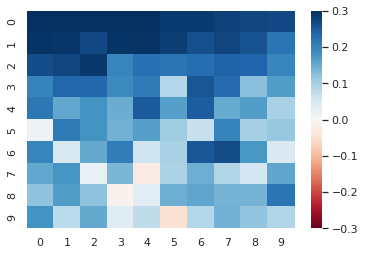

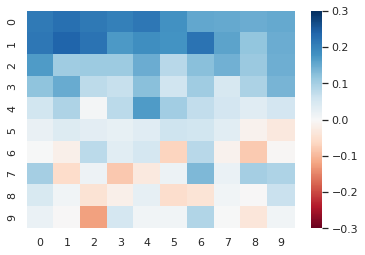

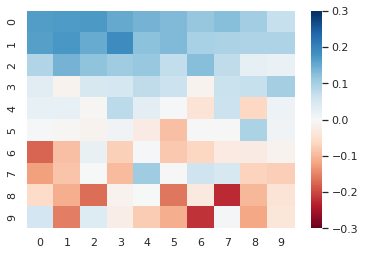

In [234]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()


ax = sns.heatmap(Delta1,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

ax = sns.heatmap(Delta2-0.1,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()
ax = sns.heatmap(Delta3-0.15,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

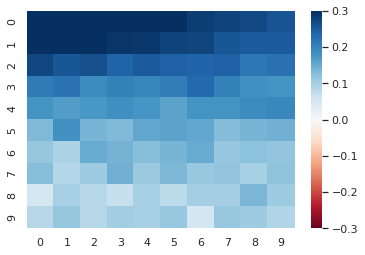

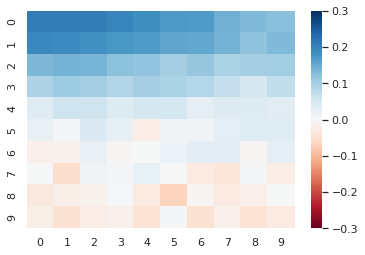

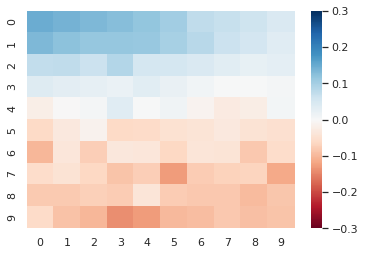

In [259]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()


ax = sns.heatmap(Delta12,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

ax = sns.heatmap(Delta22-0.12,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()
ax = sns.heatmap(Delta32-0.185,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

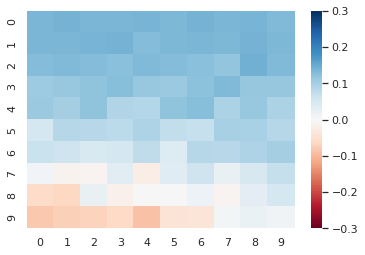

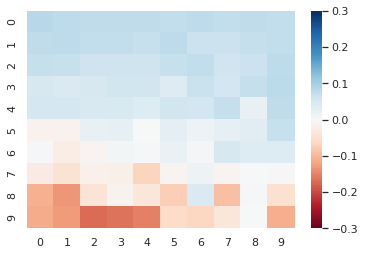

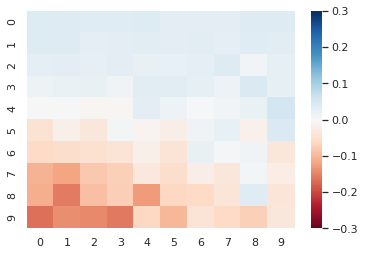

In [260]:
import numpy as np; np.random.seed(0)

import seaborn as sns; sns.set_theme()

ax = sns.heatmap(Delta212,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

ax = sns.heatmap(Delta222-0.06,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

ax = sns.heatmap(Delta232-0.1,cmap=plt.cm.RdBu,vmin=-0.3, vmax=0.3)
plt.show()

In [255]:
def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off